In [1]:
import numpy as np
import cvxpy as cp 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import clear_output
import time
clear_output()

In [2]:
"""
data 
"""

np.random.seed(23824)

TOLDIV = 5e-10
MIT = 2.5e3

d = int(1e3)
fade_cand = 0
fade = max(-10,min(1,fade_cand))
p = 1
R_def = 10

In [3]:
# from INRIA 
def proj_simplex_(vec, R=1,tol=1e-3):
    """ 
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert R > 0, "radius R must be strictly positive (%d <= 0)" % R
    d, = vec.shape  # will raise ValueError if vec is not 1-D
    if abs(vec.sum() - R)<=tol and np.alltrue(vec >= 0):
        return vec
    sorted_vec = np.sort(vec)[::-1]
    cssv = np.cumsum(sorted_vec)
    buf = np.nonzero(sorted_vec * np.arange(1, d+1) > (cssv - R))[0][-1]
    shift = float(cssv[buf] - R) / (1+buf)
    w = (vec - shift).clip(min=0)
    return w

def proj_ball_(x,xi_embd=np.zeros(d),nm_power=p,R=R_def,tol=5e-4):
    dxxi_embd = x-xi_embd
    abs_dxxi_embd = np.abs(dxxi_embd)
    if nm_power==1:
        if np.sum(abs_dxxi_embd)<=R+tol:
            return x
        return xi_embd + proj_simplex_(abs_dxxi_embd,R)*np.sign(dxxi_embd)
    elif nm_power==np.inf:
        if max(abs_dxxi_embd)<=R+tol:
            return x
        return xi_embd + np.minimum(R,np.maximum(-R,dxxi_embd))
    elif nm_power==2:
        buf = (np.sum(abs_dxxi_embd**2))**(1/2)
        if buf<=R+tol:
            return x
        return xi_embd + dxxi_embd*R/max(R,buf)
    else:
        return None

In [4]:
# from deepseek

def split_matrix(U):
    # Compute the eigenvalues and eigenvectors of U
    eigvals, eigvecs = np.linalg.eigh(U)
    
    # Split the eigenvalues into positive and negative parts
    lambda_plus = np.maximum(eigvals, 0)
    lambda_minus = np.maximum(-eigvals, 0)
    
    # Construct the diagonal matrices for positive and negative parts
    Lambda_plus = np.diag(lambda_plus)
    Lambda_minus = np.diag(lambda_minus)
    
    # Reconstruct U1 and U2 using the eigenvectors
    U1 = eigvecs @ Lambda_plus @ eigvecs.T
    U2 = eigvecs @ Lambda_minus @ eigvecs.T
    
    return (U1+U1.T)/2, (U2+U2.T)/2

In [5]:
def SDCe(MO,f1,f2,Psi,F,x_init,L_init,desc_prop=.1,tau_loc=2/3,ns_trig=5,dc_steps=int(200),\
            reset_after_ls=False,max_iter=1000,verb=False,vb_freq=50):
    
    # inits.
    tau_ext = .001
    x_stability_prev_next,x_stability_prev,x_stability,x,L = x_init.copy(),x_init.copy(),x_init.copy(),x_init.copy(),L_init
    k = 0
    div_succ_it = np.inf
    num_streak_success = 0
    L_min,L_max,L_prev = 1,1e16,0
    th,th_prev,varsigma = 1,0,0
    
    DCA_useful_iters = 0

    cond = True
    
    while k<max_iter and div_succ_it>TOLDIV and L<L_max:
                
        # IO
        y = x_stability+min(np.sqrt(L_prev*(1-tau_ext)/L),varsigma)*(x_stability_prev_next-x_stability_prev)
        f1y,g1y = f1(y,mode='full')
        f1y_tilde = f1y-np.sum(g1y*y)
        if cond:
            f2x,g2x = f2(x=x_stability,mode='full')
            f2x_stability,g2x_stability = f2x,g2x
            f2x_stability_tilde = f2x_stability-np.sum(g2x_stability*x_stability)
            val = f1(x_stability,'value')-f2x_stability+Psi(x_stability)

        cond = False
        
        if num_streak_success>=ns_trig:
            L = max(L_min+0.01,L*tau_loc)
            if reset_after_ls:
                num_streak_success = 0
            
        # MO 
        x_stability_plus,x,DCA_inner = MO(y,g1y,f1y_tilde,g2x_stability,f2x_stability_tilde,L,max_steps=dc_steps,min_decr_inner=5e-4)

        # IO 
        f1x,g1x = f1(x,mode='full')
        val_new = f1x-f2(x,'value')+Psi(x)
        
        # potential sufficient decrease check 
        div_ = np.sum((x-y)**2)/2
        div_x_stab_x_stab_plus = np.sum((x_stability_plus-x_stability)**2)/2
        cond = val_new + L*div_x_stab_x_stab_plus <= val + L*np.sum((y-x_stability)**2)/2 - L_min*desc_prop*div_

        if cond==False:
            L = min(L_max,L/tau_loc)
            num_streak_success = 0 # reset counter
        else:
            num_streak_success += 1
                
        # updates
        if cond:
            k += 1
            L_prev = L
            DCA_useful_iters += DCA_inner>0
            div_succ_it = np.sum((x-x_stability)**2)/2
            x_stability_prev = x_stability
            x_stability_prev_next = x_stability_plus
            x_stability = x.copy()
            val = val_new
            new_th = (1+np.sqrt(1+4*th**2))/2
            th_prev = th
            th = new_th
            varsigma = (th_prev-1)/th

        
        if verb and k%vb_freq==0 and cond:
            print('#'+str(k)+' itrs. | Fval = '+'{:.4e}'.format(val_new)+' ; div. '+'{:.2e}'.format(div_succ_it)+' ; L = '+'{:.3e}'.format(L)+' ; #DC iters = '+str(DCA_useful_iters))
    print(' ')
    print('HALT #'+str(k)+' iters. | Fval = '+str(val_new)+' ; div. '+str(div_succ_it)+' ; #DC iters = '+str(DCA_useful_iters)) 
            
    return x,val,k

In [6]:
def SDC(MO,f1,f2,Psi,F,x_init,L_init,desc_prop=.1,tau_loc=2/3,ns_trig=5,dc_steps=int(200),\
            reset_after_ls=False,max_iter=1000,verb=False,vb_freq=50):
    
    # inits.
    x_stability,x,L = x_init.copy(),x_init.copy(),L_init
    k = 0
    div_succ_it = np.inf
    num_streak_success = 0
    L_min,L_max,L_prev = 1,1e16,0
    
    DCA_useful_iters = 0

    cond = True
    
    while k<max_iter and div_succ_it>TOLDIV and L<L_max:
                
        # IO
        if cond:
            y = x_stability.copy()
            f1y,g1y = f1(y,mode='full')
            f1y_tilde = f1y-np.sum(g1y*y)
            f2x,g2x = f2(x=x_stability,mode='full')
            f2x_stability,g2x_stability = f2x,g2x
            f2x_stability_tilde = f2x_stability-np.sum(g2x_stability*x_stability)
            val = f1(x_stability,'value')-f2x_stability+Psi(x_stability)

        cond = False
        
        if num_streak_success>=ns_trig:
            L = max(L_min+0.01,L*tau_loc)
            if reset_after_ls:
                num_streak_success = 0
            
        # MO 
        x_stability_plus,x,DCA_inner = MO(y,g1y,f1y_tilde,g2x_stability,f2x_stability_tilde,L,max_steps=dc_steps,min_decr_inner=5e-4)

        # IO 
        f1x,g1x = f1(x,mode='full')
        val_new = f1x-f2(x,'value')+Psi(x)
        
        # potential sufficient decrease check 
        div_ = np.sum((x-y)**2)/2
        div_x_stab_x_stab_plus = np.sum((x_stability_plus-x_stability)**2)/2
        cond = val_new + L*div_x_stab_x_stab_plus <= val - L_min*desc_prop*div_

        if cond==False:
            L = min(L_max,L/tau_loc)
            num_streak_success = 0 # reset counter
        else:
            num_streak_success += 1
                
        # updates
        if cond:
            k += 1
            L_prev = L
            DCA_useful_iters += DCA_inner>0
            div_succ_it = np.sum((x-x_stability)**2)/2
            x_stability = x.copy()
            val = val_new
        
        if verb and k%vb_freq==0 and cond:
            print('#'+str(k)+' itrs. | Fval = '+'{:.4e}'.format(val_new)+' ; div. '+'{:.2e}'.format(div_succ_it)+' ; L = '+'{:.3e}'.format(L)+' ; #DC iters = '+str(DCA_useful_iters))
    print(' ')
    print('HALT #'+str(k)+' iters. | Fval = '+str(val_new)+' ; div. '+str(div_succ_it)+' ; #DC iters = '+str(DCA_useful_iters)) 
            
    return x,val,k

In [7]:
import pandas as pd

In [8]:
NPROBS = int(10)
REPS = int(10)
TL = 2/3

times = []
values = []
repetitions = []
extraps = []
method = []
num_iters = []
DC_updates = []
ls = []
probIDs = []

for probID in range(NPROBS):

    U = np.random.uniform(-2,2,(d,d))
    U = (U+U.T)/2

    U1, U2 = split_matrix(U)
    U2 = (1-fade)*U2
    U2 = (U2+U2.T)/2
    U = U1-U2
    L_ref = np.max(np.real(np.linalg.eigvals(U1)))*1.25
    print(' ')
    print('PID #'+str(probID))
    print(' ')

    """
    information oracles
    """

    def f1_oracle(x,mode='value'):
        U1x = U1@x
        if mode=='value':
            return (1/2)*np.sum(U1x*x)
        elif mode=='gradient':
            return U1x
        else:
            return (1/2)*np.sum(U1x*x),U1x

    def f2_oracle(x,mode='value'):
        U2x = U2@x
        if mode=='value':
            return (1/2)*np.sum(U2x*x)
        elif mode=='gradient':
            return U2x
        else:
            return (1/2)*np.sum(U2x*x),U2x

    def Psi_oracle(x):
        if np.linalg.norm(x,p)<=R_def+3e-3:
            return 0
        else:
            return np.inf

    def F_oracle(x):
        return 1/2*np.sum((U@x)*x)+np.sum(bar_u*x)+Psi_oracle(x)
    
    """
    oracle 

    approx solves: (subProblem) min mod(u) := f1(y) + <grad f1(y),u-y> + L_hat/2*||u-y||_2^2 + Psi(u) - f2(u)

    ensures with (x)_+ = arg min f1(y) + <grad f1(y),u-y> + L_hat/2*||u-y||_2^2 + Psi(u) - f2(x)-<g2(x),u-x>
    that

    output x_+ is a (approx) critical point of (subProblem) (i)
    output x_+ such that mod(x_+) <= mod((x)_+) (ii)


    """

    def MO_oracle(y,g1y,f1y_tilde,g2x,f2x_tilde,L_hat,max_steps=0,min_decr_inner=5e-4):
        mod = lambda u: f1y_tilde+np.sum(g1y*y)-f2_oracle(u,'value')+Psi_oracle(u)+L_hat*np.sum((u-y)**2)/2
        x_plus = proj_ball_(y-(g1y-g2x)/L_hat)
        x_ = x_plus.copy()
        modval = mod(x_)
        k_inner,cond = 0,True
        while k_inner<max_steps and cond:
            g2x_ = f2_oracle(x_,'gradient')
            x_next = proj_ball_(y-(g1y-g2x_)/L_hat)
            modval_next = mod(x_next)
            decr = modval-modval_next
            if decr>min_decr_inner:
                k_inner += 1
                x_ = x_next.copy()
                modval = modval_next
            else:
                cond = False
                if modval_next<modval:
                    x_ = x_next.copy()
        return x_plus,x_,k_inner

    for rep in range(REPS):

        x_random = proj_ball_(np.random.uniform(-3,3,d))

        print('repID: '+str(rep))
        print(' ')

        print(' ')

        print('go SDCe-LS')
        time_start_SDCe_LS = time.time()
        x_out_SDCe_LS,F_out_SDCe_LS,k_out_SDCe_LS = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDCe_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SDCe_LS-time_start_SDCe_LS)
        values.append(F_out_SDCe_LS)
        method.append('SDCe-LS')
        num_iters.append(k_out_SDCe_LS)
        extraps.append('yes')
        DC_updates.append('yes')
        ls.append('yes')
        probIDs.append(probID)


        print(' ')

        print('go SDCe')
        time_start_SDCe = time.time()
        x_out_SDCe,F_out_SDCe,k_out_SDCe = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDCe = time.time()

        repetitions.append(rep)
        times.append(time_end_SDCe-time_start_SDCe)
        values.append(F_out_SDCe)
        method.append('SDCe')
        num_iters.append(k_out_SDCe)
        extraps.append('yes')
        DC_updates.append('yes')
        ls.append('no')
        probIDs.append(probID)


        print(' ')

        print('go SCe-LS')
        time_start_SCe_LS = time.time()
        x_out_SCe_LS,F_out_SCe_LS,k_out_SCe_LS = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SCe_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SCe_LS-time_start_SCe_LS)
        values.append(F_out_SCe_LS)
        method.append('SCe-LS')
        num_iters.append(k_out_SCe_LS)
        extraps.append('yes')
        DC_updates.append('no')
        ls.append('yes')
        probIDs.append(probID)


        print(' ')

        print('go SCe')
        time_start_SCe = time.time()
        x_out_SCe,F_out_SCe,k_out_SCe = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SCe = time.time()

        repetitions.append(rep)
        times.append(time_end_SCe-time_start_SCe)
        values.append(F_out_SCe)
        method.append('SCe')
        num_iters.append(k_out_SCe)
        extraps.append('yes')
        DC_updates.append('no')
        ls.append('no')
        probIDs.append(probID)


        print(' ')


        print('go SDC-LS')
        time_start_SDC_LS = time.time()
        x_out_SDC_LS,F_out_SDC_LS,k_out_SDC_LS = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDC_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SDC_LS-time_start_SDC_LS)
        values.append(F_out_SDC_LS)
        method.append('SDC-LS')
        num_iters.append(k_out_SDC_LS)
        extraps.append('no')
        DC_updates.append('yes')
        ls.append('yes')
        probIDs.append(probID)



        print(' ')

        print('go SDC')
        time_start_SDC = time.time()
        x_out_SDC,F_out_SDC,k_out_SDC = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDC = time.time()

        repetitions.append(rep)
        times.append(time_end_SDC-time_start_SDC)
        values.append(F_out_SDC)
        method.append('SDC')
        num_iters.append(k_out_SDC)
        extraps.append('no')
        DC_updates.append('yes')
        ls.append('no')
        probIDs.append(probID)


        print( '')

        print('go SC-LS')
        time_start_SC_LS = time.time()
        x_out_SC_LS,F_out_SC_LS,k_out_SC_LS = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SC_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SC_LS-time_start_SC_LS)
        values.append(F_out_SC_LS)
        method.append('SC-LS')
        num_iters.append(k_out_SC_LS)
        extraps.append('no')
        DC_updates.append('no')
        ls.append('yes')
        probIDs.append(probID)



        print(' ')

        print('go SC')
        time_start_SC = time.time()
        x_out_SC,F_out_SC,k_out_SC = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SC = time.time()

        repetitions.append(rep)
        times.append(time_end_SC-time_start_SC)
        values.append(F_out_SC)
        method.append('SC')
        num_iters.append(k_out_SC)
        extraps.append('no')
        DC_updates.append('no')
        ls.append('no')
        probIDs.append(probID)

        print(' ')


        subdf = pd.DataFrame(data={'repID':repetitions,'vals':values,'times':times,'method':method,'iters':num_iters,\
                                   'extrapolation':extraps,'dc_updates':DC_updates,'linesearch':ls,'pID':probIDs})    

        if fade<0:
            subdf.to_csv('new_benchmark_methods_concave_QP_d_'+str(d)+'.csv')
        elif fade>0:
            subdf.to_csv('new_benchmark_methods_convex_QP_d_'+str(d)+'.csv')
        else:
            subdf.to_csv('new_benchmark_methods_neutral_QP_d_'+str(d)+'.csv')
            
    print(' ')

 
PID #0
 
repID: 0
 
 
go SDCe-LS
#10 itrs. | Fval = -9.5225e+01 ; div. 7.66e-02 ; L = 8.482e+00 ; #DC iters = 7
#20 itrs. | Fval = -9.5384e+01 ; div. 1.06e-04 ; L = 3.770e+00 ; #DC iters = 7
#30 itrs. | Fval = -9.5401e+01 ; div. 2.44e-05 ; L = 8.482e+00 ; #DC iters = 7
#40 itrs. | Fval = -9.5404e+01 ; div. 9.31e-07 ; L = 8.482e+00 ; #DC iters = 7
#50 itrs. | Fval = -9.5404e+01 ; div. 5.76e-07 ; L = 8.482e+00 ; #DC iters = 7
#60 itrs. | Fval = -9.5404e+01 ; div. 7.68e-08 ; L = 3.770e+00 ; #DC iters = 7
#70 itrs. | Fval = -9.5404e+01 ; div. 5.34e-10 ; L = 3.770e+00 ; #DC iters = 7
 
HALT #78 iters. | Fval = -95.4042581451709 ; div. 3.453887236071807e-10 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -3.1743e+01 ; div. 7.14e-02 ; L = 6.441e+01 ; #DC iters = 8
#20 itrs. | Fval = -7.3015e+01 ; div. 7.53e-02 ; L = 6.441e+01 ; #DC iters = 18
#30 itrs. | Fval = -8.1323e+01 ; div. 6.60e-03 ; L = 6.441e+01 ; #DC iters = 28
#40 itrs. | Fval = -8.3106e+01 ; div. 7.81e-03 ; L = 6.441e+01 ; #DC iter

#400 itrs. | Fval = -9.5386e+01 ; div. 9.91e-07 ; L = 6.441e+01 ; #DC iters = 398
#410 itrs. | Fval = -9.5387e+01 ; div. 8.73e-07 ; L = 6.441e+01 ; #DC iters = 408
#420 itrs. | Fval = -9.5388e+01 ; div. 7.69e-07 ; L = 6.441e+01 ; #DC iters = 418
#430 itrs. | Fval = -9.5388e+01 ; div. 6.77e-07 ; L = 6.441e+01 ; #DC iters = 428
#440 itrs. | Fval = -9.5389e+01 ; div. 5.97e-07 ; L = 6.441e+01 ; #DC iters = 438
#450 itrs. | Fval = -9.5390e+01 ; div. 5.26e-07 ; L = 6.441e+01 ; #DC iters = 448
#460 itrs. | Fval = -9.5390e+01 ; div. 4.63e-07 ; L = 6.441e+01 ; #DC iters = 458
#470 itrs. | Fval = -9.5391e+01 ; div. 4.08e-07 ; L = 6.441e+01 ; #DC iters = 468
#480 itrs. | Fval = -9.5391e+01 ; div. 3.60e-07 ; L = 6.441e+01 ; #DC iters = 478
#490 itrs. | Fval = -9.5391e+01 ; div. 3.17e-07 ; L = 6.441e+01 ; #DC iters = 488
#500 itrs. | Fval = -9.5392e+01 ; div. 2.79e-07 ; L = 6.441e+01 ; #DC iters = 498
#510 itrs. | Fval = -9.5392e+01 ; div. 2.46e-07 ; L = 6.441e+01 ; #DC iters = 508
#520 itrs. | Fva

#400 itrs. | Fval = -9.4862e+01 ; div. 1.90e-04 ; L = 6.441e+01 ; #DC iters = 0
#410 itrs. | Fval = -9.5113e+01 ; div. 1.99e-04 ; L = 6.441e+01 ; #DC iters = 0
#420 itrs. | Fval = -9.5362e+01 ; div. 4.28e-05 ; L = 6.441e+01 ; #DC iters = 0
#430 itrs. | Fval = -9.5368e+01 ; div. 2.17e-06 ; L = 6.441e+01 ; #DC iters = 0
#440 itrs. | Fval = -9.5370e+01 ; div. 1.95e-06 ; L = 6.441e+01 ; #DC iters = 0
#450 itrs. | Fval = -9.5373e+01 ; div. 1.76e-06 ; L = 6.441e+01 ; #DC iters = 0
#460 itrs. | Fval = -9.5375e+01 ; div. 1.58e-06 ; L = 6.441e+01 ; #DC iters = 0
#470 itrs. | Fval = -9.5377e+01 ; div. 1.43e-06 ; L = 6.441e+01 ; #DC iters = 0
#480 itrs. | Fval = -9.5378e+01 ; div. 1.28e-06 ; L = 6.441e+01 ; #DC iters = 0
#490 itrs. | Fval = -9.5380e+01 ; div. 1.16e-06 ; L = 6.441e+01 ; #DC iters = 0
#500 itrs. | Fval = -9.5381e+01 ; div. 1.04e-06 ; L = 6.441e+01 ; #DC iters = 0
#510 itrs. | Fval = -9.5383e+01 ; div. 9.37e-07 ; L = 6.441e+01 ; #DC iters = 0
#520 itrs. | Fval = -9.5384e+01 ; div. 8

#10 itrs. | Fval = -4.7116e+01 ; div. 4.28e-01 ; L = 3.770e+00 ; #DC iters = 0
#20 itrs. | Fval = -6.9067e+01 ; div. 2.41e-02 ; L = 8.482e+00 ; #DC iters = 0
#30 itrs. | Fval = -7.0503e+01 ; div. 2.55e-02 ; L = 5.654e+00 ; #DC iters = 0
#40 itrs. | Fval = -7.1102e+01 ; div. 1.57e-02 ; L = 5.654e+00 ; #DC iters = 0
#50 itrs. | Fval = -7.1749e+01 ; div. 1.08e-02 ; L = 2.513e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.1861e+01 ; div. 1.85e-04 ; L = 8.482e+00 ; #DC iters = 0
#70 itrs. | Fval = -7.1867e+01 ; div. 1.33e-05 ; L = 3.770e+00 ; #DC iters = 0
#80 itrs. | Fval = -7.1868e+01 ; div. 1.24e-06 ; L = 8.482e+00 ; #DC iters = 0
#90 itrs. | Fval = -7.1868e+01 ; div. 9.43e-07 ; L = 5.654e+00 ; #DC iters = 0
#100 itrs. | Fval = -7.1868e+01 ; div. 3.39e-08 ; L = 8.482e+00 ; #DC iters = 0
#110 itrs. | Fval = -7.1868e+01 ; div. 1.48e-08 ; L = 5.654e+00 ; #DC iters = 0
#120 itrs. | Fval = -7.1868e+01 ; div. 1.49e-09 ; L = 8.482e+00 ; #DC iters = 0
 
HALT #126 iters. | Fval = -71.86785212846848 ; 

#110 itrs. | Fval = -6.9217e+01 ; div. 2.93e-04 ; L = 6.441e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.9542e+01 ; div. 2.26e-04 ; L = 6.441e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.9798e+01 ; div. 1.80e-04 ; L = 6.441e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.0004e+01 ; div. 1.47e-04 ; L = 6.441e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.0176e+01 ; div. 1.24e-04 ; L = 6.441e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.0321e+01 ; div. 1.06e-04 ; L = 6.441e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.0448e+01 ; div. 9.31e-05 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.0560e+01 ; div. 8.29e-05 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.0661e+01 ; div. 7.47e-05 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.0752e+01 ; div. 6.80e-05 ; L = 6.441e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.0835e+01 ; div. 6.24e-05 ; L = 6.441e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.0914e+01 ; div. 6.04e-05 ; L = 6.441e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.0992e+01 ; div. 6

#30 itrs. | Fval = -6.5719e+01 ; div. 7.78e-03 ; L = 8.482e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.7685e+01 ; div. 1.73e-03 ; L = 8.482e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.8059e+01 ; div. 3.89e-03 ; L = 8.482e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.8675e+01 ; div. 4.31e-03 ; L = 8.482e+00 ; #DC iters = 0
#70 itrs. | Fval = -7.0175e+01 ; div. 1.07e-02 ; L = 5.654e+00 ; #DC iters = 0
#80 itrs. | Fval = -7.3630e+01 ; div. 1.08e-01 ; L = 2.513e+00 ; #DC iters = 0
#90 itrs. | Fval = -8.0181e+01 ; div. 7.08e-02 ; L = 5.654e+00 ; #DC iters = 0
#100 itrs. | Fval = -8.2355e+01 ; div. 8.46e-03 ; L = 5.654e+00 ; #DC iters = 0
#110 itrs. | Fval = -8.3198e+01 ; div. 6.37e-04 ; L = 8.482e+00 ; #DC iters = 0
#120 itrs. | Fval = -8.3240e+01 ; div. 3.08e-04 ; L = 5.654e+00 ; #DC iters = 0
#130 itrs. | Fval = -8.3246e+01 ; div. 1.65e-05 ; L = 8.482e+00 ; #DC iters = 0
#140 itrs. | Fval = -8.3247e+01 ; div. 6.24e-06 ; L = 3.770e+00 ; #DC iters = 0
#150 itrs. | Fval = -8.3247e+01 ; div. 3.48e-06

#530 itrs. | Fval = -8.6070e+01 ; div. 6.47e-07 ; L = 6.441e+01 ; #DC iters = 525
#540 itrs. | Fval = -8.6071e+01 ; div. 5.82e-07 ; L = 6.441e+01 ; #DC iters = 535
#550 itrs. | Fval = -8.6072e+01 ; div. 5.26e-07 ; L = 6.441e+01 ; #DC iters = 545
#560 itrs. | Fval = -8.6072e+01 ; div. 4.77e-07 ; L = 6.441e+01 ; #DC iters = 555
#570 itrs. | Fval = -8.6073e+01 ; div. 4.34e-07 ; L = 6.441e+01 ; #DC iters = 565
#580 itrs. | Fval = -8.6073e+01 ; div. 3.97e-07 ; L = 6.441e+01 ; #DC iters = 575
#590 itrs. | Fval = -8.6073e+01 ; div. 3.63e-07 ; L = 6.441e+01 ; #DC iters = 585
#600 itrs. | Fval = -8.6074e+01 ; div. 3.33e-07 ; L = 6.441e+01 ; #DC iters = 595
#610 itrs. | Fval = -8.6074e+01 ; div. 3.06e-07 ; L = 6.441e+01 ; #DC iters = 605
#620 itrs. | Fval = -8.6074e+01 ; div. 2.82e-07 ; L = 6.441e+01 ; #DC iters = 615
#630 itrs. | Fval = -8.6075e+01 ; div. 2.60e-07 ; L = 6.441e+01 ; #DC iters = 625
#640 itrs. | Fval = -8.6075e+01 ; div. 2.40e-07 ; L = 6.441e+01 ; #DC iters = 635
#650 itrs. | Fva

#20 itrs. | Fval = -2.7300e+01 ; div. 7.05e-03 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -3.4599e+01 ; div. 4.42e-03 ; L = 6.441e+01 ; #DC iters = 0
#40 itrs. | Fval = -3.9280e+01 ; div. 2.44e-03 ; L = 6.441e+01 ; #DC iters = 0
#50 itrs. | Fval = -4.1782e+01 ; div. 1.81e-03 ; L = 6.441e+01 ; #DC iters = 0
#60 itrs. | Fval = -4.5033e+01 ; div. 3.16e-03 ; L = 6.441e+01 ; #DC iters = 0
#70 itrs. | Fval = -4.9680e+01 ; div. 2.80e-03 ; L = 6.441e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.2297e+01 ; div. 1.78e-03 ; L = 6.441e+01 ; #DC iters = 0
#90 itrs. | Fval = -5.4450e+01 ; div. 1.51e-03 ; L = 6.441e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.6306e+01 ; div. 1.41e-03 ; L = 6.441e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.8007e+01 ; div. 1.19e-03 ; L = 6.441e+01 ; #DC iters = 0
#120 itrs. | Fval = -5.9207e+01 ; div. 7.08e-04 ; L = 6.441e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.0045e+01 ; div. 6.26e-04 ; L = 6.441e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.0875e+01 ; div. 6.73e-04 

#1070 itrs. | Fval = -8.3247e+01 ; div. 1.65e-09 ; L = 6.441e+01 ; #DC iters = 0
#1080 itrs. | Fval = -8.3247e+01 ; div. 1.21e-09 ; L = 6.441e+01 ; #DC iters = 0
#1090 itrs. | Fval = -8.3247e+01 ; div. 8.92e-10 ; L = 6.441e+01 ; #DC iters = 0
#1100 itrs. | Fval = -8.3247e+01 ; div. 6.57e-10 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #1109 iters. | Fval = -83.24707423056941 ; div. 4.987553496381099e-10 ; #DC iters = 0
 
repID: 3
 
 
go SDCe-LS
#10 itrs. | Fval = -6.8489e+01 ; div. 2.19e+01 ; L = 5.654e+00 ; #DC iters = 7
#20 itrs. | Fval = -7.4000e+01 ; div. 4.42e-02 ; L = 5.654e+00 ; #DC iters = 7
#30 itrs. | Fval = -7.4806e+01 ; div. 2.97e-03 ; L = 3.770e+00 ; #DC iters = 7
#40 itrs. | Fval = -7.5092e+01 ; div. 4.06e-03 ; L = 8.482e+00 ; #DC iters = 7
#50 itrs. | Fval = -7.6422e+01 ; div. 8.54e-01 ; L = 3.770e+00 ; #DC iters = 8
#60 itrs. | Fval = -7.7205e+01 ; div. 1.57e-03 ; L = 5.654e+00 ; #DC iters = 8
#70 itrs. | Fval = -7.7626e+01 ; div. 1.81e-03 ; L = 8.482e+00 ; #DC iters = 8
#80 

#120 itrs. | Fval = -8.0981e+01 ; div. 3.02e-09 ; L = 1.272e+01 ; #DC iters = 108
#130 itrs. | Fval = -8.0981e+01 ; div. 1.05e-09 ; L = 1.272e+01 ; #DC iters = 118
 
HALT #132 iters. | Fval = -80.98072134312201 ; div. 4.877970059036883e-10 ; #DC iters = 118
 
go SDC
#10 itrs. | Fval = -1.6548e+01 ; div. 1.31e-02 ; L = 6.441e+01 ; #DC iters = 8
#20 itrs. | Fval = -3.2788e+01 ; div. 1.70e-02 ; L = 6.441e+01 ; #DC iters = 18
#30 itrs. | Fval = -4.5433e+01 ; div. 5.34e-03 ; L = 6.441e+01 ; #DC iters = 28
#40 itrs. | Fval = -4.7970e+01 ; div. 1.69e-03 ; L = 6.441e+01 ; #DC iters = 38
#50 itrs. | Fval = -5.0137e+01 ; div. 2.31e-03 ; L = 6.441e+01 ; #DC iters = 48
#60 itrs. | Fval = -5.1869e+01 ; div. 1.03e-03 ; L = 6.441e+01 ; #DC iters = 58
#70 itrs. | Fval = -5.3095e+01 ; div. 1.30e-03 ; L = 6.441e+01 ; #DC iters = 68
#80 itrs. | Fval = -5.4862e+01 ; div. 2.03e-03 ; L = 6.441e+01 ; #DC iters = 78
#90 itrs. | Fval = -5.6549e+01 ; div. 1.16e-03 ; L = 6.441e+01 ; #DC iters = 88
#100 itrs. | F

#980 itrs. | Fval = -8.3530e+01 ; div. 1.07e-05 ; L = 6.441e+01 ; #DC iters = 856
#990 itrs. | Fval = -8.3541e+01 ; div. 1.03e-05 ; L = 6.441e+01 ; #DC iters = 866
#1000 itrs. | Fval = -8.3552e+01 ; div. 9.93e-06 ; L = 6.441e+01 ; #DC iters = 876
#1010 itrs. | Fval = -8.3563e+01 ; div. 9.56e-06 ; L = 6.441e+01 ; #DC iters = 886
#1020 itrs. | Fval = -8.3573e+01 ; div. 9.21e-06 ; L = 6.441e+01 ; #DC iters = 896
#1030 itrs. | Fval = -8.3582e+01 ; div. 8.86e-06 ; L = 6.441e+01 ; #DC iters = 906
#1040 itrs. | Fval = -8.3591e+01 ; div. 8.54e-06 ; L = 6.441e+01 ; #DC iters = 916
#1050 itrs. | Fval = -8.3600e+01 ; div. 8.22e-06 ; L = 6.441e+01 ; #DC iters = 926
#1060 itrs. | Fval = -8.3609e+01 ; div. 7.92e-06 ; L = 6.441e+01 ; #DC iters = 936
#1070 itrs. | Fval = -8.3617e+01 ; div. 7.63e-06 ; L = 6.441e+01 ; #DC iters = 946
#1080 itrs. | Fval = -8.3625e+01 ; div. 7.34e-06 ; L = 6.441e+01 ; #DC iters = 956
#1090 itrs. | Fval = -8.3633e+01 ; div. 7.07e-06 ; L = 6.441e+01 ; #DC iters = 966
#1100 

#500 itrs. | Fval = -7.8966e+01 ; div. 1.82e-05 ; L = 6.441e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.8987e+01 ; div. 1.49e-05 ; L = 6.441e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.9004e+01 ; div. 1.22e-05 ; L = 6.441e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.9018e+01 ; div. 1.01e-05 ; L = 6.441e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.9030e+01 ; div. 8.25e-06 ; L = 6.441e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.9039e+01 ; div. 6.78e-06 ; L = 6.441e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.9047e+01 ; div. 5.56e-06 ; L = 6.441e+01 ; #DC iters = 0
#570 itrs. | Fval = -7.9054e+01 ; div. 4.57e-06 ; L = 6.441e+01 ; #DC iters = 0
#580 itrs. | Fval = -7.9059e+01 ; div. 3.75e-06 ; L = 6.441e+01 ; #DC iters = 0
#590 itrs. | Fval = -7.9063e+01 ; div. 3.08e-06 ; L = 6.441e+01 ; #DC iters = 0
#600 itrs. | Fval = -7.9067e+01 ; div. 2.53e-06 ; L = 6.441e+01 ; #DC iters = 0
#610 itrs. | Fval = -7.9070e+01 ; div. 2.07e-06 ; L = 6.441e+01 ; #DC iters = 0
#620 itrs. | Fval = -7.9072e+01 ; div. 1

#30 itrs. | Fval = -4.4564e+01 ; div. 7.32e-03 ; L = 6.441e+01 ; #DC iters = 28
#40 itrs. | Fval = -5.2613e+01 ; div. 7.08e-03 ; L = 6.441e+01 ; #DC iters = 38
#50 itrs. | Fval = -5.5598e+01 ; div. 1.79e-03 ; L = 6.441e+01 ; #DC iters = 48
#60 itrs. | Fval = -5.7310e+01 ; div. 1.56e-03 ; L = 6.441e+01 ; #DC iters = 58
#70 itrs. | Fval = -5.9294e+01 ; div. 8.65e-04 ; L = 6.441e+01 ; #DC iters = 68
#80 itrs. | Fval = -6.0389e+01 ; div. 1.21e-03 ; L = 6.441e+01 ; #DC iters = 78
#90 itrs. | Fval = -6.1845e+01 ; div. 1.28e-03 ; L = 6.441e+01 ; #DC iters = 88
#100 itrs. | Fval = -6.3678e+01 ; div. 2.16e-03 ; L = 6.441e+01 ; #DC iters = 98
#110 itrs. | Fval = -6.6888e+01 ; div. 3.86e-03 ; L = 6.441e+01 ; #DC iters = 108
#120 itrs. | Fval = -7.2698e+01 ; div. 7.03e-03 ; L = 6.441e+01 ; #DC iters = 118
#130 itrs. | Fval = -7.8843e+01 ; div. 2.84e-03 ; L = 6.441e+01 ; #DC iters = 128
#140 itrs. | Fval = -8.1637e+01 ; div. 2.48e-03 ; L = 6.441e+01 ; #DC iters = 138
#150 itrs. | Fval = -8.4171e+01

#530 itrs. | Fval = -9.4678e+01 ; div. 2.87e-08 ; L = 6.441e+01 ; #DC iters = 0
#540 itrs. | Fval = -9.4678e+01 ; div. 1.72e-08 ; L = 6.441e+01 ; #DC iters = 0
#550 itrs. | Fval = -9.4678e+01 ; div. 1.03e-08 ; L = 6.441e+01 ; #DC iters = 0
#560 itrs. | Fval = -9.4678e+01 ; div. 6.19e-09 ; L = 6.441e+01 ; #DC iters = 0
#570 itrs. | Fval = -9.4678e+01 ; div. 3.71e-09 ; L = 6.441e+01 ; #DC iters = 0
#580 itrs. | Fval = -9.4678e+01 ; div. 2.23e-09 ; L = 6.441e+01 ; #DC iters = 0
#590 itrs. | Fval = -9.4678e+01 ; div. 1.34e-09 ; L = 6.441e+01 ; #DC iters = 0
#600 itrs. | Fval = -9.4678e+01 ; div. 8.01e-10 ; L = 6.441e+01 ; #DC iters = 0
#610 itrs. | Fval = -9.4678e+01 ; div. 4.81e-10 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #610 iters. | Fval = -94.67830664349373 ; div. 4.808231373469503e-10 ; #DC iters = 0
 
repID: 5
 
 
go SDCe-LS
#10 itrs. | Fval = -9.7708e+01 ; div. 6.40e-02 ; L = 5.654e+00 ; #DC iters = 7
#20 itrs. | Fval = -9.7779e+01 ; div. 1.55e-04 ; L = 8.482e+00 ; #DC iters = 7
#30 

#430 itrs. | Fval = -9.7893e+01 ; div. 2.71e-09 ; L = 5.654e+00 ; #DC iters = 0
#440 itrs. | Fval = -9.7893e+01 ; div. 1.43e-09 ; L = 5.654e+00 ; #DC iters = 0
#450 itrs. | Fval = -9.7893e+01 ; div. 7.41e-10 ; L = 5.654e+00 ; #DC iters = 0
 
HALT #456 iters. | Fval = -97.8933044595409 ; div. 4.956902533010034e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.4394e+01 ; div. 3.90e-02 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.7538e+01 ; div. 8.81e-02 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -8.2872e+01 ; div. 4.12e-02 ; L = 6.441e+01 ; #DC iters = 0
#40 itrs. | Fval = -9.2009e+01 ; div. 1.78e-02 ; L = 6.441e+01 ; #DC iters = 0
#50 itrs. | Fval = -9.6066e+01 ; div. 1.29e-02 ; L = 6.441e+01 ; #DC iters = 0
#60 itrs. | Fval = -9.7795e+01 ; div. 5.39e-07 ; L = 6.441e+01 ; #DC iters = 0
#70 itrs. | Fval = -9.7811e+01 ; div. 6.77e-05 ; L = 6.441e+01 ; #DC iters = 0
#80 itrs. | Fval = -9.7829e+01 ; div. 6.75e-05 ; L = 6.441e+01 ; #DC iters = 0
#90 itrs. | Fval = -9.7844e+

#430 itrs. | Fval = -9.7877e+01 ; div. 6.56e-07 ; L = 6.441e+01 ; #DC iters = 149
#440 itrs. | Fval = -9.7878e+01 ; div. 6.24e-07 ; L = 6.441e+01 ; #DC iters = 149
#450 itrs. | Fval = -9.7878e+01 ; div. 5.93e-07 ; L = 6.441e+01 ; #DC iters = 149
#460 itrs. | Fval = -9.7879e+01 ; div. 5.63e-07 ; L = 6.441e+01 ; #DC iters = 149
#470 itrs. | Fval = -9.7880e+01 ; div. 5.35e-07 ; L = 6.441e+01 ; #DC iters = 149
#480 itrs. | Fval = -9.7880e+01 ; div. 5.09e-07 ; L = 6.441e+01 ; #DC iters = 149
#490 itrs. | Fval = -9.7881e+01 ; div. 4.84e-07 ; L = 6.441e+01 ; #DC iters = 149
#500 itrs. | Fval = -9.7882e+01 ; div. 4.60e-07 ; L = 6.441e+01 ; #DC iters = 149
#510 itrs. | Fval = -9.7882e+01 ; div. 4.37e-07 ; L = 6.441e+01 ; #DC iters = 149
#520 itrs. | Fval = -9.7883e+01 ; div. 4.15e-07 ; L = 6.441e+01 ; #DC iters = 149
#530 itrs. | Fval = -9.7883e+01 ; div. 3.95e-07 ; L = 6.441e+01 ; #DC iters = 149
#540 itrs. | Fval = -9.7884e+01 ; div. 3.75e-07 ; L = 6.441e+01 ; #DC iters = 149
#550 itrs. | Fva

#1440 itrs. | Fval = -9.7893e+01 ; div. 3.86e-09 ; L = 6.441e+01 ; #DC iters = 149
#1450 itrs. | Fval = -9.7893e+01 ; div. 3.67e-09 ; L = 6.441e+01 ; #DC iters = 149
#1460 itrs. | Fval = -9.7893e+01 ; div. 3.49e-09 ; L = 6.441e+01 ; #DC iters = 149
#1470 itrs. | Fval = -9.7893e+01 ; div. 3.32e-09 ; L = 6.441e+01 ; #DC iters = 149
#1480 itrs. | Fval = -9.7893e+01 ; div. 3.15e-09 ; L = 6.441e+01 ; #DC iters = 149
#1490 itrs. | Fval = -9.7893e+01 ; div. 2.99e-09 ; L = 6.441e+01 ; #DC iters = 149
#1500 itrs. | Fval = -9.7893e+01 ; div. 2.85e-09 ; L = 6.441e+01 ; #DC iters = 149
#1510 itrs. | Fval = -9.7893e+01 ; div. 2.71e-09 ; L = 6.441e+01 ; #DC iters = 149
#1520 itrs. | Fval = -9.7893e+01 ; div. 2.57e-09 ; L = 6.441e+01 ; #DC iters = 149
#1530 itrs. | Fval = -9.7893e+01 ; div. 2.44e-09 ; L = 6.441e+01 ; #DC iters = 149
#1540 itrs. | Fval = -9.7893e+01 ; div. 2.32e-09 ; L = 6.441e+01 ; #DC iters = 149
#1550 itrs. | Fval = -9.7893e+01 ; div. 2.21e-09 ; L = 6.441e+01 ; #DC iters = 149
#156

#530 itrs. | Fval = -9.7880e+01 ; div. 5.12e-07 ; L = 6.441e+01 ; #DC iters = 0
#540 itrs. | Fval = -9.7881e+01 ; div. 4.86e-07 ; L = 6.441e+01 ; #DC iters = 0
#550 itrs. | Fval = -9.7882e+01 ; div. 4.62e-07 ; L = 6.441e+01 ; #DC iters = 0
#560 itrs. | Fval = -9.7882e+01 ; div. 4.39e-07 ; L = 6.441e+01 ; #DC iters = 0
#570 itrs. | Fval = -9.7883e+01 ; div. 4.17e-07 ; L = 6.441e+01 ; #DC iters = 0
#580 itrs. | Fval = -9.7883e+01 ; div. 3.97e-07 ; L = 6.441e+01 ; #DC iters = 0
#590 itrs. | Fval = -9.7884e+01 ; div. 3.77e-07 ; L = 6.441e+01 ; #DC iters = 0
#600 itrs. | Fval = -9.7884e+01 ; div. 3.58e-07 ; L = 6.441e+01 ; #DC iters = 0
#610 itrs. | Fval = -9.7885e+01 ; div. 3.41e-07 ; L = 6.441e+01 ; #DC iters = 0
#620 itrs. | Fval = -9.7885e+01 ; div. 3.24e-07 ; L = 6.441e+01 ; #DC iters = 0
#630 itrs. | Fval = -9.7886e+01 ; div. 3.08e-07 ; L = 6.441e+01 ; #DC iters = 0
#640 itrs. | Fval = -9.7886e+01 ; div. 2.92e-07 ; L = 6.441e+01 ; #DC iters = 0
#650 itrs. | Fval = -9.7886e+01 ; div. 2

#1550 itrs. | Fval = -9.7893e+01 ; div. 2.86e-09 ; L = 6.441e+01 ; #DC iters = 0
#1560 itrs. | Fval = -9.7893e+01 ; div. 2.72e-09 ; L = 6.441e+01 ; #DC iters = 0
#1570 itrs. | Fval = -9.7893e+01 ; div. 2.58e-09 ; L = 6.441e+01 ; #DC iters = 0
#1580 itrs. | Fval = -9.7893e+01 ; div. 2.46e-09 ; L = 6.441e+01 ; #DC iters = 0
#1590 itrs. | Fval = -9.7893e+01 ; div. 2.33e-09 ; L = 6.441e+01 ; #DC iters = 0
#1600 itrs. | Fval = -9.7893e+01 ; div. 2.22e-09 ; L = 6.441e+01 ; #DC iters = 0
#1610 itrs. | Fval = -9.7893e+01 ; div. 2.11e-09 ; L = 6.441e+01 ; #DC iters = 0
#1620 itrs. | Fval = -9.7893e+01 ; div. 2.00e-09 ; L = 6.441e+01 ; #DC iters = 0
#1630 itrs. | Fval = -9.7893e+01 ; div. 1.91e-09 ; L = 6.441e+01 ; #DC iters = 0
#1640 itrs. | Fval = -9.7893e+01 ; div. 1.81e-09 ; L = 6.441e+01 ; #DC iters = 0
#1650 itrs. | Fval = -9.7893e+01 ; div. 1.72e-09 ; L = 6.441e+01 ; #DC iters = 0
#1660 itrs. | Fval = -9.7893e+01 ; div. 1.64e-09 ; L = 6.441e+01 ; #DC iters = 0
#1670 itrs. | Fval = -9.7893

#210 itrs. | Fval = -8.7923e+01 ; div. 7.04e-09 ; L = 6.441e+01 ; #DC iters = 0
#220 itrs. | Fval = -8.7923e+01 ; div. 5.26e-09 ; L = 6.441e+01 ; #DC iters = 0
#230 itrs. | Fval = -8.7923e+01 ; div. 3.92e-09 ; L = 6.441e+01 ; #DC iters = 0
#240 itrs. | Fval = -8.7923e+01 ; div. 2.92e-09 ; L = 6.441e+01 ; #DC iters = 0
#250 itrs. | Fval = -8.7923e+01 ; div. 2.17e-09 ; L = 6.441e+01 ; #DC iters = 0
#260 itrs. | Fval = -8.7923e+01 ; div. 1.61e-09 ; L = 6.441e+01 ; #DC iters = 0
#270 itrs. | Fval = -8.7923e+01 ; div. 1.19e-09 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -8.7923e+01 ; div. 8.85e-10 ; L = 6.441e+01 ; #DC iters = 0
#290 itrs. | Fval = -8.7923e+01 ; div. 6.55e-10 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #299 iters. | Fval = -87.9233506642077 ; div. 4.990812276818127e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -8.5544e+01 ; div. 1.20e-01 ; L = 3.770e+00 ; #DC iters = 7
#20 itrs. | Fval = -9.2548e+01 ; div. 5.70e-02 ; L = 2.513e+00 ; #DC iters = 7
#30 itrs. | Fval = 

#120 itrs. | Fval = -8.5041e+01 ; div. 5.10e-04 ; L = 6.441e+01 ; #DC iters = 0
#130 itrs. | Fval = -8.5732e+01 ; div. 5.58e-04 ; L = 6.441e+01 ; #DC iters = 0
#140 itrs. | Fval = -8.6492e+01 ; div. 6.14e-04 ; L = 6.441e+01 ; #DC iters = 0
#150 itrs. | Fval = -8.7330e+01 ; div. 6.80e-04 ; L = 6.441e+01 ; #DC iters = 0
#160 itrs. | Fval = -8.7922e+01 ; div. 5.11e-08 ; L = 6.441e+01 ; #DC iters = 0
#170 itrs. | Fval = -8.7922e+01 ; div. 4.87e-08 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -8.7922e+01 ; div. 4.64e-08 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -8.7922e+01 ; div. 4.42e-08 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -8.7922e+01 ; div. 4.21e-08 ; L = 6.441e+01 ; #DC iters = 0
#210 itrs. | Fval = -8.7922e+01 ; div. 4.01e-08 ; L = 6.441e+01 ; #DC iters = 0
#220 itrs. | Fval = -8.7922e+01 ; div. 3.82e-08 ; L = 6.441e+01 ; #DC iters = 0
#230 itrs. | Fval = -8.7922e+01 ; div. 3.63e-08 ; L = 6.441e+01 ; #DC iters = 0
#240 itrs. | Fval = -8.7922e+01 ; div. 3

#30 itrs. | Fval = -9.8224e+01 ; div. 2.52e-08 ; L = 3.770e+00 ; #DC iters = 9
 
HALT #32 iters. | Fval = -98.22361261503869 ; div. 1.5006101913343606e-11 ; #DC iters = 9
 
go SDCe
#10 itrs. | Fval = -2.5264e+01 ; div. 4.06e-02 ; L = 6.441e+01 ; #DC iters = 9
#20 itrs. | Fval = -4.6932e+01 ; div. 7.17e-02 ; L = 6.441e+01 ; #DC iters = 19
#30 itrs. | Fval = -7.0115e+01 ; div. 4.46e-02 ; L = 6.441e+01 ; #DC iters = 29
#40 itrs. | Fval = -8.3148e+01 ; div. 4.81e-02 ; L = 6.441e+01 ; #DC iters = 39
#50 itrs. | Fval = -9.5723e+01 ; div. 1.45e-02 ; L = 6.441e+01 ; #DC iters = 49
#60 itrs. | Fval = -9.8206e+01 ; div. 1.13e-03 ; L = 6.441e+01 ; #DC iters = 59
#70 itrs. | Fval = -9.8223e+01 ; div. 1.71e-05 ; L = 6.441e+01 ; #DC iters = 69
 
HALT #75 iters. | Fval = -98.22321633714569 ; div. 1.3597402244747067e-10 ; #DC iters = 73
 
go SCe-LS
#10 itrs. | Fval = -3.6390e+01 ; div. 4.21e-01 ; L = 3.770e+00 ; #DC iters = 0
#20 itrs. | Fval = -7.7209e+01 ; div. 2.54e-01 ; L = 8.482e+00 ; #DC iters =

#340 itrs. | Fval = -9.8224e+01 ; div. 1.68e-08 ; L = 6.441e+01 ; #DC iters = 0
#350 itrs. | Fval = -9.8224e+01 ; div. 1.14e-08 ; L = 6.441e+01 ; #DC iters = 0
#360 itrs. | Fval = -9.8224e+01 ; div. 7.73e-09 ; L = 6.441e+01 ; #DC iters = 0
#370 itrs. | Fval = -9.8224e+01 ; div. 5.24e-09 ; L = 6.441e+01 ; #DC iters = 0
#380 itrs. | Fval = -9.8224e+01 ; div. 3.56e-09 ; L = 6.441e+01 ; #DC iters = 0
#390 itrs. | Fval = -9.8224e+01 ; div. 2.41e-09 ; L = 6.441e+01 ; #DC iters = 0
#400 itrs. | Fval = -9.8224e+01 ; div. 1.64e-09 ; L = 6.441e+01 ; #DC iters = 0
#410 itrs. | Fval = -9.8224e+01 ; div. 1.11e-09 ; L = 6.441e+01 ; #DC iters = 0
#420 itrs. | Fval = -9.8224e+01 ; div. 7.54e-10 ; L = 6.441e+01 ; #DC iters = 0
#430 itrs. | Fval = -9.8224e+01 ; div. 5.12e-10 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #431 iters. | Fval = -98.2236140608153 ; div. 4.920592162289902e-10 ; #DC iters = 0
 
repID: 8
 
 
go SDCe-LS
#10 itrs. | Fval = -9.9566e+01 ; div. 2.82e-02 ; L = 3.770e+00 ; #DC iters = 7
 
HA

#230 itrs. | Fval = -9.8705e+01 ; div. 1.08e-04 ; L = 6.441e+01 ; #DC iters = 0
#240 itrs. | Fval = -9.8832e+01 ; div. 9.27e-05 ; L = 6.441e+01 ; #DC iters = 0
#250 itrs. | Fval = -9.8942e+01 ; div. 7.94e-05 ; L = 6.441e+01 ; #DC iters = 0
#260 itrs. | Fval = -9.9035e+01 ; div. 6.80e-05 ; L = 6.441e+01 ; #DC iters = 0
#270 itrs. | Fval = -9.9116e+01 ; div. 5.83e-05 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -9.9184e+01 ; div. 4.99e-05 ; L = 6.441e+01 ; #DC iters = 0
#290 itrs. | Fval = -9.9243e+01 ; div. 4.27e-05 ; L = 6.441e+01 ; #DC iters = 0
#300 itrs. | Fval = -9.9294e+01 ; div. 3.66e-05 ; L = 6.441e+01 ; #DC iters = 0
#310 itrs. | Fval = -9.9337e+01 ; div. 3.14e-05 ; L = 6.441e+01 ; #DC iters = 0
#320 itrs. | Fval = -9.9374e+01 ; div. 2.69e-05 ; L = 6.441e+01 ; #DC iters = 0
#330 itrs. | Fval = -9.9405e+01 ; div. 2.30e-05 ; L = 6.441e+01 ; #DC iters = 0
#340 itrs. | Fval = -9.9433e+01 ; div. 1.97e-05 ; L = 6.441e+01 ; #DC iters = 0
#350 itrs. | Fval = -9.9456e+01 ; div. 1

 
HALT #98 iters. | Fval = -93.67349667160613 ; div. 5.127106530760957e-11 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -2.8573e+01 ; div. 7.00e-02 ; L = 6.469e+01 ; #DC iters = 8
#20 itrs. | Fval = -6.0990e+01 ; div. 5.32e-02 ; L = 6.469e+01 ; #DC iters = 18
#30 itrs. | Fval = -9.0049e+01 ; div. 2.80e-02 ; L = 6.469e+01 ; #DC iters = 28
#40 itrs. | Fval = -9.2652e+01 ; div. 3.84e-05 ; L = 6.469e+01 ; #DC iters = 38
#50 itrs. | Fval = -9.2652e+01 ; div. 1.23e-06 ; L = 6.469e+01 ; #DC iters = 48
#60 itrs. | Fval = -9.2652e+01 ; div. 6.27e-07 ; L = 6.469e+01 ; #DC iters = 58
#70 itrs. | Fval = -9.2652e+01 ; div. 7.17e-07 ; L = 6.469e+01 ; #DC iters = 68
#80 itrs. | Fval = -9.2653e+01 ; div. 8.85e-07 ; L = 6.469e+01 ; #DC iters = 78
#90 itrs. | Fval = -9.2653e+01 ; div. 1.09e-06 ; L = 6.469e+01 ; #DC iters = 88
#100 itrs. | Fval = -9.2653e+01 ; div. 1.35e-06 ; L = 6.469e+01 ; #DC iters = 98
#110 itrs. | Fval = -9.2653e+01 ; div. 1.66e-06 ; L = 6.469e+01 ; #DC iters = 108
#120 itrs. | Fval

#1010 itrs. | Fval = -9.5817e+01 ; div. 1.04e-04 ; L = 6.469e+01 ; #DC iters = 674
#1020 itrs. | Fval = -9.5836e+01 ; div. 1.01e-04 ; L = 6.469e+01 ; #DC iters = 684
#1030 itrs. | Fval = -9.5854e+01 ; div. 9.81e-05 ; L = 6.469e+01 ; #DC iters = 694
#1040 itrs. | Fval = -9.5872e+01 ; div. 9.55e-05 ; L = 6.469e+01 ; #DC iters = 704
#1050 itrs. | Fval = -9.5889e+01 ; div. 9.29e-05 ; L = 6.469e+01 ; #DC iters = 714
#1060 itrs. | Fval = -9.5905e+01 ; div. 9.03e-05 ; L = 6.469e+01 ; #DC iters = 724
#1070 itrs. | Fval = -9.5921e+01 ; div. 8.79e-05 ; L = 6.469e+01 ; #DC iters = 734
#1080 itrs. | Fval = -9.5937e+01 ; div. 8.55e-05 ; L = 6.469e+01 ; #DC iters = 744
#1090 itrs. | Fval = -9.5952e+01 ; div. 8.31e-05 ; L = 6.469e+01 ; #DC iters = 754
#1100 itrs. | Fval = -9.5967e+01 ; div. 8.09e-05 ; L = 6.469e+01 ; #DC iters = 764
#1110 itrs. | Fval = -9.5981e+01 ; div. 7.87e-05 ; L = 6.469e+01 ; #DC iters = 774
#1120 itrs. | Fval = -9.5995e+01 ; div. 7.65e-05 ; L = 6.469e+01 ; #DC iters = 784
#113

#590 itrs. | Fval = -9.4158e+01 ; div. 2.41e-04 ; L = 6.469e+01 ; #DC iters = 0
#600 itrs. | Fval = -9.4211e+01 ; div. 2.38e-04 ; L = 6.469e+01 ; #DC iters = 0
#610 itrs. | Fval = -9.4263e+01 ; div. 2.33e-04 ; L = 6.469e+01 ; #DC iters = 0
#620 itrs. | Fval = -9.4314e+01 ; div. 2.28e-04 ; L = 6.469e+01 ; #DC iters = 0
#630 itrs. | Fval = -9.4363e+01 ; div. 2.23e-04 ; L = 6.469e+01 ; #DC iters = 0
#640 itrs. | Fval = -9.4411e+01 ; div. 2.18e-04 ; L = 6.469e+01 ; #DC iters = 0
#650 itrs. | Fval = -9.4459e+01 ; div. 2.13e-04 ; L = 6.469e+01 ; #DC iters = 0
#660 itrs. | Fval = -9.4505e+01 ; div. 2.09e-04 ; L = 6.469e+01 ; #DC iters = 0
#670 itrs. | Fval = -9.4550e+01 ; div. 2.04e-04 ; L = 6.469e+01 ; #DC iters = 0
#680 itrs. | Fval = -9.4595e+01 ; div. 1.99e-04 ; L = 6.469e+01 ; #DC iters = 0
#690 itrs. | Fval = -9.4638e+01 ; div. 1.95e-04 ; L = 6.469e+01 ; #DC iters = 0
#700 itrs. | Fval = -9.4680e+01 ; div. 1.91e-04 ; L = 6.469e+01 ; #DC iters = 0
#710 itrs. | Fval = -9.4721e+01 ; div. 1

#230 itrs. | Fval = -9.2757e+01 ; div. 2.47e-06 ; L = 6.469e+01 ; #DC iters = 81
#240 itrs. | Fval = -9.2760e+01 ; div. 2.54e-06 ; L = 6.469e+01 ; #DC iters = 81
#250 itrs. | Fval = -9.2763e+01 ; div. 2.62e-06 ; L = 6.469e+01 ; #DC iters = 81
#260 itrs. | Fval = -9.2767e+01 ; div. 2.70e-06 ; L = 6.469e+01 ; #DC iters = 81
#270 itrs. | Fval = -9.2770e+01 ; div. 2.79e-06 ; L = 6.469e+01 ; #DC iters = 81
#280 itrs. | Fval = -9.2774e+01 ; div. 2.87e-06 ; L = 6.469e+01 ; #DC iters = 81
#290 itrs. | Fval = -9.2778e+01 ; div. 2.96e-06 ; L = 6.469e+01 ; #DC iters = 81
#300 itrs. | Fval = -9.2782e+01 ; div. 3.05e-06 ; L = 6.469e+01 ; #DC iters = 81
#310 itrs. | Fval = -9.2786e+01 ; div. 3.15e-06 ; L = 6.469e+01 ; #DC iters = 81
#320 itrs. | Fval = -9.2790e+01 ; div. 3.24e-06 ; L = 6.469e+01 ; #DC iters = 81
#330 itrs. | Fval = -9.2794e+01 ; div. 3.34e-06 ; L = 6.469e+01 ; #DC iters = 81
#340 itrs. | Fval = -9.2799e+01 ; div. 3.45e-06 ; L = 6.469e+01 ; #DC iters = 81
#350 itrs. | Fval = -9.2803e

#1240 itrs. | Fval = -9.5698e+01 ; div. 1.03e-04 ; L = 6.469e+01 ; #DC iters = 564
#1250 itrs. | Fval = -9.5811e+01 ; div. 1.06e-04 ; L = 6.469e+01 ; #DC iters = 574
#1260 itrs. | Fval = -9.5929e+01 ; div. 1.10e-04 ; L = 6.469e+01 ; #DC iters = 584
#1270 itrs. | Fval = -9.6050e+01 ; div. 1.15e-04 ; L = 6.469e+01 ; #DC iters = 594
#1280 itrs. | Fval = -9.6176e+01 ; div. 1.19e-04 ; L = 6.469e+01 ; #DC iters = 604
#1290 itrs. | Fval = -9.6307e+01 ; div. 1.23e-04 ; L = 6.469e+01 ; #DC iters = 614
#1300 itrs. | Fval = -9.6443e+01 ; div. 1.28e-04 ; L = 6.469e+01 ; #DC iters = 624
#1310 itrs. | Fval = -9.6584e+01 ; div. 1.33e-04 ; L = 6.469e+01 ; #DC iters = 634
#1320 itrs. | Fval = -9.6730e+01 ; div. 1.37e-04 ; L = 6.469e+01 ; #DC iters = 644
#1330 itrs. | Fval = -9.6881e+01 ; div. 1.43e-04 ; L = 6.469e+01 ; #DC iters = 654
#1340 itrs. | Fval = -9.7038e+01 ; div. 1.48e-04 ; L = 6.469e+01 ; #DC iters = 664
#1350 itrs. | Fval = -9.7201e+01 ; div. 1.53e-04 ; L = 6.469e+01 ; #DC iters = 674
#136

#560 itrs. | Fval = -9.2889e+01 ; div. 5.57e-06 ; L = 6.469e+01 ; #DC iters = 0
#570 itrs. | Fval = -9.2897e+01 ; div. 5.75e-06 ; L = 6.469e+01 ; #DC iters = 0
#580 itrs. | Fval = -9.2904e+01 ; div. 5.92e-06 ; L = 6.469e+01 ; #DC iters = 0
#590 itrs. | Fval = -9.2912e+01 ; div. 6.11e-06 ; L = 6.469e+01 ; #DC iters = 0
#600 itrs. | Fval = -9.2920e+01 ; div. 6.29e-06 ; L = 6.469e+01 ; #DC iters = 0
#610 itrs. | Fval = -9.2928e+01 ; div. 6.49e-06 ; L = 6.469e+01 ; #DC iters = 0
#620 itrs. | Fval = -9.2937e+01 ; div. 6.69e-06 ; L = 6.469e+01 ; #DC iters = 0
#630 itrs. | Fval = -9.2946e+01 ; div. 6.89e-06 ; L = 6.469e+01 ; #DC iters = 0
#640 itrs. | Fval = -9.2955e+01 ; div. 7.11e-06 ; L = 6.469e+01 ; #DC iters = 0
#650 itrs. | Fval = -9.2964e+01 ; div. 7.33e-06 ; L = 6.469e+01 ; #DC iters = 0
#660 itrs. | Fval = -9.2974e+01 ; div. 7.55e-06 ; L = 6.469e+01 ; #DC iters = 0
#670 itrs. | Fval = -9.2984e+01 ; div. 7.79e-06 ; L = 6.469e+01 ; #DC iters = 0
#680 itrs. | Fval = -9.2994e+01 ; div. 8

#1610 itrs. | Fval = -9.7765e+01 ; div. 3.53e-07 ; L = 6.469e+01 ; #DC iters = 0
#1620 itrs. | Fval = -9.7765e+01 ; div. 2.50e-07 ; L = 6.469e+01 ; #DC iters = 0
#1630 itrs. | Fval = -9.7766e+01 ; div. 1.77e-07 ; L = 6.469e+01 ; #DC iters = 0
#1640 itrs. | Fval = -9.7766e+01 ; div. 1.25e-07 ; L = 6.469e+01 ; #DC iters = 0
#1650 itrs. | Fval = -9.7766e+01 ; div. 8.84e-08 ; L = 6.469e+01 ; #DC iters = 0
#1660 itrs. | Fval = -9.7766e+01 ; div. 6.26e-08 ; L = 6.469e+01 ; #DC iters = 0
#1670 itrs. | Fval = -9.7766e+01 ; div. 4.42e-08 ; L = 6.469e+01 ; #DC iters = 0
#1680 itrs. | Fval = -9.7766e+01 ; div. 3.13e-08 ; L = 6.469e+01 ; #DC iters = 0
#1690 itrs. | Fval = -9.7766e+01 ; div. 2.21e-08 ; L = 6.469e+01 ; #DC iters = 0
#1700 itrs. | Fval = -9.7766e+01 ; div. 1.57e-08 ; L = 6.469e+01 ; #DC iters = 0
#1710 itrs. | Fval = -9.7766e+01 ; div. 1.11e-08 ; L = 6.469e+01 ; #DC iters = 0
#1720 itrs. | Fval = -9.7766e+01 ; div. 7.83e-09 ; L = 6.469e+01 ; #DC iters = 0
#1730 itrs. | Fval = -9.7766

#70 itrs. | Fval = -7.4247e+01 ; div. 7.15e-03 ; L = 6.469e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.5750e+01 ; div. 5.28e-03 ; L = 6.469e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.6641e+01 ; div. 3.56e-03 ; L = 6.469e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.7158e+01 ; div. 2.04e-03 ; L = 6.469e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.7659e+01 ; div. 2.08e-03 ; L = 6.469e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.7987e+01 ; div. 4.44e-04 ; L = 6.469e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.8038e+01 ; div. 1.23e-05 ; L = 6.469e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.8040e+01 ; div. 4.53e-06 ; L = 6.469e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.8040e+01 ; div. 6.17e-07 ; L = 6.469e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.8040e+01 ; div. 3.47e-08 ; L = 6.469e+01 ; #DC iters = 0
 
HALT #169 iters. | Fval = -78.04026694010145 ; div. 2.904022950106841e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -7.5172e+01 ; div. 2.87e-01 ; L = 3.786e+00 ; #DC iters = 7
#20 itrs. | Fval = -

#840 itrs. | Fval = -8.5073e+01 ; div. 6.96e-06 ; L = 6.469e+01 ; #DC iters = 676
#850 itrs. | Fval = -8.5080e+01 ; div. 6.32e-06 ; L = 6.469e+01 ; #DC iters = 686
#860 itrs. | Fval = -8.5087e+01 ; div. 5.74e-06 ; L = 6.469e+01 ; #DC iters = 696
#870 itrs. | Fval = -8.5093e+01 ; div. 5.22e-06 ; L = 6.469e+01 ; #DC iters = 706
#880 itrs. | Fval = -8.5098e+01 ; div. 4.74e-06 ; L = 6.469e+01 ; #DC iters = 716
#890 itrs. | Fval = -8.5103e+01 ; div. 4.31e-06 ; L = 6.469e+01 ; #DC iters = 726
#900 itrs. | Fval = -8.5107e+01 ; div. 3.91e-06 ; L = 6.469e+01 ; #DC iters = 736
#910 itrs. | Fval = -8.5111e+01 ; div. 3.55e-06 ; L = 6.469e+01 ; #DC iters = 746
#920 itrs. | Fval = -8.5115e+01 ; div. 3.23e-06 ; L = 6.469e+01 ; #DC iters = 756
#930 itrs. | Fval = -8.5118e+01 ; div. 2.93e-06 ; L = 6.469e+01 ; #DC iters = 766
#940 itrs. | Fval = -8.5121e+01 ; div. 2.66e-06 ; L = 6.469e+01 ; #DC iters = 776
#950 itrs. | Fval = -8.5124e+01 ; div. 2.42e-06 ; L = 6.469e+01 ; #DC iters = 786
#960 itrs. | Fva

#20 itrs. | Fval = -7.8040e+01 ; div. 3.09e-05 ; L = 2.273e+00 ; #DC iters = 0
 
HALT #26 iters. | Fval = -78.040267045149 ; div. 1.2875426491964103e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.5891e+01 ; div. 9.30e-03 ; L = 6.469e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.8000e+01 ; div. 6.91e-03 ; L = 6.469e+01 ; #DC iters = 0
#30 itrs. | Fval = -3.7579e+01 ; div. 6.27e-03 ; L = 6.469e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.7158e+01 ; div. 5.36e-03 ; L = 6.469e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.2976e+01 ; div. 4.29e-03 ; L = 6.469e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.6888e+01 ; div. 2.73e-03 ; L = 6.469e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.0728e+01 ; div. 3.15e-03 ; L = 6.469e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.2583e+01 ; div. 6.12e-04 ; L = 6.469e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.3373e+01 ; div. 6.13e-04 ; L = 6.469e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.4182e+01 ; div. 6.38e-04 ; L = 6.469e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.5043e+01 

#1060 itrs. | Fval = -8.5109e+01 ; div. 2.69e-06 ; L = 6.469e+01 ; #DC iters = 0
#1070 itrs. | Fval = -8.5112e+01 ; div. 2.48e-06 ; L = 6.469e+01 ; #DC iters = 0
#1080 itrs. | Fval = -8.5115e+01 ; div. 2.29e-06 ; L = 6.469e+01 ; #DC iters = 0
#1090 itrs. | Fval = -8.5118e+01 ; div. 2.11e-06 ; L = 6.469e+01 ; #DC iters = 0
#1100 itrs. | Fval = -8.5121e+01 ; div. 1.95e-06 ; L = 6.469e+01 ; #DC iters = 0
#1110 itrs. | Fval = -8.5123e+01 ; div. 1.79e-06 ; L = 6.469e+01 ; #DC iters = 0
#1120 itrs. | Fval = -8.5125e+01 ; div. 1.65e-06 ; L = 6.469e+01 ; #DC iters = 0
#1130 itrs. | Fval = -8.5127e+01 ; div. 1.53e-06 ; L = 6.469e+01 ; #DC iters = 0
#1140 itrs. | Fval = -8.5129e+01 ; div. 1.41e-06 ; L = 6.469e+01 ; #DC iters = 0
#1150 itrs. | Fval = -8.5131e+01 ; div. 1.30e-06 ; L = 6.469e+01 ; #DC iters = 0
#1160 itrs. | Fval = -8.5132e+01 ; div. 1.20e-06 ; L = 6.469e+01 ; #DC iters = 0
#1170 itrs. | Fval = -8.5134e+01 ; div. 1.10e-06 ; L = 6.469e+01 ; #DC iters = 0
#1180 itrs. | Fval = -8.5135

#2100 itrs. | Fval = -8.5151e+01 ; div. 5.96e-10 ; L = 6.469e+01 ; #DC iters = 0
#2110 itrs. | Fval = -8.5151e+01 ; div. 5.49e-10 ; L = 6.469e+01 ; #DC iters = 0
#2120 itrs. | Fval = -8.5151e+01 ; div. 5.07e-10 ; L = 6.469e+01 ; #DC iters = 0
 
HALT #2122 iters. | Fval = -85.15143972984578 ; div. 4.985337260656433e-10 ; #DC iters = 0
 
repID: 2
 
 
go SDCe-LS
#10 itrs. | Fval = -9.9593e+01 ; div. 1.13e-02 ; L = 3.786e+00 ; #DC iters = 7
 
HALT #13 iters. | Fval = -99.59334680231007 ; div. 0.0 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -3.9479e+01 ; div. 7.07e-02 ; L = 6.469e+01 ; #DC iters = 9
#20 itrs. | Fval = -6.8859e+01 ; div. 6.38e-02 ; L = 6.469e+01 ; #DC iters = 19
#30 itrs. | Fval = -8.7968e+01 ; div. 4.67e-02 ; L = 6.469e+01 ; #DC iters = 29
#40 itrs. | Fval = -9.3326e+01 ; div. 1.77e-02 ; L = 6.469e+01 ; #DC iters = 39
#50 itrs. | Fval = -9.7038e+01 ; div. 1.51e-02 ; L = 6.469e+01 ; #DC iters = 49
#60 itrs. | Fval = -9.9593e+01 ; div. 0.00e+00 ; L = 6.469e+01 ; #DC iters = 

#190 itrs. | Fval = -9.0556e+01 ; div. 2.31e-05 ; L = 6.469e+01 ; #DC iters = 188
#200 itrs. | Fval = -9.0559e+01 ; div. 1.62e-05 ; L = 6.469e+01 ; #DC iters = 198
#210 itrs. | Fval = -9.0561e+01 ; div. 1.13e-05 ; L = 6.469e+01 ; #DC iters = 208
#220 itrs. | Fval = -9.0563e+01 ; div. 7.90e-06 ; L = 6.469e+01 ; #DC iters = 218
#230 itrs. | Fval = -9.0564e+01 ; div. 5.50e-06 ; L = 6.469e+01 ; #DC iters = 228
#240 itrs. | Fval = -9.0565e+01 ; div. 3.81e-06 ; L = 6.469e+01 ; #DC iters = 238
#250 itrs. | Fval = -9.0565e+01 ; div. 2.64e-06 ; L = 6.469e+01 ; #DC iters = 248
#260 itrs. | Fval = -9.0566e+01 ; div. 1.83e-06 ; L = 6.469e+01 ; #DC iters = 258
#270 itrs. | Fval = -9.0566e+01 ; div. 1.27e-06 ; L = 6.469e+01 ; #DC iters = 268
#280 itrs. | Fval = -9.0566e+01 ; div. 8.75e-07 ; L = 6.469e+01 ; #DC iters = 278
#290 itrs. | Fval = -9.0566e+01 ; div. 6.03e-07 ; L = 6.469e+01 ; #DC iters = 288
#300 itrs. | Fval = -9.0566e+01 ; div. 4.16e-07 ; L = 6.469e+01 ; #DC iters = 298
#310 itrs. | Fva

#350 itrs. | Fval = -9.0566e+01 ; div. 3.46e-07 ; L = 6.469e+01 ; #DC iters = 0
#360 itrs. | Fval = -9.0566e+01 ; div. 2.54e-07 ; L = 6.469e+01 ; #DC iters = 0
#370 itrs. | Fval = -9.0566e+01 ; div. 1.86e-07 ; L = 6.469e+01 ; #DC iters = 0
#380 itrs. | Fval = -9.0567e+01 ; div. 1.37e-07 ; L = 6.469e+01 ; #DC iters = 0
#390 itrs. | Fval = -9.0567e+01 ; div. 1.00e-07 ; L = 6.469e+01 ; #DC iters = 0
#400 itrs. | Fval = -9.0567e+01 ; div. 7.32e-08 ; L = 6.469e+01 ; #DC iters = 0
#410 itrs. | Fval = -9.0567e+01 ; div. 5.35e-08 ; L = 6.469e+01 ; #DC iters = 0
#420 itrs. | Fval = -9.0567e+01 ; div. 3.92e-08 ; L = 6.469e+01 ; #DC iters = 0
#430 itrs. | Fval = -9.0567e+01 ; div. 2.86e-08 ; L = 6.469e+01 ; #DC iters = 0
#440 itrs. | Fval = -9.0567e+01 ; div. 2.09e-08 ; L = 6.469e+01 ; #DC iters = 0
#450 itrs. | Fval = -9.0567e+01 ; div. 1.53e-08 ; L = 6.469e+01 ; #DC iters = 0
#460 itrs. | Fval = -9.0567e+01 ; div. 1.12e-08 ; L = 6.469e+01 ; #DC iters = 0
#470 itrs. | Fval = -9.0567e+01 ; div. 8

#790 itrs. | Fval = -9.0543e+01 ; div. 1.28e-06 ; L = 6.469e+01 ; #DC iters = 788
#800 itrs. | Fval = -9.0545e+01 ; div. 1.21e-06 ; L = 6.469e+01 ; #DC iters = 798
#810 itrs. | Fval = -9.0546e+01 ; div. 1.14e-06 ; L = 6.469e+01 ; #DC iters = 808
#820 itrs. | Fval = -9.0547e+01 ; div. 1.07e-06 ; L = 6.469e+01 ; #DC iters = 818
#830 itrs. | Fval = -9.0548e+01 ; div. 1.01e-06 ; L = 6.469e+01 ; #DC iters = 828
#840 itrs. | Fval = -9.0549e+01 ; div. 9.54e-07 ; L = 6.469e+01 ; #DC iters = 838
#850 itrs. | Fval = -9.0550e+01 ; div. 8.99e-07 ; L = 6.469e+01 ; #DC iters = 848
#860 itrs. | Fval = -9.0551e+01 ; div. 8.48e-07 ; L = 6.469e+01 ; #DC iters = 858
#870 itrs. | Fval = -9.0552e+01 ; div. 7.99e-07 ; L = 6.469e+01 ; #DC iters = 868
#880 itrs. | Fval = -9.0553e+01 ; div. 7.53e-07 ; L = 6.469e+01 ; #DC iters = 878
#890 itrs. | Fval = -9.0554e+01 ; div. 7.10e-07 ; L = 6.469e+01 ; #DC iters = 888
#900 itrs. | Fval = -9.0554e+01 ; div. 6.69e-07 ; L = 6.469e+01 ; #DC iters = 898
#910 itrs. | Fva

#1780 itrs. | Fval = -9.0567e+01 ; div. 3.69e-09 ; L = 6.469e+01 ; #DC iters = 1778
#1790 itrs. | Fval = -9.0567e+01 ; div. 3.47e-09 ; L = 6.469e+01 ; #DC iters = 1788
#1800 itrs. | Fval = -9.0567e+01 ; div. 3.28e-09 ; L = 6.469e+01 ; #DC iters = 1798
#1810 itrs. | Fval = -9.0567e+01 ; div. 2.95e-09 ; L = 6.469e+01 ; #DC iters = 1799
#1820 itrs. | Fval = -9.0567e+01 ; div. 2.79e-09 ; L = 6.469e+01 ; #DC iters = 1799
#1830 itrs. | Fval = -9.0567e+01 ; div. 2.63e-09 ; L = 6.469e+01 ; #DC iters = 1799
#1840 itrs. | Fval = -9.0567e+01 ; div. 2.49e-09 ; L = 6.469e+01 ; #DC iters = 1799
#1850 itrs. | Fval = -9.0567e+01 ; div. 2.35e-09 ; L = 6.469e+01 ; #DC iters = 1799
#1860 itrs. | Fval = -9.0567e+01 ; div. 2.21e-09 ; L = 6.469e+01 ; #DC iters = 1799
#1870 itrs. | Fval = -9.0567e+01 ; div. 2.09e-09 ; L = 6.469e+01 ; #DC iters = 1799
#1880 itrs. | Fval = -9.0567e+01 ; div. 1.97e-09 ; L = 6.469e+01 ; #DC iters = 1799
#1890 itrs. | Fval = -9.0567e+01 ; div. 1.86e-09 ; L = 6.469e+01 ; #DC iters

#600 itrs. | Fval = -9.0433e+01 ; div. 5.15e-06 ; L = 6.469e+01 ; #DC iters = 0
#610 itrs. | Fval = -9.0439e+01 ; div. 4.90e-06 ; L = 6.469e+01 ; #DC iters = 0
#620 itrs. | Fval = -9.0445e+01 ; div. 4.66e-06 ; L = 6.469e+01 ; #DC iters = 0
#630 itrs. | Fval = -9.0451e+01 ; div. 4.43e-06 ; L = 6.469e+01 ; #DC iters = 0
#640 itrs. | Fval = -9.0457e+01 ; div. 4.22e-06 ; L = 6.469e+01 ; #DC iters = 0
#650 itrs. | Fval = -9.0462e+01 ; div. 4.02e-06 ; L = 6.469e+01 ; #DC iters = 0
#660 itrs. | Fval = -9.0467e+01 ; div. 3.82e-06 ; L = 6.469e+01 ; #DC iters = 0
#670 itrs. | Fval = -9.0472e+01 ; div. 3.64e-06 ; L = 6.469e+01 ; #DC iters = 0
#680 itrs. | Fval = -9.0477e+01 ; div. 3.46e-06 ; L = 6.469e+01 ; #DC iters = 0
#690 itrs. | Fval = -9.0481e+01 ; div. 3.29e-06 ; L = 6.469e+01 ; #DC iters = 0
#700 itrs. | Fval = -9.0485e+01 ; div. 3.14e-06 ; L = 6.469e+01 ; #DC iters = 0
#710 itrs. | Fval = -9.0489e+01 ; div. 2.98e-06 ; L = 6.469e+01 ; #DC iters = 0
#720 itrs. | Fval = -9.0493e+01 ; div. 2

#1630 itrs. | Fval = -9.0566e+01 ; div. 3.13e-08 ; L = 6.469e+01 ; #DC iters = 0
#1640 itrs. | Fval = -9.0566e+01 ; div. 2.97e-08 ; L = 6.469e+01 ; #DC iters = 0
#1650 itrs. | Fval = -9.0566e+01 ; div. 2.83e-08 ; L = 6.469e+01 ; #DC iters = 0
#1660 itrs. | Fval = -9.0566e+01 ; div. 2.69e-08 ; L = 6.469e+01 ; #DC iters = 0
#1670 itrs. | Fval = -9.0566e+01 ; div. 2.56e-08 ; L = 6.469e+01 ; #DC iters = 0
#1680 itrs. | Fval = -9.0566e+01 ; div. 2.44e-08 ; L = 6.469e+01 ; #DC iters = 0
#1690 itrs. | Fval = -9.0566e+01 ; div. 2.32e-08 ; L = 6.469e+01 ; #DC iters = 0
#1700 itrs. | Fval = -9.0566e+01 ; div. 2.21e-08 ; L = 6.469e+01 ; #DC iters = 0
#1710 itrs. | Fval = -9.0566e+01 ; div. 2.10e-08 ; L = 6.469e+01 ; #DC iters = 0
#1720 itrs. | Fval = -9.0566e+01 ; div. 2.00e-08 ; L = 6.469e+01 ; #DC iters = 0
#1730 itrs. | Fval = -9.0566e+01 ; div. 1.90e-08 ; L = 6.469e+01 ; #DC iters = 0
#1740 itrs. | Fval = -9.0566e+01 ; div. 1.81e-08 ; L = 6.469e+01 ; #DC iters = 0
#1750 itrs. | Fval = -9.0566

 
HALT #172 iters. | Fval = -85.7466754951156 ; div. 8.084386520339077e-11 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -2.8917e+01 ; div. 6.73e-02 ; L = 6.469e+01 ; #DC iters = 8
#20 itrs. | Fval = -4.6808e+01 ; div. 3.87e-02 ; L = 6.469e+01 ; #DC iters = 18
#30 itrs. | Fval = -5.3324e+01 ; div. 1.17e-02 ; L = 6.469e+01 ; #DC iters = 28
#40 itrs. | Fval = -5.5681e+01 ; div. 4.91e-03 ; L = 6.469e+01 ; #DC iters = 34
#50 itrs. | Fval = -6.0307e+01 ; div. 3.23e-02 ; L = 6.469e+01 ; #DC iters = 41
#60 itrs. | Fval = -7.8130e+01 ; div. 2.41e-02 ; L = 6.469e+01 ; #DC iters = 51
#70 itrs. | Fval = -7.9908e+01 ; div. 4.72e-03 ; L = 6.469e+01 ; #DC iters = 61
#80 itrs. | Fval = -8.0648e+01 ; div. 3.11e-03 ; L = 6.469e+01 ; #DC iters = 66
#90 itrs. | Fval = -8.1110e+01 ; div. 1.61e-03 ; L = 6.469e+01 ; #DC iters = 76
#100 itrs. | Fval = -8.1323e+01 ; div. 9.78e-04 ; L = 6.469e+01 ; #DC iters = 86
#110 itrs. | Fval = -8.1392e+01 ; div. 1.86e-04 ; L = 6.469e+01 ; #DC iters = 86
#120 itrs. | Fval 

#760 itrs. | Fval = -9.0761e+01 ; div. 5.14e-08 ; L = 6.469e+01 ; #DC iters = 0
#770 itrs. | Fval = -9.0761e+01 ; div. 4.05e-08 ; L = 6.469e+01 ; #DC iters = 0
#780 itrs. | Fval = -9.0761e+01 ; div. 3.19e-08 ; L = 6.469e+01 ; #DC iters = 0
#790 itrs. | Fval = -9.0761e+01 ; div. 2.51e-08 ; L = 6.469e+01 ; #DC iters = 0
#800 itrs. | Fval = -9.0761e+01 ; div. 1.98e-08 ; L = 6.469e+01 ; #DC iters = 0
#810 itrs. | Fval = -9.0761e+01 ; div. 1.56e-08 ; L = 6.469e+01 ; #DC iters = 0
#820 itrs. | Fval = -9.0761e+01 ; div. 1.23e-08 ; L = 6.469e+01 ; #DC iters = 0
#830 itrs. | Fval = -9.0761e+01 ; div. 9.65e-09 ; L = 6.469e+01 ; #DC iters = 0
#840 itrs. | Fval = -9.0761e+01 ; div. 7.60e-09 ; L = 6.469e+01 ; #DC iters = 0
#850 itrs. | Fval = -9.0761e+01 ; div. 5.98e-09 ; L = 6.469e+01 ; #DC iters = 0
#860 itrs. | Fval = -9.0761e+01 ; div. 4.71e-09 ; L = 6.469e+01 ; #DC iters = 0
#870 itrs. | Fval = -9.0761e+01 ; div. 3.71e-09 ; L = 6.469e+01 ; #DC iters = 0
#880 itrs. | Fval = -9.0761e+01 ; div. 2

#760 itrs. | Fval = -8.1429e+01 ; div. 2.72e-09 ; L = 6.469e+01 ; #DC iters = 347
#770 itrs. | Fval = -8.1429e+01 ; div. 2.22e-09 ; L = 6.469e+01 ; #DC iters = 347
#780 itrs. | Fval = -8.1429e+01 ; div. 1.81e-09 ; L = 6.469e+01 ; #DC iters = 347
#790 itrs. | Fval = -8.1429e+01 ; div. 1.48e-09 ; L = 6.469e+01 ; #DC iters = 347
#800 itrs. | Fval = -8.1429e+01 ; div. 1.20e-09 ; L = 6.469e+01 ; #DC iters = 347
#810 itrs. | Fval = -8.1429e+01 ; div. 9.82e-10 ; L = 6.469e+01 ; #DC iters = 347
#820 itrs. | Fval = -8.1429e+01 ; div. 8.01e-10 ; L = 6.469e+01 ; #DC iters = 347
#830 itrs. | Fval = -8.1429e+01 ; div. 6.53e-10 ; L = 6.469e+01 ; #DC iters = 347
#840 itrs. | Fval = -8.1429e+01 ; div. 5.33e-10 ; L = 6.469e+01 ; #DC iters = 347
 
HALT #844 iters. | Fval = -81.42940992906983 ; div. 4.912712982560773e-10 ; #DC iters = 347

go SC-LS
#10 itrs. | Fval = -4.4445e+01 ; div. 6.22e-01 ; L = 3.786e+00 ; #DC iters = 0
#20 itrs. | Fval = -8.6613e+01 ; div. 4.43e-02 ; L = 1.010e+00 ; #DC iters = 0


#880 itrs. | Fval = -8.1429e+01 ; div. 1.61e-09 ; L = 6.469e+01 ; #DC iters = 0
#890 itrs. | Fval = -8.1429e+01 ; div. 1.31e-09 ; L = 6.469e+01 ; #DC iters = 0
#900 itrs. | Fval = -8.1429e+01 ; div. 1.07e-09 ; L = 6.469e+01 ; #DC iters = 0
#910 itrs. | Fval = -8.1429e+01 ; div. 8.75e-10 ; L = 6.469e+01 ; #DC iters = 0
#920 itrs. | Fval = -8.1429e+01 ; div. 7.14e-10 ; L = 6.469e+01 ; #DC iters = 0
#930 itrs. | Fval = -8.1429e+01 ; div. 5.82e-10 ; L = 6.469e+01 ; #DC iters = 0
 
HALT #938 iters. | Fval = -81.42940990762548 ; div. 4.9468482291915e-10 ; #DC iters = 0
 
repID: 5
 
 
go SDCe-LS
#10 itrs. | Fval = -8.8463e+01 ; div. 1.14e-01 ; L = 5.679e+00 ; #DC iters = 6
#20 itrs. | Fval = -8.9590e+01 ; div. 5.85e-02 ; L = 3.786e+00 ; #DC iters = 7
#30 itrs. | Fval = -9.0541e+01 ; div. 8.36e-03 ; L = 3.786e+00 ; #DC iters = 7
#40 itrs. | Fval = -9.1148e+01 ; div. 2.36e-03 ; L = 8.519e+00 ; #DC iters = 7
#50 itrs. | Fval = -9.1535e+01 ; div. 5.77e-03 ; L = 3.786e+00 ; #DC iters = 7
#60 itrs.

#480 itrs. | Fval = -8.1807e+01 ; div. 4.37e-09 ; L = 3.786e+00 ; #DC iters = 0
#490 itrs. | Fval = -8.1807e+01 ; div. 7.08e-09 ; L = 8.519e+00 ; #DC iters = 0
#500 itrs. | Fval = -8.1807e+01 ; div. 1.59e-08 ; L = 5.679e+00 ; #DC iters = 0
#510 itrs. | Fval = -8.1807e+01 ; div. 6.65e-09 ; L = 5.679e+00 ; #DC iters = 0
#520 itrs. | Fval = -8.1807e+01 ; div. 1.37e-09 ; L = 3.786e+00 ; #DC iters = 0
#530 itrs. | Fval = -8.1807e+01 ; div. 2.04e-09 ; L = 8.519e+00 ; #DC iters = 0
#540 itrs. | Fval = -8.1807e+01 ; div. 4.35e-09 ; L = 5.679e+00 ; #DC iters = 0
#550 itrs. | Fval = -8.1807e+01 ; div. 1.88e-09 ; L = 5.679e+00 ; #DC iters = 0
#560 itrs. | Fval = -8.1807e+01 ; div. 4.27e-10 ; L = 8.519e+00 ; #DC iters = 0
 
HALT #560 iters. | Fval = -81.80658872864791 ; div. 4.270266890366262e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.3614e+01 ; div. 4.04e-02 ; L = 6.469e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.7650e+01 ; div. 3.73e-02 ; L = 6.469e+01 ; #DC iters = 0
#30 itrs. | Fval = -5

#620 itrs. | Fval = -8.1620e+01 ; div. 9.51e-06 ; L = 6.469e+01 ; #DC iters = 295
#630 itrs. | Fval = -8.1630e+01 ; div. 9.00e-06 ; L = 6.469e+01 ; #DC iters = 305
#640 itrs. | Fval = -8.1639e+01 ; div. 8.52e-06 ; L = 6.469e+01 ; #DC iters = 315
#650 itrs. | Fval = -8.1648e+01 ; div. 8.07e-06 ; L = 6.469e+01 ; #DC iters = 325
#660 itrs. | Fval = -8.1657e+01 ; div. 7.63e-06 ; L = 6.469e+01 ; #DC iters = 335
#670 itrs. | Fval = -8.1665e+01 ; div. 7.23e-06 ; L = 6.469e+01 ; #DC iters = 345
#680 itrs. | Fval = -8.1672e+01 ; div. 6.84e-06 ; L = 6.469e+01 ; #DC iters = 355
#690 itrs. | Fval = -8.1679e+01 ; div. 6.47e-06 ; L = 6.469e+01 ; #DC iters = 365
#700 itrs. | Fval = -8.1686e+01 ; div. 6.13e-06 ; L = 6.469e+01 ; #DC iters = 375
#710 itrs. | Fval = -8.1693e+01 ; div. 5.80e-06 ; L = 6.469e+01 ; #DC iters = 385
#720 itrs. | Fval = -8.1699e+01 ; div. 5.49e-06 ; L = 6.469e+01 ; #DC iters = 395
#730 itrs. | Fval = -8.1705e+01 ; div. 5.23e-06 ; L = 6.469e+01 ; #DC iters = 405
#740 itrs. | Fva

#1620 itrs. | Fval = -8.1806e+01 ; div. 3.87e-08 ; L = 6.469e+01 ; #DC iters = 1295
#1630 itrs. | Fval = -8.1806e+01 ; div. 3.67e-08 ; L = 6.469e+01 ; #DC iters = 1305
#1640 itrs. | Fval = -8.1806e+01 ; div. 3.47e-08 ; L = 6.469e+01 ; #DC iters = 1315
#1650 itrs. | Fval = -8.1806e+01 ; div. 3.28e-08 ; L = 6.469e+01 ; #DC iters = 1325
#1660 itrs. | Fval = -8.1806e+01 ; div. 3.11e-08 ; L = 6.469e+01 ; #DC iters = 1335
#1670 itrs. | Fval = -8.1806e+01 ; div. 2.94e-08 ; L = 6.469e+01 ; #DC iters = 1345
#1680 itrs. | Fval = -8.1806e+01 ; div. 2.78e-08 ; L = 6.469e+01 ; #DC iters = 1355
#1690 itrs. | Fval = -8.1806e+01 ; div. 2.64e-08 ; L = 6.469e+01 ; #DC iters = 1365
#1700 itrs. | Fval = -8.1806e+01 ; div. 2.49e-08 ; L = 6.469e+01 ; #DC iters = 1375
#1710 itrs. | Fval = -8.1806e+01 ; div. 2.36e-08 ; L = 6.469e+01 ; #DC iters = 1385
#1720 itrs. | Fval = -8.1806e+01 ; div. 2.23e-08 ; L = 6.469e+01 ; #DC iters = 1395
#1730 itrs. | Fval = -8.1806e+01 ; div. 2.12e-08 ; L = 6.469e+01 ; #DC iters

#190 itrs. | Fval = -6.9643e+01 ; div. 4.34e-04 ; L = 6.469e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.0291e+01 ; div. 5.55e-04 ; L = 6.469e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.1124e+01 ; div. 7.19e-04 ; L = 6.469e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.2242e+01 ; div. 9.90e-04 ; L = 6.469e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.3836e+01 ; div. 1.44e-03 ; L = 6.469e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.5629e+01 ; div. 1.07e-03 ; L = 6.469e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.6884e+01 ; div. 9.86e-04 ; L = 6.469e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.8230e+01 ; div. 1.09e-03 ; L = 6.469e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.9795e+01 ; div. 1.31e-03 ; L = 6.469e+01 ; #DC iters = 0
#280 itrs. | Fval = -8.0290e+01 ; div. 2.31e-04 ; L = 6.469e+01 ; #DC iters = 0
#290 itrs. | Fval = -8.0625e+01 ; div. 2.82e-04 ; L = 6.469e+01 ; #DC iters = 0
#300 itrs. | Fval = -8.0711e+01 ; div. 5.29e-05 ; L = 6.469e+01 ; #DC iters = 0
#310 itrs. | Fval = -8.0774e+01 ; div. 4

#1250 itrs. | Fval = -8.1793e+01 ; div. 4.71e-07 ; L = 6.469e+01 ; #DC iters = 0
#1260 itrs. | Fval = -8.1794e+01 ; div. 4.50e-07 ; L = 6.469e+01 ; #DC iters = 0
#1270 itrs. | Fval = -8.1795e+01 ; div. 4.30e-07 ; L = 6.469e+01 ; #DC iters = 0
#1280 itrs. | Fval = -8.1795e+01 ; div. 4.10e-07 ; L = 6.469e+01 ; #DC iters = 0
#1290 itrs. | Fval = -8.1796e+01 ; div. 3.92e-07 ; L = 6.469e+01 ; #DC iters = 0
#1300 itrs. | Fval = -8.1796e+01 ; div. 3.74e-07 ; L = 6.469e+01 ; #DC iters = 0
#1310 itrs. | Fval = -8.1797e+01 ; div. 3.58e-07 ; L = 6.469e+01 ; #DC iters = 0
#1320 itrs. | Fval = -8.1797e+01 ; div. 3.41e-07 ; L = 6.469e+01 ; #DC iters = 0
#1330 itrs. | Fval = -8.1797e+01 ; div. 3.26e-07 ; L = 6.469e+01 ; #DC iters = 0
#1340 itrs. | Fval = -8.1798e+01 ; div. 3.11e-07 ; L = 6.469e+01 ; #DC iters = 0
#1350 itrs. | Fval = -8.1798e+01 ; div. 2.97e-07 ; L = 6.469e+01 ; #DC iters = 0
#1360 itrs. | Fval = -8.1799e+01 ; div. 2.84e-07 ; L = 6.469e+01 ; #DC iters = 0
#1370 itrs. | Fval = -8.1799

#2280 itrs. | Fval = -8.1806e+01 ; div. 4.10e-09 ; L = 6.469e+01 ; #DC iters = 0
#2290 itrs. | Fval = -8.1806e+01 ; div. 3.92e-09 ; L = 6.469e+01 ; #DC iters = 0
#2300 itrs. | Fval = -8.1806e+01 ; div. 3.74e-09 ; L = 6.469e+01 ; #DC iters = 0
#2310 itrs. | Fval = -8.1806e+01 ; div. 3.57e-09 ; L = 6.469e+01 ; #DC iters = 0
#2320 itrs. | Fval = -8.1806e+01 ; div. 3.41e-09 ; L = 6.469e+01 ; #DC iters = 0
#2330 itrs. | Fval = -8.1806e+01 ; div. 3.26e-09 ; L = 6.469e+01 ; #DC iters = 0
#2340 itrs. | Fval = -8.1807e+01 ; div. 3.11e-09 ; L = 6.469e+01 ; #DC iters = 0
#2350 itrs. | Fval = -8.1807e+01 ; div. 2.97e-09 ; L = 6.469e+01 ; #DC iters = 0
#2360 itrs. | Fval = -8.1807e+01 ; div. 2.84e-09 ; L = 6.469e+01 ; #DC iters = 0
#2370 itrs. | Fval = -8.1807e+01 ; div. 2.71e-09 ; L = 6.469e+01 ; #DC iters = 0
#2380 itrs. | Fval = -8.1807e+01 ; div. 2.59e-09 ; L = 6.469e+01 ; #DC iters = 0
#2390 itrs. | Fval = -8.1807e+01 ; div. 2.47e-09 ; L = 6.469e+01 ; #DC iters = 0
#2400 itrs. | Fval = -8.1807

#180 itrs. | Fval = -8.6312e+01 ; div. 4.32e-04 ; L = 5.679e+00 ; #DC iters = 0
#190 itrs. | Fval = -8.6338e+01 ; div. 3.22e-04 ; L = 3.786e+00 ; #DC iters = 0
#200 itrs. | Fval = -8.6360e+01 ; div. 7.24e-04 ; L = 3.786e+00 ; #DC iters = 0
#210 itrs. | Fval = -8.6373e+01 ; div. 1.96e-04 ; L = 5.679e+00 ; #DC iters = 0
#220 itrs. | Fval = -8.6383e+01 ; div. 1.61e-04 ; L = 3.786e+00 ; #DC iters = 0
#230 itrs. | Fval = -8.6390e+01 ; div. 2.72e-04 ; L = 3.786e+00 ; #DC iters = 0
#240 itrs. | Fval = -8.6396e+01 ; div. 7.46e-05 ; L = 5.679e+00 ; #DC iters = 0
#250 itrs. | Fval = -8.6400e+01 ; div. 7.26e-05 ; L = 3.786e+00 ; #DC iters = 0
#260 itrs. | Fval = -8.6406e+01 ; div. 1.02e-04 ; L = 5.679e+00 ; #DC iters = 0
#270 itrs. | Fval = -8.6422e+01 ; div. 2.65e-04 ; L = 5.679e+00 ; #DC iters = 0
#280 itrs. | Fval = -8.6471e+01 ; div. 8.15e-04 ; L = 5.679e+00 ; #DC iters = 0
#290 itrs. | Fval = -8.6621e+01 ; div. 2.41e-03 ; L = 5.679e+00 ; #DC iters = 0
#300 itrs. | Fval = -8.7057e+01 ; div. 7

#150 itrs. | Fval = -7.7378e+01 ; div. 1.01e-03 ; L = 6.469e+01 ; #DC iters = 148
#160 itrs. | Fval = -7.7633e+01 ; div. 1.11e-04 ; L = 6.469e+01 ; #DC iters = 149
#170 itrs. | Fval = -7.7786e+01 ; div. 1.23e-04 ; L = 6.469e+01 ; #DC iters = 149
#180 itrs. | Fval = -7.7954e+01 ; div. 1.35e-04 ; L = 6.469e+01 ; #DC iters = 149
#190 itrs. | Fval = -7.8132e+01 ; div. 1.32e-04 ; L = 6.469e+01 ; #DC iters = 149
#200 itrs. | Fval = -7.8306e+01 ; div. 1.36e-04 ; L = 6.469e+01 ; #DC iters = 149
#210 itrs. | Fval = -7.8487e+01 ; div. 1.42e-04 ; L = 6.469e+01 ; #DC iters = 149
#220 itrs. | Fval = -7.8675e+01 ; div. 1.48e-04 ; L = 6.469e+01 ; #DC iters = 149
#230 itrs. | Fval = -7.8872e+01 ; div. 1.55e-04 ; L = 6.469e+01 ; #DC iters = 149
#240 itrs. | Fval = -7.9079e+01 ; div. 1.64e-04 ; L = 6.469e+01 ; #DC iters = 149
#250 itrs. | Fval = -7.9298e+01 ; div. 1.73e-04 ; L = 6.469e+01 ; #DC iters = 149
#260 itrs. | Fval = -7.9529e+01 ; div. 1.83e-04 ; L = 6.469e+01 ; #DC iters = 149
#270 itrs. | Fva

#1160 itrs. | Fval = -8.6373e+01 ; div. 1.82e-06 ; L = 6.469e+01 ; #DC iters = 998
#1170 itrs. | Fval = -8.6375e+01 ; div. 1.72e-06 ; L = 6.469e+01 ; #DC iters = 1008
#1180 itrs. | Fval = -8.6377e+01 ; div. 1.64e-06 ; L = 6.469e+01 ; #DC iters = 1018
#1190 itrs. | Fval = -8.6379e+01 ; div. 1.55e-06 ; L = 6.469e+01 ; #DC iters = 1028
#1200 itrs. | Fval = -8.6380e+01 ; div. 1.47e-06 ; L = 6.469e+01 ; #DC iters = 1038
#1210 itrs. | Fval = -8.6382e+01 ; div. 1.40e-06 ; L = 6.469e+01 ; #DC iters = 1048
#1220 itrs. | Fval = -8.6383e+01 ; div. 1.32e-06 ; L = 6.469e+01 ; #DC iters = 1058
#1230 itrs. | Fval = -8.6385e+01 ; div. 1.26e-06 ; L = 6.469e+01 ; #DC iters = 1068
#1240 itrs. | Fval = -8.6386e+01 ; div. 1.19e-06 ; L = 6.469e+01 ; #DC iters = 1078
#1250 itrs. | Fval = -8.6387e+01 ; div. 1.13e-06 ; L = 6.469e+01 ; #DC iters = 1088
#1260 itrs. | Fval = -8.6388e+01 ; div. 1.07e-06 ; L = 6.469e+01 ; #DC iters = 1098
#1270 itrs. | Fval = -8.6389e+01 ; div. 1.02e-06 ; L = 6.469e+01 ; #DC iters 

#2160 itrs. | Fval = -8.7869e+01 ; div. 3.11e-08 ; L = 6.469e+01 ; #DC iters = 1522
#2170 itrs. | Fval = -8.7869e+01 ; div. 2.71e-08 ; L = 6.469e+01 ; #DC iters = 1522
#2180 itrs. | Fval = -8.7869e+01 ; div. 2.36e-08 ; L = 6.469e+01 ; #DC iters = 1522
#2190 itrs. | Fval = -8.7869e+01 ; div. 2.05e-08 ; L = 6.469e+01 ; #DC iters = 1522
#2200 itrs. | Fval = -8.7869e+01 ; div. 1.79e-08 ; L = 6.469e+01 ; #DC iters = 1522
#2210 itrs. | Fval = -8.7869e+01 ; div. 1.56e-08 ; L = 6.469e+01 ; #DC iters = 1522
#2220 itrs. | Fval = -8.7869e+01 ; div. 1.36e-08 ; L = 6.469e+01 ; #DC iters = 1522
#2230 itrs. | Fval = -8.7869e+01 ; div. 1.18e-08 ; L = 6.469e+01 ; #DC iters = 1522
#2240 itrs. | Fval = -8.7869e+01 ; div. 1.03e-08 ; L = 6.469e+01 ; #DC iters = 1522
#2250 itrs. | Fval = -8.7869e+01 ; div. 8.96e-09 ; L = 6.469e+01 ; #DC iters = 1522
#2260 itrs. | Fval = -8.7869e+01 ; div. 7.80e-09 ; L = 6.469e+01 ; #DC iters = 1522
#2270 itrs. | Fval = -8.7869e+01 ; div. 6.79e-09 ; L = 6.469e+01 ; #DC iters

#670 itrs. | Fval = -8.5021e+01 ; div. 4.78e-05 ; L = 6.469e+01 ; #DC iters = 0
#680 itrs. | Fval = -8.5081e+01 ; div. 4.57e-05 ; L = 6.469e+01 ; #DC iters = 0
#690 itrs. | Fval = -8.5139e+01 ; div. 4.37e-05 ; L = 6.469e+01 ; #DC iters = 0
#700 itrs. | Fval = -8.5194e+01 ; div. 4.18e-05 ; L = 6.469e+01 ; #DC iters = 0
#710 itrs. | Fval = -8.5247e+01 ; div. 4.00e-05 ; L = 6.469e+01 ; #DC iters = 0
#720 itrs. | Fval = -8.5297e+01 ; div. 3.83e-05 ; L = 6.469e+01 ; #DC iters = 0
#730 itrs. | Fval = -8.5346e+01 ; div. 3.66e-05 ; L = 6.469e+01 ; #DC iters = 0
#740 itrs. | Fval = -8.5392e+01 ; div. 3.50e-05 ; L = 6.469e+01 ; #DC iters = 0
#750 itrs. | Fval = -8.5436e+01 ; div. 3.35e-05 ; L = 6.469e+01 ; #DC iters = 0
#760 itrs. | Fval = -8.5478e+01 ; div. 3.20e-05 ; L = 6.469e+01 ; #DC iters = 0
#770 itrs. | Fval = -8.5519e+01 ; div. 3.07e-05 ; L = 6.469e+01 ; #DC iters = 0
#780 itrs. | Fval = -8.5557e+01 ; div. 2.93e-05 ; L = 6.469e+01 ; #DC iters = 0
#790 itrs. | Fval = -8.5594e+01 ; div. 2

#1690 itrs. | Fval = -8.6395e+01 ; div. 5.19e-07 ; L = 6.469e+01 ; #DC iters = 0
#1700 itrs. | Fval = -8.6396e+01 ; div. 4.96e-07 ; L = 6.469e+01 ; #DC iters = 0
#1710 itrs. | Fval = -8.6397e+01 ; div. 4.75e-07 ; L = 6.469e+01 ; #DC iters = 0
#1720 itrs. | Fval = -8.6397e+01 ; div. 4.54e-07 ; L = 6.469e+01 ; #DC iters = 0
#1730 itrs. | Fval = -8.6398e+01 ; div. 4.39e-07 ; L = 6.469e+01 ; #DC iters = 0
#1740 itrs. | Fval = -8.6398e+01 ; div. 4.39e-07 ; L = 6.469e+01 ; #DC iters = 0
#1750 itrs. | Fval = -8.6399e+01 ; div. 4.53e-07 ; L = 6.469e+01 ; #DC iters = 0
#1760 itrs. | Fval = -8.6399e+01 ; div. 4.81e-07 ; L = 6.469e+01 ; #DC iters = 0
#1770 itrs. | Fval = -8.6400e+01 ; div. 5.24e-07 ; L = 6.469e+01 ; #DC iters = 0
#1780 itrs. | Fval = -8.6401e+01 ; div. 5.84e-07 ; L = 6.469e+01 ; #DC iters = 0
#1790 itrs. | Fval = -8.6402e+01 ; div. 6.62e-07 ; L = 6.469e+01 ; #DC iters = 0
#1800 itrs. | Fval = -8.6403e+01 ; div. 7.60e-07 ; L = 6.469e+01 ; #DC iters = 0
#1810 itrs. | Fval = -8.6404

#10 itrs. | Fval = -2.2087e+01 ; div. 2.62e-02 ; L = 6.469e+01 ; #DC iters = 8
#20 itrs. | Fval = -3.6757e+01 ; div. 3.73e-02 ; L = 6.469e+01 ; #DC iters = 18
#30 itrs. | Fval = -5.2416e+01 ; div. 2.52e-02 ; L = 6.469e+01 ; #DC iters = 28
#40 itrs. | Fval = -5.9196e+01 ; div. 1.73e-02 ; L = 6.469e+01 ; #DC iters = 38
#50 itrs. | Fval = -6.8454e+01 ; div. 1.48e-02 ; L = 6.469e+01 ; #DC iters = 46
#60 itrs. | Fval = -7.4766e+01 ; div. 3.15e-02 ; L = 6.469e+01 ; #DC iters = 51
#70 itrs. | Fval = -8.2479e+01 ; div. 3.61e-02 ; L = 6.469e+01 ; #DC iters = 61
#80 itrs. | Fval = -8.7041e+01 ; div. 8.96e-04 ; L = 6.469e+01 ; #DC iters = 71
#90 itrs. | Fval = -8.7170e+01 ; div. 5.53e-04 ; L = 6.469e+01 ; #DC iters = 81
#100 itrs. | Fval = -8.7268e+01 ; div. 4.38e-04 ; L = 6.469e+01 ; #DC iters = 91
#110 itrs. | Fval = -8.7347e+01 ; div. 3.55e-04 ; L = 6.469e+01 ; #DC iters = 101
#120 itrs. | Fval = -8.7411e+01 ; div. 2.88e-04 ; L = 6.469e+01 ; #DC iters = 111
#130 itrs. | Fval = -8.7462e+01 ; di

#130 itrs. | Fval = -7.6311e+01 ; div. 1.67e-05 ; L = 6.469e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.6313e+01 ; div. 5.60e-06 ; L = 6.469e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.6314e+01 ; div. 1.80e-06 ; L = 6.469e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.6314e+01 ; div. 5.89e-07 ; L = 6.469e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.6314e+01 ; div. 1.88e-07 ; L = 6.469e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.6314e+01 ; div. 5.90e-08 ; L = 6.469e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.6314e+01 ; div. 1.83e-08 ; L = 6.469e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.6314e+01 ; div. 5.58e-09 ; L = 6.469e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.6314e+01 ; div. 1.69e-09 ; L = 6.469e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.6314e+01 ; div. 5.03e-10 ; L = 6.469e+01 ; #DC iters = 0
 
HALT #221 iters. | Fval = -76.31387305180994 ; div. 4.4534775085840986e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -8.2384e+01 ; div. 1.25e-01 ; L = 3.786e+00 ; #DC iters = 6
#20 itrs. | Fval

#860 itrs. | Fval = -8.7572e+01 ; div. 3.33e-06 ; L = 6.469e+01 ; #DC iters = 749
#870 itrs. | Fval = -8.7576e+01 ; div. 3.19e-06 ; L = 6.469e+01 ; #DC iters = 759
#880 itrs. | Fval = -8.7579e+01 ; div. 3.05e-06 ; L = 6.469e+01 ; #DC iters = 769
#890 itrs. | Fval = -8.7582e+01 ; div. 2.92e-06 ; L = 6.469e+01 ; #DC iters = 779
#900 itrs. | Fval = -8.7585e+01 ; div. 2.80e-06 ; L = 6.469e+01 ; #DC iters = 789
#910 itrs. | Fval = -8.7588e+01 ; div. 2.68e-06 ; L = 6.469e+01 ; #DC iters = 799
#920 itrs. | Fval = -8.7591e+01 ; div. 2.57e-06 ; L = 6.469e+01 ; #DC iters = 809
#930 itrs. | Fval = -8.7594e+01 ; div. 2.46e-06 ; L = 6.469e+01 ; #DC iters = 819
#940 itrs. | Fval = -8.7596e+01 ; div. 2.35e-06 ; L = 6.469e+01 ; #DC iters = 829
#950 itrs. | Fval = -8.7599e+01 ; div. 2.25e-06 ; L = 6.469e+01 ; #DC iters = 839
#960 itrs. | Fval = -8.7601e+01 ; div. 2.16e-06 ; L = 6.469e+01 ; #DC iters = 849
#970 itrs. | Fval = -8.7603e+01 ; div. 2.07e-06 ; L = 6.469e+01 ; #DC iters = 859
#980 itrs. | Fva

#1860 itrs. | Fval = -8.7653e+01 ; div. 4.34e-08 ; L = 6.469e+01 ; #DC iters = 1749
#1870 itrs. | Fval = -8.7653e+01 ; div. 4.16e-08 ; L = 6.469e+01 ; #DC iters = 1759
#1880 itrs. | Fval = -8.7653e+01 ; div. 3.99e-08 ; L = 6.469e+01 ; #DC iters = 1769
#1890 itrs. | Fval = -8.7653e+01 ; div. 3.82e-08 ; L = 6.469e+01 ; #DC iters = 1779
#1900 itrs. | Fval = -8.7653e+01 ; div. 3.66e-08 ; L = 6.469e+01 ; #DC iters = 1789
#1910 itrs. | Fval = -8.7653e+01 ; div. 3.50e-08 ; L = 6.469e+01 ; #DC iters = 1799
#1920 itrs. | Fval = -8.7653e+01 ; div. 3.35e-08 ; L = 6.469e+01 ; #DC iters = 1809
#1930 itrs. | Fval = -8.7653e+01 ; div. 3.21e-08 ; L = 6.469e+01 ; #DC iters = 1819
#1940 itrs. | Fval = -8.7653e+01 ; div. 3.08e-08 ; L = 6.469e+01 ; #DC iters = 1829
#1950 itrs. | Fval = -8.7653e+01 ; div. 2.95e-08 ; L = 6.469e+01 ; #DC iters = 1839
#1960 itrs. | Fval = -8.7653e+01 ; div. 2.82e-08 ; L = 6.469e+01 ; #DC iters = 1849
#1970 itrs. | Fval = -8.7653e+01 ; div. 2.70e-08 ; L = 6.469e+01 ; #DC iters

#320 itrs. | Fval = -8.6866e+01 ; div. 2.19e-05 ; L = 6.469e+01 ; #DC iters = 0
#330 itrs. | Fval = -8.6894e+01 ; div. 2.11e-05 ; L = 6.469e+01 ; #DC iters = 0
#340 itrs. | Fval = -8.6920e+01 ; div. 2.04e-05 ; L = 6.469e+01 ; #DC iters = 0
#350 itrs. | Fval = -8.6946e+01 ; div. 1.97e-05 ; L = 6.469e+01 ; #DC iters = 0
#360 itrs. | Fval = -8.6971e+01 ; div. 1.90e-05 ; L = 6.469e+01 ; #DC iters = 0
#370 itrs. | Fval = -8.6995e+01 ; div. 1.83e-05 ; L = 6.469e+01 ; #DC iters = 0
#380 itrs. | Fval = -8.7018e+01 ; div. 1.76e-05 ; L = 6.469e+01 ; #DC iters = 0
#390 itrs. | Fval = -8.7041e+01 ; div. 1.70e-05 ; L = 6.469e+01 ; #DC iters = 0
#400 itrs. | Fval = -8.7062e+01 ; div. 1.64e-05 ; L = 6.469e+01 ; #DC iters = 0
#410 itrs. | Fval = -8.7083e+01 ; div. 1.58e-05 ; L = 6.469e+01 ; #DC iters = 0
#420 itrs. | Fval = -8.7103e+01 ; div. 1.53e-05 ; L = 6.469e+01 ; #DC iters = 0
#430 itrs. | Fval = -8.7123e+01 ; div. 1.48e-05 ; L = 6.469e+01 ; #DC iters = 0
#440 itrs. | Fval = -8.7141e+01 ; div. 1

#1350 itrs. | Fval = -8.7634e+01 ; div. 5.46e-07 ; L = 6.469e+01 ; #DC iters = 0
#1360 itrs. | Fval = -8.7635e+01 ; div. 5.27e-07 ; L = 6.469e+01 ; #DC iters = 0
#1370 itrs. | Fval = -8.7636e+01 ; div. 5.08e-07 ; L = 6.469e+01 ; #DC iters = 0
#1380 itrs. | Fval = -8.7636e+01 ; div. 4.90e-07 ; L = 6.469e+01 ; #DC iters = 0
#1390 itrs. | Fval = -8.7637e+01 ; div. 4.73e-07 ; L = 6.469e+01 ; #DC iters = 0
#1400 itrs. | Fval = -8.7638e+01 ; div. 4.56e-07 ; L = 6.469e+01 ; #DC iters = 0
#1410 itrs. | Fval = -8.7638e+01 ; div. 4.40e-07 ; L = 6.469e+01 ; #DC iters = 0
#1420 itrs. | Fval = -8.7639e+01 ; div. 4.25e-07 ; L = 6.469e+01 ; #DC iters = 0
#1430 itrs. | Fval = -8.7639e+01 ; div. 4.10e-07 ; L = 6.469e+01 ; #DC iters = 0
#1440 itrs. | Fval = -8.7640e+01 ; div. 3.96e-07 ; L = 6.469e+01 ; #DC iters = 0
#1450 itrs. | Fval = -8.7640e+01 ; div. 3.82e-07 ; L = 6.469e+01 ; #DC iters = 0
#1460 itrs. | Fval = -8.7641e+01 ; div. 3.68e-07 ; L = 6.469e+01 ; #DC iters = 0
#1470 itrs. | Fval = -8.7641

#2370 itrs. | Fval = -8.7653e+01 ; div. 1.41e-08 ; L = 6.469e+01 ; #DC iters = 0
#2380 itrs. | Fval = -8.7653e+01 ; div. 1.36e-08 ; L = 6.469e+01 ; #DC iters = 0
#2390 itrs. | Fval = -8.7653e+01 ; div. 1.31e-08 ; L = 6.469e+01 ; #DC iters = 0
#2400 itrs. | Fval = -8.7654e+01 ; div. 1.27e-08 ; L = 6.469e+01 ; #DC iters = 0
#2410 itrs. | Fval = -8.7654e+01 ; div. 1.22e-08 ; L = 6.469e+01 ; #DC iters = 0
#2420 itrs. | Fval = -8.7654e+01 ; div. 1.18e-08 ; L = 6.469e+01 ; #DC iters = 0
#2430 itrs. | Fval = -8.7654e+01 ; div. 1.14e-08 ; L = 6.469e+01 ; #DC iters = 0
#2440 itrs. | Fval = -8.7654e+01 ; div. 1.10e-08 ; L = 6.469e+01 ; #DC iters = 0
#2450 itrs. | Fval = -8.7654e+01 ; div. 1.06e-08 ; L = 6.469e+01 ; #DC iters = 0
#2460 itrs. | Fval = -8.7654e+01 ; div. 1.02e-08 ; L = 6.469e+01 ; #DC iters = 0
#2470 itrs. | Fval = -8.7654e+01 ; div. 9.87e-09 ; L = 6.469e+01 ; #DC iters = 0
#2480 itrs. | Fval = -8.7654e+01 ; div. 9.52e-09 ; L = 6.469e+01 ; #DC iters = 0
#2490 itrs. | Fval = -8.7654

#410 itrs. | Fval = -8.4907e+01 ; div. 1.43e-05 ; L = 6.469e+01 ; #DC iters = 352
#420 itrs. | Fval = -8.4922e+01 ; div. 1.36e-05 ; L = 6.469e+01 ; #DC iters = 362
#430 itrs. | Fval = -8.4937e+01 ; div. 1.30e-05 ; L = 6.469e+01 ; #DC iters = 372
#440 itrs. | Fval = -8.4951e+01 ; div. 1.24e-05 ; L = 6.469e+01 ; #DC iters = 382
#450 itrs. | Fval = -8.4964e+01 ; div. 1.19e-05 ; L = 6.469e+01 ; #DC iters = 392
#460 itrs. | Fval = -8.4977e+01 ; div. 1.14e-05 ; L = 6.469e+01 ; #DC iters = 402
#470 itrs. | Fval = -8.4989e+01 ; div. 1.09e-05 ; L = 6.469e+01 ; #DC iters = 412
#480 itrs. | Fval = -8.5000e+01 ; div. 1.04e-05 ; L = 6.469e+01 ; #DC iters = 422
#490 itrs. | Fval = -8.5011e+01 ; div. 9.96e-06 ; L = 6.469e+01 ; #DC iters = 432
#500 itrs. | Fval = -8.5022e+01 ; div. 9.53e-06 ; L = 6.469e+01 ; #DC iters = 442
#510 itrs. | Fval = -8.5032e+01 ; div. 9.12e-06 ; L = 6.469e+01 ; #DC iters = 452
#520 itrs. | Fval = -8.5042e+01 ; div. 8.74e-06 ; L = 6.469e+01 ; #DC iters = 462
#530 itrs. | Fva

#1420 itrs. | Fval = -8.5258e+01 ; div. 1.86e-07 ; L = 6.469e+01 ; #DC iters = 1362
#1430 itrs. | Fval = -8.5258e+01 ; div. 1.78e-07 ; L = 6.469e+01 ; #DC iters = 1372
#1440 itrs. | Fval = -8.5258e+01 ; div. 1.71e-07 ; L = 6.469e+01 ; #DC iters = 1382
#1450 itrs. | Fval = -8.5258e+01 ; div. 1.64e-07 ; L = 6.469e+01 ; #DC iters = 1392
#1460 itrs. | Fval = -8.5259e+01 ; div. 1.57e-07 ; L = 6.469e+01 ; #DC iters = 1402
#1470 itrs. | Fval = -8.5259e+01 ; div. 1.50e-07 ; L = 6.469e+01 ; #DC iters = 1412
#1480 itrs. | Fval = -8.5259e+01 ; div. 1.44e-07 ; L = 6.469e+01 ; #DC iters = 1422
#1490 itrs. | Fval = -8.5259e+01 ; div. 1.38e-07 ; L = 6.469e+01 ; #DC iters = 1432
#1500 itrs. | Fval = -8.5259e+01 ; div. 1.32e-07 ; L = 6.469e+01 ; #DC iters = 1442
#1510 itrs. | Fval = -8.5259e+01 ; div. 1.27e-07 ; L = 6.469e+01 ; #DC iters = 1452
#1520 itrs. | Fval = -8.5260e+01 ; div. 1.21e-07 ; L = 6.469e+01 ; #DC iters = 1462
#1530 itrs. | Fval = -8.5260e+01 ; div. 1.16e-07 ; L = 6.469e+01 ; #DC iters

#2420 itrs. | Fval = -8.5263e+01 ; div. 2.60e-09 ; L = 6.469e+01 ; #DC iters = 1888
#2430 itrs. | Fval = -8.5263e+01 ; div. 2.49e-09 ; L = 6.469e+01 ; #DC iters = 1888
#2440 itrs. | Fval = -8.5263e+01 ; div. 2.39e-09 ; L = 6.469e+01 ; #DC iters = 1888
#2450 itrs. | Fval = -8.5263e+01 ; div. 2.29e-09 ; L = 6.469e+01 ; #DC iters = 1888
#2460 itrs. | Fval = -8.5263e+01 ; div. 2.20e-09 ; L = 6.469e+01 ; #DC iters = 1888
#2470 itrs. | Fval = -8.5263e+01 ; div. 2.11e-09 ; L = 6.469e+01 ; #DC iters = 1888
#2480 itrs. | Fval = -8.5263e+01 ; div. 2.02e-09 ; L = 6.469e+01 ; #DC iters = 1888
#2490 itrs. | Fval = -8.5263e+01 ; div. 1.94e-09 ; L = 6.469e+01 ; #DC iters = 1888
#2500 itrs. | Fval = -8.5263e+01 ; div. 1.86e-09 ; L = 6.469e+01 ; #DC iters = 1888
 
HALT #2500 iters. | Fval = -85.26258169956111 ; div. 1.8591309036985349e-09 ; #DC iters = 1888

go SC-LS
#10 itrs. | Fval = -4.4150e+01 ; div. 6.99e-01 ; L = 3.786e+00 ; #DC iters = 0
#20 itrs. | Fval = -9.8235e+01 ; div. 3.95e-02 ; L = 1.010

#900 itrs. | Fval = -8.5145e+01 ; div. 3.27e-06 ; L = 6.469e+01 ; #DC iters = 0
#910 itrs. | Fval = -8.5149e+01 ; div. 3.15e-06 ; L = 6.469e+01 ; #DC iters = 0
#920 itrs. | Fval = -8.5153e+01 ; div. 3.04e-06 ; L = 6.469e+01 ; #DC iters = 0
#930 itrs. | Fval = -8.5157e+01 ; div. 2.93e-06 ; L = 6.469e+01 ; #DC iters = 0
#940 itrs. | Fval = -8.5161e+01 ; div. 2.83e-06 ; L = 6.469e+01 ; #DC iters = 0
#950 itrs. | Fval = -8.5165e+01 ; div. 2.73e-06 ; L = 6.469e+01 ; #DC iters = 0
#960 itrs. | Fval = -8.5168e+01 ; div. 2.63e-06 ; L = 6.469e+01 ; #DC iters = 0
#970 itrs. | Fval = -8.5171e+01 ; div. 2.54e-06 ; L = 6.469e+01 ; #DC iters = 0
#980 itrs. | Fval = -8.5175e+01 ; div. 2.45e-06 ; L = 6.469e+01 ; #DC iters = 0
#990 itrs. | Fval = -8.5178e+01 ; div. 2.36e-06 ; L = 6.469e+01 ; #DC iters = 0
#1000 itrs. | Fval = -8.5181e+01 ; div. 2.28e-06 ; L = 6.469e+01 ; #DC iters = 0
#1010 itrs. | Fval = -8.5184e+01 ; div. 2.20e-06 ; L = 6.469e+01 ; #DC iters = 0
#1020 itrs. | Fval = -8.5186e+01 ; div

#1920 itrs. | Fval = -8.5260e+01 ; div. 8.36e-08 ; L = 6.469e+01 ; #DC iters = 0
#1930 itrs. | Fval = -8.5260e+01 ; div. 8.07e-08 ; L = 6.469e+01 ; #DC iters = 0
#1940 itrs. | Fval = -8.5260e+01 ; div. 7.78e-08 ; L = 6.469e+01 ; #DC iters = 0
#1950 itrs. | Fval = -8.5260e+01 ; div. 7.51e-08 ; L = 6.469e+01 ; #DC iters = 0
#1960 itrs. | Fval = -8.5260e+01 ; div. 7.24e-08 ; L = 6.469e+01 ; #DC iters = 0
#1970 itrs. | Fval = -8.5260e+01 ; div. 6.99e-08 ; L = 6.469e+01 ; #DC iters = 0
#1980 itrs. | Fval = -8.5260e+01 ; div. 6.74e-08 ; L = 6.469e+01 ; #DC iters = 0
#1990 itrs. | Fval = -8.5260e+01 ; div. 6.50e-08 ; L = 6.469e+01 ; #DC iters = 0
#2000 itrs. | Fval = -8.5260e+01 ; div. 6.27e-08 ; L = 6.469e+01 ; #DC iters = 0
#2010 itrs. | Fval = -8.5260e+01 ; div. 6.05e-08 ; L = 6.469e+01 ; #DC iters = 0
#2020 itrs. | Fval = -8.5261e+01 ; div. 5.84e-08 ; L = 6.469e+01 ; #DC iters = 0
#2030 itrs. | Fval = -8.5261e+01 ; div. 5.63e-08 ; L = 6.469e+01 ; #DC iters = 0
#2040 itrs. | Fval = -8.5261

#110 itrs. | Fval = -9.2257e+01 ; div. 6.18e-05 ; L = 6.469e+01 ; #DC iters = 0
#120 itrs. | Fval = -9.2260e+01 ; div. 6.65e-06 ; L = 6.469e+01 ; #DC iters = 0
#130 itrs. | Fval = -9.2261e+01 ; div. 1.60e-07 ; L = 6.469e+01 ; #DC iters = 0
 
HALT #136 iters. | Fval = -92.26058169993138 ; div. 5.26908050465209e-11 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -8.1522e+01 ; div. 1.71e-01 ; L = 3.786e+00 ; #DC iters = 6
#20 itrs. | Fval = -8.7933e+01 ; div. 2.71e-02 ; L = 2.524e+00 ; #DC iters = 6
#30 itrs. | Fval = -8.8339e+01 ; div. 7.64e-03 ; L = 1.278e+01 ; #DC iters = 9
#40 itrs. | Fval = -8.8413e+01 ; div. 3.41e-04 ; L = 1.278e+01 ; #DC iters = 19
#50 itrs. | Fval = -8.8416e+01 ; div. 1.51e-05 ; L = 1.278e+01 ; #DC iters = 29
#60 itrs. | Fval = -8.8416e+01 ; div. 6.53e-07 ; L = 1.278e+01 ; #DC iters = 39
#70 itrs. | Fval = -8.8416e+01 ; div. 3.25e-08 ; L = 1.278e+01 ; #DC iters = 49
#80 itrs. | Fval = -8.8416e+01 ; div. 2.60e-09 ; L = 1.278e+01 ; #DC iters = 54
#90 itrs. | Fval = -

#140 itrs. | Fval = -8.5426e+01 ; div. 4.14e-04 ; L = 6.469e+01 ; #DC iters = 0
#150 itrs. | Fval = -8.5880e+01 ; div. 3.10e-04 ; L = 6.469e+01 ; #DC iters = 0
#160 itrs. | Fval = -8.6227e+01 ; div. 2.42e-04 ; L = 6.469e+01 ; #DC iters = 0
#170 itrs. | Fval = -8.6505e+01 ; div. 1.98e-04 ; L = 6.469e+01 ; #DC iters = 0
#180 itrs. | Fval = -8.6739e+01 ; div. 1.70e-04 ; L = 6.469e+01 ; #DC iters = 0
#190 itrs. | Fval = -8.6946e+01 ; div. 1.54e-04 ; L = 6.469e+01 ; #DC iters = 0
#200 itrs. | Fval = -8.7137e+01 ; div. 1.45e-04 ; L = 6.469e+01 ; #DC iters = 0
#210 itrs. | Fval = -8.7322e+01 ; div. 1.42e-04 ; L = 6.469e+01 ; #DC iters = 0
#220 itrs. | Fval = -8.7505e+01 ; div. 1.42e-04 ; L = 6.469e+01 ; #DC iters = 0
#230 itrs. | Fval = -8.7692e+01 ; div. 1.46e-04 ; L = 6.469e+01 ; #DC iters = 0
#240 itrs. | Fval = -8.7884e+01 ; div. 1.51e-04 ; L = 6.469e+01 ; #DC iters = 0
#250 itrs. | Fval = -8.8085e+01 ; div. 1.58e-04 ; L = 6.469e+01 ; #DC iters = 0
#260 itrs. | Fval = -8.8295e+01 ; div. 1

#190 itrs. | Fval = -9.3198e+01 ; div. 5.11e-08 ; L = 6.379e+01 ; #DC iters = 76
#200 itrs. | Fval = -9.3198e+01 ; div. 2.27e-08 ; L = 6.379e+01 ; #DC iters = 76
#210 itrs. | Fval = -9.3198e+01 ; div. 1.00e-08 ; L = 6.379e+01 ; #DC iters = 76
#220 itrs. | Fval = -9.3198e+01 ; div. 4.40e-09 ; L = 6.379e+01 ; #DC iters = 76
#230 itrs. | Fval = -9.3198e+01 ; div. 1.92e-09 ; L = 6.379e+01 ; #DC iters = 76
#240 itrs. | Fval = -9.3198e+01 ; div. 8.37e-10 ; L = 6.379e+01 ; #DC iters = 76
 
HALT #247 iters. | Fval = -93.19785280567629 ; div. 4.662543768330401e-10 ; #DC iters = 76
 
go SCe-LS
#10 itrs. | Fval = -4.4445e+01 ; div. 2.82e-01 ; L = 3.734e+00 ; #DC iters = 0
#20 itrs. | Fval = -6.6951e+01 ; div. 4.35e-01 ; L = 5.600e+00 ; #DC iters = 0
#30 itrs. | Fval = -7.3824e+01 ; div. 1.27e-02 ; L = 5.600e+00 ; #DC iters = 0
#40 itrs. | Fval = -7.5676e+01 ; div. 1.67e-02 ; L = 8.401e+00 ; #DC iters = 0
#50 itrs. | Fval = -7.8884e+01 ; div. 3.36e-02 ; L = 8.401e+00 ; #DC iters = 0
#60 itrs. | Fv

#430 itrs. | Fval = -9.3256e+01 ; div. 3.56e-08 ; L = 6.379e+01 ; #DC iters = 428
#440 itrs. | Fval = -9.3256e+01 ; div. 3.27e-08 ; L = 6.379e+01 ; #DC iters = 438
#450 itrs. | Fval = -9.3256e+01 ; div. 3.00e-08 ; L = 6.379e+01 ; #DC iters = 448
#460 itrs. | Fval = -9.3256e+01 ; div. 2.76e-08 ; L = 6.379e+01 ; #DC iters = 458
#470 itrs. | Fval = -9.3256e+01 ; div. 2.53e-08 ; L = 6.379e+01 ; #DC iters = 468
#480 itrs. | Fval = -9.3256e+01 ; div. 2.32e-08 ; L = 6.379e+01 ; #DC iters = 478
#490 itrs. | Fval = -9.3256e+01 ; div. 2.13e-08 ; L = 6.379e+01 ; #DC iters = 488
#500 itrs. | Fval = -9.3256e+01 ; div. 1.96e-08 ; L = 6.379e+01 ; #DC iters = 498
#510 itrs. | Fval = -9.3256e+01 ; div. 1.80e-08 ; L = 6.379e+01 ; #DC iters = 508
#520 itrs. | Fval = -9.3256e+01 ; div. 1.65e-08 ; L = 6.379e+01 ; #DC iters = 518
#530 itrs. | Fval = -9.3256e+01 ; div. 1.52e-08 ; L = 6.379e+01 ; #DC iters = 528
#540 itrs. | Fval = -9.3256e+01 ; div. 1.39e-08 ; L = 6.379e+01 ; #DC iters = 538
#550 itrs. | Fva

#460 itrs. | Fval = -9.3256e+01 ; div. 1.59e-08 ; L = 6.379e+01 ; #DC iters = 0
#470 itrs. | Fval = -9.3256e+01 ; div. 1.48e-08 ; L = 6.379e+01 ; #DC iters = 0
#480 itrs. | Fval = -9.3256e+01 ; div. 1.38e-08 ; L = 6.379e+01 ; #DC iters = 0
#490 itrs. | Fval = -9.3256e+01 ; div. 1.28e-08 ; L = 6.379e+01 ; #DC iters = 0
#500 itrs. | Fval = -9.3256e+01 ; div. 1.20e-08 ; L = 6.379e+01 ; #DC iters = 0
#510 itrs. | Fval = -9.3256e+01 ; div. 1.11e-08 ; L = 6.379e+01 ; #DC iters = 0
#520 itrs. | Fval = -9.3256e+01 ; div. 1.04e-08 ; L = 6.379e+01 ; #DC iters = 0
#530 itrs. | Fval = -9.3256e+01 ; div. 9.67e-09 ; L = 6.379e+01 ; #DC iters = 0
#540 itrs. | Fval = -9.3256e+01 ; div. 9.01e-09 ; L = 6.379e+01 ; #DC iters = 0
#550 itrs. | Fval = -9.3256e+01 ; div. 8.39e-09 ; L = 6.379e+01 ; #DC iters = 0
#560 itrs. | Fval = -9.3256e+01 ; div. 7.82e-09 ; L = 6.379e+01 ; #DC iters = 0
#570 itrs. | Fval = -9.3256e+01 ; div. 7.29e-09 ; L = 6.379e+01 ; #DC iters = 0
#580 itrs. | Fval = -9.3256e+01 ; div. 6

#180 itrs. | Fval = -9.5073e+01 ; div. 1.33e-03 ; L = 6.379e+01 ; #DC iters = 178
#190 itrs. | Fval = -9.5889e+01 ; div. 1.55e-04 ; L = 6.379e+01 ; #DC iters = 188
#200 itrs. | Fval = -9.6042e+01 ; div. 1.36e-04 ; L = 6.379e+01 ; #DC iters = 198
#210 itrs. | Fval = -9.6177e+01 ; div. 1.19e-04 ; L = 6.379e+01 ; #DC iters = 208
#220 itrs. | Fval = -9.6294e+01 ; div. 1.04e-04 ; L = 6.379e+01 ; #DC iters = 218
#230 itrs. | Fval = -9.6397e+01 ; div. 9.05e-05 ; L = 6.379e+01 ; #DC iters = 228
#240 itrs. | Fval = -9.6486e+01 ; div. 7.91e-05 ; L = 6.379e+01 ; #DC iters = 238
#250 itrs. | Fval = -9.6564e+01 ; div. 6.91e-05 ; L = 6.379e+01 ; #DC iters = 248
#260 itrs. | Fval = -9.6633e+01 ; div. 6.03e-05 ; L = 6.379e+01 ; #DC iters = 258
#270 itrs. | Fval = -9.6693e+01 ; div. 5.27e-05 ; L = 6.379e+01 ; #DC iters = 268
#280 itrs. | Fval = -9.6745e+01 ; div. 4.60e-05 ; L = 6.379e+01 ; #DC iters = 278
#290 itrs. | Fval = -9.6790e+01 ; div. 4.02e-05 ; L = 6.379e+01 ; #DC iters = 288
#300 itrs. | Fva

#280 itrs. | Fval = -9.4925e+01 ; div. 1.34e-05 ; L = 7.670e+00 ; #DC iters = 7
#290 itrs. | Fval = -9.4929e+01 ; div. 9.16e-06 ; L = 3.409e+00 ; #DC iters = 7
#300 itrs. | Fval = -9.4932e+01 ; div. 2.10e-07 ; L = 3.409e+00 ; #DC iters = 7
#310 itrs. | Fval = -9.4934e+01 ; div. 4.40e-06 ; L = 5.113e+00 ; #DC iters = 7
#320 itrs. | Fval = -9.4936e+01 ; div. 6.14e-06 ; L = 3.409e+00 ; #DC iters = 7
#330 itrs. | Fval = -9.4938e+01 ; div. 4.98e-06 ; L = 3.409e+00 ; #DC iters = 7
#340 itrs. | Fval = -9.4940e+01 ; div. 3.10e-07 ; L = 3.409e+00 ; #DC iters = 7
#350 itrs. | Fval = -9.4941e+01 ; div. 1.66e-06 ; L = 7.670e+00 ; #DC iters = 7
#360 itrs. | Fval = -9.4942e+01 ; div. 1.15e-06 ; L = 5.113e+00 ; #DC iters = 7
#370 itrs. | Fval = -9.4943e+01 ; div. 6.62e-07 ; L = 3.409e+00 ; #DC iters = 7
#380 itrs. | Fval = -9.4944e+01 ; div. 2.76e-07 ; L = 5.113e+00 ; #DC iters = 7
#390 itrs. | Fval = -9.4945e+01 ; div. 1.27e-06 ; L = 5.113e+00 ; #DC iters = 7
#400 itrs. | Fval = -9.4946e+01 ; div. 1

#670 itrs. | Fval = -9.4949e+01 ; div. 4.34e-07 ; L = 6.379e+01 ; #DC iters = 79
#680 itrs. | Fval = -9.4949e+01 ; div. 3.78e-07 ; L = 6.379e+01 ; #DC iters = 79
#690 itrs. | Fval = -9.4949e+01 ; div. 3.30e-07 ; L = 6.379e+01 ; #DC iters = 79
#700 itrs. | Fval = -9.4949e+01 ; div. 2.87e-07 ; L = 6.379e+01 ; #DC iters = 79
#710 itrs. | Fval = -9.4949e+01 ; div. 2.50e-07 ; L = 6.379e+01 ; #DC iters = 79
#720 itrs. | Fval = -9.4949e+01 ; div. 2.18e-07 ; L = 6.379e+01 ; #DC iters = 79
#730 itrs. | Fval = -9.4949e+01 ; div. 1.90e-07 ; L = 6.379e+01 ; #DC iters = 79
#740 itrs. | Fval = -9.4949e+01 ; div. 2.27e-07 ; L = 6.379e+01 ; #DC iters = 79
#750 itrs. | Fval = -9.4949e+01 ; div. 1.95e-07 ; L = 6.379e+01 ; #DC iters = 79
#760 itrs. | Fval = -9.4949e+01 ; div. 1.66e-07 ; L = 6.379e+01 ; #DC iters = 79
#770 itrs. | Fval = -9.4949e+01 ; div. 1.41e-07 ; L = 6.379e+01 ; #DC iters = 79
#780 itrs. | Fval = -9.4949e+01 ; div. 1.20e-07 ; L = 6.379e+01 ; #DC iters = 79
#790 itrs. | Fval = -9.4949e

#280 itrs. | Fval = -9.4793e+01 ; div. 9.45e-05 ; L = 6.379e+01 ; #DC iters = 0
#290 itrs. | Fval = -9.4813e+01 ; div. 8.29e-05 ; L = 6.379e+01 ; #DC iters = 0
#300 itrs. | Fval = -9.4830e+01 ; div. 7.28e-05 ; L = 6.379e+01 ; #DC iters = 0
#310 itrs. | Fval = -9.4845e+01 ; div. 6.38e-05 ; L = 6.379e+01 ; #DC iters = 0
#320 itrs. | Fval = -9.4858e+01 ; div. 5.59e-05 ; L = 6.379e+01 ; #DC iters = 0
#330 itrs. | Fval = -9.4870e+01 ; div. 4.90e-05 ; L = 6.379e+01 ; #DC iters = 0
#340 itrs. | Fval = -9.4880e+01 ; div. 4.29e-05 ; L = 6.379e+01 ; #DC iters = 0
#350 itrs. | Fval = -9.4888e+01 ; div. 3.76e-05 ; L = 6.379e+01 ; #DC iters = 0
#360 itrs. | Fval = -9.4896e+01 ; div. 3.29e-05 ; L = 6.379e+01 ; #DC iters = 0
#370 itrs. | Fval = -9.4903e+01 ; div. 2.88e-05 ; L = 6.379e+01 ; #DC iters = 0
#380 itrs. | Fval = -9.4909e+01 ; div. 2.52e-05 ; L = 6.379e+01 ; #DC iters = 0
#390 itrs. | Fval = -9.4914e+01 ; div. 2.20e-05 ; L = 6.379e+01 ; #DC iters = 0
#400 itrs. | Fval = -9.4918e+01 ; div. 1

#130 itrs. | Fval = -9.4949e+01 ; div. 1.67e-07 ; L = 5.113e+00 ; #DC iters = 6
#140 itrs. | Fval = -9.4949e+01 ; div. 2.40e-07 ; L = 3.409e+00 ; #DC iters = 6
#150 itrs. | Fval = -9.4949e+01 ; div. 1.19e-07 ; L = 2.273e+00 ; #DC iters = 6
 
HALT #159 iters. | Fval = -94.94940157335225 ; div. 2.994243597552428e-10 ; #DC iters = 6
 
go SDC
#10 itrs. | Fval = -2.0798e+01 ; div. 1.38e-02 ; L = 6.379e+01 ; #DC iters = 8
#20 itrs. | Fval = -3.4517e+01 ; div. 1.22e-02 ; L = 6.379e+01 ; #DC iters = 18
#30 itrs. | Fval = -4.7765e+01 ; div. 1.28e-02 ; L = 6.379e+01 ; #DC iters = 28
#40 itrs. | Fval = -5.7662e+01 ; div. 7.65e-03 ; L = 6.379e+01 ; #DC iters = 38
#50 itrs. | Fval = -6.7260e+01 ; div. 6.12e-03 ; L = 6.379e+01 ; #DC iters = 48
#60 itrs. | Fval = -7.3151e+01 ; div. 5.64e-03 ; L = 6.379e+01 ; #DC iters = 58
#70 itrs. | Fval = -7.9150e+01 ; div. 4.04e-03 ; L = 6.379e+01 ; #DC iters = 68
#80 itrs. | Fval = -8.3108e+01 ; div. 3.60e-03 ; L = 6.379e+01 ; #DC iters = 78
#90 itrs. | Fval = -

#990 itrs. | Fval = -9.4600e+01 ; div. 6.44e-06 ; L = 6.379e+01 ; #DC iters = 313
#1000 itrs. | Fval = -9.4608e+01 ; div. 6.29e-06 ; L = 6.379e+01 ; #DC iters = 313
#1010 itrs. | Fval = -9.4616e+01 ; div. 6.14e-06 ; L = 6.379e+01 ; #DC iters = 313
#1020 itrs. | Fval = -9.4623e+01 ; div. 6.00e-06 ; L = 6.379e+01 ; #DC iters = 313
#1030 itrs. | Fval = -9.4631e+01 ; div. 5.86e-06 ; L = 6.379e+01 ; #DC iters = 313
#1040 itrs. | Fval = -9.4638e+01 ; div. 5.73e-06 ; L = 6.379e+01 ; #DC iters = 313
#1050 itrs. | Fval = -9.4645e+01 ; div. 5.59e-06 ; L = 6.379e+01 ; #DC iters = 313
#1060 itrs. | Fval = -9.4653e+01 ; div. 5.46e-06 ; L = 6.379e+01 ; #DC iters = 313
#1070 itrs. | Fval = -9.4659e+01 ; div. 5.34e-06 ; L = 6.379e+01 ; #DC iters = 313
#1080 itrs. | Fval = -9.4666e+01 ; div. 5.21e-06 ; L = 6.379e+01 ; #DC iters = 313
#1090 itrs. | Fval = -9.4673e+01 ; div. 5.09e-06 ; L = 6.379e+01 ; #DC iters = 313
#1100 itrs. | Fval = -9.4679e+01 ; div. 4.97e-06 ; L = 6.379e+01 ; #DC iters = 313
#1110

#1990 itrs. | Fval = -9.4916e+01 ; div. 6.18e-07 ; L = 6.379e+01 ; #DC iters = 313
#2000 itrs. | Fval = -9.4917e+01 ; div. 6.03e-07 ; L = 6.379e+01 ; #DC iters = 313
#2010 itrs. | Fval = -9.4917e+01 ; div. 5.89e-07 ; L = 6.379e+01 ; #DC iters = 313
#2020 itrs. | Fval = -9.4918e+01 ; div. 5.76e-07 ; L = 6.379e+01 ; #DC iters = 313
#2030 itrs. | Fval = -9.4919e+01 ; div. 5.62e-07 ; L = 6.379e+01 ; #DC iters = 313
#2040 itrs. | Fval = -9.4920e+01 ; div. 5.49e-07 ; L = 6.379e+01 ; #DC iters = 313
#2050 itrs. | Fval = -9.4920e+01 ; div. 5.37e-07 ; L = 6.379e+01 ; #DC iters = 313
#2060 itrs. | Fval = -9.4921e+01 ; div. 5.24e-07 ; L = 6.379e+01 ; #DC iters = 313
#2070 itrs. | Fval = -9.4922e+01 ; div. 5.12e-07 ; L = 6.379e+01 ; #DC iters = 313
#2080 itrs. | Fval = -9.4922e+01 ; div. 5.00e-07 ; L = 6.379e+01 ; #DC iters = 313
#2090 itrs. | Fval = -9.4923e+01 ; div. 4.89e-07 ; L = 6.379e+01 ; #DC iters = 313
#2100 itrs. | Fval = -9.4923e+01 ; div. 4.77e-07 ; L = 6.379e+01 ; #DC iters = 313
#211

#350 itrs. | Fval = -9.2590e+01 ; div. 1.32e-04 ; L = 6.379e+01 ; #DC iters = 0
#360 itrs. | Fval = -9.2799e+01 ; div. 1.99e-04 ; L = 6.379e+01 ; #DC iters = 0
#370 itrs. | Fval = -9.3167e+01 ; div. 1.85e-04 ; L = 6.379e+01 ; #DC iters = 0
#380 itrs. | Fval = -9.3250e+01 ; div. 5.48e-05 ; L = 6.379e+01 ; #DC iters = 0
#390 itrs. | Fval = -9.3313e+01 ; div. 4.64e-05 ; L = 6.379e+01 ; #DC iters = 0
#400 itrs. | Fval = -9.3357e+01 ; div. 2.93e-05 ; L = 6.379e+01 ; #DC iters = 0
#410 itrs. | Fval = -9.3394e+01 ; div. 2.86e-05 ; L = 6.379e+01 ; #DC iters = 0
#420 itrs. | Fval = -9.3430e+01 ; div. 2.80e-05 ; L = 6.379e+01 ; #DC iters = 0
#430 itrs. | Fval = -9.3465e+01 ; div. 2.73e-05 ; L = 6.379e+01 ; #DC iters = 0
#440 itrs. | Fval = -9.3500e+01 ; div. 2.67e-05 ; L = 6.379e+01 ; #DC iters = 0
#450 itrs. | Fval = -9.3533e+01 ; div. 2.61e-05 ; L = 6.379e+01 ; #DC iters = 0
#460 itrs. | Fval = -9.3566e+01 ; div. 2.55e-05 ; L = 6.379e+01 ; #DC iters = 0
#470 itrs. | Fval = -9.3598e+01 ; div. 2

#1370 itrs. | Fval = -9.4785e+01 ; div. 3.02e-06 ; L = 6.379e+01 ; #DC iters = 0
#1380 itrs. | Fval = -9.4789e+01 ; div. 2.95e-06 ; L = 6.379e+01 ; #DC iters = 0
#1390 itrs. | Fval = -9.4793e+01 ; div. 2.88e-06 ; L = 6.379e+01 ; #DC iters = 0
#1400 itrs. | Fval = -9.4797e+01 ; div. 2.81e-06 ; L = 6.379e+01 ; #DC iters = 0
#1410 itrs. | Fval = -9.4800e+01 ; div. 2.75e-06 ; L = 6.379e+01 ; #DC iters = 0
#1420 itrs. | Fval = -9.4804e+01 ; div. 2.68e-06 ; L = 6.379e+01 ; #DC iters = 0
#1430 itrs. | Fval = -9.4807e+01 ; div. 2.62e-06 ; L = 6.379e+01 ; #DC iters = 0
#1440 itrs. | Fval = -9.4810e+01 ; div. 2.56e-06 ; L = 6.379e+01 ; #DC iters = 0
#1450 itrs. | Fval = -9.4814e+01 ; div. 2.50e-06 ; L = 6.379e+01 ; #DC iters = 0
#1460 itrs. | Fval = -9.4817e+01 ; div. 2.44e-06 ; L = 6.379e+01 ; #DC iters = 0
#1470 itrs. | Fval = -9.4820e+01 ; div. 2.39e-06 ; L = 6.379e+01 ; #DC iters = 0
#1480 itrs. | Fval = -9.4823e+01 ; div. 2.33e-06 ; L = 6.379e+01 ; #DC iters = 0
#1490 itrs. | Fval = -9.4826

#2410 itrs. | Fval = -9.4935e+01 ; div. 2.64e-07 ; L = 6.379e+01 ; #DC iters = 0
#2420 itrs. | Fval = -9.4935e+01 ; div. 2.57e-07 ; L = 6.379e+01 ; #DC iters = 0
#2430 itrs. | Fval = -9.4936e+01 ; div. 2.51e-07 ; L = 6.379e+01 ; #DC iters = 0
#2440 itrs. | Fval = -9.4936e+01 ; div. 2.46e-07 ; L = 6.379e+01 ; #DC iters = 0
#2450 itrs. | Fval = -9.4936e+01 ; div. 2.40e-07 ; L = 6.379e+01 ; #DC iters = 0
#2460 itrs. | Fval = -9.4937e+01 ; div. 2.34e-07 ; L = 6.379e+01 ; #DC iters = 0
#2470 itrs. | Fval = -9.4937e+01 ; div. 2.29e-07 ; L = 6.379e+01 ; #DC iters = 0
#2480 itrs. | Fval = -9.4937e+01 ; div. 2.24e-07 ; L = 6.379e+01 ; #DC iters = 0
#2490 itrs. | Fval = -9.4938e+01 ; div. 2.18e-07 ; L = 6.379e+01 ; #DC iters = 0
#2500 itrs. | Fval = -9.4938e+01 ; div. 2.13e-07 ; L = 6.379e+01 ; #DC iters = 0
 
HALT #2500 iters. | Fval = -94.93780589113837 ; div. 2.1341158122405892e-07 ; #DC iters = 0
 
repID: 3
 
 
go SDCe-LS
#10 itrs. | Fval = -9.9524e+01 ; div. 2.45e-02 ; L = 8.401e+00 ; #DC i

#180 itrs. | Fval = -8.0608e+01 ; div. 2.67e-03 ; L = 6.379e+01 ; #DC iters = 178
#190 itrs. | Fval = -8.4711e+01 ; div. 5.21e-03 ; L = 6.379e+01 ; #DC iters = 188
#200 itrs. | Fval = -8.5410e+01 ; div. 2.61e-04 ; L = 6.379e+01 ; #DC iters = 198
#210 itrs. | Fval = -8.5663e+01 ; div. 2.25e-04 ; L = 6.379e+01 ; #DC iters = 208
#220 itrs. | Fval = -8.5881e+01 ; div. 1.87e-04 ; L = 6.379e+01 ; #DC iters = 218
#230 itrs. | Fval = -8.6067e+01 ; div. 1.67e-04 ; L = 6.379e+01 ; #DC iters = 228
#240 itrs. | Fval = -8.6233e+01 ; div. 1.49e-04 ; L = 6.379e+01 ; #DC iters = 238
#250 itrs. | Fval = -8.6383e+01 ; div. 1.35e-04 ; L = 6.379e+01 ; #DC iters = 248
#260 itrs. | Fval = -8.6518e+01 ; div. 1.23e-04 ; L = 6.379e+01 ; #DC iters = 258
#270 itrs. | Fval = -8.6642e+01 ; div. 1.12e-04 ; L = 6.379e+01 ; #DC iters = 268
#280 itrs. | Fval = -8.6756e+01 ; div. 1.03e-04 ; L = 6.379e+01 ; #DC iters = 278
#290 itrs. | Fval = -8.6861e+01 ; div. 9.56e-05 ; L = 6.379e+01 ; #DC iters = 288
#300 itrs. | Fva

#170 itrs. | Fval = -8.5350e+01 ; div. 1.99e-04 ; L = 6.379e+01 ; #DC iters = 0
#180 itrs. | Fval = -8.5585e+01 ; div. 1.74e-04 ; L = 6.379e+01 ; #DC iters = 0
#190 itrs. | Fval = -8.5792e+01 ; div. 1.54e-04 ; L = 6.379e+01 ; #DC iters = 0
#200 itrs. | Fval = -8.5976e+01 ; div. 1.37e-04 ; L = 6.379e+01 ; #DC iters = 0
#210 itrs. | Fval = -8.6141e+01 ; div. 1.24e-04 ; L = 6.379e+01 ; #DC iters = 0
#220 itrs. | Fval = -8.6289e+01 ; div. 1.12e-04 ; L = 6.379e+01 ; #DC iters = 0
#230 itrs. | Fval = -8.6425e+01 ; div. 1.02e-04 ; L = 6.379e+01 ; #DC iters = 0
#240 itrs. | Fval = -8.6548e+01 ; div. 9.30e-05 ; L = 6.379e+01 ; #DC iters = 0
#250 itrs. | Fval = -8.6661e+01 ; div. 8.54e-05 ; L = 6.379e+01 ; #DC iters = 0
#260 itrs. | Fval = -8.6765e+01 ; div. 7.88e-05 ; L = 6.379e+01 ; #DC iters = 0
#270 itrs. | Fval = -8.6861e+01 ; div. 7.30e-05 ; L = 6.379e+01 ; #DC iters = 0
#280 itrs. | Fval = -8.6950e+01 ; div. 6.79e-05 ; L = 6.379e+01 ; #DC iters = 0
#290 itrs. | Fval = -8.7034e+01 ; div. 6

#50 itrs. | Fval = -6.0704e+01 ; div. 7.55e-04 ; L = 5.600e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.0738e+01 ; div. 1.02e-04 ; L = 8.401e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.0748e+01 ; div. 6.67e-05 ; L = 8.401e+00 ; #DC iters = 0
#80 itrs. | Fval = -6.0751e+01 ; div. 1.92e-05 ; L = 5.600e+00 ; #DC iters = 0
#90 itrs. | Fval = -6.0752e+01 ; div. 2.78e-06 ; L = 8.401e+00 ; #DC iters = 0
#100 itrs. | Fval = -6.0752e+01 ; div. 6.98e-07 ; L = 8.401e+00 ; #DC iters = 0
#110 itrs. | Fval = -6.0752e+01 ; div. 1.87e-07 ; L = 8.401e+00 ; #DC iters = 0
#120 itrs. | Fval = -6.0752e+01 ; div. 1.34e-07 ; L = 8.401e+00 ; #DC iters = 0
#130 itrs. | Fval = -6.0752e+01 ; div. 4.48e-08 ; L = 5.600e+00 ; #DC iters = 0
#140 itrs. | Fval = -6.0752e+01 ; div. 5.29e-09 ; L = 5.600e+00 ; #DC iters = 0
#150 itrs. | Fval = -6.0752e+01 ; div. 1.56e-09 ; L = 5.600e+00 ; #DC iters = 0
#160 itrs. | Fval = -6.0752e+01 ; div. 5.41e-10 ; L = 8.401e+00 ; #DC iters = 0
 
HALT #165 iters. | Fval = -60.7521692347290

#680 itrs. | Fval = -6.0752e+01 ; div. 6.15e-10 ; L = 6.379e+01 ; #DC iters = 533
 
HALT #689 iters. | Fval = -60.75216717140978 ; div. 4.911796347986959e-10 ; #DC iters = 533

go SC-LS
#10 itrs. | Fval = -4.1866e+01 ; div. 7.29e-01 ; L = 3.734e+00 ; #DC iters = 0
#20 itrs. | Fval = -6.0743e+01 ; div. 2.42e-03 ; L = 2.273e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.0752e+01 ; div. 1.11e-08 ; L = 1.010e+00 ; #DC iters = 0
 
HALT #31 iters. | Fval = -60.75216927415917 ; div. 3.995608509774834e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.6055e+01 ; div. 9.57e-03 ; L = 6.379e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.7013e+01 ; div. 6.96e-03 ; L = 6.379e+01 ; #DC iters = 0
#30 itrs. | Fval = -3.5001e+01 ; div. 6.44e-03 ; L = 6.379e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.1871e+01 ; div. 4.18e-03 ; L = 6.379e+01 ; #DC iters = 0
#50 itrs. | Fval = -4.7624e+01 ; div. 3.91e-03 ; L = 6.379e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.0981e+01 ; div. 2.39e-03 ; L = 6.379e+01 ; #DC iters = 0
#70 

#80 itrs. | Fval = -8.9153e+01 ; div. 1.22e-03 ; L = 6.379e+01 ; #DC iters = 48
#90 itrs. | Fval = -8.9378e+01 ; div. 9.66e-04 ; L = 6.379e+01 ; #DC iters = 55
#100 itrs. | Fval = -8.9496e+01 ; div. 4.70e-04 ; L = 6.379e+01 ; #DC iters = 65
#110 itrs. | Fval = -8.9550e+01 ; div. 2.17e-04 ; L = 6.379e+01 ; #DC iters = 75
#120 itrs. | Fval = -8.9575e+01 ; div. 9.74e-05 ; L = 6.379e+01 ; #DC iters = 85
#130 itrs. | Fval = -8.9585e+01 ; div. 4.29e-05 ; L = 6.379e+01 ; #DC iters = 95
#140 itrs. | Fval = -8.9590e+01 ; div. 1.86e-05 ; L = 6.379e+01 ; #DC iters = 105
#150 itrs. | Fval = -8.9592e+01 ; div. 7.98e-06 ; L = 6.379e+01 ; #DC iters = 115
#160 itrs. | Fval = -8.9592e+01 ; div. 3.38e-06 ; L = 6.379e+01 ; #DC iters = 125
#170 itrs. | Fval = -8.9593e+01 ; div. 1.42e-06 ; L = 6.379e+01 ; #DC iters = 135
#180 itrs. | Fval = -8.9593e+01 ; div. 5.84e-07 ; L = 6.379e+01 ; #DC iters = 145
#190 itrs. | Fval = -8.9593e+01 ; div. 2.41e-07 ; L = 6.379e+01 ; #DC iters = 155
#200 itrs. | Fval = -8.9

#140 itrs. | Fval = -7.2201e+01 ; div. 1.22e-03 ; L = 6.379e+01 ; #DC iters = 111
#150 itrs. | Fval = -7.3519e+01 ; div. 1.27e-03 ; L = 6.379e+01 ; #DC iters = 121
#160 itrs. | Fval = -7.4917e+01 ; div. 1.37e-03 ; L = 6.379e+01 ; #DC iters = 131
#170 itrs. | Fval = -7.6444e+01 ; div. 1.52e-03 ; L = 6.379e+01 ; #DC iters = 141
#180 itrs. | Fval = -7.8163e+01 ; div. 1.73e-03 ; L = 6.379e+01 ; #DC iters = 151
#190 itrs. | Fval = -7.9531e+01 ; div. 1.06e-03 ; L = 6.379e+01 ; #DC iters = 161
#200 itrs. | Fval = -8.0643e+01 ; div. 1.05e-03 ; L = 6.379e+01 ; #DC iters = 171
#210 itrs. | Fval = -8.1332e+01 ; div. 4.44e-04 ; L = 6.379e+01 ; #DC iters = 181
#220 itrs. | Fval = -8.1807e+01 ; div. 4.47e-04 ; L = 6.379e+01 ; #DC iters = 191
#230 itrs. | Fval = -8.2289e+01 ; div. 4.55e-04 ; L = 6.379e+01 ; #DC iters = 201
#240 itrs. | Fval = -8.2784e+01 ; div. 4.70e-04 ; L = 6.379e+01 ; #DC iters = 211
#250 itrs. | Fval = -8.3297e+01 ; div. 4.90e-04 ; L = 6.379e+01 ; #DC iters = 221
#260 itrs. | Fva

#1150 itrs. | Fval = -8.6643e+01 ; div. 1.08e-06 ; L = 6.379e+01 ; #DC iters = 1121
#1160 itrs. | Fval = -8.6644e+01 ; div. 1.10e-06 ; L = 6.379e+01 ; #DC iters = 1131
#1170 itrs. | Fval = -8.6646e+01 ; div. 1.11e-06 ; L = 6.379e+01 ; #DC iters = 1141
#1180 itrs. | Fval = -8.6647e+01 ; div. 1.12e-06 ; L = 6.379e+01 ; #DC iters = 1151
#1190 itrs. | Fval = -8.6648e+01 ; div. 1.14e-06 ; L = 6.379e+01 ; #DC iters = 1161
#1200 itrs. | Fval = -8.6649e+01 ; div. 1.15e-06 ; L = 6.379e+01 ; #DC iters = 1171
#1210 itrs. | Fval = -8.6650e+01 ; div. 1.17e-06 ; L = 6.379e+01 ; #DC iters = 1181
#1220 itrs. | Fval = -8.6652e+01 ; div. 1.18e-06 ; L = 6.379e+01 ; #DC iters = 1191
#1230 itrs. | Fval = -8.6653e+01 ; div. 1.20e-06 ; L = 6.379e+01 ; #DC iters = 1201
#1240 itrs. | Fval = -8.6654e+01 ; div. 1.21e-06 ; L = 6.379e+01 ; #DC iters = 1211
#1250 itrs. | Fval = -8.6655e+01 ; div. 1.23e-06 ; L = 6.379e+01 ; #DC iters = 1221
#1260 itrs. | Fval = -8.6657e+01 ; div. 1.25e-06 ; L = 6.379e+01 ; #DC iters

#2130 itrs. | Fval = -8.6998e+01 ; div. 4.45e-07 ; L = 6.379e+01 ; #DC iters = 1915
#2140 itrs. | Fval = -8.6998e+01 ; div. 3.73e-07 ; L = 6.379e+01 ; #DC iters = 1915
#2150 itrs. | Fval = -8.6998e+01 ; div. 3.12e-07 ; L = 6.379e+01 ; #DC iters = 1915
#2160 itrs. | Fval = -8.6999e+01 ; div. 2.62e-07 ; L = 6.379e+01 ; #DC iters = 1915
#2170 itrs. | Fval = -8.6999e+01 ; div. 2.20e-07 ; L = 6.379e+01 ; #DC iters = 1915
#2180 itrs. | Fval = -8.6999e+01 ; div. 1.84e-07 ; L = 6.379e+01 ; #DC iters = 1915
#2190 itrs. | Fval = -8.7000e+01 ; div. 1.55e-07 ; L = 6.379e+01 ; #DC iters = 1915
#2200 itrs. | Fval = -8.7000e+01 ; div. 1.30e-07 ; L = 6.379e+01 ; #DC iters = 1915
#2210 itrs. | Fval = -8.7000e+01 ; div. 1.10e-07 ; L = 6.379e+01 ; #DC iters = 1915
#2220 itrs. | Fval = -8.7000e+01 ; div. 9.21e-08 ; L = 6.379e+01 ; #DC iters = 1915
#2230 itrs. | Fval = -8.7000e+01 ; div. 7.75e-08 ; L = 6.379e+01 ; #DC iters = 1915
#2240 itrs. | Fval = -8.7000e+01 ; div. 6.52e-08 ; L = 6.379e+01 ; #DC iters

#590 itrs. | Fval = -8.5846e+01 ; div. 2.00e-06 ; L = 6.379e+01 ; #DC iters = 0
#600 itrs. | Fval = -8.5848e+01 ; div. 1.97e-06 ; L = 6.379e+01 ; #DC iters = 0
#610 itrs. | Fval = -8.5851e+01 ; div. 1.94e-06 ; L = 6.379e+01 ; #DC iters = 0
#620 itrs. | Fval = -8.5853e+01 ; div. 1.91e-06 ; L = 6.379e+01 ; #DC iters = 0
#630 itrs. | Fval = -8.5856e+01 ; div. 1.89e-06 ; L = 6.379e+01 ; #DC iters = 0
#640 itrs. | Fval = -8.5858e+01 ; div. 1.86e-06 ; L = 6.379e+01 ; #DC iters = 0
#650 itrs. | Fval = -8.5860e+01 ; div. 1.83e-06 ; L = 6.379e+01 ; #DC iters = 0
#660 itrs. | Fval = -8.5863e+01 ; div. 1.81e-06 ; L = 6.379e+01 ; #DC iters = 0
#670 itrs. | Fval = -8.5865e+01 ; div. 1.78e-06 ; L = 6.379e+01 ; #DC iters = 0
#680 itrs. | Fval = -8.5867e+01 ; div. 1.76e-06 ; L = 6.379e+01 ; #DC iters = 0
#690 itrs. | Fval = -8.5869e+01 ; div. 1.73e-06 ; L = 6.379e+01 ; #DC iters = 0
#700 itrs. | Fval = -8.5872e+01 ; div. 1.71e-06 ; L = 6.379e+01 ; #DC iters = 0
#710 itrs. | Fval = -8.5874e+01 ; div. 1

#1630 itrs. | Fval = -8.5984e+01 ; div. 4.57e-07 ; L = 6.379e+01 ; #DC iters = 0
#1640 itrs. | Fval = -8.5985e+01 ; div. 4.51e-07 ; L = 6.379e+01 ; #DC iters = 0
#1650 itrs. | Fval = -8.5985e+01 ; div. 4.44e-07 ; L = 6.379e+01 ; #DC iters = 0
#1660 itrs. | Fval = -8.5986e+01 ; div. 4.38e-07 ; L = 6.379e+01 ; #DC iters = 0
#1670 itrs. | Fval = -8.5986e+01 ; div. 4.32e-07 ; L = 6.379e+01 ; #DC iters = 0
#1680 itrs. | Fval = -8.5987e+01 ; div. 4.26e-07 ; L = 6.379e+01 ; #DC iters = 0
#1690 itrs. | Fval = -8.5988e+01 ; div. 4.20e-07 ; L = 6.379e+01 ; #DC iters = 0
#1700 itrs. | Fval = -8.5988e+01 ; div. 4.14e-07 ; L = 6.379e+01 ; #DC iters = 0
#1710 itrs. | Fval = -8.5989e+01 ; div. 4.08e-07 ; L = 6.379e+01 ; #DC iters = 0
#1720 itrs. | Fval = -8.5989e+01 ; div. 4.02e-07 ; L = 6.379e+01 ; #DC iters = 0
#1730 itrs. | Fval = -8.5990e+01 ; div. 3.97e-07 ; L = 6.379e+01 ; #DC iters = 0
#1740 itrs. | Fval = -8.5990e+01 ; div. 3.91e-07 ; L = 6.379e+01 ; #DC iters = 0
#1750 itrs. | Fval = -8.5991

#20 itrs. | Fval = -4.5713e+01 ; div. 6.97e-02 ; L = 6.379e+01 ; #DC iters = 18
#30 itrs. | Fval = -7.6313e+01 ; div. 9.91e-02 ; L = 6.379e+01 ; #DC iters = 28
#40 itrs. | Fval = -8.9103e+01 ; div. 2.62e-02 ; L = 6.379e+01 ; #DC iters = 38
#50 itrs. | Fval = -9.3007e+01 ; div. 1.36e-02 ; L = 6.379e+01 ; #DC iters = 48
#60 itrs. | Fval = -9.4548e+01 ; div. 3.27e-04 ; L = 6.379e+01 ; #DC iters = 58
#70 itrs. | Fval = -9.4551e+01 ; div. 1.66e-05 ; L = 6.379e+01 ; #DC iters = 65
#80 itrs. | Fval = -9.4561e+01 ; div. 3.36e-05 ; L = 6.379e+01 ; #DC iters = 65
#90 itrs. | Fval = -9.4567e+01 ; div. 2.10e-05 ; L = 6.379e+01 ; #DC iters = 65
#100 itrs. | Fval = -9.4570e+01 ; div. 9.26e-06 ; L = 6.379e+01 ; #DC iters = 65
#110 itrs. | Fval = -9.4571e+01 ; div. 3.69e-06 ; L = 6.379e+01 ; #DC iters = 65
#120 itrs. | Fval = -9.4572e+01 ; div. 1.40e-06 ; L = 6.379e+01 ; #DC iters = 65
#130 itrs. | Fval = -9.4572e+01 ; div. 5.19e-07 ; L = 6.379e+01 ; #DC iters = 65
#140 itrs. | Fval = -9.4572e+01 ; di

#450 itrs. | Fval = -9.4572e+01 ; div. 4.05e-09 ; L = 6.379e+01 ; #DC iters = 218
#460 itrs. | Fval = -9.4572e+01 ; div. 3.48e-09 ; L = 6.379e+01 ; #DC iters = 218
#470 itrs. | Fval = -9.4572e+01 ; div. 2.98e-09 ; L = 6.379e+01 ; #DC iters = 218
#480 itrs. | Fval = -9.4572e+01 ; div. 2.56e-09 ; L = 6.379e+01 ; #DC iters = 218
#490 itrs. | Fval = -9.4572e+01 ; div. 2.19e-09 ; L = 6.379e+01 ; #DC iters = 218
#500 itrs. | Fval = -9.4572e+01 ; div. 1.88e-09 ; L = 6.379e+01 ; #DC iters = 218
#510 itrs. | Fval = -9.4572e+01 ; div. 1.62e-09 ; L = 6.379e+01 ; #DC iters = 218
#520 itrs. | Fval = -9.4572e+01 ; div. 1.39e-09 ; L = 6.379e+01 ; #DC iters = 218
#530 itrs. | Fval = -9.4572e+01 ; div. 1.19e-09 ; L = 6.379e+01 ; #DC iters = 218
#540 itrs. | Fval = -9.4572e+01 ; div. 1.02e-09 ; L = 6.379e+01 ; #DC iters = 218
#550 itrs. | Fval = -9.4572e+01 ; div. 8.76e-10 ; L = 6.379e+01 ; #DC iters = 218
#560 itrs. | Fval = -9.4572e+01 ; div. 7.51e-10 ; L = 6.379e+01 ; #DC iters = 218
#570 itrs. | Fva

#140 itrs. | Fval = -8.1025e+01 ; div. 9.31e-09 ; L = 5.600e+00 ; #DC iters = 12
 
HALT #146 iters. | Fval = -81.02490931832435 ; div. 4.733425933641556e-10 ; #DC iters = 12
 
go SDCe
#10 itrs. | Fval = -2.7767e+01 ; div. 5.05e-02 ; L = 6.379e+01 ; #DC iters = 8
#20 itrs. | Fval = -4.6876e+01 ; div. 5.20e-02 ; L = 6.379e+01 ; #DC iters = 18
#30 itrs. | Fval = -6.4499e+01 ; div. 6.20e-02 ; L = 6.379e+01 ; #DC iters = 28
#40 itrs. | Fval = -7.0040e+01 ; div. 1.29e-02 ; L = 6.379e+01 ; #DC iters = 38
#50 itrs. | Fval = -7.2507e+01 ; div. 8.09e-03 ; L = 6.379e+01 ; #DC iters = 48
#60 itrs. | Fval = -7.3865e+01 ; div. 4.51e-03 ; L = 6.379e+01 ; #DC iters = 58
#70 itrs. | Fval = -7.4518e+01 ; div. 1.43e-03 ; L = 6.379e+01 ; #DC iters = 60
#80 itrs. | Fval = -7.4986e+01 ; div. 2.20e-03 ; L = 6.379e+01 ; #DC iters = 60
#90 itrs. | Fval = -7.5344e+01 ; div. 1.23e-03 ; L = 6.379e+01 ; #DC iters = 60
#100 itrs. | Fval = -7.5530e+01 ; div. 6.37e-04 ; L = 6.379e+01 ; #DC iters = 60
#110 itrs. | Fva

#110 itrs. | Fval = -6.9597e+01 ; div. 5.75e-04 ; L = 6.379e+01 ; #DC iters = 108
#120 itrs. | Fval = -7.0155e+01 ; div. 4.89e-04 ; L = 6.379e+01 ; #DC iters = 118
#130 itrs. | Fval = -7.0635e+01 ; div. 4.24e-04 ; L = 6.379e+01 ; #DC iters = 128
#140 itrs. | Fval = -7.1065e+01 ; div. 4.01e-04 ; L = 6.379e+01 ; #DC iters = 138
#150 itrs. | Fval = -7.1521e+01 ; div. 4.73e-04 ; L = 6.379e+01 ; #DC iters = 148
#160 itrs. | Fval = -7.2091e+01 ; div. 4.19e-04 ; L = 6.379e+01 ; #DC iters = 158
#170 itrs. | Fval = -7.2455e+01 ; div. 3.36e-04 ; L = 6.379e+01 ; #DC iters = 168
#180 itrs. | Fval = -7.2803e+01 ; div. 3.28e-04 ; L = 6.379e+01 ; #DC iters = 178
#190 itrs. | Fval = -7.3161e+01 ; div. 3.63e-04 ; L = 6.379e+01 ; #DC iters = 188
#200 itrs. | Fval = -7.3449e+01 ; div. 1.69e-04 ; L = 6.379e+01 ; #DC iters = 191
#210 itrs. | Fval = -7.3648e+01 ; div. 1.47e-04 ; L = 6.379e+01 ; #DC iters = 191
#220 itrs. | Fval = -7.3821e+01 ; div. 1.28e-04 ; L = 6.379e+01 ; #DC iters = 191
#230 itrs. | Fva

#1110 itrs. | Fval = -7.5713e+01 ; div. 6.60e-09 ; L = 6.379e+01 ; #DC iters = 203
#1120 itrs. | Fval = -7.5713e+01 ; div. 5.90e-09 ; L = 6.379e+01 ; #DC iters = 203
#1130 itrs. | Fval = -7.5713e+01 ; div. 5.27e-09 ; L = 6.379e+01 ; #DC iters = 203
#1140 itrs. | Fval = -7.5713e+01 ; div. 4.71e-09 ; L = 6.379e+01 ; #DC iters = 203
#1150 itrs. | Fval = -7.5713e+01 ; div. 4.21e-09 ; L = 6.379e+01 ; #DC iters = 203
#1160 itrs. | Fval = -7.5713e+01 ; div. 3.76e-09 ; L = 6.379e+01 ; #DC iters = 203
#1170 itrs. | Fval = -7.5713e+01 ; div. 3.36e-09 ; L = 6.379e+01 ; #DC iters = 203
#1180 itrs. | Fval = -7.5713e+01 ; div. 3.00e-09 ; L = 6.379e+01 ; #DC iters = 203
#1190 itrs. | Fval = -7.5713e+01 ; div. 2.68e-09 ; L = 6.379e+01 ; #DC iters = 203
#1200 itrs. | Fval = -7.5713e+01 ; div. 2.40e-09 ; L = 6.379e+01 ; #DC iters = 203
#1210 itrs. | Fval = -7.5713e+01 ; div. 2.14e-09 ; L = 6.379e+01 ; #DC iters = 203
#1220 itrs. | Fval = -7.5713e+01 ; div. 1.92e-09 ; L = 6.379e+01 ; #DC iters = 203
#123

#730 itrs. | Fval = -7.5704e+01 ; div. 7.78e-07 ; L = 6.379e+01 ; #DC iters = 0
#740 itrs. | Fval = -7.5705e+01 ; div. 6.95e-07 ; L = 6.379e+01 ; #DC iters = 0
#750 itrs. | Fval = -7.5706e+01 ; div. 6.21e-07 ; L = 6.379e+01 ; #DC iters = 0
#760 itrs. | Fval = -7.5707e+01 ; div. 5.55e-07 ; L = 6.379e+01 ; #DC iters = 0
#770 itrs. | Fval = -7.5708e+01 ; div. 4.96e-07 ; L = 6.379e+01 ; #DC iters = 0
#780 itrs. | Fval = -7.5708e+01 ; div. 4.43e-07 ; L = 6.379e+01 ; #DC iters = 0
#790 itrs. | Fval = -7.5709e+01 ; div. 3.96e-07 ; L = 6.379e+01 ; #DC iters = 0
#800 itrs. | Fval = -7.5709e+01 ; div. 3.54e-07 ; L = 6.379e+01 ; #DC iters = 0
#810 itrs. | Fval = -7.5710e+01 ; div. 3.16e-07 ; L = 6.379e+01 ; #DC iters = 0
#820 itrs. | Fval = -7.5710e+01 ; div. 2.82e-07 ; L = 6.379e+01 ; #DC iters = 0
#830 itrs. | Fval = -7.5710e+01 ; div. 2.52e-07 ; L = 6.379e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.5711e+01 ; div. 2.25e-07 ; L = 6.379e+01 ; #DC iters = 0
#850 itrs. | Fval = -7.5711e+01 ; div. 2

#10 itrs. | Fval = -4.2936e+01 ; div. 5.85e-01 ; L = 3.734e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.4721e+01 ; div. 1.62e-01 ; L = 5.600e+00 ; #DC iters = 0
#30 itrs. | Fval = -5.7519e+01 ; div. 6.26e-03 ; L = 8.401e+00 ; #DC iters = 0
#40 itrs. | Fval = -5.8495e+01 ; div. 7.26e-03 ; L = 5.600e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.0941e+01 ; div. 2.44e-02 ; L = 8.401e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.5592e+01 ; div. 2.45e-02 ; L = 8.401e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.9028e+01 ; div. 2.22e-02 ; L = 8.401e+00 ; #DC iters = 0
#80 itrs. | Fval = -7.4739e+01 ; div. 5.02e-02 ; L = 3.734e+00 ; #DC iters = 0
#90 itrs. | Fval = -7.7668e+01 ; div. 1.70e-02 ; L = 8.401e+00 ; #DC iters = 0
#100 itrs. | Fval = -7.8719e+01 ; div. 4.59e-03 ; L = 5.600e+00 ; #DC iters = 0
#110 itrs. | Fval = -7.9301e+01 ; div. 6.21e-03 ; L = 5.600e+00 ; #DC iters = 0
#120 itrs. | Fval = -7.9529e+01 ; div. 1.28e-03 ; L = 8.401e+00 ; #DC iters = 0
#130 itrs. | Fval = -7.9607e+01 ; div. 2.70e-04 ;

#310 itrs. | Fval = -7.3860e+01 ; div. 3.87e-05 ; L = 6.379e+01 ; #DC iters = 279
#320 itrs. | Fval = -7.3899e+01 ; div. 3.65e-05 ; L = 6.379e+01 ; #DC iters = 289
#330 itrs. | Fval = -7.3937e+01 ; div. 3.46e-05 ; L = 6.379e+01 ; #DC iters = 299
#340 itrs. | Fval = -7.3972e+01 ; div. 3.28e-05 ; L = 6.379e+01 ; #DC iters = 309
#350 itrs. | Fval = -7.4006e+01 ; div. 3.12e-05 ; L = 6.379e+01 ; #DC iters = 319
#360 itrs. | Fval = -7.4038e+01 ; div. 2.97e-05 ; L = 6.379e+01 ; #DC iters = 329
#370 itrs. | Fval = -7.4069e+01 ; div. 2.82e-05 ; L = 6.379e+01 ; #DC iters = 339
#380 itrs. | Fval = -7.4098e+01 ; div. 2.69e-05 ; L = 6.379e+01 ; #DC iters = 349
#390 itrs. | Fval = -7.4125e+01 ; div. 2.56e-05 ; L = 6.379e+01 ; #DC iters = 359
#400 itrs. | Fval = -7.4152e+01 ; div. 2.44e-05 ; L = 6.379e+01 ; #DC iters = 369
#410 itrs. | Fval = -7.4177e+01 ; div. 2.32e-05 ; L = 6.379e+01 ; #DC iters = 379
#420 itrs. | Fval = -7.4201e+01 ; div. 2.21e-05 ; L = 6.379e+01 ; #DC iters = 389
#430 itrs. | Fva

#60 itrs. | Fval = -5.0110e+01 ; div. 4.26e-04 ; L = 6.379e+01 ; #DC iters = 0
#70 itrs. | Fval = -5.0653e+01 ; div. 4.31e-04 ; L = 6.379e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.1235e+01 ; div. 4.73e-04 ; L = 6.379e+01 ; #DC iters = 0
#90 itrs. | Fval = -5.1905e+01 ; div. 5.72e-04 ; L = 6.379e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.2749e+01 ; div. 7.39e-04 ; L = 6.379e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.3900e+01 ; div. 8.90e-04 ; L = 6.379e+01 ; #DC iters = 0
#120 itrs. | Fval = -5.4714e+01 ; div. 6.71e-04 ; L = 6.379e+01 ; #DC iters = 0
#130 itrs. | Fval = -5.5662e+01 ; div. 8.06e-04 ; L = 6.379e+01 ; #DC iters = 0
#140 itrs. | Fval = -5.6838e+01 ; div. 1.02e-03 ; L = 6.379e+01 ; #DC iters = 0
#150 itrs. | Fval = -5.7756e+01 ; div. 3.65e-04 ; L = 6.379e+01 ; #DC iters = 0
#160 itrs. | Fval = -5.8187e+01 ; div. 3.22e-04 ; L = 6.379e+01 ; #DC iters = 0
#170 itrs. | Fval = -5.8581e+01 ; div. 3.01e-04 ; L = 6.379e+01 ; #DC iters = 0
#180 itrs. | Fval = -5.8962e+01 ; div. 2.99e

#1110 itrs. | Fval = -7.9666e+01 ; div. 2.71e-08 ; L = 6.379e+01 ; #DC iters = 0
#1120 itrs. | Fval = -7.9666e+01 ; div. 2.36e-08 ; L = 6.379e+01 ; #DC iters = 0
#1130 itrs. | Fval = -7.9666e+01 ; div. 2.06e-08 ; L = 6.379e+01 ; #DC iters = 0
#1140 itrs. | Fval = -7.9666e+01 ; div. 1.80e-08 ; L = 6.379e+01 ; #DC iters = 0
#1150 itrs. | Fval = -7.9666e+01 ; div. 1.57e-08 ; L = 6.379e+01 ; #DC iters = 0
#1160 itrs. | Fval = -7.9666e+01 ; div. 1.37e-08 ; L = 6.379e+01 ; #DC iters = 0
#1170 itrs. | Fval = -7.9666e+01 ; div. 1.20e-08 ; L = 6.379e+01 ; #DC iters = 0
#1180 itrs. | Fval = -7.9666e+01 ; div. 1.05e-08 ; L = 6.379e+01 ; #DC iters = 0
#1190 itrs. | Fval = -7.9666e+01 ; div. 9.15e-09 ; L = 6.379e+01 ; #DC iters = 0
#1200 itrs. | Fval = -7.9666e+01 ; div. 7.99e-09 ; L = 6.379e+01 ; #DC iters = 0
#1210 itrs. | Fval = -7.9666e+01 ; div. 6.98e-09 ; L = 6.379e+01 ; #DC iters = 0
#1220 itrs. | Fval = -7.9666e+01 ; div. 6.10e-09 ; L = 6.379e+01 ; #DC iters = 0
#1230 itrs. | Fval = -7.9666

#120 itrs. | Fval = -9.0891e+01 ; div. 1.53e-03 ; L = 6.379e+01 ; #DC iters = 0
#130 itrs. | Fval = -9.2703e+01 ; div. 1.34e-03 ; L = 6.379e+01 ; #DC iters = 0
#140 itrs. | Fval = -9.4295e+01 ; div. 1.18e-03 ; L = 6.379e+01 ; #DC iters = 0
#150 itrs. | Fval = -9.5696e+01 ; div. 1.04e-03 ; L = 6.379e+01 ; #DC iters = 0
#160 itrs. | Fval = -9.6932e+01 ; div. 9.18e-04 ; L = 6.379e+01 ; #DC iters = 0
#170 itrs. | Fval = -9.7416e+01 ; div. 2.53e-04 ; L = 6.379e+01 ; #DC iters = 0
#180 itrs. | Fval = -9.7717e+01 ; div. 2.23e-04 ; L = 6.379e+01 ; #DC iters = 0
#190 itrs. | Fval = -9.7982e+01 ; div. 1.97e-04 ; L = 6.379e+01 ; #DC iters = 0
#200 itrs. | Fval = -9.8215e+01 ; div. 1.73e-04 ; L = 6.379e+01 ; #DC iters = 0
#210 itrs. | Fval = -9.8421e+01 ; div. 1.53e-04 ; L = 6.379e+01 ; #DC iters = 0
#220 itrs. | Fval = -9.8603e+01 ; div. 1.35e-04 ; L = 6.379e+01 ; #DC iters = 0
#230 itrs. | Fval = -9.8762e+01 ; div. 1.19e-04 ; L = 6.379e+01 ; #DC iters = 0
#240 itrs. | Fval = -9.8903e+01 ; div. 1

 
HALT #28 iters. | Fval = -97.7126197032182 ; div. 0.0 ; #DC iters = 9
 
go SDC
#10 itrs. | Fval = -2.1411e+01 ; div. 1.39e-02 ; L = 6.453e+01 ; #DC iters = 9
#20 itrs. | Fval = -3.4061e+01 ; div. 1.04e-02 ; L = 6.453e+01 ; #DC iters = 19
#30 itrs. | Fval = -4.5086e+01 ; div. 9.66e-03 ; L = 6.453e+01 ; #DC iters = 29
#40 itrs. | Fval = -5.3981e+01 ; div. 5.46e-03 ; L = 6.453e+01 ; #DC iters = 39
#50 itrs. | Fval = -5.7666e+01 ; div. 2.75e-03 ; L = 6.453e+01 ; #DC iters = 49
#60 itrs. | Fval = -6.0859e+01 ; div. 3.35e-03 ; L = 6.453e+01 ; #DC iters = 59
#70 itrs. | Fval = -6.4023e+01 ; div. 1.65e-03 ; L = 6.453e+01 ; #DC iters = 69
#80 itrs. | Fval = -6.4486e+01 ; div. 1.40e-04 ; L = 6.453e+01 ; #DC iters = 73
#90 itrs. | Fval = -6.4681e+01 ; div. 1.62e-04 ; L = 6.453e+01 ; #DC iters = 73
#100 itrs. | Fval = -6.4914e+01 ; div. 1.96e-04 ; L = 6.453e+01 ; #DC iters = 73
#110 itrs. | Fval = -6.5201e+01 ; div. 2.45e-04 ; L = 6.453e+01 ; #DC iters = 73
#120 itrs. | Fval = -6.5565e+01 ; div.

#1020 itrs. | Fval = -9.2714e+01 ; div. 4.19e-08 ; L = 6.453e+01 ; #DC iters = 459
#1030 itrs. | Fval = -9.2714e+01 ; div. 3.96e-08 ; L = 6.453e+01 ; #DC iters = 459
#1040 itrs. | Fval = -9.2714e+01 ; div. 3.74e-08 ; L = 6.453e+01 ; #DC iters = 459
#1050 itrs. | Fval = -9.2714e+01 ; div. 3.54e-08 ; L = 6.453e+01 ; #DC iters = 459
#1060 itrs. | Fval = -9.2714e+01 ; div. 3.34e-08 ; L = 6.453e+01 ; #DC iters = 459
#1070 itrs. | Fval = -9.2714e+01 ; div. 3.16e-08 ; L = 6.453e+01 ; #DC iters = 459
#1080 itrs. | Fval = -9.2714e+01 ; div. 2.99e-08 ; L = 6.453e+01 ; #DC iters = 459
#1090 itrs. | Fval = -9.2714e+01 ; div. 2.82e-08 ; L = 6.453e+01 ; #DC iters = 459
#1100 itrs. | Fval = -9.2714e+01 ; div. 2.67e-08 ; L = 6.453e+01 ; #DC iters = 459
#1110 itrs. | Fval = -9.2714e+01 ; div. 2.52e-08 ; L = 6.453e+01 ; #DC iters = 459
#1120 itrs. | Fval = -9.2714e+01 ; div. 2.38e-08 ; L = 6.453e+01 ; #DC iters = 459
#1130 itrs. | Fval = -9.2714e+01 ; div. 2.25e-08 ; L = 6.453e+01 ; #DC iters = 459
#114

#170 itrs. | Fval = -7.8127e+01 ; div. 1.83e-04 ; L = 6.453e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.8337e+01 ; div. 1.50e-04 ; L = 6.453e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.8510e+01 ; div. 1.24e-04 ; L = 6.453e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.8654e+01 ; div. 1.03e-04 ; L = 6.453e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.8775e+01 ; div. 8.72e-05 ; L = 6.453e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.8878e+01 ; div. 7.47e-05 ; L = 6.453e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.8967e+01 ; div. 6.50e-05 ; L = 6.453e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.9045e+01 ; div. 5.74e-05 ; L = 6.453e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.9115e+01 ; div. 5.15e-05 ; L = 6.453e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.9178e+01 ; div. 4.69e-05 ; L = 6.453e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.9236e+01 ; div. 4.34e-05 ; L = 6.453e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.9289e+01 ; div. 4.06e-05 ; L = 6.453e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.9340e+01 ; div. 3

#1230 itrs. | Fval = -8.4081e+01 ; div. 3.23e-08 ; L = 6.453e+01 ; #DC iters = 0
#1240 itrs. | Fval = -8.4081e+01 ; div. 2.66e-08 ; L = 6.453e+01 ; #DC iters = 0
#1250 itrs. | Fval = -8.4081e+01 ; div. 2.20e-08 ; L = 6.453e+01 ; #DC iters = 0
#1260 itrs. | Fval = -8.4081e+01 ; div. 1.81e-08 ; L = 6.453e+01 ; #DC iters = 0
#1270 itrs. | Fval = -8.4081e+01 ; div. 1.50e-08 ; L = 6.453e+01 ; #DC iters = 0
#1280 itrs. | Fval = -8.4081e+01 ; div. 1.24e-08 ; L = 6.453e+01 ; #DC iters = 0
#1290 itrs. | Fval = -8.4082e+01 ; div. 1.03e-08 ; L = 6.453e+01 ; #DC iters = 0
#1300 itrs. | Fval = -8.4082e+01 ; div. 8.50e-09 ; L = 6.453e+01 ; #DC iters = 0
#1310 itrs. | Fval = -8.4082e+01 ; div. 7.05e-09 ; L = 6.453e+01 ; #DC iters = 0
#1320 itrs. | Fval = -8.4082e+01 ; div. 5.84e-09 ; L = 6.453e+01 ; #DC iters = 0
#1330 itrs. | Fval = -8.4082e+01 ; div. 4.85e-09 ; L = 6.453e+01 ; #DC iters = 0
#1340 itrs. | Fval = -8.4082e+01 ; div. 4.03e-09 ; L = 6.453e+01 ; #DC iters = 0
#1350 itrs. | Fval = -8.4082

#100 itrs. | Fval = -7.5881e+01 ; div. 1.86e-03 ; L = 6.453e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.8635e+01 ; div. 2.39e-03 ; L = 6.453e+01 ; #DC iters = 0
#120 itrs. | Fval = -8.2525e+01 ; div. 3.61e-03 ; L = 6.453e+01 ; #DC iters = 0
#130 itrs. | Fval = -8.6497e+01 ; div. 1.79e-03 ; L = 6.453e+01 ; #DC iters = 0
#140 itrs. | Fval = -8.8787e+01 ; div. 1.78e-03 ; L = 6.453e+01 ; #DC iters = 0
#150 itrs. | Fval = -9.1177e+01 ; div. 1.92e-03 ; L = 6.453e+01 ; #DC iters = 0
#160 itrs. | Fval = -9.2886e+01 ; div. 7.04e-04 ; L = 6.453e+01 ; #DC iters = 0
#170 itrs. | Fval = -9.3837e+01 ; div. 7.65e-04 ; L = 6.453e+01 ; #DC iters = 0
#180 itrs. | Fval = -9.4880e+01 ; div. 7.17e-04 ; L = 6.453e+01 ; #DC iters = 0
#190 itrs. | Fval = -9.5145e+01 ; div. 3.30e-06 ; L = 6.453e+01 ; #DC iters = 0
#200 itrs. | Fval = -9.5149e+01 ; div. 3.11e-06 ; L = 6.453e+01 ; #DC iters = 0
#210 itrs. | Fval = -9.5153e+01 ; div. 2.94e-06 ; L = 6.453e+01 ; #DC iters = 0
#220 itrs. | Fval = -9.5157e+01 ; div. 2

#1130 itrs. | Fval = -9.5219e+01 ; div. 1.55e-08 ; L = 6.453e+01 ; #DC iters = 0
#1140 itrs. | Fval = -9.5219e+01 ; div. 1.47e-08 ; L = 6.453e+01 ; #DC iters = 0
#1150 itrs. | Fval = -9.5219e+01 ; div. 1.38e-08 ; L = 6.453e+01 ; #DC iters = 0
#1160 itrs. | Fval = -9.5219e+01 ; div. 1.35e-08 ; L = 6.453e+01 ; #DC iters = 0
#1170 itrs. | Fval = -9.5219e+01 ; div. 1.68e-08 ; L = 6.453e+01 ; #DC iters = 0
#1180 itrs. | Fval = -9.5219e+01 ; div. 2.47e-08 ; L = 6.453e+01 ; #DC iters = 0
#1190 itrs. | Fval = -9.5219e+01 ; div. 3.91e-08 ; L = 6.453e+01 ; #DC iters = 0
#1200 itrs. | Fval = -9.5219e+01 ; div. 6.33e-08 ; L = 6.453e+01 ; #DC iters = 0
#1210 itrs. | Fval = -9.5219e+01 ; div. 1.04e-07 ; L = 6.453e+01 ; #DC iters = 0
#1220 itrs. | Fval = -9.5220e+01 ; div. 1.70e-07 ; L = 6.453e+01 ; #DC iters = 0
#1230 itrs. | Fval = -9.5220e+01 ; div. 7.80e-09 ; L = 6.453e+01 ; #DC iters = 0
#1240 itrs. | Fval = -9.5220e+01 ; div. 4.47e-09 ; L = 6.453e+01 ; #DC iters = 0
#1250 itrs. | Fval = -9.5220

#30 itrs. | Fval = -9.0080e+01 ; div. 2.10e-03 ; L = 5.665e+00 ; #DC iters = 10
#40 itrs. | Fval = -9.1138e+01 ; div. 2.34e-04 ; L = 7.670e+00 ; #DC iters = 10
#50 itrs. | Fval = -9.1491e+01 ; div. 1.16e-04 ; L = 5.113e+00 ; #DC iters = 10
#60 itrs. | Fval = -9.1692e+01 ; div. 7.69e-05 ; L = 3.409e+00 ; #DC iters = 10
#70 itrs. | Fval = -9.1802e+01 ; div. 3.01e-05 ; L = 5.113e+00 ; #DC iters = 10
#80 itrs. | Fval = -9.1860e+01 ; div. 1.41e-05 ; L = 3.409e+00 ; #DC iters = 10
#90 itrs. | Fval = -9.1892e+01 ; div. 9.74e-07 ; L = 5.113e+00 ; #DC iters = 10
#100 itrs. | Fval = -9.1909e+01 ; div. 6.56e-06 ; L = 5.113e+00 ; #DC iters = 10
#110 itrs. | Fval = -9.1918e+01 ; div. 3.53e-06 ; L = 3.409e+00 ; #DC iters = 10
#120 itrs. | Fval = -9.1924e+01 ; div. 2.11e-06 ; L = 5.113e+00 ; #DC iters = 10
#130 itrs. | Fval = -9.1926e+01 ; div. 1.18e-06 ; L = 3.409e+00 ; #DC iters = 10
#140 itrs. | Fval = -9.1928e+01 ; div. 1.01e-06 ; L = 5.113e+00 ; #DC iters = 10
#150 itrs. | Fval = -9.1929e+01 ; d

#320 itrs. | Fval = -9.1292e+01 ; div. 1.67e-06 ; L = 5.665e+00 ; #DC iters = 0
#330 itrs. | Fval = -9.1292e+01 ; div. 3.92e-07 ; L = 5.665e+00 ; #DC iters = 0
#340 itrs. | Fval = -9.1292e+01 ; div. 4.12e-07 ; L = 5.665e+00 ; #DC iters = 0
#350 itrs. | Fval = -9.1292e+01 ; div. 4.32e-07 ; L = 5.665e+00 ; #DC iters = 0
#360 itrs. | Fval = -9.1292e+01 ; div. 9.49e-08 ; L = 5.665e+00 ; #DC iters = 0
#370 itrs. | Fval = -9.1292e+01 ; div. 1.06e-07 ; L = 5.665e+00 ; #DC iters = 0
#380 itrs. | Fval = -9.1292e+01 ; div. 1.18e-07 ; L = 5.665e+00 ; #DC iters = 0
#390 itrs. | Fval = -9.1292e+01 ; div. 1.25e-07 ; L = 5.665e+00 ; #DC iters = 0
#400 itrs. | Fval = -9.1292e+01 ; div. 1.33e-07 ; L = 5.665e+00 ; #DC iters = 0
#410 itrs. | Fval = -9.1292e+01 ; div. 3.39e-08 ; L = 5.665e+00 ; #DC iters = 0
#420 itrs. | Fval = -9.1292e+01 ; div. 3.76e-08 ; L = 5.665e+00 ; #DC iters = 0
#430 itrs. | Fval = -9.1292e+01 ; div. 4.01e-08 ; L = 5.665e+00 ; #DC iters = 0
#440 itrs. | Fval = -9.1292e+01 ; div. 4

#140 itrs. | Fval = -7.9984e+01 ; div. 1.17e-03 ; L = 6.453e+01 ; #DC iters = 81
#150 itrs. | Fval = -8.1227e+01 ; div. 1.18e-03 ; L = 6.453e+01 ; #DC iters = 91
#160 itrs. | Fval = -8.2477e+01 ; div. 1.19e-03 ; L = 6.453e+01 ; #DC iters = 101
#170 itrs. | Fval = -8.3742e+01 ; div. 1.20e-03 ; L = 6.453e+01 ; #DC iters = 111
#180 itrs. | Fval = -8.5031e+01 ; div. 1.23e-03 ; L = 6.453e+01 ; #DC iters = 121
#190 itrs. | Fval = -8.6352e+01 ; div. 1.27e-03 ; L = 6.453e+01 ; #DC iters = 131
#200 itrs. | Fval = -8.7716e+01 ; div. 1.31e-03 ; L = 6.453e+01 ; #DC iters = 141
#210 itrs. | Fval = -8.9131e+01 ; div. 1.36e-03 ; L = 6.453e+01 ; #DC iters = 151
#220 itrs. | Fval = -9.0462e+01 ; div. 9.95e-04 ; L = 6.453e+01 ; #DC iters = 161
#230 itrs. | Fval = -9.0898e+01 ; div. 3.16e-05 ; L = 6.453e+01 ; #DC iters = 171
#240 itrs. | Fval = -9.0929e+01 ; div. 1.42e-05 ; L = 6.453e+01 ; #DC iters = 178
#250 itrs. | Fval = -9.0946e+01 ; div. 1.35e-05 ; L = 6.453e+01 ; #DC iters = 178
#260 itrs. | Fval 

#1160 itrs. | Fval = -9.1291e+01 ; div. 8.36e-08 ; L = 6.453e+01 ; #DC iters = 1055
#1170 itrs. | Fval = -9.1291e+01 ; div. 7.87e-08 ; L = 6.453e+01 ; #DC iters = 1065
#1180 itrs. | Fval = -9.1291e+01 ; div. 7.42e-08 ; L = 6.453e+01 ; #DC iters = 1075
#1190 itrs. | Fval = -9.1291e+01 ; div. 6.98e-08 ; L = 6.453e+01 ; #DC iters = 1085
#1200 itrs. | Fval = -9.1291e+01 ; div. 6.58e-08 ; L = 6.453e+01 ; #DC iters = 1095
#1210 itrs. | Fval = -9.1291e+01 ; div. 6.20e-08 ; L = 6.453e+01 ; #DC iters = 1105
#1220 itrs. | Fval = -9.1291e+01 ; div. 5.83e-08 ; L = 6.453e+01 ; #DC iters = 1115
#1230 itrs. | Fval = -9.1291e+01 ; div. 5.50e-08 ; L = 6.453e+01 ; #DC iters = 1125
#1240 itrs. | Fval = -9.1291e+01 ; div. 5.18e-08 ; L = 6.453e+01 ; #DC iters = 1135
#1250 itrs. | Fval = -9.1291e+01 ; div. 4.87e-08 ; L = 6.453e+01 ; #DC iters = 1145
#1260 itrs. | Fval = -9.1291e+01 ; div. 4.59e-08 ; L = 6.453e+01 ; #DC iters = 1155
#1270 itrs. | Fval = -9.1291e+01 ; div. 4.32e-08 ; L = 6.453e+01 ; #DC iters

#40 itrs. | Fval = -4.8989e+01 ; div. 8.07e-03 ; L = 6.453e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.7757e+01 ; div. 4.92e-03 ; L = 6.453e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.1459e+01 ; div. 2.11e-03 ; L = 6.453e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.3975e+01 ; div. 6.14e-04 ; L = 6.453e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.4455e+01 ; div. 4.01e-04 ; L = 6.453e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.5077e+01 ; div. 5.57e-04 ; L = 6.453e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.5993e+01 ; div. 8.51e-04 ; L = 6.453e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.7516e+01 ; div. 1.52e-03 ; L = 6.453e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.9433e+01 ; div. 1.70e-03 ; L = 6.453e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.0784e+01 ; div. 9.71e-04 ; L = 6.453e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.2152e+01 ; div. 1.14e-03 ; L = 6.453e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.3811e+01 ; div. 1.41e-03 ; L = 6.453e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.5940e+01 ; div. 1.85e-0

#1080 itrs. | Fval = -9.1257e+01 ; div. 1.36e-06 ; L = 6.453e+01 ; #DC iters = 0
#1090 itrs. | Fval = -9.1259e+01 ; div. 1.29e-06 ; L = 6.453e+01 ; #DC iters = 0
#1100 itrs. | Fval = -9.1260e+01 ; div. 1.23e-06 ; L = 6.453e+01 ; #DC iters = 0
#1110 itrs. | Fval = -9.1262e+01 ; div. 1.17e-06 ; L = 6.453e+01 ; #DC iters = 0
#1120 itrs. | Fval = -9.1263e+01 ; div. 1.11e-06 ; L = 6.453e+01 ; #DC iters = 0
#1130 itrs. | Fval = -9.1265e+01 ; div. 1.06e-06 ; L = 6.453e+01 ; #DC iters = 0
#1140 itrs. | Fval = -9.1266e+01 ; div. 1.01e-06 ; L = 6.453e+01 ; #DC iters = 0
#1150 itrs. | Fval = -9.1267e+01 ; div. 9.58e-07 ; L = 6.453e+01 ; #DC iters = 0
#1160 itrs. | Fval = -9.1269e+01 ; div. 9.11e-07 ; L = 6.453e+01 ; #DC iters = 0
#1170 itrs. | Fval = -9.1270e+01 ; div. 8.67e-07 ; L = 6.453e+01 ; #DC iters = 0
#1180 itrs. | Fval = -9.1271e+01 ; div. 8.24e-07 ; L = 6.453e+01 ; #DC iters = 0
#1190 itrs. | Fval = -9.1272e+01 ; div. 7.84e-07 ; L = 6.453e+01 ; #DC iters = 0
#1200 itrs. | Fval = -9.1273

#2120 itrs. | Fval = -9.1292e+01 ; div. 7.43e-09 ; L = 6.453e+01 ; #DC iters = 0
#2130 itrs. | Fval = -9.1292e+01 ; div. 7.07e-09 ; L = 6.453e+01 ; #DC iters = 0
#2140 itrs. | Fval = -9.1292e+01 ; div. 6.72e-09 ; L = 6.453e+01 ; #DC iters = 0
#2150 itrs. | Fval = -9.1292e+01 ; div. 6.40e-09 ; L = 6.453e+01 ; #DC iters = 0
#2160 itrs. | Fval = -9.1292e+01 ; div. 6.08e-09 ; L = 6.453e+01 ; #DC iters = 0
#2170 itrs. | Fval = -9.1292e+01 ; div. 5.79e-09 ; L = 6.453e+01 ; #DC iters = 0
#2180 itrs. | Fval = -9.1292e+01 ; div. 5.50e-09 ; L = 6.453e+01 ; #DC iters = 0
#2190 itrs. | Fval = -9.1292e+01 ; div. 5.23e-09 ; L = 6.453e+01 ; #DC iters = 0
#2200 itrs. | Fval = -9.1292e+01 ; div. 4.98e-09 ; L = 6.453e+01 ; #DC iters = 0
#2210 itrs. | Fval = -9.1292e+01 ; div. 4.74e-09 ; L = 6.453e+01 ; #DC iters = 0
#2220 itrs. | Fval = -9.1292e+01 ; div. 4.50e-09 ; L = 6.453e+01 ; #DC iters = 0
#2230 itrs. | Fval = -9.1292e+01 ; div. 4.28e-09 ; L = 6.453e+01 ; #DC iters = 0
#2240 itrs. | Fval = -9.1292

#290 itrs. | Fval = -9.4109e+01 ; div. 1.96e-05 ; L = 6.453e+01 ; #DC iters = 289
#300 itrs. | Fval = -9.4130e+01 ; div. 2.04e-05 ; L = 6.453e+01 ; #DC iters = 299
#310 itrs. | Fval = -9.4153e+01 ; div. 2.12e-05 ; L = 6.453e+01 ; #DC iters = 309
 
HALT #318 iters. | Fval = -94.16543411769226 ; div. 0.0 ; #DC iters = 315

go SC-LS
#10 itrs. | Fval = -4.5868e+01 ; div. 8.44e-01 ; L = 3.777e+00 ; #DC iters = 0
 
HALT #17 iters. | Fval = -94.16543411769226 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.9539e+01 ; div. 1.00e-02 ; L = 6.453e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.9925e+01 ; div. 7.29e-03 ; L = 6.453e+01 ; #DC iters = 0
#30 itrs. | Fval = -3.9239e+01 ; div. 4.08e-03 ; L = 6.453e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.6608e+01 ; div. 6.91e-03 ; L = 6.453e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.4526e+01 ; div. 6.10e-03 ; L = 6.453e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.9845e+01 ; div. 2.25e-03 ; L = 6.453e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.2844e+01 ; d

#100 itrs. | Fval = -7.7791e+01 ; div. 1.91e-05 ; L = 8.498e+00 ; #DC iters = 0
#110 itrs. | Fval = -7.7794e+01 ; div. 2.67e-05 ; L = 3.777e+00 ; #DC iters = 0
#120 itrs. | Fval = -7.7796e+01 ; div. 1.91e-05 ; L = 8.498e+00 ; #DC iters = 0
#130 itrs. | Fval = -7.7797e+01 ; div. 9.12e-06 ; L = 3.777e+00 ; #DC iters = 0
#140 itrs. | Fval = -7.7797e+01 ; div. 6.83e-06 ; L = 8.498e+00 ; #DC iters = 0
#150 itrs. | Fval = -7.7798e+01 ; div. 1.91e-06 ; L = 5.665e+00 ; #DC iters = 0
#160 itrs. | Fval = -7.7798e+01 ; div. 2.59e-06 ; L = 8.498e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.7798e+01 ; div. 7.39e-07 ; L = 5.665e+00 ; #DC iters = 0
#180 itrs. | Fval = -7.7798e+01 ; div. 1.01e-06 ; L = 8.498e+00 ; #DC iters = 0
#190 itrs. | Fval = -7.7798e+01 ; div. 2.89e-07 ; L = 5.665e+00 ; #DC iters = 0
#200 itrs. | Fval = -7.7798e+01 ; div. 4.01e-07 ; L = 8.498e+00 ; #DC iters = 0
#210 itrs. | Fval = -7.7798e+01 ; div. 1.14e-07 ; L = 5.665e+00 ; #DC iters = 0
#220 itrs. | Fval = -7.7799e+01 ; div. 1

#290 itrs. | Fval = -8.0740e+01 ; div. 9.65e-06 ; L = 6.453e+01 ; #DC iters = 221
#300 itrs. | Fval = -8.0752e+01 ; div. 8.88e-06 ; L = 6.453e+01 ; #DC iters = 221
#310 itrs. | Fval = -8.0763e+01 ; div. 8.20e-06 ; L = 6.453e+01 ; #DC iters = 221
#320 itrs. | Fval = -8.0773e+01 ; div. 7.59e-06 ; L = 6.453e+01 ; #DC iters = 221
#330 itrs. | Fval = -8.0783e+01 ; div. 7.05e-06 ; L = 6.453e+01 ; #DC iters = 221
#340 itrs. | Fval = -8.0791e+01 ; div. 6.57e-06 ; L = 6.453e+01 ; #DC iters = 221
#350 itrs. | Fval = -8.0800e+01 ; div. 6.13e-06 ; L = 6.453e+01 ; #DC iters = 221
#360 itrs. | Fval = -8.0807e+01 ; div. 5.74e-06 ; L = 6.453e+01 ; #DC iters = 221
#370 itrs. | Fval = -8.0814e+01 ; div. 5.38e-06 ; L = 6.453e+01 ; #DC iters = 221
#380 itrs. | Fval = -8.0821e+01 ; div. 5.05e-06 ; L = 6.453e+01 ; #DC iters = 221
#390 itrs. | Fval = -8.0827e+01 ; div. 4.75e-06 ; L = 6.453e+01 ; #DC iters = 221
#400 itrs. | Fval = -8.0833e+01 ; div. 4.48e-06 ; L = 6.453e+01 ; #DC iters = 221
#410 itrs. | Fva

#1300 itrs. | Fval = -8.0946e+01 ; div. 5.76e-08 ; L = 6.453e+01 ; #DC iters = 221
#1310 itrs. | Fval = -8.0946e+01 ; div. 5.50e-08 ; L = 6.453e+01 ; #DC iters = 221
#1320 itrs. | Fval = -8.0946e+01 ; div. 5.24e-08 ; L = 6.453e+01 ; #DC iters = 221
#1330 itrs. | Fval = -8.0946e+01 ; div. 5.00e-08 ; L = 6.453e+01 ; #DC iters = 221
#1340 itrs. | Fval = -8.0946e+01 ; div. 4.77e-08 ; L = 6.453e+01 ; #DC iters = 221
#1350 itrs. | Fval = -8.0946e+01 ; div. 4.55e-08 ; L = 6.453e+01 ; #DC iters = 221
#1360 itrs. | Fval = -8.0946e+01 ; div. 4.34e-08 ; L = 6.453e+01 ; #DC iters = 221
#1370 itrs. | Fval = -8.0946e+01 ; div. 4.14e-08 ; L = 6.453e+01 ; #DC iters = 221
#1380 itrs. | Fval = -8.0946e+01 ; div. 3.94e-08 ; L = 6.453e+01 ; #DC iters = 221
#1390 itrs. | Fval = -8.0946e+01 ; div. 3.76e-08 ; L = 6.453e+01 ; #DC iters = 221
#1400 itrs. | Fval = -8.0946e+01 ; div. 3.59e-08 ; L = 6.453e+01 ; #DC iters = 221
#1410 itrs. | Fval = -8.0946e+01 ; div. 3.42e-08 ; L = 6.453e+01 ; #DC iters = 221
#142

#2300 itrs. | Fval = -8.0947e+01 ; div. 5.05e-10 ; L = 6.453e+01 ; #DC iters = 221
 
HALT #2303 iters. | Fval = -80.94718159184387 ; div. 4.978950948238963e-10 ; #DC iters = 221

go SC-LS
#10 itrs. | Fval = -4.8682e+01 ; div. 1.29e+00 ; L = 3.777e+00 ; #DC iters = 0
#20 itrs. | Fval = -7.7642e+01 ; div. 4.02e-02 ; L = 1.515e+00 ; #DC iters = 0
#30 itrs. | Fval = -7.7795e+01 ; div. 2.07e-04 ; L = 2.273e+00 ; #DC iters = 0
#40 itrs. | Fval = -7.7799e+01 ; div. 4.98e-06 ; L = 1.515e+00 ; #DC iters = 0
#50 itrs. | Fval = -7.7799e+01 ; div. 3.20e-08 ; L = 2.273e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.7799e+01 ; div. 6.12e-10 ; L = 1.515e+00 ; #DC iters = 0
 
HALT #61 iters. | Fval = -77.79852733184921 ; div. 3.9660116955552297e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.5672e+01 ; div. 8.07e-03 ; L = 6.453e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.6031e+01 ; div. 8.64e-03 ; L = 6.453e+01 ; #DC iters = 0
#30 itrs. | Fval = -3.8497e+01 ; div. 9.39e-03 ; L = 6.453e+01 ; #DC iters = 0
#

#940 itrs. | Fval = -8.0911e+01 ; div. 1.33e-06 ; L = 6.453e+01 ; #DC iters = 0
#950 itrs. | Fval = -8.0913e+01 ; div. 1.27e-06 ; L = 6.453e+01 ; #DC iters = 0
#960 itrs. | Fval = -8.0914e+01 ; div. 1.21e-06 ; L = 6.453e+01 ; #DC iters = 0
#970 itrs. | Fval = -8.0916e+01 ; div. 1.15e-06 ; L = 6.453e+01 ; #DC iters = 0
#980 itrs. | Fval = -8.0917e+01 ; div. 1.10e-06 ; L = 6.453e+01 ; #DC iters = 0
#990 itrs. | Fval = -8.0919e+01 ; div. 1.05e-06 ; L = 6.453e+01 ; #DC iters = 0
#1000 itrs. | Fval = -8.0920e+01 ; div. 9.97e-07 ; L = 6.453e+01 ; #DC iters = 0
#1010 itrs. | Fval = -8.0921e+01 ; div. 9.51e-07 ; L = 6.453e+01 ; #DC iters = 0
#1020 itrs. | Fval = -8.0923e+01 ; div. 9.07e-07 ; L = 6.453e+01 ; #DC iters = 0
#1030 itrs. | Fval = -8.0924e+01 ; div. 8.65e-07 ; L = 6.453e+01 ; #DC iters = 0
#1040 itrs. | Fval = -8.0925e+01 ; div. 8.25e-07 ; L = 6.453e+01 ; #DC iters = 0
#1050 itrs. | Fval = -8.0926e+01 ; div. 7.87e-07 ; L = 6.453e+01 ; #DC iters = 0
#1060 itrs. | Fval = -8.0927e+01 ;

#1960 itrs. | Fval = -8.0947e+01 ; div. 1.06e-08 ; L = 6.453e+01 ; #DC iters = 0
#1970 itrs. | Fval = -8.0947e+01 ; div. 1.01e-08 ; L = 6.453e+01 ; #DC iters = 0
#1980 itrs. | Fval = -8.0947e+01 ; div. 9.60e-09 ; L = 6.453e+01 ; #DC iters = 0
#1990 itrs. | Fval = -8.0947e+01 ; div. 9.15e-09 ; L = 6.453e+01 ; #DC iters = 0
#2000 itrs. | Fval = -8.0947e+01 ; div. 8.73e-09 ; L = 6.453e+01 ; #DC iters = 0
#2010 itrs. | Fval = -8.0947e+01 ; div. 8.33e-09 ; L = 6.453e+01 ; #DC iters = 0
#2020 itrs. | Fval = -8.0947e+01 ; div. 7.94e-09 ; L = 6.453e+01 ; #DC iters = 0
#2030 itrs. | Fval = -8.0947e+01 ; div. 7.57e-09 ; L = 6.453e+01 ; #DC iters = 0
#2040 itrs. | Fval = -8.0947e+01 ; div. 7.22e-09 ; L = 6.453e+01 ; #DC iters = 0
#2050 itrs. | Fval = -8.0947e+01 ; div. 6.89e-09 ; L = 6.453e+01 ; #DC iters = 0
#2060 itrs. | Fval = -8.0947e+01 ; div. 6.57e-09 ; L = 6.453e+01 ; #DC iters = 0
#2070 itrs. | Fval = -8.0947e+01 ; div. 6.27e-09 ; L = 6.453e+01 ; #DC iters = 0
#2080 itrs. | Fval = -8.0947

#280 itrs. | Fval = -8.9846e+01 ; div. 1.32e-04 ; L = 6.453e+01 ; #DC iters = 203
#290 itrs. | Fval = -8.9865e+01 ; div. 7.11e-05 ; L = 6.453e+01 ; #DC iters = 203
#300 itrs. | Fval = -8.9875e+01 ; div. 3.76e-05 ; L = 6.453e+01 ; #DC iters = 203
#310 itrs. | Fval = -8.9880e+01 ; div. 1.97e-05 ; L = 6.453e+01 ; #DC iters = 203
#320 itrs. | Fval = -8.9883e+01 ; div. 1.03e-05 ; L = 6.453e+01 ; #DC iters = 203
#330 itrs. | Fval = -8.9884e+01 ; div. 5.40e-06 ; L = 6.453e+01 ; #DC iters = 203
#340 itrs. | Fval = -8.9885e+01 ; div. 2.82e-06 ; L = 6.453e+01 ; #DC iters = 203
#350 itrs. | Fval = -8.9885e+01 ; div. 1.47e-06 ; L = 6.453e+01 ; #DC iters = 203
#360 itrs. | Fval = -8.9886e+01 ; div. 7.65e-07 ; L = 6.453e+01 ; #DC iters = 203
#370 itrs. | Fval = -8.9886e+01 ; div. 3.98e-07 ; L = 6.453e+01 ; #DC iters = 203
#380 itrs. | Fval = -8.9886e+01 ; div. 2.07e-07 ; L = 6.453e+01 ; #DC iters = 203
#390 itrs. | Fval = -8.9886e+01 ; div. 1.07e-07 ; L = 6.453e+01 ; #DC iters = 203
#400 itrs. | Fva

#440 itrs. | Fval = -8.9886e+01 ; div. 4.07e-08 ; L = 6.453e+01 ; #DC iters = 0
#450 itrs. | Fval = -8.9886e+01 ; div. 2.10e-08 ; L = 6.453e+01 ; #DC iters = 0
#460 itrs. | Fval = -8.9886e+01 ; div. 1.08e-08 ; L = 6.453e+01 ; #DC iters = 0
#470 itrs. | Fval = -8.9886e+01 ; div. 5.57e-09 ; L = 6.453e+01 ; #DC iters = 0
#480 itrs. | Fval = -8.9886e+01 ; div. 2.87e-09 ; L = 6.453e+01 ; #DC iters = 0
#490 itrs. | Fval = -8.9886e+01 ; div. 1.47e-09 ; L = 6.453e+01 ; #DC iters = 0
#500 itrs. | Fval = -8.9886e+01 ; div. 7.57e-10 ; L = 6.453e+01 ; #DC iters = 0
 
HALT #507 iters. | Fval = -89.8857307687066 ; div. 4.747436366982315e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -7.7965e+01 ; div. 2.87e-01 ; L = 3.777e+00 ; #DC iters = 6
#20 itrs. | Fval = -9.1514e+01 ; div. 7.90e-03 ; L = 1.010e+00 ; #DC iters = 7
#30 itrs. | Fval = -9.1528e+01 ; div. 9.35e-06 ; L = 1.010e+00 ; #DC iters = 7
#40 itrs. | Fval = -9.1528e+01 ; div. 1.11e-08 ; L = 1.010e+00 ; #DC iters = 7
 
HALT #45 iters. | F

#880 itrs. | Fval = -8.8473e+01 ; div. 6.65e-06 ; L = 6.453e+01 ; #DC iters = 860
#890 itrs. | Fval = -8.8481e+01 ; div. 7.66e-06 ; L = 6.453e+01 ; #DC iters = 870
#900 itrs. | Fval = -8.8490e+01 ; div. 8.42e-06 ; L = 6.453e+01 ; #DC iters = 880
#910 itrs. | Fval = -8.8500e+01 ; div. 9.71e-06 ; L = 6.453e+01 ; #DC iters = 890
#920 itrs. | Fval = -8.8511e+01 ; div. 1.12e-05 ; L = 6.453e+01 ; #DC iters = 897
#930 itrs. | Fval = -8.8525e+01 ; div. 1.30e-05 ; L = 6.453e+01 ; #DC iters = 897
#940 itrs. | Fval = -8.8540e+01 ; div. 1.50e-05 ; L = 6.453e+01 ; #DC iters = 897
#950 itrs. | Fval = -8.8558e+01 ; div. 1.13e-05 ; L = 6.453e+01 ; #DC iters = 897
#960 itrs. | Fval = -8.8573e+01 ; div. 1.20e-05 ; L = 6.453e+01 ; #DC iters = 897
#970 itrs. | Fval = -8.8589e+01 ; div. 1.27e-05 ; L = 6.453e+01 ; #DC iters = 897
#980 itrs. | Fval = -8.8606e+01 ; div. 1.35e-05 ; L = 6.453e+01 ; #DC iters = 897
#990 itrs. | Fval = -8.8624e+01 ; div. 1.43e-05 ; L = 6.453e+01 ; #DC iters = 897
#1000 itrs. | Fv

#1890 itrs. | Fval = -8.9886e+01 ; div. 1.48e-08 ; L = 6.453e+01 ; #DC iters = 1025
#1900 itrs. | Fval = -8.9886e+01 ; div. 1.34e-08 ; L = 6.453e+01 ; #DC iters = 1025
#1910 itrs. | Fval = -8.9886e+01 ; div. 1.22e-08 ; L = 6.453e+01 ; #DC iters = 1025
#1920 itrs. | Fval = -8.9886e+01 ; div. 1.10e-08 ; L = 6.453e+01 ; #DC iters = 1025
#1930 itrs. | Fval = -8.9886e+01 ; div. 1.00e-08 ; L = 6.453e+01 ; #DC iters = 1025
#1940 itrs. | Fval = -8.9886e+01 ; div. 9.06e-09 ; L = 6.453e+01 ; #DC iters = 1025
#1950 itrs. | Fval = -8.9886e+01 ; div. 8.20e-09 ; L = 6.453e+01 ; #DC iters = 1025
#1960 itrs. | Fval = -8.9886e+01 ; div. 7.43e-09 ; L = 6.453e+01 ; #DC iters = 1025
#1970 itrs. | Fval = -8.9886e+01 ; div. 6.73e-09 ; L = 6.453e+01 ; #DC iters = 1025
#1980 itrs. | Fval = -8.9886e+01 ; div. 6.10e-09 ; L = 6.453e+01 ; #DC iters = 1025
#1990 itrs. | Fval = -8.9886e+01 ; div. 5.53e-09 ; L = 6.453e+01 ; #DC iters = 1025
#2000 itrs. | Fval = -8.9886e+01 ; div. 5.01e-09 ; L = 6.453e+01 ; #DC iters

#610 itrs. | Fval = -8.8223e+01 ; div. 1.20e-05 ; L = 6.453e+01 ; #DC iters = 0
#620 itrs. | Fval = -8.8238e+01 ; div. 1.12e-05 ; L = 6.453e+01 ; #DC iters = 0
#630 itrs. | Fval = -8.8252e+01 ; div. 1.05e-05 ; L = 6.453e+01 ; #DC iters = 0
#640 itrs. | Fval = -8.8265e+01 ; div. 9.84e-06 ; L = 6.453e+01 ; #DC iters = 0
#650 itrs. | Fval = -8.8277e+01 ; div. 9.22e-06 ; L = 6.453e+01 ; #DC iters = 0
#660 itrs. | Fval = -8.8288e+01 ; div. 8.64e-06 ; L = 6.453e+01 ; #DC iters = 0
#670 itrs. | Fval = -8.8299e+01 ; div. 8.09e-06 ; L = 6.453e+01 ; #DC iters = 0
#680 itrs. | Fval = -8.8309e+01 ; div. 7.58e-06 ; L = 6.453e+01 ; #DC iters = 0
#690 itrs. | Fval = -8.8319e+01 ; div. 7.10e-06 ; L = 6.453e+01 ; #DC iters = 0
#700 itrs. | Fval = -8.8327e+01 ; div. 6.65e-06 ; L = 6.453e+01 ; #DC iters = 0
#710 itrs. | Fval = -8.8336e+01 ; div. 6.23e-06 ; L = 6.453e+01 ; #DC iters = 0
#720 itrs. | Fval = -8.8343e+01 ; div. 5.83e-06 ; L = 6.453e+01 ; #DC iters = 0
#730 itrs. | Fval = -8.8351e+01 ; div. 5

#1650 itrs. | Fval = -8.9869e+01 ; div. 1.33e-06 ; L = 6.453e+01 ; #DC iters = 0
#1660 itrs. | Fval = -8.9870e+01 ; div. 1.20e-06 ; L = 6.453e+01 ; #DC iters = 0
#1670 itrs. | Fval = -8.9872e+01 ; div. 1.09e-06 ; L = 6.453e+01 ; #DC iters = 0
#1680 itrs. | Fval = -8.9873e+01 ; div. 9.87e-07 ; L = 6.453e+01 ; #DC iters = 0
#1690 itrs. | Fval = -8.9874e+01 ; div. 8.95e-07 ; L = 6.453e+01 ; #DC iters = 0
#1700 itrs. | Fval = -8.9875e+01 ; div. 8.11e-07 ; L = 6.453e+01 ; #DC iters = 0
#1710 itrs. | Fval = -8.9876e+01 ; div. 7.34e-07 ; L = 6.453e+01 ; #DC iters = 0
#1720 itrs. | Fval = -8.9877e+01 ; div. 6.65e-07 ; L = 6.453e+01 ; #DC iters = 0
#1730 itrs. | Fval = -8.9878e+01 ; div. 6.03e-07 ; L = 6.453e+01 ; #DC iters = 0
#1740 itrs. | Fval = -8.9879e+01 ; div. 5.46e-07 ; L = 6.453e+01 ; #DC iters = 0
#1750 itrs. | Fval = -8.9879e+01 ; div. 4.95e-07 ; L = 6.453e+01 ; #DC iters = 0
#1760 itrs. | Fval = -8.9880e+01 ; div. 4.48e-07 ; L = 6.453e+01 ; #DC iters = 0
#1770 itrs. | Fval = -8.9880

#80 itrs. | Fval = -8.0978e+01 ; div. 8.26e-02 ; L = 6.453e+01 ; #DC iters = 76
#90 itrs. | Fval = -9.5475e+01 ; div. 1.86e-02 ; L = 6.453e+01 ; #DC iters = 86
#100 itrs. | Fval = -9.6077e+01 ; div. 1.00e-03 ; L = 6.453e+01 ; #DC iters = 96
#110 itrs. | Fval = -9.6125e+01 ; div. 1.66e-04 ; L = 6.453e+01 ; #DC iters = 97
#120 itrs. | Fval = -9.6170e+01 ; div. 2.01e-04 ; L = 6.453e+01 ; #DC iters = 97
#130 itrs. | Fval = -9.6231e+01 ; div. 2.20e-04 ; L = 6.453e+01 ; #DC iters = 97
#140 itrs. | Fval = -9.6279e+01 ; div. 1.95e-04 ; L = 6.453e+01 ; #DC iters = 97
#150 itrs. | Fval = -9.6319e+01 ; div. 1.60e-04 ; L = 6.453e+01 ; #DC iters = 97
#160 itrs. | Fval = -9.6351e+01 ; div. 1.30e-04 ; L = 6.453e+01 ; #DC iters = 97
#170 itrs. | Fval = -9.6377e+01 ; div. 1.05e-04 ; L = 6.453e+01 ; #DC iters = 97
#180 itrs. | Fval = -9.6397e+01 ; div. 8.47e-05 ; L = 6.453e+01 ; #DC iters = 97
#190 itrs. | Fval = -9.6414e+01 ; div. 6.82e-05 ; L = 6.453e+01 ; #DC iters = 97
#200 itrs. | Fval = -9.6427e+0

#160 itrs. | Fval = -9.1479e+01 ; div. 1.22e-04 ; L = 6.453e+01 ; #DC iters = 0
#170 itrs. | Fval = -9.1499e+01 ; div. 7.28e-05 ; L = 6.453e+01 ; #DC iters = 0
#180 itrs. | Fval = -9.1511e+01 ; div. 4.32e-05 ; L = 6.453e+01 ; #DC iters = 0
#190 itrs. | Fval = -9.1518e+01 ; div. 2.56e-05 ; L = 6.453e+01 ; #DC iters = 0
#200 itrs. | Fval = -9.1522e+01 ; div. 1.51e-05 ; L = 6.453e+01 ; #DC iters = 0
#210 itrs. | Fval = -9.1524e+01 ; div. 8.85e-06 ; L = 6.453e+01 ; #DC iters = 0
#220 itrs. | Fval = -9.1526e+01 ; div. 5.18e-06 ; L = 6.453e+01 ; #DC iters = 0
#230 itrs. | Fval = -9.1527e+01 ; div. 3.02e-06 ; L = 6.453e+01 ; #DC iters = 0
#240 itrs. | Fval = -9.1527e+01 ; div. 1.76e-06 ; L = 6.453e+01 ; #DC iters = 0
#250 itrs. | Fval = -9.1528e+01 ; div. 1.02e-06 ; L = 6.453e+01 ; #DC iters = 0
#260 itrs. | Fval = -9.1528e+01 ; div. 5.93e-07 ; L = 6.453e+01 ; #DC iters = 0
#270 itrs. | Fval = -9.1528e+01 ; div. 3.43e-07 ; L = 6.453e+01 ; #DC iters = 0
#280 itrs. | Fval = -9.1528e+01 ; div. 1

#740 itrs. | Fval = -9.6437e+01 ; div. 1.26e-06 ; L = 6.453e+01 ; #DC iters = 359
#750 itrs. | Fval = -9.6439e+01 ; div. 1.22e-06 ; L = 6.453e+01 ; #DC iters = 359
#760 itrs. | Fval = -9.6440e+01 ; div. 1.17e-06 ; L = 6.453e+01 ; #DC iters = 359
#770 itrs. | Fval = -9.6442e+01 ; div. 1.13e-06 ; L = 6.453e+01 ; #DC iters = 359
#780 itrs. | Fval = -9.6443e+01 ; div. 1.08e-06 ; L = 6.453e+01 ; #DC iters = 359
#790 itrs. | Fval = -9.6444e+01 ; div. 1.04e-06 ; L = 6.453e+01 ; #DC iters = 359
#800 itrs. | Fval = -9.6446e+01 ; div. 1.00e-06 ; L = 6.453e+01 ; #DC iters = 359
#810 itrs. | Fval = -9.6447e+01 ; div. 9.64e-07 ; L = 6.453e+01 ; #DC iters = 359
#820 itrs. | Fval = -9.6448e+01 ; div. 9.27e-07 ; L = 6.453e+01 ; #DC iters = 359
#830 itrs. | Fval = -9.6449e+01 ; div. 8.92e-07 ; L = 6.453e+01 ; #DC iters = 359
#840 itrs. | Fval = -9.6451e+01 ; div. 8.58e-07 ; L = 6.453e+01 ; #DC iters = 359
#850 itrs. | Fval = -9.6452e+01 ; div. 8.25e-07 ; L = 6.453e+01 ; #DC iters = 359
#860 itrs. | Fva

#1740 itrs. | Fval = -9.6478e+01 ; div. 2.61e-08 ; L = 6.453e+01 ; #DC iters = 359
#1750 itrs. | Fval = -9.6478e+01 ; div. 2.51e-08 ; L = 6.453e+01 ; #DC iters = 359
#1760 itrs. | Fval = -9.6478e+01 ; div. 2.42e-08 ; L = 6.453e+01 ; #DC iters = 359
#1770 itrs. | Fval = -9.6478e+01 ; div. 2.33e-08 ; L = 6.453e+01 ; #DC iters = 359
#1780 itrs. | Fval = -9.6478e+01 ; div. 2.24e-08 ; L = 6.453e+01 ; #DC iters = 359
#1790 itrs. | Fval = -9.6478e+01 ; div. 2.15e-08 ; L = 6.453e+01 ; #DC iters = 359
#1800 itrs. | Fval = -9.6478e+01 ; div. 2.07e-08 ; L = 6.453e+01 ; #DC iters = 359
#1810 itrs. | Fval = -9.6478e+01 ; div. 1.99e-08 ; L = 6.453e+01 ; #DC iters = 359
#1820 itrs. | Fval = -9.6478e+01 ; div. 1.92e-08 ; L = 6.453e+01 ; #DC iters = 359
#1830 itrs. | Fval = -9.6478e+01 ; div. 1.84e-08 ; L = 6.453e+01 ; #DC iters = 359
#1840 itrs. | Fval = -9.6478e+01 ; div. 1.77e-08 ; L = 6.453e+01 ; #DC iters = 359
#1850 itrs. | Fval = -9.6478e+01 ; div. 1.71e-08 ; L = 6.453e+01 ; #DC iters = 359
#186

#180 itrs. | Fval = -6.1891e+01 ; div. 1.16e-04 ; L = 6.453e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.2073e+01 ; div. 1.62e-04 ; L = 6.453e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.2337e+01 ; div. 2.41e-04 ; L = 6.453e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.2737e+01 ; div. 3.70e-04 ; L = 6.453e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.3357e+01 ; div. 5.75e-04 ; L = 6.453e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.4325e+01 ; div. 9.01e-04 ; L = 6.453e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.5848e+01 ; div. 1.42e-03 ; L = 6.453e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.8278e+01 ; div. 2.30e-03 ; L = 6.453e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.1082e+01 ; div. 8.87e-04 ; L = 6.453e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.2143e+01 ; div. 7.93e-04 ; L = 6.453e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.3163e+01 ; div. 7.98e-04 ; L = 6.453e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.4248e+01 ; div. 8.80e-04 ; L = 6.453e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.4856e+01 ; div. 1

#1210 itrs. | Fval = -9.1526e+01 ; div. 1.25e-07 ; L = 6.453e+01 ; #DC iters = 0
#1220 itrs. | Fval = -9.1526e+01 ; div. 1.14e-07 ; L = 6.453e+01 ; #DC iters = 0
#1230 itrs. | Fval = -9.1526e+01 ; div. 1.05e-07 ; L = 6.453e+01 ; #DC iters = 0
#1240 itrs. | Fval = -9.1527e+01 ; div. 9.56e-08 ; L = 6.453e+01 ; #DC iters = 0
#1250 itrs. | Fval = -9.1527e+01 ; div. 8.74e-08 ; L = 6.453e+01 ; #DC iters = 0
#1260 itrs. | Fval = -9.1527e+01 ; div. 7.99e-08 ; L = 6.453e+01 ; #DC iters = 0
#1270 itrs. | Fval = -9.1527e+01 ; div. 7.31e-08 ; L = 6.453e+01 ; #DC iters = 0
#1280 itrs. | Fval = -9.1527e+01 ; div. 6.68e-08 ; L = 6.453e+01 ; #DC iters = 0
#1290 itrs. | Fval = -9.1527e+01 ; div. 6.11e-08 ; L = 6.453e+01 ; #DC iters = 0
#1300 itrs. | Fval = -9.1527e+01 ; div. 5.58e-08 ; L = 6.453e+01 ; #DC iters = 0
#1310 itrs. | Fval = -9.1527e+01 ; div. 5.10e-08 ; L = 6.453e+01 ; #DC iters = 0
#1320 itrs. | Fval = -9.1527e+01 ; div. 4.66e-08 ; L = 6.453e+01 ; #DC iters = 0
#1330 itrs. | Fval = -9.1527

#260 itrs. | Fval = -9.1517e+01 ; div. 3.59e-05 ; L = 6.453e+01 ; #DC iters = 220
#270 itrs. | Fval = -9.1523e+01 ; div. 2.72e-05 ; L = 6.453e+01 ; #DC iters = 230
#280 itrs. | Fval = -9.1527e+01 ; div. 2.05e-05 ; L = 6.453e+01 ; #DC iters = 240
#290 itrs. | Fval = -9.1530e+01 ; div. 1.55e-05 ; L = 6.453e+01 ; #DC iters = 250
#300 itrs. | Fval = -9.1533e+01 ; div. 1.17e-05 ; L = 6.453e+01 ; #DC iters = 260
#310 itrs. | Fval = -9.1534e+01 ; div. 8.82e-06 ; L = 6.453e+01 ; #DC iters = 270
#320 itrs. | Fval = -9.1536e+01 ; div. 6.65e-06 ; L = 6.453e+01 ; #DC iters = 280
#330 itrs. | Fval = -9.1537e+01 ; div. 5.00e-06 ; L = 6.453e+01 ; #DC iters = 290
#340 itrs. | Fval = -9.1537e+01 ; div. 3.76e-06 ; L = 6.453e+01 ; #DC iters = 300
#350 itrs. | Fval = -9.1538e+01 ; div. 2.83e-06 ; L = 6.453e+01 ; #DC iters = 310
#360 itrs. | Fval = -9.1538e+01 ; div. 2.12e-06 ; L = 6.453e+01 ; #DC iters = 320
#370 itrs. | Fval = -9.1539e+01 ; div. 1.60e-06 ; L = 6.453e+01 ; #DC iters = 330
#380 itrs. | Fva

#20 itrs. | Fval = -5.9751e+01 ; div. 4.67e-02 ; L = 6.453e+01 ; #DC iters = 0
#30 itrs. | Fval = -8.2633e+01 ; div. 5.30e-02 ; L = 6.453e+01 ; #DC iters = 0
#40 itrs. | Fval = -8.6299e+01 ; div. 1.43e-03 ; L = 6.453e+01 ; #DC iters = 0
#50 itrs. | Fval = -8.6850e+01 ; div. 1.93e-03 ; L = 6.453e+01 ; #DC iters = 0
#60 itrs. | Fval = -8.7387e+01 ; div. 1.90e-03 ; L = 6.453e+01 ; #DC iters = 0
#70 itrs. | Fval = -8.7883e+01 ; div. 1.80e-03 ; L = 6.453e+01 ; #DC iters = 0
#80 itrs. | Fval = -8.8337e+01 ; div. 1.68e-03 ; L = 6.453e+01 ; #DC iters = 0
#90 itrs. | Fval = -8.8749e+01 ; div. 1.56e-03 ; L = 6.453e+01 ; #DC iters = 0
#100 itrs. | Fval = -8.9124e+01 ; div. 1.43e-03 ; L = 6.453e+01 ; #DC iters = 0
#110 itrs. | Fval = -8.9464e+01 ; div. 1.31e-03 ; L = 6.453e+01 ; #DC iters = 0
#120 itrs. | Fval = -8.9771e+01 ; div. 1.20e-03 ; L = 6.453e+01 ; #DC iters = 0
#130 itrs. | Fval = -9.0050e+01 ; div. 1.10e-03 ; L = 6.453e+01 ; #DC iters = 0
#140 itrs. | Fval = -9.0301e+01 ; div. 9.97e-04 

#220 itrs. | Fval = -8.8930e+01 ; div. 8.38e-05 ; L = 6.453e+01 ; #DC iters = 129
#230 itrs. | Fval = -8.9018e+01 ; div. 8.16e-05 ; L = 6.453e+01 ; #DC iters = 139
#240 itrs. | Fval = -8.9104e+01 ; div. 7.94e-05 ; L = 6.453e+01 ; #DC iters = 149
#250 itrs. | Fval = -8.9187e+01 ; div. 7.73e-05 ; L = 6.453e+01 ; #DC iters = 159
#260 itrs. | Fval = -8.9268e+01 ; div. 7.53e-05 ; L = 6.453e+01 ; #DC iters = 169
#270 itrs. | Fval = -8.9348e+01 ; div. 7.34e-05 ; L = 6.453e+01 ; #DC iters = 179
#280 itrs. | Fval = -8.9425e+01 ; div. 7.15e-05 ; L = 6.453e+01 ; #DC iters = 189
#290 itrs. | Fval = -8.9500e+01 ; div. 6.96e-05 ; L = 6.453e+01 ; #DC iters = 199
#300 itrs. | Fval = -8.9573e+01 ; div. 6.78e-05 ; L = 6.453e+01 ; #DC iters = 209
#310 itrs. | Fval = -8.9645e+01 ; div. 6.61e-05 ; L = 6.453e+01 ; #DC iters = 219
#320 itrs. | Fval = -8.9714e+01 ; div. 6.44e-05 ; L = 6.453e+01 ; #DC iters = 229
#330 itrs. | Fval = -8.9782e+01 ; div. 6.28e-05 ; L = 6.453e+01 ; #DC iters = 239
#340 itrs. | Fva

#1230 itrs. | Fval = -9.1519e+01 ; div. 9.19e-07 ; L = 6.453e+01 ; #DC iters = 1139
#1240 itrs. | Fval = -9.1520e+01 ; div. 8.77e-07 ; L = 6.453e+01 ; #DC iters = 1149
#1250 itrs. | Fval = -9.1521e+01 ; div. 8.37e-07 ; L = 6.453e+01 ; #DC iters = 1159
#1260 itrs. | Fval = -9.1522e+01 ; div. 7.98e-07 ; L = 6.453e+01 ; #DC iters = 1169
#1270 itrs. | Fval = -9.1522e+01 ; div. 7.62e-07 ; L = 6.453e+01 ; #DC iters = 1179
#1280 itrs. | Fval = -9.1523e+01 ; div. 7.27e-07 ; L = 6.453e+01 ; #DC iters = 1189
#1290 itrs. | Fval = -9.1524e+01 ; div. 6.93e-07 ; L = 6.453e+01 ; #DC iters = 1199
#1300 itrs. | Fval = -9.1525e+01 ; div. 6.62e-07 ; L = 6.453e+01 ; #DC iters = 1209
#1310 itrs. | Fval = -9.1525e+01 ; div. 6.31e-07 ; L = 6.453e+01 ; #DC iters = 1219
#1320 itrs. | Fval = -9.1526e+01 ; div. 6.02e-07 ; L = 6.453e+01 ; #DC iters = 1229
#1330 itrs. | Fval = -9.1527e+01 ; div. 5.75e-07 ; L = 6.453e+01 ; #DC iters = 1239
#1340 itrs. | Fval = -9.1527e+01 ; div. 5.48e-07 ; L = 6.453e+01 ; #DC iters

#2220 itrs. | Fval = -9.1540e+01 ; div. 8.81e-09 ; L = 6.453e+01 ; #DC iters = 2129
#2230 itrs. | Fval = -9.1540e+01 ; div. 8.41e-09 ; L = 6.453e+01 ; #DC iters = 2139
#2240 itrs. | Fval = -9.1540e+01 ; div. 8.02e-09 ; L = 6.453e+01 ; #DC iters = 2149
#2250 itrs. | Fval = -9.1540e+01 ; div. 7.72e-09 ; L = 6.453e+01 ; #DC iters = 2159
#2260 itrs. | Fval = -9.1540e+01 ; div. 7.55e-09 ; L = 6.453e+01 ; #DC iters = 2169
#2270 itrs. | Fval = -9.1540e+01 ; div. 7.54e-09 ; L = 6.453e+01 ; #DC iters = 2179
#2280 itrs. | Fval = -9.1540e+01 ; div. 7.73e-09 ; L = 6.453e+01 ; #DC iters = 2189
#2290 itrs. | Fval = -9.1540e+01 ; div. 8.15e-09 ; L = 6.453e+01 ; #DC iters = 2199
#2300 itrs. | Fval = -9.1540e+01 ; div. 8.88e-09 ; L = 6.453e+01 ; #DC iters = 2209
#2310 itrs. | Fval = -9.1540e+01 ; div. 9.99e-09 ; L = 6.453e+01 ; #DC iters = 2219
#2320 itrs. | Fval = -9.1540e+01 ; div. 1.16e-08 ; L = 6.453e+01 ; #DC iters = 2229
#2330 itrs. | Fval = -9.1540e+01 ; div. 1.38e-08 ; L = 6.453e+01 ; #DC iters

#670 itrs. | Fval = -9.0896e+01 ; div. 2.66e-05 ; L = 6.453e+01 ; #DC iters = 0
#680 itrs. | Fval = -9.0931e+01 ; div. 2.77e-05 ; L = 6.453e+01 ; #DC iters = 0
#690 itrs. | Fval = -9.0968e+01 ; div. 2.92e-05 ; L = 6.453e+01 ; #DC iters = 0
#700 itrs. | Fval = -9.1007e+01 ; div. 3.09e-05 ; L = 6.453e+01 ; #DC iters = 0
#710 itrs. | Fval = -9.1048e+01 ; div. 3.30e-05 ; L = 6.453e+01 ; #DC iters = 0
#720 itrs. | Fval = -9.1093e+01 ; div. 3.53e-05 ; L = 6.453e+01 ; #DC iters = 0
#730 itrs. | Fval = -9.1126e+01 ; div. 1.28e-05 ; L = 6.453e+01 ; #DC iters = 0
#740 itrs. | Fval = -9.1142e+01 ; div. 1.22e-05 ; L = 6.453e+01 ; #DC iters = 0
#750 itrs. | Fval = -9.1157e+01 ; div. 1.17e-05 ; L = 6.453e+01 ; #DC iters = 0
#760 itrs. | Fval = -9.1172e+01 ; div. 1.12e-05 ; L = 6.453e+01 ; #DC iters = 0
#770 itrs. | Fval = -9.1186e+01 ; div. 1.08e-05 ; L = 6.453e+01 ; #DC iters = 0
#780 itrs. | Fval = -9.1200e+01 ; div. 1.04e-05 ; L = 6.453e+01 ; #DC iters = 0
#790 itrs. | Fval = -9.1213e+01 ; div. 9

#1720 itrs. | Fval = -9.1531e+01 ; div. 2.61e-07 ; L = 6.453e+01 ; #DC iters = 0
#1730 itrs. | Fval = -9.1532e+01 ; div. 2.51e-07 ; L = 6.453e+01 ; #DC iters = 0
#1740 itrs. | Fval = -9.1532e+01 ; div. 2.41e-07 ; L = 6.453e+01 ; #DC iters = 0
#1750 itrs. | Fval = -9.1532e+01 ; div. 2.32e-07 ; L = 6.453e+01 ; #DC iters = 0
#1760 itrs. | Fval = -9.1532e+01 ; div. 2.23e-07 ; L = 6.453e+01 ; #DC iters = 0
#1770 itrs. | Fval = -9.1533e+01 ; div. 2.15e-07 ; L = 6.453e+01 ; #DC iters = 0
#1780 itrs. | Fval = -9.1533e+01 ; div. 2.06e-07 ; L = 6.453e+01 ; #DC iters = 0
#1790 itrs. | Fval = -9.1533e+01 ; div. 1.98e-07 ; L = 6.453e+01 ; #DC iters = 0
#1800 itrs. | Fval = -9.1533e+01 ; div. 1.91e-07 ; L = 6.453e+01 ; #DC iters = 0
#1810 itrs. | Fval = -9.1534e+01 ; div. 1.83e-07 ; L = 6.453e+01 ; #DC iters = 0
#1820 itrs. | Fval = -9.1534e+01 ; div. 1.76e-07 ; L = 6.453e+01 ; #DC iters = 0
#1830 itrs. | Fval = -9.1534e+01 ; div. 1.70e-07 ; L = 6.453e+01 ; #DC iters = 0
#1840 itrs. | Fval = -9.1534

#60 itrs. | Fval = -5.8742e+01 ; div. 3.93e-04 ; L = 6.453e+01 ; #DC iters = 48
#70 itrs. | Fval = -5.8798e+01 ; div. 1.18e-04 ; L = 6.453e+01 ; #DC iters = 51
#80 itrs. | Fval = -5.8812e+01 ; div. 3.53e-05 ; L = 6.453e+01 ; #DC iters = 51
#90 itrs. | Fval = -5.8815e+01 ; div. 8.63e-06 ; L = 6.453e+01 ; #DC iters = 51
#100 itrs. | Fval = -5.8816e+01 ; div. 2.38e-06 ; L = 6.453e+01 ; #DC iters = 51
#110 itrs. | Fval = -5.8816e+01 ; div. 1.17e-06 ; L = 6.453e+01 ; #DC iters = 51
#120 itrs. | Fval = -5.8817e+01 ; div. 9.42e-07 ; L = 6.453e+01 ; #DC iters = 51
#130 itrs. | Fval = -5.8817e+01 ; div. 8.59e-07 ; L = 6.453e+01 ; #DC iters = 51
#140 itrs. | Fval = -5.8817e+01 ; div. 7.94e-07 ; L = 6.453e+01 ; #DC iters = 51
#150 itrs. | Fval = -5.8817e+01 ; div. 7.31e-07 ; L = 6.453e+01 ; #DC iters = 51
#160 itrs. | Fval = -5.8817e+01 ; div. 6.71e-07 ; L = 6.453e+01 ; #DC iters = 51
#170 itrs. | Fval = -5.8817e+01 ; div. 6.14e-07 ; L = 6.453e+01 ; #DC iters = 51
#180 itrs. | Fval = -5.8818e+01 

#240 itrs. | Fval = -5.8817e+01 ; div. 2.34e-06 ; L = 8.498e+00 ; #DC iters = 0
#250 itrs. | Fval = -5.8817e+01 ; div. 3.56e-06 ; L = 3.777e+00 ; #DC iters = 0
#260 itrs. | Fval = -5.8817e+01 ; div. 1.00e-06 ; L = 5.665e+00 ; #DC iters = 0
#270 itrs. | Fval = -5.8817e+01 ; div. 1.04e-06 ; L = 8.498e+00 ; #DC iters = 0
#280 itrs. | Fval = -5.8818e+01 ; div. 4.75e-06 ; L = 5.665e+00 ; #DC iters = 0
#290 itrs. | Fval = -5.8818e+01 ; div. 1.97e-06 ; L = 3.777e+00 ; #DC iters = 0
#300 itrs. | Fval = -5.8818e+01 ; div. 6.92e-07 ; L = 8.498e+00 ; #DC iters = 0
#310 itrs. | Fval = -5.8818e+01 ; div. 6.28e-07 ; L = 8.498e+00 ; #DC iters = 0
#320 itrs. | Fval = -5.8818e+01 ; div. 2.57e-06 ; L = 5.665e+00 ; #DC iters = 0
#330 itrs. | Fval = -5.8818e+01 ; div. 5.65e-07 ; L = 5.665e+00 ; #DC iters = 0
#340 itrs. | Fval = -5.8818e+01 ; div. 4.36e-07 ; L = 8.498e+00 ; #DC iters = 0
#350 itrs. | Fval = -5.8818e+01 ; div. 3.68e-07 ; L = 8.498e+00 ; #DC iters = 0
#360 itrs. | Fval = -5.8818e+01 ; div. 1

#50 itrs. | Fval = -4.8794e+01 ; div. 2.67e-03 ; L = 6.453e+01 ; #DC iters = 48
#60 itrs. | Fval = -5.1953e+01 ; div. 3.29e-03 ; L = 6.453e+01 ; #DC iters = 58
#70 itrs. | Fval = -5.4506e+01 ; div. 1.60e-03 ; L = 6.453e+01 ; #DC iters = 68
#80 itrs. | Fval = -5.4984e+01 ; div. 3.25e-04 ; L = 6.453e+01 ; #DC iters = 78
#90 itrs. | Fval = -5.5319e+01 ; div. 3.40e-04 ; L = 6.453e+01 ; #DC iters = 88
#100 itrs. | Fval = -5.5795e+01 ; div. 5.70e-04 ; L = 6.453e+01 ; #DC iters = 98
#110 itrs. | Fval = -5.6688e+01 ; div. 1.12e-03 ; L = 6.453e+01 ; #DC iters = 108
#120 itrs. | Fval = -5.8472e+01 ; div. 1.88e-03 ; L = 6.453e+01 ; #DC iters = 118
#130 itrs. | Fval = -5.8617e+01 ; div. 6.67e-05 ; L = 6.453e+01 ; #DC iters = 118
#140 itrs. | Fval = -5.8683e+01 ; div. 4.16e-05 ; L = 6.453e+01 ; #DC iters = 118
#150 itrs. | Fval = -5.8725e+01 ; div. 2.65e-05 ; L = 6.453e+01 ; #DC iters = 118
#160 itrs. | Fval = -5.8752e+01 ; div. 1.73e-05 ; L = 6.453e+01 ; #DC iters = 118
#170 itrs. | Fval = -5.8769

#1070 itrs. | Fval = -5.8817e+01 ; div. 4.16e-08 ; L = 6.453e+01 ; #DC iters = 922
#1080 itrs. | Fval = -5.8817e+01 ; div. 4.07e-08 ; L = 6.453e+01 ; #DC iters = 932
#1090 itrs. | Fval = -5.8817e+01 ; div. 3.99e-08 ; L = 6.453e+01 ; #DC iters = 942
#1100 itrs. | Fval = -5.8817e+01 ; div. 3.90e-08 ; L = 6.453e+01 ; #DC iters = 952
#1110 itrs. | Fval = -5.8817e+01 ; div. 3.82e-08 ; L = 6.453e+01 ; #DC iters = 962
#1120 itrs. | Fval = -5.8817e+01 ; div. 3.75e-08 ; L = 6.453e+01 ; #DC iters = 972
#1130 itrs. | Fval = -5.8817e+01 ; div. 3.67e-08 ; L = 6.453e+01 ; #DC iters = 982
#1140 itrs. | Fval = -5.8817e+01 ; div. 3.59e-08 ; L = 6.453e+01 ; #DC iters = 992
#1150 itrs. | Fval = -5.8817e+01 ; div. 3.52e-08 ; L = 6.453e+01 ; #DC iters = 1002
#1160 itrs. | Fval = -5.8817e+01 ; div. 3.45e-08 ; L = 6.453e+01 ; #DC iters = 1012
#1170 itrs. | Fval = -5.8817e+01 ; div. 3.38e-08 ; L = 6.453e+01 ; #DC iters = 1022
#1180 itrs. | Fval = -5.8817e+01 ; div. 3.31e-08 ; L = 6.453e+01 ; #DC iters = 1032


#2060 itrs. | Fval = -5.8819e+01 ; div. 5.19e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2070 itrs. | Fval = -5.8819e+01 ; div. 5.08e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2080 itrs. | Fval = -5.8819e+01 ; div. 4.98e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2090 itrs. | Fval = -5.8819e+01 ; div. 4.88e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2100 itrs. | Fval = -5.8819e+01 ; div. 4.78e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2110 itrs. | Fval = -5.8819e+01 ; div. 4.69e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2120 itrs. | Fval = -5.8819e+01 ; div. 4.59e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2130 itrs. | Fval = -5.8819e+01 ; div. 4.50e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2140 itrs. | Fval = -5.8819e+01 ; div. 4.41e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2150 itrs. | Fval = -5.8819e+01 ; div. 4.32e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2160 itrs. | Fval = -5.8819e+01 ; div. 4.23e-09 ; L = 6.453e+01 ; #DC iters = 1417
#2170 itrs. | Fval = -5.8819e+01 ; div. 4.15e-09 ; L = 6.453e+01 ; #DC iters

#530 itrs. | Fval = -5.8810e+01 ; div. 1.24e-07 ; L = 6.453e+01 ; #DC iters = 0
#540 itrs. | Fval = -5.8810e+01 ; div. 1.22e-07 ; L = 6.453e+01 ; #DC iters = 0
#550 itrs. | Fval = -5.8810e+01 ; div. 1.20e-07 ; L = 6.453e+01 ; #DC iters = 0
#560 itrs. | Fval = -5.8810e+01 ; div. 1.18e-07 ; L = 6.453e+01 ; #DC iters = 0
#570 itrs. | Fval = -5.8810e+01 ; div. 1.16e-07 ; L = 6.453e+01 ; #DC iters = 0
#580 itrs. | Fval = -5.8810e+01 ; div. 1.14e-07 ; L = 6.453e+01 ; #DC iters = 0
#590 itrs. | Fval = -5.8811e+01 ; div. 1.12e-07 ; L = 6.453e+01 ; #DC iters = 0
#600 itrs. | Fval = -5.8811e+01 ; div. 1.10e-07 ; L = 6.453e+01 ; #DC iters = 0
#610 itrs. | Fval = -5.8811e+01 ; div. 1.08e-07 ; L = 6.453e+01 ; #DC iters = 0
#620 itrs. | Fval = -5.8811e+01 ; div. 1.06e-07 ; L = 6.453e+01 ; #DC iters = 0
#630 itrs. | Fval = -5.8811e+01 ; div. 1.04e-07 ; L = 6.453e+01 ; #DC iters = 0
#640 itrs. | Fval = -5.8811e+01 ; div. 1.02e-07 ; L = 6.453e+01 ; #DC iters = 0
#650 itrs. | Fval = -5.8811e+01 ; div. 1

#1580 itrs. | Fval = -5.8817e+01 ; div. 1.98e-08 ; L = 6.453e+01 ; #DC iters = 0
#1590 itrs. | Fval = -5.8817e+01 ; div. 1.95e-08 ; L = 6.453e+01 ; #DC iters = 0
#1600 itrs. | Fval = -5.8817e+01 ; div. 1.91e-08 ; L = 6.453e+01 ; #DC iters = 0
#1610 itrs. | Fval = -5.8817e+01 ; div. 1.88e-08 ; L = 6.453e+01 ; #DC iters = 0
#1620 itrs. | Fval = -5.8818e+01 ; div. 1.85e-08 ; L = 6.453e+01 ; #DC iters = 0
#1630 itrs. | Fval = -5.8818e+01 ; div. 1.82e-08 ; L = 6.453e+01 ; #DC iters = 0
#1640 itrs. | Fval = -5.8818e+01 ; div. 1.78e-08 ; L = 6.453e+01 ; #DC iters = 0
#1650 itrs. | Fval = -5.8818e+01 ; div. 1.75e-08 ; L = 6.453e+01 ; #DC iters = 0
#1660 itrs. | Fval = -5.8818e+01 ; div. 1.72e-08 ; L = 6.453e+01 ; #DC iters = 0
#1670 itrs. | Fval = -5.8818e+01 ; div. 1.69e-08 ; L = 6.453e+01 ; #DC iters = 0
#1680 itrs. | Fval = -5.8818e+01 ; div. 1.66e-08 ; L = 6.453e+01 ; #DC iters = 0
#1690 itrs. | Fval = -5.8818e+01 ; div. 1.64e-08 ; L = 6.453e+01 ; #DC iters = 0
#1700 itrs. | Fval = -5.8818

#60 itrs. | Fval = -9.7327e+01 ; div. 4.41e-04 ; L = 6.460e+01 ; #DC iters = 58
 
HALT #63 iters. | Fval = -97.33522492347788 ; div. 0.0 ; #DC iters = 60
 
go SCe-LS
#10 itrs. | Fval = -4.4841e+01 ; div. 5.63e-01 ; L = 3.781e+00 ; #DC iters = 0
#20 itrs. | Fval = -8.8437e+01 ; div. 2.95e-01 ; L = 5.671e+00 ; #DC iters = 0
#30 itrs. | Fval = -9.4783e+01 ; div. 7.74e-03 ; L = 5.671e+00 ; #DC iters = 0
#40 itrs. | Fval = -9.6771e+01 ; div. 4.67e-02 ; L = 5.671e+00 ; #DC iters = 0
#50 itrs. | Fval = -9.7335e+01 ; div. 1.01e-03 ; L = 5.671e+00 ; #DC iters = 0
 
HALT #53 iters. | Fval = -97.33522492347788 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.1895e+01 ; div. 2.85e-02 ; L = 6.460e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.4795e+01 ; div. 4.83e-02 ; L = 6.460e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.7954e+01 ; div. 5.29e-02 ; L = 6.460e+01 ; #DC iters = 0
#40 itrs. | Fval = -9.1672e+01 ; div. 3.80e-02 ; L = 6.460e+01 ; #DC iters = 0
#50 itrs. | Fval = -9.4874e+01 ; div. 7.6

#230 itrs. | Fval = -8.9171e+01 ; div. 1.55e-05 ; L = 6.460e+01 ; #DC iters = 115
#240 itrs. | Fval = -8.9173e+01 ; div. 8.33e-06 ; L = 6.460e+01 ; #DC iters = 115
#250 itrs. | Fval = -8.9174e+01 ; div. 4.46e-06 ; L = 6.460e+01 ; #DC iters = 115
#260 itrs. | Fval = -8.9175e+01 ; div. 2.38e-06 ; L = 6.460e+01 ; #DC iters = 115
#270 itrs. | Fval = -8.9175e+01 ; div. 1.27e-06 ; L = 6.460e+01 ; #DC iters = 115
#280 itrs. | Fval = -8.9175e+01 ; div. 6.72e-07 ; L = 6.460e+01 ; #DC iters = 115
#290 itrs. | Fval = -8.9175e+01 ; div. 3.56e-07 ; L = 6.460e+01 ; #DC iters = 115
#300 itrs. | Fval = -8.9175e+01 ; div. 1.88e-07 ; L = 6.460e+01 ; #DC iters = 115
#310 itrs. | Fval = -8.9175e+01 ; div. 9.94e-08 ; L = 6.460e+01 ; #DC iters = 115
#320 itrs. | Fval = -8.9175e+01 ; div. 5.23e-08 ; L = 6.460e+01 ; #DC iters = 115
#330 itrs. | Fval = -8.9175e+01 ; div. 2.75e-08 ; L = 6.460e+01 ; #DC iters = 115
#340 itrs. | Fval = -8.9175e+01 ; div. 1.45e-08 ; L = 6.460e+01 ; #DC iters = 115
#350 itrs. | Fva

#60 itrs. | Fval = -8.5264e+01 ; div. 6.38e-09 ; L = 8.507e+00 ; #DC iters = 25
#70 itrs. | Fval = -8.5264e+01 ; div. 2.03e-12 ; L = 1.680e+00 ; #DC iters = 25
 
HALT #70 iters. | Fval = -85.2642799019618 ; div. 2.0349962459997864e-12 ; #DC iters = 25
 
go SDC
#10 itrs. | Fval = -2.0046e+01 ; div. 1.05e-02 ; L = 6.460e+01 ; #DC iters = 8
#20 itrs. | Fval = -3.0413e+01 ; div. 1.01e-02 ; L = 6.460e+01 ; #DC iters = 18
#30 itrs. | Fval = -4.5210e+01 ; div. 8.82e-03 ; L = 6.460e+01 ; #DC iters = 28
#40 itrs. | Fval = -5.4834e+01 ; div. 9.08e-03 ; L = 6.460e+01 ; #DC iters = 38
#50 itrs. | Fval = -6.1809e+01 ; div. 6.20e-03 ; L = 6.460e+01 ; #DC iters = 48
#60 itrs. | Fval = -6.8304e+01 ; div. 5.33e-03 ; L = 6.460e+01 ; #DC iters = 58
#70 itrs. | Fval = -6.9857e+01 ; div. 1.34e-03 ; L = 6.460e+01 ; #DC iters = 68
#80 itrs. | Fval = -7.1240e+01 ; div. 1.26e-03 ; L = 6.460e+01 ; #DC iters = 78
#90 itrs. | Fval = -7.2576e+01 ; div. 1.24e-03 ; L = 6.460e+01 ; #DC iters = 88
#100 itrs. | Fval = 

#1000 itrs. | Fval = -8.9163e+01 ; div. 9.42e-07 ; L = 6.460e+01 ; #DC iters = 442
#1010 itrs. | Fval = -8.9164e+01 ; div. 8.56e-07 ; L = 6.460e+01 ; #DC iters = 442
#1020 itrs. | Fval = -8.9165e+01 ; div. 7.78e-07 ; L = 6.460e+01 ; #DC iters = 442
#1030 itrs. | Fval = -8.9166e+01 ; div. 7.07e-07 ; L = 6.460e+01 ; #DC iters = 442
#1040 itrs. | Fval = -8.9167e+01 ; div. 6.43e-07 ; L = 6.460e+01 ; #DC iters = 442
#1050 itrs. | Fval = -8.9168e+01 ; div. 5.84e-07 ; L = 6.460e+01 ; #DC iters = 442
#1060 itrs. | Fval = -8.9168e+01 ; div. 5.31e-07 ; L = 6.460e+01 ; #DC iters = 442
#1070 itrs. | Fval = -8.9169e+01 ; div. 4.82e-07 ; L = 6.460e+01 ; #DC iters = 442
#1080 itrs. | Fval = -8.9170e+01 ; div. 4.38e-07 ; L = 6.460e+01 ; #DC iters = 442
#1090 itrs. | Fval = -8.9170e+01 ; div. 3.98e-07 ; L = 6.460e+01 ; #DC iters = 442
#1100 itrs. | Fval = -8.9171e+01 ; div. 3.62e-07 ; L = 6.460e+01 ; #DC iters = 442
#1110 itrs. | Fval = -8.9171e+01 ; div. 3.29e-07 ; L = 6.460e+01 ; #DC iters = 442
#112

#150 itrs. | Fval = -7.6649e+01 ; div. 7.47e-04 ; L = 6.460e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.7629e+01 ; div. 7.67e-04 ; L = 6.460e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.8570e+01 ; div. 3.07e-04 ; L = 6.460e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.8929e+01 ; div. 2.59e-04 ; L = 6.460e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.9238e+01 ; div. 2.27e-04 ; L = 6.460e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.9515e+01 ; div. 2.06e-04 ; L = 6.460e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.9770e+01 ; div. 1.92e-04 ; L = 6.460e+01 ; #DC iters = 0
#220 itrs. | Fval = -8.0011e+01 ; div. 1.83e-04 ; L = 6.460e+01 ; #DC iters = 0
#230 itrs. | Fval = -8.0243e+01 ; div. 1.77e-04 ; L = 6.460e+01 ; #DC iters = 0
#240 itrs. | Fval = -8.0469e+01 ; div. 1.73e-04 ; L = 6.460e+01 ; #DC iters = 0
#250 itrs. | Fval = -8.0679e+01 ; div. 1.51e-04 ; L = 6.460e+01 ; #DC iters = 0
#260 itrs. | Fval = -8.0873e+01 ; div. 1.50e-04 ; L = 6.460e+01 ; #DC iters = 0
#270 itrs. | Fval = -8.1066e+01 ; div. 1

#1190 itrs. | Fval = -8.9170e+01 ; div. 3.87e-07 ; L = 6.460e+01 ; #DC iters = 0
#1200 itrs. | Fval = -8.9171e+01 ; div. 3.52e-07 ; L = 6.460e+01 ; #DC iters = 0
#1210 itrs. | Fval = -8.9171e+01 ; div. 3.20e-07 ; L = 6.460e+01 ; #DC iters = 0
#1220 itrs. | Fval = -8.9172e+01 ; div. 2.91e-07 ; L = 6.460e+01 ; #DC iters = 0
#1230 itrs. | Fval = -8.9172e+01 ; div. 2.64e-07 ; L = 6.460e+01 ; #DC iters = 0
#1240 itrs. | Fval = -8.9172e+01 ; div. 2.40e-07 ; L = 6.460e+01 ; #DC iters = 0
#1250 itrs. | Fval = -8.9172e+01 ; div. 2.18e-07 ; L = 6.460e+01 ; #DC iters = 0
#1260 itrs. | Fval = -8.9173e+01 ; div. 1.98e-07 ; L = 6.460e+01 ; #DC iters = 0
#1270 itrs. | Fval = -8.9173e+01 ; div. 1.80e-07 ; L = 6.460e+01 ; #DC iters = 0
#1280 itrs. | Fval = -8.9173e+01 ; div. 1.64e-07 ; L = 6.460e+01 ; #DC iters = 0
#1290 itrs. | Fval = -8.9173e+01 ; div. 1.49e-07 ; L = 6.460e+01 ; #DC iters = 0
#1300 itrs. | Fval = -8.9174e+01 ; div. 1.35e-07 ; L = 6.460e+01 ; #DC iters = 0
#1310 itrs. | Fval = -8.9174

#60 itrs. | Fval = -8.4792e+01 ; div. 1.53e-06 ; L = 3.781e+00 ; #DC iters = 0
#70 itrs. | Fval = -8.4796e+01 ; div. 3.41e-06 ; L = 8.507e+00 ; #DC iters = 0
#80 itrs. | Fval = -8.4796e+01 ; div. 8.13e-08 ; L = 8.507e+00 ; #DC iters = 0
#90 itrs. | Fval = -8.4797e+01 ; div. 9.54e-07 ; L = 5.671e+00 ; #DC iters = 0
#100 itrs. | Fval = -8.4797e+01 ; div. 8.78e-08 ; L = 5.671e+00 ; #DC iters = 0
 
HALT #102 iters. | Fval = -84.7965412743979 ; div. 2.3555894262849047e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.3032e+01 ; div. 3.37e-02 ; L = 6.460e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.1077e+01 ; div. 3.23e-02 ; L = 6.460e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.0489e+01 ; div. 2.04e-02 ; L = 6.460e+01 ; #DC iters = 0
#40 itrs. | Fval = -5.9560e+01 ; div. 3.65e-02 ; L = 6.460e+01 ; #DC iters = 0
#50 itrs. | Fval = -7.4037e+01 ; div. 2.38e-02 ; L = 6.460e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.8642e+01 ; div. 1.46e-02 ; L = 6.460e+01 ; #DC iters = 0
#70 itrs. | Fval = -8.2000e+0

#210 itrs. | Fval = -8.3832e+01 ; div. 7.09e-04 ; L = 6.460e+01 ; #DC iters = 0
#220 itrs. | Fval = -8.4672e+01 ; div. 6.32e-05 ; L = 6.460e+01 ; #DC iters = 0
#230 itrs. | Fval = -8.4719e+01 ; div. 2.42e-05 ; L = 6.460e+01 ; #DC iters = 0
#240 itrs. | Fval = -8.4742e+01 ; div. 1.07e-05 ; L = 6.460e+01 ; #DC iters = 0
#250 itrs. | Fval = -8.4754e+01 ; div. 8.42e-06 ; L = 6.460e+01 ; #DC iters = 0
#260 itrs. | Fval = -8.4764e+01 ; div. 6.63e-06 ; L = 6.460e+01 ; #DC iters = 0
#270 itrs. | Fval = -8.4771e+01 ; div. 5.24e-06 ; L = 6.460e+01 ; #DC iters = 0
#280 itrs. | Fval = -8.4777e+01 ; div. 4.14e-06 ; L = 6.460e+01 ; #DC iters = 0
#290 itrs. | Fval = -8.4782e+01 ; div. 2.92e-06 ; L = 6.460e+01 ; #DC iters = 0
#300 itrs. | Fval = -8.4785e+01 ; div. 2.27e-06 ; L = 6.460e+01 ; #DC iters = 0
#310 itrs. | Fval = -8.4788e+01 ; div. 1.77e-06 ; L = 6.460e+01 ; #DC iters = 0
#320 itrs. | Fval = -8.4790e+01 ; div. 1.37e-06 ; L = 6.460e+01 ; #DC iters = 0
#330 itrs. | Fval = -8.4791e+01 ; div. 1

#130 itrs. | Fval = -9.8569e+01 ; div. 2.14e-07 ; L = 8.507e+00 ; #DC iters = 0
#140 itrs. | Fval = -9.8569e+01 ; div. 3.97e-06 ; L = 5.671e+00 ; #DC iters = 0
#150 itrs. | Fval = -9.8569e+01 ; div. 3.31e-09 ; L = 5.671e+00 ; #DC iters = 0
#160 itrs. | Fval = -9.8569e+01 ; div. 1.46e-07 ; L = 8.507e+00 ; #DC iters = 0
#170 itrs. | Fval = -9.8569e+01 ; div. 6.15e-07 ; L = 5.671e+00 ; #DC iters = 0
#180 itrs. | Fval = -9.8570e+01 ; div. 1.06e-08 ; L = 5.671e+00 ; #DC iters = 0
 
HALT #184 iters. | Fval = -98.56951932469417 ; div. 3.2840515767030614e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -1.9233e+01 ; div. 2.79e-02 ; L = 6.460e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.9368e+01 ; div. 3.30e-02 ; L = 6.460e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.1698e+01 ; div. 2.23e-02 ; L = 6.460e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.5445e+01 ; div. 9.18e-03 ; L = 6.460e+01 ; #DC iters = 0
#50 itrs. | Fval = -7.0704e+01 ; div. 2.37e-02 ; L = 6.460e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.8

#620 itrs. | Fval = -8.8322e+01 ; div. 3.85e-06 ; L = 6.460e+01 ; #DC iters = 491
#630 itrs. | Fval = -8.8327e+01 ; div. 3.43e-06 ; L = 6.460e+01 ; #DC iters = 491
#640 itrs. | Fval = -8.8331e+01 ; div. 3.06e-06 ; L = 6.460e+01 ; #DC iters = 491
#650 itrs. | Fval = -8.8334e+01 ; div. 2.72e-06 ; L = 6.460e+01 ; #DC iters = 491
#660 itrs. | Fval = -8.8338e+01 ; div. 2.43e-06 ; L = 6.460e+01 ; #DC iters = 491
#670 itrs. | Fval = -8.8341e+01 ; div. 2.17e-06 ; L = 6.460e+01 ; #DC iters = 491
#680 itrs. | Fval = -8.8343e+01 ; div. 1.93e-06 ; L = 6.460e+01 ; #DC iters = 491
#690 itrs. | Fval = -8.8346e+01 ; div. 1.72e-06 ; L = 6.460e+01 ; #DC iters = 491
#700 itrs. | Fval = -8.8348e+01 ; div. 1.54e-06 ; L = 6.460e+01 ; #DC iters = 491
#710 itrs. | Fval = -8.8350e+01 ; div. 1.37e-06 ; L = 6.460e+01 ; #DC iters = 491
#720 itrs. | Fval = -8.8351e+01 ; div. 1.22e-06 ; L = 6.460e+01 ; #DC iters = 491
#730 itrs. | Fval = -8.8353e+01 ; div. 1.09e-06 ; L = 6.460e+01 ; #DC iters = 491
#740 itrs. | Fva

#180 itrs. | Fval = -7.6029e+01 ; div. 3.45e-04 ; L = 6.460e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.6510e+01 ; div. 3.95e-04 ; L = 6.460e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.7063e+01 ; div. 4.53e-04 ; L = 6.460e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.7698e+01 ; div. 5.22e-04 ; L = 6.460e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.8431e+01 ; div. 6.05e-04 ; L = 6.460e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.9308e+01 ; div. 7.43e-04 ; L = 6.460e+01 ; #DC iters = 0
#240 itrs. | Fval = -8.0136e+01 ; div. 2.33e-04 ; L = 6.460e+01 ; #DC iters = 0
#250 itrs. | Fval = -8.0421e+01 ; div. 2.12e-04 ; L = 6.460e+01 ; #DC iters = 0
#260 itrs. | Fval = -8.0682e+01 ; div. 1.95e-04 ; L = 6.460e+01 ; #DC iters = 0
#270 itrs. | Fval = -8.0923e+01 ; div. 1.80e-04 ; L = 6.460e+01 ; #DC iters = 0
#280 itrs. | Fval = -8.1145e+01 ; div. 1.67e-04 ; L = 6.460e+01 ; #DC iters = 0
#290 itrs. | Fval = -8.1353e+01 ; div. 1.57e-04 ; L = 6.460e+01 ; #DC iters = 0
#300 itrs. | Fval = -8.1549e+01 ; div. 1

#1210 itrs. | Fval = -8.8365e+01 ; div. 1.00e-08 ; L = 6.460e+01 ; #DC iters = 0
#1220 itrs. | Fval = -8.8365e+01 ; div. 8.96e-09 ; L = 6.460e+01 ; #DC iters = 0
#1230 itrs. | Fval = -8.8365e+01 ; div. 8.00e-09 ; L = 6.460e+01 ; #DC iters = 0
#1240 itrs. | Fval = -8.8365e+01 ; div. 7.14e-09 ; L = 6.460e+01 ; #DC iters = 0
#1250 itrs. | Fval = -8.8365e+01 ; div. 6.37e-09 ; L = 6.460e+01 ; #DC iters = 0
#1260 itrs. | Fval = -8.8365e+01 ; div. 5.68e-09 ; L = 6.460e+01 ; #DC iters = 0
#1270 itrs. | Fval = -8.8365e+01 ; div. 5.07e-09 ; L = 6.460e+01 ; #DC iters = 0
#1280 itrs. | Fval = -8.8365e+01 ; div. 4.53e-09 ; L = 6.460e+01 ; #DC iters = 0
#1290 itrs. | Fval = -8.8365e+01 ; div. 4.04e-09 ; L = 6.460e+01 ; #DC iters = 0
#1300 itrs. | Fval = -8.8365e+01 ; div. 3.61e-09 ; L = 6.460e+01 ; #DC iters = 0
#1310 itrs. | Fval = -8.8365e+01 ; div. 3.22e-09 ; L = 6.460e+01 ; #DC iters = 0
#1320 itrs. | Fval = -8.8365e+01 ; div. 2.87e-09 ; L = 6.460e+01 ; #DC iters = 0
#1330 itrs. | Fval = -8.8365

#610 itrs. | Fval = -8.6041e+01 ; div. 5.88e-10 ; L = 6.460e+01 ; #DC iters = 515
 
HALT #612 iters. | Fval = -86.04131263262394 ; div. 4.686675683635763e-10 ; #DC iters = 515
 
go SCe-LS
#10 itrs. | Fval = -4.2146e+01 ; div. 3.47e-01 ; L = 3.781e+00 ; #DC iters = 0
#20 itrs. | Fval = -7.0381e+01 ; div. 9.48e-03 ; L = 8.507e+00 ; #DC iters = 0
#30 itrs. | Fval = -7.0899e+01 ; div. 1.95e-03 ; L = 8.507e+00 ; #DC iters = 0
#40 itrs. | Fval = -7.1252e+01 ; div. 2.04e-03 ; L = 8.507e+00 ; #DC iters = 0
#50 itrs. | Fval = -7.1603e+01 ; div. 3.21e-03 ; L = 8.507e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.1782e+01 ; div. 3.42e-03 ; L = 3.781e+00 ; #DC iters = 0
#70 itrs. | Fval = -7.1903e+01 ; div. 6.62e-04 ; L = 5.671e+00 ; #DC iters = 0
#80 itrs. | Fval = -7.1981e+01 ; div. 3.99e-04 ; L = 8.507e+00 ; #DC iters = 0
#90 itrs. | Fval = -7.2033e+01 ; div. 3.00e-04 ; L = 8.507e+00 ; #DC iters = 0
#100 itrs. | Fval = -7.2068e+01 ; div. 3.72e-04 ; L = 8.507e+00 ; #DC iters = 0
#110 itrs. | Fval = -

#510 itrs. | Fval = -7.7846e+01 ; div. 1.29e-02 ; L = 6.460e+01 ; #DC iters = 0
#520 itrs. | Fval = -8.1271e+01 ; div. 1.30e-02 ; L = 6.460e+01 ; #DC iters = 0
#530 itrs. | Fval = -8.3556e+01 ; div. 8.54e-03 ; L = 6.460e+01 ; #DC iters = 0
#540 itrs. | Fval = -8.4844e+01 ; div. 4.74e-03 ; L = 6.460e+01 ; #DC iters = 0
#550 itrs. | Fval = -8.5533e+01 ; div. 2.53e-03 ; L = 6.460e+01 ; #DC iters = 0
#560 itrs. | Fval = -8.5828e+01 ; div. 9.97e-04 ; L = 6.460e+01 ; #DC iters = 0
#570 itrs. | Fval = -8.5952e+01 ; div. 4.40e-04 ; L = 6.460e+01 ; #DC iters = 0
#580 itrs. | Fval = -8.6004e+01 ; div. 1.85e-04 ; L = 6.460e+01 ; #DC iters = 0
#590 itrs. | Fval = -8.6026e+01 ; div. 7.71e-05 ; L = 6.460e+01 ; #DC iters = 0
#600 itrs. | Fval = -8.6035e+01 ; div. 3.19e-05 ; L = 6.460e+01 ; #DC iters = 0
#610 itrs. | Fval = -8.6039e+01 ; div. 1.32e-05 ; L = 6.460e+01 ; #DC iters = 0
#620 itrs. | Fval = -8.6040e+01 ; div. 5.43e-06 ; L = 6.460e+01 ; #DC iters = 0
#630 itrs. | Fval = -8.6041e+01 ; div. 2

#740 itrs. | Fval = -7.2129e+01 ; div. 1.22e-06 ; L = 6.460e+01 ; #DC iters = 739
#750 itrs. | Fval = -7.2130e+01 ; div. 1.23e-06 ; L = 6.460e+01 ; #DC iters = 749
#760 itrs. | Fval = -7.2131e+01 ; div. 1.24e-06 ; L = 6.460e+01 ; #DC iters = 759
#770 itrs. | Fval = -7.2133e+01 ; div. 1.26e-06 ; L = 6.460e+01 ; #DC iters = 769
#780 itrs. | Fval = -7.2134e+01 ; div. 1.27e-06 ; L = 6.460e+01 ; #DC iters = 779
#790 itrs. | Fval = -7.2135e+01 ; div. 1.29e-06 ; L = 6.460e+01 ; #DC iters = 789
#800 itrs. | Fval = -7.2137e+01 ; div. 1.31e-06 ; L = 6.460e+01 ; #DC iters = 799
#810 itrs. | Fval = -7.2138e+01 ; div. 1.32e-06 ; L = 6.460e+01 ; #DC iters = 809
#820 itrs. | Fval = -7.2140e+01 ; div. 1.34e-06 ; L = 6.460e+01 ; #DC iters = 819
#830 itrs. | Fval = -7.2141e+01 ; div. 1.36e-06 ; L = 6.460e+01 ; #DC iters = 829
#840 itrs. | Fval = -7.2143e+01 ; div. 1.38e-06 ; L = 6.460e+01 ; #DC iters = 839
#850 itrs. | Fval = -7.2144e+01 ; div. 1.40e-06 ; L = 6.460e+01 ; #DC iters = 849
#860 itrs. | Fva

#1750 itrs. | Fval = -7.2406e+01 ; div. 4.68e-06 ; L = 6.460e+01 ; #DC iters = 1749
#1760 itrs. | Fval = -7.2411e+01 ; div. 4.86e-06 ; L = 6.460e+01 ; #DC iters = 1759
#1770 itrs. | Fval = -7.2416e+01 ; div. 5.12e-06 ; L = 6.460e+01 ; #DC iters = 1769
#1780 itrs. | Fval = -7.2422e+01 ; div. 5.61e-06 ; L = 6.460e+01 ; #DC iters = 1779
#1790 itrs. | Fval = -7.2429e+01 ; div. 6.98e-06 ; L = 6.460e+01 ; #DC iters = 1789
#1800 itrs. | Fval = -7.2438e+01 ; div. 9.39e-06 ; L = 6.460e+01 ; #DC iters = 1799
#1810 itrs. | Fval = -7.2450e+01 ; div. 1.32e-05 ; L = 6.460e+01 ; #DC iters = 1809
#1820 itrs. | Fval = -7.2468e+01 ; div. 1.93e-05 ; L = 6.460e+01 ; #DC iters = 1819
#1830 itrs. | Fval = -7.2494e+01 ; div. 2.87e-05 ; L = 6.460e+01 ; #DC iters = 1829
#1840 itrs. | Fval = -7.2532e+01 ; div. 4.32e-05 ; L = 6.460e+01 ; #DC iters = 1839
#1850 itrs. | Fval = -7.2591e+01 ; div. 6.33e-05 ; L = 6.460e+01 ; #DC iters = 1849
#1860 itrs. | Fval = -7.2675e+01 ; div. 9.28e-05 ; L = 6.460e+01 ; #DC iters

#160 itrs. | Fval = -7.0820e+01 ; div. 4.54e-05 ; L = 6.460e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.0878e+01 ; div. 4.48e-05 ; L = 6.460e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.0935e+01 ; div. 4.45e-05 ; L = 6.460e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.0993e+01 ; div. 4.43e-05 ; L = 6.460e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.1050e+01 ; div. 4.42e-05 ; L = 6.460e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.1107e+01 ; div. 4.42e-05 ; L = 6.460e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.1164e+01 ; div. 4.43e-05 ; L = 6.460e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.1222e+01 ; div. 4.44e-05 ; L = 6.460e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.1279e+01 ; div. 4.46e-05 ; L = 6.460e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.1337e+01 ; div. 4.48e-05 ; L = 6.460e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.1395e+01 ; div. 4.51e-05 ; L = 6.460e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.1454e+01 ; div. 4.53e-05 ; L = 6.460e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.1512e+01 ; div. 4

#1210 itrs. | Fval = -7.2166e+01 ; div. 1.16e-06 ; L = 6.460e+01 ; #DC iters = 0
#1220 itrs. | Fval = -7.2168e+01 ; div. 1.17e-06 ; L = 6.460e+01 ; #DC iters = 0
#1230 itrs. | Fval = -7.2169e+01 ; div. 1.18e-06 ; L = 6.460e+01 ; #DC iters = 0
#1240 itrs. | Fval = -7.2171e+01 ; div. 1.20e-06 ; L = 6.460e+01 ; #DC iters = 0
#1250 itrs. | Fval = -7.2172e+01 ; div. 1.21e-06 ; L = 6.460e+01 ; #DC iters = 0
#1260 itrs. | Fval = -7.2174e+01 ; div. 1.22e-06 ; L = 6.460e+01 ; #DC iters = 0
#1270 itrs. | Fval = -7.2175e+01 ; div. 1.24e-06 ; L = 6.460e+01 ; #DC iters = 0
#1280 itrs. | Fval = -7.2177e+01 ; div. 1.25e-06 ; L = 6.460e+01 ; #DC iters = 0
#1290 itrs. | Fval = -7.2179e+01 ; div. 1.27e-06 ; L = 6.460e+01 ; #DC iters = 0
#1300 itrs. | Fval = -7.2180e+01 ; div. 1.28e-06 ; L = 6.460e+01 ; #DC iters = 0
#1310 itrs. | Fval = -7.2182e+01 ; div. 1.29e-06 ; L = 6.460e+01 ; #DC iters = 0
#1320 itrs. | Fval = -7.2184e+01 ; div. 1.31e-06 ; L = 6.460e+01 ; #DC iters = 0
#1330 itrs. | Fval = -7.2185

#2250 itrs. | Fval = -7.2575e+01 ; div. 4.06e-05 ; L = 6.460e+01 ; #DC iters = 0
#2260 itrs. | Fval = -7.2637e+01 ; div. 5.45e-05 ; L = 6.460e+01 ; #DC iters = 0
#2270 itrs. | Fval = -7.2722e+01 ; div. 7.48e-05 ; L = 6.460e+01 ; #DC iters = 0
#2280 itrs. | Fval = -7.2838e+01 ; div. 1.03e-04 ; L = 6.460e+01 ; #DC iters = 0
#2290 itrs. | Fval = -7.2951e+01 ; div. 3.68e-05 ; L = 6.460e+01 ; #DC iters = 0
#2300 itrs. | Fval = -7.2991e+01 ; div. 2.78e-05 ; L = 6.460e+01 ; #DC iters = 0
#2310 itrs. | Fval = -7.3022e+01 ; div. 2.17e-05 ; L = 6.460e+01 ; #DC iters = 0
#2320 itrs. | Fval = -7.3047e+01 ; div. 1.72e-05 ; L = 6.460e+01 ; #DC iters = 0
#2330 itrs. | Fval = -7.3067e+01 ; div. 1.57e-05 ; L = 6.460e+01 ; #DC iters = 0
#2340 itrs. | Fval = -7.3089e+01 ; div. 1.79e-05 ; L = 6.460e+01 ; #DC iters = 0
#2350 itrs. | Fval = -7.3116e+01 ; div. 2.37e-05 ; L = 6.460e+01 ; #DC iters = 0
#2360 itrs. | Fval = -7.3154e+01 ; div. 3.41e-05 ; L = 6.460e+01 ; #DC iters = 0
#2370 itrs. | Fval = -7.3210

#220 itrs. | Fval = -9.8557e+01 ; div. 1.81e-06 ; L = 6.460e+01 ; #DC iters = 219
#230 itrs. | Fval = -9.8558e+01 ; div. 1.56e-06 ; L = 6.460e+01 ; #DC iters = 229
#240 itrs. | Fval = -9.8560e+01 ; div. 1.34e-06 ; L = 6.460e+01 ; #DC iters = 239
#250 itrs. | Fval = -9.8561e+01 ; div. 1.16e-06 ; L = 6.460e+01 ; #DC iters = 249
#260 itrs. | Fval = -9.8562e+01 ; div. 1.00e-06 ; L = 6.460e+01 ; #DC iters = 259
#270 itrs. | Fval = -9.8563e+01 ; div. 8.62e-07 ; L = 6.460e+01 ; #DC iters = 269
#280 itrs. | Fval = -9.8564e+01 ; div. 7.43e-07 ; L = 6.460e+01 ; #DC iters = 279
#290 itrs. | Fval = -9.8565e+01 ; div. 6.41e-07 ; L = 6.460e+01 ; #DC iters = 289
#300 itrs. | Fval = -9.8566e+01 ; div. 5.53e-07 ; L = 6.460e+01 ; #DC iters = 299
#310 itrs. | Fval = -9.8566e+01 ; div. 4.77e-07 ; L = 6.460e+01 ; #DC iters = 309
#320 itrs. | Fval = -9.8567e+01 ; div. 4.12e-07 ; L = 6.460e+01 ; #DC iters = 319
#330 itrs. | Fval = -9.8567e+01 ; div. 3.55e-07 ; L = 6.460e+01 ; #DC iters = 329
#340 itrs. | Fva

#430 itrs. | Fval = -9.8567e+01 ; div. 2.68e-07 ; L = 6.460e+01 ; #DC iters = 0
#440 itrs. | Fval = -9.8567e+01 ; div. 2.37e-07 ; L = 6.460e+01 ; #DC iters = 0
#450 itrs. | Fval = -9.8567e+01 ; div. 2.10e-07 ; L = 6.460e+01 ; #DC iters = 0
#460 itrs. | Fval = -9.8568e+01 ; div. 1.86e-07 ; L = 6.460e+01 ; #DC iters = 0
#470 itrs. | Fval = -9.8568e+01 ; div. 1.65e-07 ; L = 6.460e+01 ; #DC iters = 0
#480 itrs. | Fval = -9.8568e+01 ; div. 1.46e-07 ; L = 6.460e+01 ; #DC iters = 0
#490 itrs. | Fval = -9.8568e+01 ; div. 1.29e-07 ; L = 6.460e+01 ; #DC iters = 0
#500 itrs. | Fval = -9.8568e+01 ; div. 1.14e-07 ; L = 6.460e+01 ; #DC iters = 0
#510 itrs. | Fval = -9.8568e+01 ; div. 1.01e-07 ; L = 6.460e+01 ; #DC iters = 0
#520 itrs. | Fval = -9.8569e+01 ; div. 8.95e-08 ; L = 6.460e+01 ; #DC iters = 0
#530 itrs. | Fval = -9.8569e+01 ; div. 7.93e-08 ; L = 6.460e+01 ; #DC iters = 0
#540 itrs. | Fval = -9.8569e+01 ; div. 7.02e-08 ; L = 6.460e+01 ; #DC iters = 0
#550 itrs. | Fval = -9.8569e+01 ; div. 6

#120 itrs. | Fval = -8.3140e+01 ; div. 3.56e-08 ; L = 6.460e+01 ; #DC iters = 82
#130 itrs. | Fval = -8.3140e+01 ; div. 1.32e-09 ; L = 6.460e+01 ; #DC iters = 86
#140 itrs. | Fval = -8.3140e+01 ; div. 8.64e-10 ; L = 6.460e+01 ; #DC iters = 86
 
HALT #145 iters. | Fval = -83.13972863031489 ; div. 4.842041590925585e-10 ; #DC iters = 86
 
go SCe-LS
#10 itrs. | Fval = -3.1990e+01 ; div. 6.77e-01 ; L = 3.781e+00 ; #DC iters = 0
#20 itrs. | Fval = -7.1803e+01 ; div. 4.73e-01 ; L = 8.507e+00 ; #DC iters = 0
#30 itrs. | Fval = -7.5685e+01 ; div. 9.69e-03 ; L = 5.671e+00 ; #DC iters = 0
#40 itrs. | Fval = -7.7878e+01 ; div. 1.60e-02 ; L = 3.781e+00 ; #DC iters = 0
#50 itrs. | Fval = -8.2244e+01 ; div. 1.76e-01 ; L = 5.671e+00 ; #DC iters = 0
#60 itrs. | Fval = -9.0820e+01 ; div. 1.88e-02 ; L = 8.507e+00 ; #DC iters = 0
#70 itrs. | Fval = -9.1341e+01 ; div. 2.37e-03 ; L = 3.781e+00 ; #DC iters = 0
#80 itrs. | Fval = -9.1356e+01 ; div. 4.46e-04 ; L = 5.671e+00 ; #DC iters = 0
#90 itrs. | Fval = -

#350 itrs. | Fval = -8.3122e+01 ; div. 2.78e-06 ; L = 6.460e+01 ; #DC iters = 348
#360 itrs. | Fval = -8.3124e+01 ; div. 2.29e-06 ; L = 6.460e+01 ; #DC iters = 358
#370 itrs. | Fval = -8.3127e+01 ; div. 1.91e-06 ; L = 6.460e+01 ; #DC iters = 368
#380 itrs. | Fval = -8.3128e+01 ; div. 1.61e-06 ; L = 6.460e+01 ; #DC iters = 378
#390 itrs. | Fval = -8.3130e+01 ; div. 1.37e-06 ; L = 6.460e+01 ; #DC iters = 388
#400 itrs. | Fval = -8.3131e+01 ; div. 1.17e-06 ; L = 6.460e+01 ; #DC iters = 398
#410 itrs. | Fval = -8.3133e+01 ; div. 1.00e-06 ; L = 6.460e+01 ; #DC iters = 408
#420 itrs. | Fval = -8.3134e+01 ; div. 8.63e-07 ; L = 6.460e+01 ; #DC iters = 418
#430 itrs. | Fval = -8.3134e+01 ; div. 7.43e-07 ; L = 6.460e+01 ; #DC iters = 428
#440 itrs. | Fval = -8.3135e+01 ; div. 6.40e-07 ; L = 6.460e+01 ; #DC iters = 438
#450 itrs. | Fval = -8.3136e+01 ; div. 5.52e-07 ; L = 6.460e+01 ; #DC iters = 448
#460 itrs. | Fval = -8.3136e+01 ; div. 4.76e-07 ; L = 6.460e+01 ; #DC iters = 458
#470 itrs. | Fva

#390 itrs. | Fval = -7.7859e+01 ; div. 2.69e-04 ; L = 6.460e+01 ; #DC iters = 0
#400 itrs. | Fval = -7.8255e+01 ; div. 3.38e-04 ; L = 6.460e+01 ; #DC iters = 0
#410 itrs. | Fval = -7.8755e+01 ; div. 4.27e-04 ; L = 6.460e+01 ; #DC iters = 0
#420 itrs. | Fval = -7.9393e+01 ; div. 5.49e-04 ; L = 6.460e+01 ; #DC iters = 0
#430 itrs. | Fval = -8.0220e+01 ; div. 7.16e-04 ; L = 6.460e+01 ; #DC iters = 0
#440 itrs. | Fval = -8.1446e+01 ; div. 1.19e-03 ; L = 6.460e+01 ; #DC iters = 0
#450 itrs. | Fval = -8.2012e+01 ; div. 1.44e-04 ; L = 6.460e+01 ; #DC iters = 0
#460 itrs. | Fval = -8.2165e+01 ; div. 1.05e-04 ; L = 6.460e+01 ; #DC iters = 0
#470 itrs. | Fval = -8.2256e+01 ; div. 4.91e-05 ; L = 6.460e+01 ; #DC iters = 0
#480 itrs. | Fval = -8.2303e+01 ; div. 2.94e-05 ; L = 6.460e+01 ; #DC iters = 0
#490 itrs. | Fval = -8.2333e+01 ; div. 1.91e-05 ; L = 6.460e+01 ; #DC iters = 0
#500 itrs. | Fval = -8.2353e+01 ; div. 1.36e-05 ; L = 6.460e+01 ; #DC iters = 0
#510 itrs. | Fval = -8.2369e+01 ; div. 1

#1460 itrs. | Fval = -8.2940e+01 ; div. 5.76e-08 ; L = 6.460e+01 ; #DC iters = 0
#1470 itrs. | Fval = -8.2940e+01 ; div. 5.39e-08 ; L = 6.460e+01 ; #DC iters = 0
#1480 itrs. | Fval = -8.2940e+01 ; div. 5.04e-08 ; L = 6.460e+01 ; #DC iters = 0
#1490 itrs. | Fval = -8.2940e+01 ; div. 4.72e-08 ; L = 6.460e+01 ; #DC iters = 0
#1500 itrs. | Fval = -8.2940e+01 ; div. 4.41e-08 ; L = 6.460e+01 ; #DC iters = 0
#1510 itrs. | Fval = -8.2941e+01 ; div. 4.13e-08 ; L = 6.460e+01 ; #DC iters = 0
#1520 itrs. | Fval = -8.2941e+01 ; div. 3.86e-08 ; L = 6.460e+01 ; #DC iters = 0
#1530 itrs. | Fval = -8.2941e+01 ; div. 3.61e-08 ; L = 6.460e+01 ; #DC iters = 0
#1540 itrs. | Fval = -8.2941e+01 ; div. 3.38e-08 ; L = 6.460e+01 ; #DC iters = 0
#1550 itrs. | Fval = -8.2941e+01 ; div. 3.16e-08 ; L = 6.460e+01 ; #DC iters = 0
#1560 itrs. | Fval = -8.2941e+01 ; div. 2.96e-08 ; L = 6.460e+01 ; #DC iters = 0
#1570 itrs. | Fval = -8.2941e+01 ; div. 2.76e-08 ; L = 6.460e+01 ; #DC iters = 0
#1580 itrs. | Fval = -8.2941

#150 itrs. | Fval = -9.2858e+01 ; div. 6.65e-04 ; L = 6.460e+01 ; #DC iters = 59
#160 itrs. | Fval = -9.2998e+01 ; div. 6.95e-04 ; L = 6.460e+01 ; #DC iters = 69
#170 itrs. | Fval = -9.3144e+01 ; div. 7.27e-04 ; L = 6.460e+01 ; #DC iters = 79
#180 itrs. | Fval = -9.3296e+01 ; div. 7.58e-04 ; L = 6.460e+01 ; #DC iters = 89
#190 itrs. | Fval = -9.3454e+01 ; div. 7.91e-04 ; L = 6.460e+01 ; #DC iters = 99
#200 itrs. | Fval = -9.3617e+01 ; div. 8.25e-04 ; L = 6.460e+01 ; #DC iters = 109
#210 itrs. | Fval = -9.3787e+01 ; div. 8.60e-04 ; L = 6.460e+01 ; #DC iters = 119
#220 itrs. | Fval = -9.3964e+01 ; div. 8.95e-04 ; L = 6.460e+01 ; #DC iters = 129
#230 itrs. | Fval = -9.4148e+01 ; div. 9.32e-04 ; L = 6.460e+01 ; #DC iters = 139
#240 itrs. | Fval = -9.4338e+01 ; div. 9.70e-04 ; L = 6.460e+01 ; #DC iters = 149
#250 itrs. | Fval = -9.4536e+01 ; div. 1.01e-03 ; L = 6.460e+01 ; #DC iters = 159
#260 itrs. | Fval = -9.4741e+01 ; div. 1.05e-03 ; L = 6.460e+01 ; #DC iters = 169
#270 itrs. | Fval = -

#90 itrs. | Fval = -8.9054e+01 ; div. 2.74e-03 ; L = 6.460e+01 ; #DC iters = 88
#100 itrs. | Fval = -9.1874e+01 ; div. 4.16e-04 ; L = 6.460e+01 ; #DC iters = 98
#110 itrs. | Fval = -9.2053e+01 ; div. 1.36e-05 ; L = 6.460e+01 ; #DC iters = 105
#120 itrs. | Fval = -9.2071e+01 ; div. 1.37e-05 ; L = 6.460e+01 ; #DC iters = 105
#130 itrs. | Fval = -9.2088e+01 ; div. 1.37e-05 ; L = 6.460e+01 ; #DC iters = 105
#140 itrs. | Fval = -9.2106e+01 ; div. 1.38e-05 ; L = 6.460e+01 ; #DC iters = 105
#150 itrs. | Fval = -9.2124e+01 ; div. 1.39e-05 ; L = 6.460e+01 ; #DC iters = 105
#160 itrs. | Fval = -9.2142e+01 ; div. 1.40e-05 ; L = 6.460e+01 ; #DC iters = 105
#170 itrs. | Fval = -9.2160e+01 ; div. 1.40e-05 ; L = 6.460e+01 ; #DC iters = 105
#180 itrs. | Fval = -9.2178e+01 ; div. 1.41e-05 ; L = 6.460e+01 ; #DC iters = 105
#190 itrs. | Fval = -9.2197e+01 ; div. 1.42e-05 ; L = 6.460e+01 ; #DC iters = 105
#200 itrs. | Fval = -9.2215e+01 ; div. 1.43e-05 ; L = 6.460e+01 ; #DC iters = 105
#210 itrs. | Fval =

#1100 itrs. | Fval = -9.4833e+01 ; div. 3.72e-05 ; L = 6.460e+01 ; #DC iters = 813
#1110 itrs. | Fval = -9.4873e+01 ; div. 3.78e-05 ; L = 6.460e+01 ; #DC iters = 823
#1120 itrs. | Fval = -9.4914e+01 ; div. 3.90e-05 ; L = 6.460e+01 ; #DC iters = 833
#1130 itrs. | Fval = -9.4957e+01 ; div. 4.07e-05 ; L = 6.460e+01 ; #DC iters = 843
#1140 itrs. | Fval = -9.5001e+01 ; div. 4.29e-05 ; L = 6.460e+01 ; #DC iters = 853
#1150 itrs. | Fval = -9.5048e+01 ; div. 4.54e-05 ; L = 6.460e+01 ; #DC iters = 863
#1160 itrs. | Fval = -9.5098e+01 ; div. 4.83e-05 ; L = 6.460e+01 ; #DC iters = 873
#1170 itrs. | Fval = -9.5151e+01 ; div. 5.15e-05 ; L = 6.460e+01 ; #DC iters = 883
#1180 itrs. | Fval = -9.5208e+01 ; div. 5.50e-05 ; L = 6.460e+01 ; #DC iters = 893
#1190 itrs. | Fval = -9.5268e+01 ; div. 5.88e-05 ; L = 6.460e+01 ; #DC iters = 903
#1200 itrs. | Fval = -9.5333e+01 ; div. 6.29e-05 ; L = 6.460e+01 ; #DC iters = 913
#1210 itrs. | Fval = -9.5403e+01 ; div. 6.74e-05 ; L = 6.460e+01 ; #DC iters = 923
#122

#430 itrs. | Fval = -9.2457e+01 ; div. 1.53e-05 ; L = 6.460e+01 ; #DC iters = 0
#440 itrs. | Fval = -9.2477e+01 ; div. 1.54e-05 ; L = 6.460e+01 ; #DC iters = 0
#450 itrs. | Fval = -9.2497e+01 ; div. 1.55e-05 ; L = 6.460e+01 ; #DC iters = 0
#460 itrs. | Fval = -9.2517e+01 ; div. 1.55e-05 ; L = 6.460e+01 ; #DC iters = 0
#470 itrs. | Fval = -9.2537e+01 ; div. 1.56e-05 ; L = 6.460e+01 ; #DC iters = 0
#480 itrs. | Fval = -9.2557e+01 ; div. 1.57e-05 ; L = 6.460e+01 ; #DC iters = 0
#490 itrs. | Fval = -9.2578e+01 ; div. 1.58e-05 ; L = 6.460e+01 ; #DC iters = 0
#500 itrs. | Fval = -9.2598e+01 ; div. 1.59e-05 ; L = 6.460e+01 ; #DC iters = 0
#510 itrs. | Fval = -9.2619e+01 ; div. 1.60e-05 ; L = 6.460e+01 ; #DC iters = 0
#520 itrs. | Fval = -9.2639e+01 ; div. 1.61e-05 ; L = 6.460e+01 ; #DC iters = 0
#530 itrs. | Fval = -9.2660e+01 ; div. 1.61e-05 ; L = 6.460e+01 ; #DC iters = 0
#540 itrs. | Fval = -9.2681e+01 ; div. 1.62e-05 ; L = 6.460e+01 ; #DC iters = 0
#550 itrs. | Fval = -9.2702e+01 ; div. 1

#1480 itrs. | Fval = -9.5351e+01 ; div. 4.31e-05 ; L = 6.460e+01 ; #DC iters = 0
#1490 itrs. | Fval = -9.5409e+01 ; div. 4.56e-05 ; L = 6.460e+01 ; #DC iters = 0
#1500 itrs. | Fval = -9.5471e+01 ; div. 5.02e-05 ; L = 6.460e+01 ; #DC iters = 0
#1510 itrs. | Fval = -9.5505e+01 ; div. 1.92e-06 ; L = 6.460e+01 ; #DC iters = 0
#1520 itrs. | Fval = -9.5507e+01 ; div. 1.15e-06 ; L = 6.460e+01 ; #DC iters = 0
#1530 itrs. | Fval = -9.5508e+01 ; div. 5.76e-07 ; L = 6.460e+01 ; #DC iters = 0
#1540 itrs. | Fval = -9.5509e+01 ; div. 4.38e-07 ; L = 6.460e+01 ; #DC iters = 0
#1550 itrs. | Fval = -9.5509e+01 ; div. 3.33e-07 ; L = 6.460e+01 ; #DC iters = 0
#1560 itrs. | Fval = -9.5510e+01 ; div. 2.54e-07 ; L = 6.460e+01 ; #DC iters = 0
#1570 itrs. | Fval = -9.5510e+01 ; div. 1.93e-07 ; L = 6.460e+01 ; #DC iters = 0
#1580 itrs. | Fval = -9.5510e+01 ; div. 1.58e-07 ; L = 6.460e+01 ; #DC iters = 0
#1590 itrs. | Fval = -9.5510e+01 ; div. 1.47e-07 ; L = 6.460e+01 ; #DC iters = 0
#1600 itrs. | Fval = -9.5511

#160 itrs. | Fval = -9.0938e+01 ; div. 1.52e-06 ; L = 5.671e+00 ; #DC iters = 0
#170 itrs. | Fval = -9.0938e+01 ; div. 4.46e-07 ; L = 5.671e+00 ; #DC iters = 0
#180 itrs. | Fval = -9.0938e+01 ; div. 1.34e-07 ; L = 5.671e+00 ; #DC iters = 0
#190 itrs. | Fval = -9.0938e+01 ; div. 5.05e-08 ; L = 8.507e+00 ; #DC iters = 0
#200 itrs. | Fval = -9.0938e+01 ; div. 1.49e-08 ; L = 8.507e+00 ; #DC iters = 0
#210 itrs. | Fval = -9.0938e+01 ; div. 4.57e-09 ; L = 8.507e+00 ; #DC iters = 0
#220 itrs. | Fval = -9.0938e+01 ; div. 6.75e-09 ; L = 5.671e+00 ; #DC iters = 0
#230 itrs. | Fval = -9.0938e+01 ; div. 5.68e-10 ; L = 5.671e+00 ; #DC iters = 0
 
HALT #233 iters. | Fval = -90.93831133145551 ; div. 3.525700798530093e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.3343e+01 ; div. 3.69e-02 ; L = 6.460e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.8709e+01 ; div. 5.69e-02 ; L = 6.460e+01 ; #DC iters = 0
#30 itrs. | Fval = -7.3445e+01 ; div. 2.39e-02 ; L = 6.460e+01 ; #DC iters = 0
#40 itrs. | Fval = -8.

#670 itrs. | Fval = -9.0938e+01 ; div. 7.65e-08 ; L = 6.460e+01 ; #DC iters = 509
#680 itrs. | Fval = -9.0938e+01 ; div. 6.10e-08 ; L = 6.460e+01 ; #DC iters = 509
#690 itrs. | Fval = -9.0938e+01 ; div. 4.88e-08 ; L = 6.460e+01 ; #DC iters = 509
#700 itrs. | Fval = -9.0938e+01 ; div. 3.92e-08 ; L = 6.460e+01 ; #DC iters = 509
#710 itrs. | Fval = -9.0938e+01 ; div. 3.16e-08 ; L = 6.460e+01 ; #DC iters = 509
#720 itrs. | Fval = -9.0938e+01 ; div. 2.55e-08 ; L = 6.460e+01 ; #DC iters = 509
#730 itrs. | Fval = -9.0938e+01 ; div. 2.07e-08 ; L = 6.460e+01 ; #DC iters = 509
#740 itrs. | Fval = -9.0938e+01 ; div. 1.68e-08 ; L = 6.460e+01 ; #DC iters = 509
#750 itrs. | Fval = -9.0938e+01 ; div. 1.37e-08 ; L = 6.460e+01 ; #DC iters = 509
#760 itrs. | Fval = -9.0938e+01 ; div. 1.12e-08 ; L = 6.460e+01 ; #DC iters = 509
#770 itrs. | Fval = -9.0938e+01 ; div. 9.16e-09 ; L = 6.460e+01 ; #DC iters = 509
#780 itrs. | Fval = -9.0938e+01 ; div. 7.50e-09 ; L = 6.460e+01 ; #DC iters = 509
#790 itrs. | Fva

#750 itrs. | Fval = -9.0938e+01 ; div. 6.54e-08 ; L = 6.460e+01 ; #DC iters = 0
#760 itrs. | Fval = -9.0938e+01 ; div. 5.16e-08 ; L = 6.460e+01 ; #DC iters = 0
#770 itrs. | Fval = -9.0938e+01 ; div. 4.09e-08 ; L = 6.460e+01 ; #DC iters = 0
#780 itrs. | Fval = -9.0938e+01 ; div. 3.25e-08 ; L = 6.460e+01 ; #DC iters = 0
#790 itrs. | Fval = -9.0938e+01 ; div. 2.60e-08 ; L = 6.460e+01 ; #DC iters = 0
#800 itrs. | Fval = -9.0938e+01 ; div. 2.09e-08 ; L = 6.460e+01 ; #DC iters = 0
#810 itrs. | Fval = -9.0938e+01 ; div. 1.68e-08 ; L = 6.460e+01 ; #DC iters = 0
#820 itrs. | Fval = -9.0938e+01 ; div. 1.36e-08 ; L = 6.460e+01 ; #DC iters = 0
#830 itrs. | Fval = -9.0938e+01 ; div. 1.10e-08 ; L = 6.460e+01 ; #DC iters = 0
#840 itrs. | Fval = -9.0938e+01 ; div. 8.96e-09 ; L = 6.460e+01 ; #DC iters = 0
#850 itrs. | Fval = -9.0938e+01 ; div. 7.30e-09 ; L = 6.460e+01 ; #DC iters = 0
#860 itrs. | Fval = -9.0938e+01 ; div. 5.95e-09 ; L = 6.460e+01 ; #DC iters = 0
#870 itrs. | Fval = -9.0938e+01 ; div. 4

#100 itrs. | Fval = -8.8955e+01 ; div. 1.91e-03 ; L = 6.460e+01 ; #DC iters = 98
#110 itrs. | Fval = -9.0917e+01 ; div. 1.77e-03 ; L = 6.460e+01 ; #DC iters = 108
#120 itrs. | Fval = -9.2745e+01 ; div. 1.68e-03 ; L = 6.460e+01 ; #DC iters = 118
#130 itrs. | Fval = -9.4631e+01 ; div. 1.89e-03 ; L = 6.460e+01 ; #DC iters = 128
#140 itrs. | Fval = -9.6687e+01 ; div. 1.81e-03 ; L = 6.460e+01 ; #DC iters = 138
#150 itrs. | Fval = -9.8082e+01 ; div. 1.09e-04 ; L = 6.460e+01 ; #DC iters = 148
#160 itrs. | Fval = -9.8166e+01 ; div. 9.65e-06 ; L = 6.460e+01 ; #DC iters = 158
#170 itrs. | Fval = -9.8175e+01 ; div. 8.09e-06 ; L = 6.460e+01 ; #DC iters = 168
#180 itrs. | Fval = -9.8183e+01 ; div. 6.79e-06 ; L = 6.460e+01 ; #DC iters = 178
#190 itrs. | Fval = -9.8190e+01 ; div. 5.69e-06 ; L = 6.460e+01 ; #DC iters = 188
#200 itrs. | Fval = -9.8196e+01 ; div. 4.77e-06 ; L = 6.460e+01 ; #DC iters = 198
#210 itrs. | Fval = -9.8200e+01 ; div. 4.00e-06 ; L = 6.460e+01 ; #DC iters = 208
#220 itrs. | Fval

#370 itrs. | Fval = -9.8224e+01 ; div. 1.42e-08 ; L = 6.460e+01 ; #DC iters = 0
#380 itrs. | Fval = -9.8224e+01 ; div. 1.22e-08 ; L = 6.460e+01 ; #DC iters = 0
#390 itrs. | Fval = -9.8224e+01 ; div. 1.06e-08 ; L = 6.460e+01 ; #DC iters = 0
#400 itrs. | Fval = -9.8224e+01 ; div. 9.13e-09 ; L = 6.460e+01 ; #DC iters = 0
#410 itrs. | Fval = -9.8224e+01 ; div. 7.88e-09 ; L = 6.460e+01 ; #DC iters = 0
#420 itrs. | Fval = -9.8224e+01 ; div. 6.81e-09 ; L = 6.460e+01 ; #DC iters = 0
#430 itrs. | Fval = -9.8224e+01 ; div. 5.88e-09 ; L = 6.460e+01 ; #DC iters = 0
#440 itrs. | Fval = -9.8224e+01 ; div. 5.08e-09 ; L = 6.460e+01 ; #DC iters = 0
#450 itrs. | Fval = -9.8224e+01 ; div. 4.39e-09 ; L = 6.460e+01 ; #DC iters = 0
#460 itrs. | Fval = -9.8224e+01 ; div. 3.79e-09 ; L = 6.460e+01 ; #DC iters = 0
#470 itrs. | Fval = -9.8224e+01 ; div. 3.27e-09 ; L = 6.460e+01 ; #DC iters = 0
#480 itrs. | Fval = -9.8224e+01 ; div. 2.82e-09 ; L = 6.460e+01 ; #DC iters = 0
#490 itrs. | Fval = -9.8224e+01 ; div. 2

#320 itrs. | Fval = -9.6019e+01 ; div. 1.02e-07 ; L = 6.362e+01 ; #DC iters = 319
#330 itrs. | Fval = -9.6019e+01 ; div. 5.93e-08 ; L = 6.362e+01 ; #DC iters = 329
#340 itrs. | Fval = -9.6019e+01 ; div. 3.45e-08 ; L = 6.362e+01 ; #DC iters = 339
#350 itrs. | Fval = -9.6019e+01 ; div. 2.01e-08 ; L = 6.362e+01 ; #DC iters = 349
#360 itrs. | Fval = -9.6019e+01 ; div. 1.18e-08 ; L = 6.362e+01 ; #DC iters = 359
#370 itrs. | Fval = -9.6019e+01 ; div. 6.98e-09 ; L = 6.362e+01 ; #DC iters = 369
#380 itrs. | Fval = -9.6019e+01 ; div. 4.17e-09 ; L = 6.362e+01 ; #DC iters = 379
#390 itrs. | Fval = -9.6019e+01 ; div. 2.51e-09 ; L = 6.362e+01 ; #DC iters = 389
#400 itrs. | Fval = -9.6019e+01 ; div. 1.54e-09 ; L = 6.362e+01 ; #DC iters = 399
#410 itrs. | Fval = -9.6019e+01 ; div. 9.16e-10 ; L = 6.362e+01 ; #DC iters = 406
#420 itrs. | Fval = -9.6019e+01 ; div. 5.89e-10 ; L = 6.362e+01 ; #DC iters = 406
 
HALT #424 iters. | Fval = -96.01946309306419 ; div. 4.971515856573247e-10 ; #DC iters = 406

go 

#120 itrs. | Fval = -9.6970e+01 ; div. 9.78e-08 ; L = 6.362e+01 ; #DC iters = 0
 
HALT #128 iters. | Fval = -96.97040133964339 ; div. 1.0781049216328337e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -6.7061e+01 ; div. 2.11e-01 ; L = 3.723e+00 ; #DC iters = 7
#20 itrs. | Fval = -6.8326e+01 ; div. 4.24e-08 ; L = 8.377e+00 ; #DC iters = 7
 
HALT #28 iters. | Fval = -68.32637170528616 ; div. 4.359112868752518e-11 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -2.0250e+01 ; div. 1.18e-02 ; L = 6.362e+01 ; #DC iters = 9
#20 itrs. | Fval = -3.4993e+01 ; div. 1.27e-02 ; L = 6.362e+01 ; #DC iters = 19
#30 itrs. | Fval = -4.6302e+01 ; div. 1.06e-02 ; L = 6.362e+01 ; #DC iters = 29
#40 itrs. | Fval = -5.1657e+01 ; div. 2.25e-03 ; L = 6.362e+01 ; #DC iters = 39
#50 itrs. | Fval = -5.4020e+01 ; div. 2.94e-03 ; L = 6.362e+01 ; #DC iters = 49
#60 itrs. | Fval = -5.6371e+01 ; div. 1.73e-03 ; L = 6.362e+01 ; #DC iters = 59
#70 itrs. | Fval = -5.8836e+01 ; div. 3.19e-03 ; L = 6.362e+01 ; #DC iters = 6

#40 itrs. | Fval = -8.1628e+01 ; div. 9.49e-03 ; L = 6.362e+01 ; #DC iters = 38
#50 itrs. | Fval = -8.4764e+01 ; div. 1.62e-02 ; L = 6.362e+01 ; #DC iters = 48
#60 itrs. | Fval = -9.0572e+01 ; div. 1.05e-02 ; L = 6.362e+01 ; #DC iters = 58
#70 itrs. | Fval = -9.2075e+01 ; div. 5.03e-03 ; L = 6.362e+01 ; #DC iters = 68
#80 itrs. | Fval = -9.2513e+01 ; div. 1.38e-03 ; L = 6.362e+01 ; #DC iters = 78
#90 itrs. | Fval = -9.2644e+01 ; div. 6.07e-04 ; L = 6.362e+01 ; #DC iters = 88
#100 itrs. | Fval = -9.2864e+01 ; div. 1.83e-04 ; L = 6.362e+01 ; #DC iters = 95
#110 itrs. | Fval = -9.2897e+01 ; div. 1.02e-04 ; L = 6.362e+01 ; #DC iters = 95
#120 itrs. | Fval = -9.2908e+01 ; div. 1.40e-05 ; L = 6.362e+01 ; #DC iters = 95
#130 itrs. | Fval = -9.2908e+01 ; div. 8.51e-07 ; L = 6.362e+01 ; #DC iters = 95
#140 itrs. | Fval = -9.2908e+01 ; div. 1.85e-09 ; L = 6.362e+01 ; #DC iters = 95
 
HALT #141 iters. | Fval = -92.90806597627534 ; div. 1.4988538586412814e-10 ; #DC iters = 95
 
go SCe-LS
#10 itrs.

#600 itrs. | Fval = -9.5718e+01 ; div. 4.15e-04 ; L = 6.362e+01 ; #DC iters = 588
#610 itrs. | Fval = -9.6109e+01 ; div. 3.41e-04 ; L = 6.362e+01 ; #DC iters = 598
#620 itrs. | Fval = -9.6432e+01 ; div. 2.82e-04 ; L = 6.362e+01 ; #DC iters = 608
#630 itrs. | Fval = -9.6699e+01 ; div. 2.33e-04 ; L = 6.362e+01 ; #DC iters = 618
#640 itrs. | Fval = -9.6920e+01 ; div. 1.93e-04 ; L = 6.362e+01 ; #DC iters = 628
#650 itrs. | Fval = -9.7104e+01 ; div. 1.61e-04 ; L = 6.362e+01 ; #DC iters = 638
#660 itrs. | Fval = -9.7232e+01 ; div. 5.40e-05 ; L = 6.362e+01 ; #DC iters = 648
#670 itrs. | Fval = -9.7281e+01 ; div. 4.01e-05 ; L = 6.362e+01 ; #DC iters = 658
#680 itrs. | Fval = -9.7317e+01 ; div. 2.98e-05 ; L = 6.362e+01 ; #DC iters = 668
#690 itrs. | Fval = -9.7343e+01 ; div. 2.21e-05 ; L = 6.362e+01 ; #DC iters = 678
#700 itrs. | Fval = -9.7364e+01 ; div. 1.78e-05 ; L = 6.362e+01 ; #DC iters = 688
#710 itrs. | Fval = -9.7383e+01 ; div. 1.87e-05 ; L = 6.362e+01 ; #DC iters = 698
#720 itrs. | Fva

#660 itrs. | Fval = -9.2907e+01 ; div. 2.28e-07 ; L = 6.362e+01 ; #DC iters = 0
#670 itrs. | Fval = -9.2907e+01 ; div. 1.60e-07 ; L = 6.362e+01 ; #DC iters = 0
#680 itrs. | Fval = -9.2908e+01 ; div. 1.13e-07 ; L = 6.362e+01 ; #DC iters = 0
#690 itrs. | Fval = -9.2908e+01 ; div. 7.96e-08 ; L = 6.362e+01 ; #DC iters = 0
#700 itrs. | Fval = -9.2908e+01 ; div. 5.61e-08 ; L = 6.362e+01 ; #DC iters = 0
#710 itrs. | Fval = -9.2908e+01 ; div. 3.95e-08 ; L = 6.362e+01 ; #DC iters = 0
#720 itrs. | Fval = -9.2908e+01 ; div. 2.79e-08 ; L = 6.362e+01 ; #DC iters = 0
#730 itrs. | Fval = -9.2908e+01 ; div. 1.96e-08 ; L = 6.362e+01 ; #DC iters = 0
#740 itrs. | Fval = -9.2908e+01 ; div. 1.38e-08 ; L = 6.362e+01 ; #DC iters = 0
#750 itrs. | Fval = -9.2908e+01 ; div. 9.75e-09 ; L = 6.362e+01 ; #DC iters = 0
#760 itrs. | Fval = -9.2908e+01 ; div. 6.87e-09 ; L = 6.362e+01 ; #DC iters = 0
#770 itrs. | Fval = -9.2908e+01 ; div. 4.84e-09 ; L = 6.362e+01 ; #DC iters = 0
#780 itrs. | Fval = -9.2908e+01 ; div. 3

#10 itrs. | Fval = -6.1222e+01 ; div. 3.25e-01 ; L = 1.257e+01 ; #DC iters = 8
#20 itrs. | Fval = -8.2606e+01 ; div. 5.80e-02 ; L = 1.257e+01 ; #DC iters = 16
#30 itrs. | Fval = -8.2841e+01 ; div. 9.10e-05 ; L = 1.257e+01 ; #DC iters = 26
#40 itrs. | Fval = -8.2842e+01 ; div. 1.41e-07 ; L = 1.257e+01 ; #DC iters = 36
 
HALT #49 iters. | Fval = -82.84160544306269 ; div. 4.780643725304984e-10 ; #DC iters = 44
 
go SDC
#10 itrs. | Fval = -1.9216e+01 ; div. 1.28e-02 ; L = 6.362e+01 ; #DC iters = 8
#20 itrs. | Fval = -3.3078e+01 ; div. 1.46e-02 ; L = 6.362e+01 ; #DC iters = 18
#30 itrs. | Fval = -4.5175e+01 ; div. 7.06e-03 ; L = 6.362e+01 ; #DC iters = 28
#40 itrs. | Fval = -5.1063e+01 ; div. 3.58e-03 ; L = 6.362e+01 ; #DC iters = 38
#50 itrs. | Fval = -5.4129e+01 ; div. 2.29e-03 ; L = 6.362e+01 ; #DC iters = 48
#60 itrs. | Fval = -5.6148e+01 ; div. 1.94e-03 ; L = 6.362e+01 ; #DC iters = 58
#70 itrs. | Fval = -5.8343e+01 ; div. 1.31e-03 ; L = 6.362e+01 ; #DC iters = 68
#80 itrs. | Fval = -5

#980 itrs. | Fval = -8.2842e+01 ; div. 1.42e-09 ; L = 6.362e+01 ; #DC iters = 867
#990 itrs. | Fval = -8.2842e+01 ; div. 1.14e-09 ; L = 6.362e+01 ; #DC iters = 867
#1000 itrs. | Fval = -8.2842e+01 ; div. 9.20e-10 ; L = 6.362e+01 ; #DC iters = 867
#1010 itrs. | Fval = -8.2842e+01 ; div. 7.41e-10 ; L = 6.362e+01 ; #DC iters = 867
#1020 itrs. | Fval = -8.2842e+01 ; div. 5.97e-10 ; L = 6.362e+01 ; #DC iters = 867
 
HALT #1029 iters. | Fval = -82.84160303537959 ; div. 4.910500293152163e-10 ; #DC iters = 867

go SC-LS
#10 itrs. | Fval = -4.6728e+01 ; div. 1.35e+00 ; L = 3.723e+00 ; #DC iters = 0
#20 itrs. | Fval = -8.0116e+01 ; div. 3.50e+00 ; L = 1.010e+00 ; #DC iters = 0
#30 itrs. | Fval = -8.2842e+01 ; div. 1.85e-04 ; L = 1.010e+00 ; #DC iters = 0
 
HALT #38 iters. | Fval = -82.84160547455758 ; div. 4.439865603155492e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.6229e+01 ; div. 8.17e-03 ; L = 6.362e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.5777e+01 ; div. 7.38e-03 ; L = 6.362e+01 ; #D

#930 itrs. | Fval = -8.2841e+01 ; div. 3.85e-08 ; L = 6.362e+01 ; #DC iters = 0
#940 itrs. | Fval = -8.2841e+01 ; div. 3.20e-08 ; L = 6.362e+01 ; #DC iters = 0
#950 itrs. | Fval = -8.2841e+01 ; div. 2.66e-08 ; L = 6.362e+01 ; #DC iters = 0
#960 itrs. | Fval = -8.2841e+01 ; div. 2.21e-08 ; L = 6.362e+01 ; #DC iters = 0
#970 itrs. | Fval = -8.2841e+01 ; div. 1.83e-08 ; L = 6.362e+01 ; #DC iters = 0
#980 itrs. | Fval = -8.2842e+01 ; div. 1.52e-08 ; L = 6.362e+01 ; #DC iters = 0
#990 itrs. | Fval = -8.2842e+01 ; div. 1.26e-08 ; L = 6.362e+01 ; #DC iters = 0
#1000 itrs. | Fval = -8.2842e+01 ; div. 1.05e-08 ; L = 6.362e+01 ; #DC iters = 0
#1010 itrs. | Fval = -8.2842e+01 ; div. 8.71e-09 ; L = 6.362e+01 ; #DC iters = 0
#1020 itrs. | Fval = -8.2842e+01 ; div. 7.23e-09 ; L = 6.362e+01 ; #DC iters = 0
#1030 itrs. | Fval = -8.2842e+01 ; div. 6.01e-09 ; L = 6.362e+01 ; #DC iters = 0
#1040 itrs. | Fval = -8.2842e+01 ; div. 4.99e-09 ; L = 6.362e+01 ; #DC iters = 0
#1050 itrs. | Fval = -8.2842e+01 ; 

#320 itrs. | Fval = -8.7795e+01 ; div. 3.04e-04 ; L = 3.723e+00 ; #DC iters = 0
#330 itrs. | Fval = -8.7800e+01 ; div. 4.98e-04 ; L = 5.585e+00 ; #DC iters = 0
#340 itrs. | Fval = -8.7803e+01 ; div. 1.80e-05 ; L = 5.585e+00 ; #DC iters = 0
#350 itrs. | Fval = -8.7806e+01 ; div. 1.08e-04 ; L = 3.723e+00 ; #DC iters = 0
#360 itrs. | Fval = -8.7809e+01 ; div. 1.77e-04 ; L = 5.585e+00 ; #DC iters = 0
#370 itrs. | Fval = -8.7810e+01 ; div. 6.54e-06 ; L = 5.585e+00 ; #DC iters = 0
#380 itrs. | Fval = -8.7811e+01 ; div. 3.85e-05 ; L = 3.723e+00 ; #DC iters = 0
#390 itrs. | Fval = -8.7811e+01 ; div. 6.32e-05 ; L = 5.585e+00 ; #DC iters = 0
#400 itrs. | Fval = -8.7812e+01 ; div. 2.38e-06 ; L = 5.585e+00 ; #DC iters = 0
#410 itrs. | Fval = -8.7812e+01 ; div. 1.38e-05 ; L = 3.723e+00 ; #DC iters = 0
#420 itrs. | Fval = -8.7813e+01 ; div. 2.28e-05 ; L = 5.585e+00 ; #DC iters = 0
#430 itrs. | Fval = -8.7813e+01 ; div. 8.67e-07 ; L = 5.585e+00 ; #DC iters = 0
#440 itrs. | Fval = -8.7813e+01 ; div. 5

#330 itrs. | Fval = -7.5459e+01 ; div. 3.62e-05 ; L = 6.362e+01 ; #DC iters = 328
#340 itrs. | Fval = -7.5498e+01 ; div. 3.82e-05 ; L = 6.362e+01 ; #DC iters = 338
#350 itrs. | Fval = -7.5540e+01 ; div. 4.03e-05 ; L = 6.362e+01 ; #DC iters = 348
#360 itrs. | Fval = -7.5584e+01 ; div. 4.25e-05 ; L = 6.362e+01 ; #DC iters = 358
#370 itrs. | Fval = -7.5630e+01 ; div. 4.48e-05 ; L = 6.362e+01 ; #DC iters = 368
#380 itrs. | Fval = -7.5678e+01 ; div. 4.73e-05 ; L = 6.362e+01 ; #DC iters = 378
#390 itrs. | Fval = -7.5730e+01 ; div. 4.99e-05 ; L = 6.362e+01 ; #DC iters = 388
#400 itrs. | Fval = -7.5784e+01 ; div. 5.27e-05 ; L = 6.362e+01 ; #DC iters = 398
#410 itrs. | Fval = -7.5841e+01 ; div. 5.55e-05 ; L = 6.362e+01 ; #DC iters = 408
#420 itrs. | Fval = -7.5901e+01 ; div. 5.86e-05 ; L = 6.362e+01 ; #DC iters = 418
#430 itrs. | Fval = -7.5965e+01 ; div. 6.18e-05 ; L = 6.362e+01 ; #DC iters = 428
#440 itrs. | Fval = -7.6032e+01 ; div. 6.52e-05 ; L = 6.362e+01 ; #DC iters = 438
#450 itrs. | Fva

#110 itrs. | Fval = -7.4596e+01 ; div. 1.04e-04 ; L = 6.362e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.4705e+01 ; div. 7.37e-05 ; L = 6.362e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.4783e+01 ; div. 5.30e-05 ; L = 6.362e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.4839e+01 ; div. 3.88e-05 ; L = 6.362e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.4881e+01 ; div. 2.91e-05 ; L = 6.362e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.4913e+01 ; div. 2.25e-05 ; L = 6.362e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.4938e+01 ; div. 1.81e-05 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.4959e+01 ; div. 1.52e-05 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.4977e+01 ; div. 1.33e-05 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.4993e+01 ; div. 1.22e-05 ; L = 6.362e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.5008e+01 ; div. 1.15e-05 ; L = 6.362e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.5022e+01 ; div. 1.13e-05 ; L = 6.362e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.5037e+01 ; div. 1

#1140 itrs. | Fval = -9.2950e+01 ; div. 1.98e-04 ; L = 6.362e+01 ; #DC iters = 0
#1150 itrs. | Fval = -9.3201e+01 ; div. 1.97e-04 ; L = 6.362e+01 ; #DC iters = 0
#1160 itrs. | Fval = -9.3450e+01 ; div. 1.96e-04 ; L = 6.362e+01 ; #DC iters = 0
#1170 itrs. | Fval = -9.3698e+01 ; div. 1.95e-04 ; L = 6.362e+01 ; #DC iters = 0
#1180 itrs. | Fval = -9.3945e+01 ; div. 1.93e-04 ; L = 6.362e+01 ; #DC iters = 0
#1190 itrs. | Fval = -9.4191e+01 ; div. 1.92e-04 ; L = 6.362e+01 ; #DC iters = 0
#1200 itrs. | Fval = -9.4434e+01 ; div. 1.91e-04 ; L = 6.362e+01 ; #DC iters = 0
#1210 itrs. | Fval = -9.4677e+01 ; div. 1.90e-04 ; L = 6.362e+01 ; #DC iters = 0
#1220 itrs. | Fval = -9.4918e+01 ; div. 1.89e-04 ; L = 6.362e+01 ; #DC iters = 0
#1230 itrs. | Fval = -9.5158e+01 ; div. 1.88e-04 ; L = 6.362e+01 ; #DC iters = 0
#1240 itrs. | Fval = -9.5397e+01 ; div. 1.87e-04 ; L = 6.362e+01 ; #DC iters = 0
#1250 itrs. | Fval = -9.5634e+01 ; div. 1.86e-04 ; L = 6.362e+01 ; #DC iters = 0
#1260 itrs. | Fval = -9.5870

#300 itrs. | Fval = -9.0916e+01 ; div. 1.54e-09 ; L = 5.585e+00 ; #DC iters = 0
#310 itrs. | Fval = -9.0916e+01 ; div. 1.03e-09 ; L = 5.585e+00 ; #DC iters = 0
#320 itrs. | Fval = -9.0916e+01 ; div. 6.91e-10 ; L = 5.585e+00 ; #DC iters = 0
#330 itrs. | Fval = -9.0916e+01 ; div. 4.69e-10 ; L = 5.585e+00 ; #DC iters = 0
 
HALT #330 iters. | Fval = -90.91629611775136 ; div. 4.690559515958367e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.6582e+01 ; div. 4.74e-02 ; L = 6.362e+01 ; #DC iters = 0
#20 itrs. | Fval = -6.3268e+01 ; div. 6.95e-02 ; L = 6.362e+01 ; #DC iters = 0
#30 itrs. | Fval = -7.5608e+01 ; div. 2.84e-03 ; L = 6.362e+01 ; #DC iters = 0
#40 itrs. | Fval = -7.6086e+01 ; div. 1.61e-03 ; L = 6.362e+01 ; #DC iters = 0
#50 itrs. | Fval = -7.6940e+01 ; div. 3.74e-03 ; L = 6.362e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.9061e+01 ; div. 9.79e-03 ; L = 6.362e+01 ; #DC iters = 0
#70 itrs. | Fval = -8.3369e+01 ; div. 5.46e-03 ; L = 6.362e+01 ; #DC iters = 0
#80 itrs. | Fval = -8.4907

#600 itrs. | Fval = -9.0916e+01 ; div. 8.01e-09 ; L = 6.362e+01 ; #DC iters = 500
#610 itrs. | Fval = -9.0916e+01 ; div. 7.44e-09 ; L = 6.362e+01 ; #DC iters = 500
#620 itrs. | Fval = -9.0916e+01 ; div. 6.91e-09 ; L = 6.362e+01 ; #DC iters = 500
#630 itrs. | Fval = -9.0916e+01 ; div. 6.42e-09 ; L = 6.362e+01 ; #DC iters = 500
#640 itrs. | Fval = -9.0916e+01 ; div. 5.96e-09 ; L = 6.362e+01 ; #DC iters = 500
#650 itrs. | Fval = -9.0916e+01 ; div. 5.54e-09 ; L = 6.362e+01 ; #DC iters = 500
#660 itrs. | Fval = -9.0916e+01 ; div. 5.14e-09 ; L = 6.362e+01 ; #DC iters = 500
#670 itrs. | Fval = -9.0916e+01 ; div. 4.78e-09 ; L = 6.362e+01 ; #DC iters = 500
#680 itrs. | Fval = -9.0916e+01 ; div. 4.44e-09 ; L = 6.362e+01 ; #DC iters = 500
#690 itrs. | Fval = -9.0916e+01 ; div. 4.12e-09 ; L = 6.362e+01 ; #DC iters = 500
#700 itrs. | Fval = -9.0916e+01 ; div. 3.83e-09 ; L = 6.362e+01 ; #DC iters = 500
#710 itrs. | Fval = -9.0916e+01 ; div. 3.55e-09 ; L = 6.362e+01 ; #DC iters = 500
#720 itrs. | Fva

#600 itrs. | Fval = -9.0916e+01 ; div. 9.74e-09 ; L = 6.362e+01 ; #DC iters = 0
#610 itrs. | Fval = -9.0916e+01 ; div. 9.05e-09 ; L = 6.362e+01 ; #DC iters = 0
#620 itrs. | Fval = -9.0916e+01 ; div. 8.41e-09 ; L = 6.362e+01 ; #DC iters = 0
#630 itrs. | Fval = -9.0916e+01 ; div. 7.81e-09 ; L = 6.362e+01 ; #DC iters = 0
#640 itrs. | Fval = -9.0916e+01 ; div. 7.25e-09 ; L = 6.362e+01 ; #DC iters = 0
#650 itrs. | Fval = -9.0916e+01 ; div. 6.74e-09 ; L = 6.362e+01 ; #DC iters = 0
#660 itrs. | Fval = -9.0916e+01 ; div. 6.26e-09 ; L = 6.362e+01 ; #DC iters = 0
#670 itrs. | Fval = -9.0916e+01 ; div. 5.81e-09 ; L = 6.362e+01 ; #DC iters = 0
#680 itrs. | Fval = -9.0916e+01 ; div. 5.40e-09 ; L = 6.362e+01 ; #DC iters = 0
#690 itrs. | Fval = -9.0916e+01 ; div. 5.01e-09 ; L = 6.362e+01 ; #DC iters = 0
#700 itrs. | Fval = -9.0916e+01 ; div. 4.66e-09 ; L = 6.362e+01 ; #DC iters = 0
#710 itrs. | Fval = -9.0916e+01 ; div. 4.33e-09 ; L = 6.362e+01 ; #DC iters = 0
#720 itrs. | Fval = -9.0916e+01 ; div. 4

#130 itrs. | Fval = -8.4990e+01 ; div. 5.83e-04 ; L = 6.362e+01 ; #DC iters = 0
#140 itrs. | Fval = -8.5757e+01 ; div. 6.19e-04 ; L = 6.362e+01 ; #DC iters = 0
#150 itrs. | Fval = -8.6577e+01 ; div. 6.66e-04 ; L = 6.362e+01 ; #DC iters = 0
#160 itrs. | Fval = -8.7466e+01 ; div. 7.24e-04 ; L = 6.362e+01 ; #DC iters = 0
#170 itrs. | Fval = -8.8437e+01 ; div. 7.93e-04 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -8.9504e+01 ; div. 8.74e-04 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -9.0683e+01 ; div. 9.67e-04 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -9.1989e+01 ; div. 1.07e-03 ; L = 6.362e+01 ; #DC iters = 0
#210 itrs. | Fval = -9.3439e+01 ; div. 1.19e-03 ; L = 6.362e+01 ; #DC iters = 0
#220 itrs. | Fval = -9.5052e+01 ; div. 1.33e-03 ; L = 6.362e+01 ; #DC iters = 0
#230 itrs. | Fval = -9.6849e+01 ; div. 1.48e-03 ; L = 6.362e+01 ; #DC iters = 0
#240 itrs. | Fval = -9.8549e+01 ; div. 3.06e-04 ; L = 6.362e+01 ; #DC iters = 0
#250 itrs. | Fval = -9.8867e+01 ; div. 2

#80 itrs. | Fval = -6.7963e+01 ; div. 2.30e-03 ; L = 6.362e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.1437e+01 ; div. 3.10e-03 ; L = 6.362e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.5636e+01 ; div. 2.44e-03 ; L = 6.362e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.9159e+01 ; div. 3.09e-03 ; L = 6.362e+01 ; #DC iters = 0
#120 itrs. | Fval = -8.1019e+01 ; div. 1.08e-03 ; L = 6.362e+01 ; #DC iters = 0
#130 itrs. | Fval = -8.2205e+01 ; div. 5.42e-04 ; L = 6.362e+01 ; #DC iters = 0
#140 itrs. | Fval = -8.2904e+01 ; div. 5.56e-04 ; L = 6.362e+01 ; #DC iters = 0
#150 itrs. | Fval = -8.3622e+01 ; div. 5.71e-04 ; L = 6.362e+01 ; #DC iters = 0
#160 itrs. | Fval = -8.4360e+01 ; div. 5.86e-04 ; L = 6.362e+01 ; #DC iters = 0
#170 itrs. | Fval = -8.5117e+01 ; div. 6.02e-04 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -8.5895e+01 ; div. 6.18e-04 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -8.6694e+01 ; div. 6.36e-04 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -8.7157e+01 ; div. 3.3

#130 itrs. | Fval = -9.2864e+01 ; div. 1.01e-05 ; L = 6.362e+01 ; #DC iters = 0
#140 itrs. | Fval = -9.2867e+01 ; div. 1.45e-05 ; L = 6.362e+01 ; #DC iters = 0
#150 itrs. | Fval = -9.2874e+01 ; div. 3.73e-05 ; L = 6.362e+01 ; #DC iters = 0
#160 itrs. | Fval = -9.2888e+01 ; div. 2.84e-05 ; L = 6.362e+01 ; #DC iters = 0
#170 itrs. | Fval = -9.2892e+01 ; div. 1.47e-05 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -9.2893e+01 ; div. 4.21e-06 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -9.2894e+01 ; div. 9.45e-07 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -9.2894e+01 ; div. 1.84e-07 ; L = 6.362e+01 ; #DC iters = 0
#210 itrs. | Fval = -9.2894e+01 ; div. 3.24e-08 ; L = 6.362e+01 ; #DC iters = 0
#220 itrs. | Fval = -9.2894e+01 ; div. 5.26e-09 ; L = 6.362e+01 ; #DC iters = 0
#230 itrs. | Fval = -9.2894e+01 ; div. 7.92e-10 ; L = 6.362e+01 ; #DC iters = 0
 
HALT #233 iters. | Fval = -92.8938069781866 ; div. 4.424969591669332e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval 

#880 itrs. | Fval = -9.3631e+01 ; div. 3.26e-08 ; L = 6.362e+01 ; #DC iters = 389
#890 itrs. | Fval = -9.3631e+01 ; div. 2.85e-08 ; L = 6.362e+01 ; #DC iters = 389
#900 itrs. | Fval = -9.3631e+01 ; div. 2.49e-08 ; L = 6.362e+01 ; #DC iters = 389
#910 itrs. | Fval = -9.3631e+01 ; div. 2.18e-08 ; L = 6.362e+01 ; #DC iters = 389
#920 itrs. | Fval = -9.3631e+01 ; div. 1.91e-08 ; L = 6.362e+01 ; #DC iters = 389
#930 itrs. | Fval = -9.3631e+01 ; div. 1.67e-08 ; L = 6.362e+01 ; #DC iters = 389
#940 itrs. | Fval = -9.3631e+01 ; div. 1.46e-08 ; L = 6.362e+01 ; #DC iters = 389
#950 itrs. | Fval = -9.3631e+01 ; div. 1.28e-08 ; L = 6.362e+01 ; #DC iters = 389
#960 itrs. | Fval = -9.3631e+01 ; div. 1.12e-08 ; L = 6.362e+01 ; #DC iters = 389
#970 itrs. | Fval = -9.3631e+01 ; div. 9.82e-09 ; L = 6.362e+01 ; #DC iters = 389
#980 itrs. | Fval = -9.3631e+01 ; div. 8.60e-09 ; L = 6.362e+01 ; #DC iters = 389
#990 itrs. | Fval = -9.3631e+01 ; div. 7.52e-09 ; L = 6.362e+01 ; #DC iters = 389
#1000 itrs. | Fv

#660 itrs. | Fval = -9.3615e+01 ; div. 1.76e-06 ; L = 6.362e+01 ; #DC iters = 0
#670 itrs. | Fval = -9.3617e+01 ; div. 1.54e-06 ; L = 6.362e+01 ; #DC iters = 0
#680 itrs. | Fval = -9.3619e+01 ; div. 1.35e-06 ; L = 6.362e+01 ; #DC iters = 0
#690 itrs. | Fval = -9.3620e+01 ; div. 1.18e-06 ; L = 6.362e+01 ; #DC iters = 0
#700 itrs. | Fval = -9.3622e+01 ; div. 1.03e-06 ; L = 6.362e+01 ; #DC iters = 0
#710 itrs. | Fval = -9.3623e+01 ; div. 9.05e-07 ; L = 6.362e+01 ; #DC iters = 0
#720 itrs. | Fval = -9.3624e+01 ; div. 7.92e-07 ; L = 6.362e+01 ; #DC iters = 0
#730 itrs. | Fval = -9.3625e+01 ; div. 6.93e-07 ; L = 6.362e+01 ; #DC iters = 0
#740 itrs. | Fval = -9.3626e+01 ; div. 6.07e-07 ; L = 6.362e+01 ; #DC iters = 0
#750 itrs. | Fval = -9.3627e+01 ; div. 5.31e-07 ; L = 6.362e+01 ; #DC iters = 0
#760 itrs. | Fval = -9.3627e+01 ; div. 4.65e-07 ; L = 6.362e+01 ; #DC iters = 0
#770 itrs. | Fval = -9.3628e+01 ; div. 4.07e-07 ; L = 6.362e+01 ; #DC iters = 0
#780 itrs. | Fval = -9.3628e+01 ; div. 3

#200 itrs. | Fval = -9.8406e+01 ; div. 6.05e-05 ; L = 6.362e+01 ; #DC iters = 197
 
HALT #206 iters. | Fval = -98.42402091973827 ; div. 0.0 ; #DC iters = 201

go SC-LS
#10 itrs. | Fval = -4.2872e+01 ; div. 1.26e+00 ; L = 3.723e+00 ; #DC iters = 0
 
HALT #16 iters. | Fval = -98.42402091973827 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.3351e+01 ; div. 7.31e-03 ; L = 6.362e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.2600e+01 ; div. 7.00e-03 ; L = 6.362e+01 ; #DC iters = 0
#30 itrs. | Fval = -3.2671e+01 ; div. 8.43e-03 ; L = 6.362e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.6875e+01 ; div. 1.55e-02 ; L = 6.362e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.7778e+01 ; div. 1.05e-02 ; L = 6.362e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.3204e+01 ; div. 2.28e-03 ; L = 6.362e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.6158e+01 ; div. 2.36e-03 ; L = 6.362e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.9210e+01 ; div. 2.33e-03 ; L = 6.362e+01 ; #DC iters = 0
#90 itrs. | Fval = -8.2214e+01 ; div. 2.

#190 itrs. | Fval = -9.4323e+01 ; div. 2.11e-07 ; L = 6.419e+01 ; #DC iters = 0
#200 itrs. | Fval = -9.4323e+01 ; div. 1.08e-07 ; L = 6.419e+01 ; #DC iters = 0
#210 itrs. | Fval = -9.4323e+01 ; div. 5.86e-08 ; L = 6.419e+01 ; #DC iters = 0
#220 itrs. | Fval = -9.4323e+01 ; div. 3.14e-08 ; L = 6.419e+01 ; #DC iters = 0
#230 itrs. | Fval = -9.4323e+01 ; div. 1.69e-08 ; L = 6.419e+01 ; #DC iters = 0
#240 itrs. | Fval = -9.4323e+01 ; div. 9.01e-09 ; L = 6.419e+01 ; #DC iters = 0
#250 itrs. | Fval = -9.4323e+01 ; div. 4.80e-09 ; L = 6.419e+01 ; #DC iters = 0
#260 itrs. | Fval = -9.4323e+01 ; div. 2.55e-09 ; L = 6.419e+01 ; #DC iters = 0
#270 itrs. | Fval = -9.4323e+01 ; div. 1.35e-09 ; L = 6.419e+01 ; #DC iters = 0
#280 itrs. | Fval = -9.4323e+01 ; div. 7.17e-10 ; L = 6.419e+01 ; #DC iters = 0
 
HALT #286 iters. | Fval = -94.32316420998569 ; div. 4.890357815966989e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -6.0443e+01 ; div. 5.33e-01 ; L = 1.268e+01 ; #DC iters = 9
#20 itrs. | Fval 

#80 itrs. | Fval = -5.0990e+01 ; div. 1.16e-03 ; L = 6.419e+01 ; #DC iters = 0
#90 itrs. | Fval = -5.2551e+01 ; div. 1.27e-03 ; L = 6.419e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.3731e+01 ; div. 8.89e-04 ; L = 6.419e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.4824e+01 ; div. 8.05e-04 ; L = 6.419e+01 ; #DC iters = 0
#120 itrs. | Fval = -5.5877e+01 ; div. 8.41e-04 ; L = 6.419e+01 ; #DC iters = 0
#130 itrs. | Fval = -5.7032e+01 ; div. 9.57e-04 ; L = 6.419e+01 ; #DC iters = 0
#140 itrs. | Fval = -5.8432e+01 ; div. 1.24e-03 ; L = 6.419e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.0062e+01 ; div. 5.01e-04 ; L = 6.419e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.0592e+01 ; div. 3.57e-04 ; L = 6.419e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.0979e+01 ; div. 2.65e-04 ; L = 6.419e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.1272e+01 ; div. 2.05e-04 ; L = 6.419e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.1504e+01 ; div. 1.65e-04 ; L = 6.419e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.1696e+01 ; div. 1.3

#100 itrs. | Fval = -7.8784e+01 ; div. 6.19e-03 ; L = 5.635e+00 ; #DC iters = 0
#110 itrs. | Fval = -7.8912e+01 ; div. 4.69e-04 ; L = 8.453e+00 ; #DC iters = 0
#120 itrs. | Fval = -7.8978e+01 ; div. 2.72e-04 ; L = 5.635e+00 ; #DC iters = 0
#130 itrs. | Fval = -7.9015e+01 ; div. 5.47e-04 ; L = 3.757e+00 ; #DC iters = 0
#140 itrs. | Fval = -7.9035e+01 ; div. 1.37e-04 ; L = 8.453e+00 ; #DC iters = 0
#150 itrs. | Fval = -7.9045e+01 ; div. 5.07e-05 ; L = 8.453e+00 ; #DC iters = 0
#160 itrs. | Fval = -7.9050e+01 ; div. 2.16e-05 ; L = 5.635e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.9054e+01 ; div. 4.45e-05 ; L = 3.757e+00 ; #DC iters = 0
#180 itrs. | Fval = -7.9055e+01 ; div. 3.34e-05 ; L = 5.635e+00 ; #DC iters = 0
#190 itrs. | Fval = -7.9056e+01 ; div. 9.20e-06 ; L = 8.453e+00 ; #DC iters = 0
#200 itrs. | Fval = -7.9056e+01 ; div. 2.11e-06 ; L = 8.453e+00 ; #DC iters = 0
#210 itrs. | Fval = -7.9057e+01 ; div. 1.34e-06 ; L = 8.453e+00 ; #DC iters = 0
#220 itrs. | Fval = -7.9057e+01 ; div. 9

#150 itrs. | Fval = -9.2449e+01 ; div. 1.49e-03 ; L = 6.419e+01 ; #DC iters = 148
#160 itrs. | Fval = -9.4051e+01 ; div. 1.51e-03 ; L = 6.419e+01 ; #DC iters = 158
#170 itrs. | Fval = -9.5717e+01 ; div. 1.60e-03 ; L = 6.419e+01 ; #DC iters = 168
#180 itrs. | Fval = -9.6710e+01 ; div. 8.77e-04 ; L = 6.419e+01 ; #DC iters = 178
#190 itrs. | Fval = -9.7710e+01 ; div. 9.91e-04 ; L = 6.419e+01 ; #DC iters = 188
#200 itrs. | Fval = -9.8619e+01 ; div. 1.88e-04 ; L = 6.419e+01 ; #DC iters = 198
#210 itrs. | Fval = -9.8756e+01 ; div. 7.59e-05 ; L = 6.419e+01 ; #DC iters = 208
#220 itrs. | Fval = -9.8815e+01 ; div. 4.12e-05 ; L = 6.419e+01 ; #DC iters = 218
#230 itrs. | Fval = -9.8847e+01 ; div. 2.23e-05 ; L = 6.419e+01 ; #DC iters = 228
#240 itrs. | Fval = -9.8864e+01 ; div. 1.21e-05 ; L = 6.419e+01 ; #DC iters = 238
#250 itrs. | Fval = -9.8869e+01 ; div. 2.27e-06 ; L = 6.419e+01 ; #DC iters = 248
#260 itrs. | Fval = -9.8871e+01 ; div. 1.32e-06 ; L = 6.419e+01 ; #DC iters = 258
#270 itrs. | Fva

#60 itrs. | Fval = -8.4945e+01 ; div. 5.57e-05 ; L = 8.453e+00 ; #DC iters = 6
#70 itrs. | Fval = -8.4949e+01 ; div. 3.18e-05 ; L = 3.757e+00 ; #DC iters = 6
#80 itrs. | Fval = -8.4950e+01 ; div. 3.20e-06 ; L = 5.635e+00 ; #DC iters = 6
#90 itrs. | Fval = -8.4950e+01 ; div. 1.29e-06 ; L = 8.453e+00 ; #DC iters = 6
#100 itrs. | Fval = -8.4950e+01 ; div. 1.12e-06 ; L = 5.635e+00 ; #DC iters = 6
#110 itrs. | Fval = -8.4950e+01 ; div. 1.30e-07 ; L = 5.635e+00 ; #DC iters = 6
#120 itrs. | Fval = -8.4950e+01 ; div. 4.06e-08 ; L = 8.453e+00 ; #DC iters = 6
#130 itrs. | Fval = -8.4950e+01 ; div. 3.57e-08 ; L = 5.635e+00 ; #DC iters = 6
#140 itrs. | Fval = -8.4950e+01 ; div. 4.61e-09 ; L = 5.635e+00 ; #DC iters = 6
#150 itrs. | Fval = -8.4950e+01 ; div. 1.47e-09 ; L = 8.453e+00 ; #DC iters = 6
#160 itrs. | Fval = -8.4950e+01 ; div. 1.34e-09 ; L = 5.635e+00 ; #DC iters = 6
 
HALT #162 iters. | Fval = -84.9501773134541 ; div. 3.7962820625910954e-10 ; #DC iters = 6
 
go SDCe
#10 itrs. | Fval = -2.

#30 itrs. | Fval = -7.5414e+01 ; div. 4.02e-02 ; L = 6.419e+01 ; #DC iters = 0
#40 itrs. | Fval = -8.0867e+01 ; div. 1.07e-02 ; L = 6.419e+01 ; #DC iters = 0
#50 itrs. | Fval = -8.1720e+01 ; div. 2.00e-03 ; L = 6.419e+01 ; #DC iters = 0
#60 itrs. | Fval = -8.2100e+01 ; div. 1.16e-03 ; L = 6.419e+01 ; #DC iters = 0
#70 itrs. | Fval = -8.2306e+01 ; div. 6.53e-04 ; L = 6.419e+01 ; #DC iters = 0
#80 itrs. | Fval = -8.2430e+01 ; div. 4.19e-04 ; L = 6.419e+01 ; #DC iters = 0
#90 itrs. | Fval = -8.2525e+01 ; div. 3.56e-04 ; L = 6.419e+01 ; #DC iters = 0
#100 itrs. | Fval = -8.2625e+01 ; div. 4.02e-04 ; L = 6.419e+01 ; #DC iters = 0
#110 itrs. | Fval = -8.2753e+01 ; div. 5.31e-04 ; L = 6.419e+01 ; #DC iters = 0
#120 itrs. | Fval = -8.2928e+01 ; div. 7.43e-04 ; L = 6.419e+01 ; #DC iters = 0
#130 itrs. | Fval = -8.3174e+01 ; div. 1.06e-03 ; L = 6.419e+01 ; #DC iters = 0
#140 itrs. | Fval = -8.3523e+01 ; div. 1.51e-03 ; L = 6.419e+01 ; #DC iters = 0
#150 itrs. | Fval = -8.4022e+01 ; div. 2.17e-03

#290 itrs. | Fval = -8.2533e+01 ; div. 1.88e-05 ; L = 6.419e+01 ; #DC iters = 286
#300 itrs. | Fval = -8.2558e+01 ; div. 1.91e-05 ; L = 6.419e+01 ; #DC iters = 286
#310 itrs. | Fval = -8.2582e+01 ; div. 1.96e-05 ; L = 6.419e+01 ; #DC iters = 286
#320 itrs. | Fval = -8.2608e+01 ; div. 2.03e-05 ; L = 6.419e+01 ; #DC iters = 286
#330 itrs. | Fval = -8.2635e+01 ; div. 2.12e-05 ; L = 6.419e+01 ; #DC iters = 286
#340 itrs. | Fval = -8.2663e+01 ; div. 2.22e-05 ; L = 6.419e+01 ; #DC iters = 286
#350 itrs. | Fval = -8.2692e+01 ; div. 2.33e-05 ; L = 6.419e+01 ; #DC iters = 286
#360 itrs. | Fval = -8.2723e+01 ; div. 2.46e-05 ; L = 6.419e+01 ; #DC iters = 286
#370 itrs. | Fval = -8.2756e+01 ; div. 2.61e-05 ; L = 6.419e+01 ; #DC iters = 286
#380 itrs. | Fval = -8.2790e+01 ; div. 2.78e-05 ; L = 6.419e+01 ; #DC iters = 286
#390 itrs. | Fval = -8.2827e+01 ; div. 2.96e-05 ; L = 6.419e+01 ; #DC iters = 286
#400 itrs. | Fval = -8.2867e+01 ; div. 3.16e-05 ; L = 6.419e+01 ; #DC iters = 286
#410 itrs. | Fva

#1310 itrs. | Fval = -8.7082e+01 ; div. 3.26e-06 ; L = 6.419e+01 ; #DC iters = 502
#1320 itrs. | Fval = -8.7085e+01 ; div. 3.08e-06 ; L = 6.419e+01 ; #DC iters = 512
#1330 itrs. | Fval = -8.7089e+01 ; div. 2.91e-06 ; L = 6.419e+01 ; #DC iters = 522
#1340 itrs. | Fval = -8.7092e+01 ; div. 2.75e-06 ; L = 6.419e+01 ; #DC iters = 532
#1350 itrs. | Fval = -8.7094e+01 ; div. 2.60e-06 ; L = 6.419e+01 ; #DC iters = 542
#1360 itrs. | Fval = -8.7097e+01 ; div. 2.46e-06 ; L = 6.419e+01 ; #DC iters = 552
#1370 itrs. | Fval = -8.7100e+01 ; div. 2.33e-06 ; L = 6.419e+01 ; #DC iters = 562
#1380 itrs. | Fval = -8.7102e+01 ; div. 2.20e-06 ; L = 6.419e+01 ; #DC iters = 572
#1390 itrs. | Fval = -8.7104e+01 ; div. 2.08e-06 ; L = 6.419e+01 ; #DC iters = 582
#1400 itrs. | Fval = -8.7107e+01 ; div. 1.96e-06 ; L = 6.419e+01 ; #DC iters = 592
#1410 itrs. | Fval = -8.7109e+01 ; div. 1.86e-06 ; L = 6.419e+01 ; #DC iters = 602
#1420 itrs. | Fval = -8.7110e+01 ; div. 1.76e-06 ; L = 6.419e+01 ; #DC iters = 612
#143

#2300 itrs. | Fval = -8.7143e+01 ; div. 1.21e-08 ; L = 6.419e+01 ; #DC iters = 1385
#2310 itrs. | Fval = -8.7143e+01 ; div. 1.15e-08 ; L = 6.419e+01 ; #DC iters = 1385
#2320 itrs. | Fval = -8.7144e+01 ; div. 1.09e-08 ; L = 6.419e+01 ; #DC iters = 1385
#2330 itrs. | Fval = -8.7144e+01 ; div. 1.03e-08 ; L = 6.419e+01 ; #DC iters = 1385
#2340 itrs. | Fval = -8.7144e+01 ; div. 9.73e-09 ; L = 6.419e+01 ; #DC iters = 1385
#2350 itrs. | Fval = -8.7144e+01 ; div. 9.21e-09 ; L = 6.419e+01 ; #DC iters = 1385
#2360 itrs. | Fval = -8.7144e+01 ; div. 8.72e-09 ; L = 6.419e+01 ; #DC iters = 1385
#2370 itrs. | Fval = -8.7144e+01 ; div. 8.25e-09 ; L = 6.419e+01 ; #DC iters = 1385
#2380 itrs. | Fval = -8.7144e+01 ; div. 7.81e-09 ; L = 6.419e+01 ; #DC iters = 1385
#2390 itrs. | Fval = -8.7144e+01 ; div. 7.40e-09 ; L = 6.419e+01 ; #DC iters = 1385
#2400 itrs. | Fval = -8.7144e+01 ; div. 7.00e-09 ; L = 6.419e+01 ; #DC iters = 1385
#2410 itrs. | Fval = -8.7144e+01 ; div. 6.63e-09 ; L = 6.419e+01 ; #DC iters

#760 itrs. | Fval = -8.5765e+01 ; div. 5.24e-05 ; L = 6.419e+01 ; #DC iters = 0
#770 itrs. | Fval = -8.5830e+01 ; div. 4.94e-05 ; L = 6.419e+01 ; #DC iters = 0
#780 itrs. | Fval = -8.5892e+01 ; div. 4.70e-05 ; L = 6.419e+01 ; #DC iters = 0
#790 itrs. | Fval = -8.5951e+01 ; div. 4.47e-05 ; L = 6.419e+01 ; #DC iters = 0
#800 itrs. | Fval = -8.6006e+01 ; div. 4.25e-05 ; L = 6.419e+01 ; #DC iters = 0
#810 itrs. | Fval = -8.6059e+01 ; div. 4.04e-05 ; L = 6.419e+01 ; #DC iters = 0
#820 itrs. | Fval = -8.6110e+01 ; div. 3.84e-05 ; L = 6.419e+01 ; #DC iters = 0
#830 itrs. | Fval = -8.6157e+01 ; div. 3.65e-05 ; L = 6.419e+01 ; #DC iters = 0
#840 itrs. | Fval = -8.6203e+01 ; div. 3.47e-05 ; L = 6.419e+01 ; #DC iters = 0
#850 itrs. | Fval = -8.6246e+01 ; div. 3.31e-05 ; L = 6.419e+01 ; #DC iters = 0
#860 itrs. | Fval = -8.6288e+01 ; div. 3.15e-05 ; L = 6.419e+01 ; #DC iters = 0
#870 itrs. | Fval = -8.6327e+01 ; div. 3.00e-05 ; L = 6.419e+01 ; #DC iters = 0
#880 itrs. | Fval = -8.6364e+01 ; div. 2

#1820 itrs. | Fval = -8.7134e+01 ; div. 3.52e-07 ; L = 6.419e+01 ; #DC iters = 0
#1830 itrs. | Fval = -8.7135e+01 ; div. 3.36e-07 ; L = 6.419e+01 ; #DC iters = 0
#1840 itrs. | Fval = -8.7135e+01 ; div. 3.21e-07 ; L = 6.419e+01 ; #DC iters = 0
#1850 itrs. | Fval = -8.7135e+01 ; div. 3.06e-07 ; L = 6.419e+01 ; #DC iters = 0
#1860 itrs. | Fval = -8.7136e+01 ; div. 2.92e-07 ; L = 6.419e+01 ; #DC iters = 0
#1870 itrs. | Fval = -8.7136e+01 ; div. 2.79e-07 ; L = 6.419e+01 ; #DC iters = 0
#1880 itrs. | Fval = -8.7136e+01 ; div. 2.66e-07 ; L = 6.419e+01 ; #DC iters = 0
#1890 itrs. | Fval = -8.7137e+01 ; div. 2.54e-07 ; L = 6.419e+01 ; #DC iters = 0
#1900 itrs. | Fval = -8.7137e+01 ; div. 2.43e-07 ; L = 6.419e+01 ; #DC iters = 0
#1910 itrs. | Fval = -8.7137e+01 ; div. 2.32e-07 ; L = 6.419e+01 ; #DC iters = 0
#1920 itrs. | Fval = -8.7138e+01 ; div. 2.21e-07 ; L = 6.419e+01 ; #DC iters = 0
#1930 itrs. | Fval = -8.7138e+01 ; div. 2.11e-07 ; L = 6.419e+01 ; #DC iters = 0
#1940 itrs. | Fval = -8.7138

#130 itrs. | Fval = -8.5444e+01 ; div. 1.32e-05 ; L = 6.419e+01 ; #DC iters = 39
#140 itrs. | Fval = -8.5447e+01 ; div. 1.19e-05 ; L = 6.419e+01 ; #DC iters = 39
#150 itrs. | Fval = -8.5449e+01 ; div. 1.14e-05 ; L = 6.419e+01 ; #DC iters = 39
#160 itrs. | Fval = -8.5452e+01 ; div. 1.12e-05 ; L = 6.419e+01 ; #DC iters = 39
#170 itrs. | Fval = -8.5455e+01 ; div. 1.12e-05 ; L = 6.419e+01 ; #DC iters = 39
#180 itrs. | Fval = -8.5457e+01 ; div. 1.13e-05 ; L = 6.419e+01 ; #DC iters = 39
#190 itrs. | Fval = -8.5460e+01 ; div. 1.14e-05 ; L = 6.419e+01 ; #DC iters = 39
#200 itrs. | Fval = -8.5463e+01 ; div. 1.16e-05 ; L = 6.419e+01 ; #DC iters = 39
#210 itrs. | Fval = -8.5466e+01 ; div. 1.17e-05 ; L = 6.419e+01 ; #DC iters = 39
#220 itrs. | Fval = -8.5468e+01 ; div. 1.18e-05 ; L = 6.419e+01 ; #DC iters = 39
#230 itrs. | Fval = -8.5471e+01 ; div. 1.20e-05 ; L = 6.419e+01 ; #DC iters = 39
#240 itrs. | Fval = -8.5474e+01 ; div. 1.21e-05 ; L = 6.419e+01 ; #DC iters = 39
#250 itrs. | Fval = -8.5477e

#1160 itrs. | Fval = -8.5825e+01 ; div. 6.76e-07 ; L = 6.419e+01 ; #DC iters = 606
#1170 itrs. | Fval = -8.5825e+01 ; div. 5.09e-07 ; L = 6.419e+01 ; #DC iters = 616
#1180 itrs. | Fval = -8.5825e+01 ; div. 3.87e-07 ; L = 6.419e+01 ; #DC iters = 626
#1190 itrs. | Fval = -8.5825e+01 ; div. 2.94e-07 ; L = 6.419e+01 ; #DC iters = 636
#1200 itrs. | Fval = -8.5825e+01 ; div. 2.23e-07 ; L = 6.419e+01 ; #DC iters = 646
#1210 itrs. | Fval = -8.5825e+01 ; div. 1.70e-07 ; L = 6.419e+01 ; #DC iters = 656
#1220 itrs. | Fval = -8.5825e+01 ; div. 1.29e-07 ; L = 6.419e+01 ; #DC iters = 666
#1230 itrs. | Fval = -8.5825e+01 ; div. 9.81e-08 ; L = 6.419e+01 ; #DC iters = 676
#1240 itrs. | Fval = -8.5825e+01 ; div. 7.45e-08 ; L = 6.419e+01 ; #DC iters = 686
#1250 itrs. | Fval = -8.5825e+01 ; div. 5.66e-08 ; L = 6.419e+01 ; #DC iters = 696
#1260 itrs. | Fval = -8.5825e+01 ; div. 4.30e-08 ; L = 6.419e+01 ; #DC iters = 706
#1270 itrs. | Fval = -8.5825e+01 ; div. 3.27e-08 ; L = 6.419e+01 ; #DC iters = 716
#128

#770 itrs. | Fval = -8.5806e+01 ; div. 4.42e-05 ; L = 8.453e+00 ; #DC iters = 0
#780 itrs. | Fval = -8.5810e+01 ; div. 1.64e-05 ; L = 5.635e+00 ; #DC iters = 0
#790 itrs. | Fval = -8.5813e+01 ; div. 5.26e-05 ; L = 3.757e+00 ; #DC iters = 0
#800 itrs. | Fval = -8.5815e+01 ; div. 2.59e-05 ; L = 8.453e+00 ; #DC iters = 0
#810 itrs. | Fval = -8.5817e+01 ; div. 8.54e-06 ; L = 5.635e+00 ; #DC iters = 0
#820 itrs. | Fval = -8.5819e+01 ; div. 2.65e-05 ; L = 3.757e+00 ; #DC iters = 0
#830 itrs. | Fval = -8.5820e+01 ; div. 1.05e-05 ; L = 8.453e+00 ; #DC iters = 0
#840 itrs. | Fval = -8.5821e+01 ; div. 4.90e-06 ; L = 8.453e+00 ; #DC iters = 0
#850 itrs. | Fval = -8.5822e+01 ; div. 3.84e-06 ; L = 8.453e+00 ; #DC iters = 0
#860 itrs. | Fval = -8.5823e+01 ; div. 1.15e-05 ; L = 3.757e+00 ; #DC iters = 0
#870 itrs. | Fval = -8.5823e+01 ; div. 4.29e-06 ; L = 8.453e+00 ; #DC iters = 0
#880 itrs. | Fval = -8.5824e+01 ; div. 2.03e-06 ; L = 8.453e+00 ; #DC iters = 0
#890 itrs. | Fval = -8.5824e+01 ; div. 5

#150 itrs. | Fval = -8.5512e+01 ; div. 3.47e-06 ; L = 6.419e+01 ; #DC iters = 148
#160 itrs. | Fval = -8.5516e+01 ; div. 3.05e-06 ; L = 6.419e+01 ; #DC iters = 158
#170 itrs. | Fval = -8.5519e+01 ; div. 2.70e-06 ; L = 6.419e+01 ; #DC iters = 168
#180 itrs. | Fval = -8.5521e+01 ; div. 2.40e-06 ; L = 6.419e+01 ; #DC iters = 178
#190 itrs. | Fval = -8.5524e+01 ; div. 2.14e-06 ; L = 6.419e+01 ; #DC iters = 188
#200 itrs. | Fval = -8.5526e+01 ; div. 1.92e-06 ; L = 6.419e+01 ; #DC iters = 198
#210 itrs. | Fval = -8.5528e+01 ; div. 1.73e-06 ; L = 6.419e+01 ; #DC iters = 208
#220 itrs. | Fval = -8.5530e+01 ; div. 1.57e-06 ; L = 6.419e+01 ; #DC iters = 218
#230 itrs. | Fval = -8.5531e+01 ; div. 1.44e-06 ; L = 6.419e+01 ; #DC iters = 228
#240 itrs. | Fval = -8.5533e+01 ; div. 1.32e-06 ; L = 6.419e+01 ; #DC iters = 238
#250 itrs. | Fval = -8.5534e+01 ; div. 1.22e-06 ; L = 6.419e+01 ; #DC iters = 248
#260 itrs. | Fval = -8.5535e+01 ; div. 1.14e-06 ; L = 6.419e+01 ; #DC iters = 258
#270 itrs. | Fva

#1160 itrs. | Fval = -8.5597e+01 ; div. 6.69e-07 ; L = 6.419e+01 ; #DC iters = 389
#1170 itrs. | Fval = -8.5598e+01 ; div. 6.70e-07 ; L = 6.419e+01 ; #DC iters = 389
#1180 itrs. | Fval = -8.5598e+01 ; div. 6.71e-07 ; L = 6.419e+01 ; #DC iters = 389
#1190 itrs. | Fval = -8.5599e+01 ; div. 6.72e-07 ; L = 6.419e+01 ; #DC iters = 389
#1200 itrs. | Fval = -8.5600e+01 ; div. 6.72e-07 ; L = 6.419e+01 ; #DC iters = 389
#1210 itrs. | Fval = -8.5600e+01 ; div. 6.73e-07 ; L = 6.419e+01 ; #DC iters = 389
#1220 itrs. | Fval = -8.5601e+01 ; div. 7.08e-07 ; L = 6.419e+01 ; #DC iters = 396
#1230 itrs. | Fval = -8.5602e+01 ; div. 7.09e-07 ; L = 6.419e+01 ; #DC iters = 406
#1240 itrs. | Fval = -8.5603e+01 ; div. 7.10e-07 ; L = 6.419e+01 ; #DC iters = 416
#1250 itrs. | Fval = -8.5603e+01 ; div. 7.10e-07 ; L = 6.419e+01 ; #DC iters = 426
#1260 itrs. | Fval = -8.5604e+01 ; div. 7.11e-07 ; L = 6.419e+01 ; #DC iters = 436
#1270 itrs. | Fval = -8.5605e+01 ; div. 7.12e-07 ; L = 6.419e+01 ; #DC iters = 446
#128

#2170 itrs. | Fval = -8.5677e+01 ; div. 7.90e-07 ; L = 6.419e+01 ; #DC iters = 1346
#2180 itrs. | Fval = -8.5678e+01 ; div. 7.91e-07 ; L = 6.419e+01 ; #DC iters = 1356
#2190 itrs. | Fval = -8.5679e+01 ; div. 7.92e-07 ; L = 6.419e+01 ; #DC iters = 1366
#2200 itrs. | Fval = -8.5680e+01 ; div. 7.99e-07 ; L = 6.419e+01 ; #DC iters = 1376
#2210 itrs. | Fval = -8.5681e+01 ; div. 8.00e-07 ; L = 6.419e+01 ; #DC iters = 1386
#2220 itrs. | Fval = -8.5682e+01 ; div. 8.01e-07 ; L = 6.419e+01 ; #DC iters = 1396
#2230 itrs. | Fval = -8.5682e+01 ; div. 8.02e-07 ; L = 6.419e+01 ; #DC iters = 1406
#2240 itrs. | Fval = -8.5683e+01 ; div. 8.03e-07 ; L = 6.419e+01 ; #DC iters = 1416
#2250 itrs. | Fval = -8.5684e+01 ; div. 8.04e-07 ; L = 6.419e+01 ; #DC iters = 1426
#2260 itrs. | Fval = -8.5685e+01 ; div. 8.05e-07 ; L = 6.419e+01 ; #DC iters = 1436
#2270 itrs. | Fval = -8.5686e+01 ; div. 8.06e-07 ; L = 6.419e+01 ; #DC iters = 1446
#2280 itrs. | Fval = -8.5687e+01 ; div. 8.07e-07 ; L = 6.419e+01 ; #DC iters

#660 itrs. | Fval = -8.5547e+01 ; div. 4.53e-07 ; L = 6.419e+01 ; #DC iters = 0
#670 itrs. | Fval = -8.5547e+01 ; div. 4.53e-07 ; L = 6.419e+01 ; #DC iters = 0
#680 itrs. | Fval = -8.5548e+01 ; div. 4.53e-07 ; L = 6.419e+01 ; #DC iters = 0
#690 itrs. | Fval = -8.5548e+01 ; div. 4.54e-07 ; L = 6.419e+01 ; #DC iters = 0
#700 itrs. | Fval = -8.5549e+01 ; div. 4.54e-07 ; L = 6.419e+01 ; #DC iters = 0
#710 itrs. | Fval = -8.5550e+01 ; div. 4.54e-07 ; L = 6.419e+01 ; #DC iters = 0
#720 itrs. | Fval = -8.5550e+01 ; div. 4.55e-07 ; L = 6.419e+01 ; #DC iters = 0
#730 itrs. | Fval = -8.5551e+01 ; div. 4.55e-07 ; L = 6.419e+01 ; #DC iters = 0
#740 itrs. | Fval = -8.5551e+01 ; div. 4.55e-07 ; L = 6.419e+01 ; #DC iters = 0
#750 itrs. | Fval = -8.5552e+01 ; div. 4.56e-07 ; L = 6.419e+01 ; #DC iters = 0
#760 itrs. | Fval = -8.5553e+01 ; div. 4.56e-07 ; L = 6.419e+01 ; #DC iters = 0
#770 itrs. | Fval = -8.5553e+01 ; div. 4.56e-07 ; L = 6.419e+01 ; #DC iters = 0
#780 itrs. | Fval = -8.5554e+01 ; div. 4

#1710 itrs. | Fval = -8.5611e+01 ; div. 4.99e-07 ; L = 6.419e+01 ; #DC iters = 0
#1720 itrs. | Fval = -8.5611e+01 ; div. 5.00e-07 ; L = 6.419e+01 ; #DC iters = 0
#1730 itrs. | Fval = -8.5612e+01 ; div. 5.00e-07 ; L = 6.419e+01 ; #DC iters = 0
#1740 itrs. | Fval = -8.5613e+01 ; div. 5.00e-07 ; L = 6.419e+01 ; #DC iters = 0
#1750 itrs. | Fval = -8.5613e+01 ; div. 5.01e-07 ; L = 6.419e+01 ; #DC iters = 0
#1760 itrs. | Fval = -8.5614e+01 ; div. 5.01e-07 ; L = 6.419e+01 ; #DC iters = 0
#1770 itrs. | Fval = -8.5615e+01 ; div. 5.02e-07 ; L = 6.419e+01 ; #DC iters = 0
#1780 itrs. | Fval = -8.5615e+01 ; div. 5.02e-07 ; L = 6.419e+01 ; #DC iters = 0
#1790 itrs. | Fval = -8.5616e+01 ; div. 5.03e-07 ; L = 6.419e+01 ; #DC iters = 0
#1800 itrs. | Fval = -8.5617e+01 ; div. 5.03e-07 ; L = 6.419e+01 ; #DC iters = 0
#1810 itrs. | Fval = -8.5617e+01 ; div. 5.04e-07 ; L = 6.419e+01 ; #DC iters = 0
#1820 itrs. | Fval = -8.5618e+01 ; div. 5.04e-07 ; L = 6.419e+01 ; #DC iters = 0
#1830 itrs. | Fval = -8.5618

#50 itrs. | Fval = -8.3860e+01 ; div. 4.74e-03 ; L = 6.419e+01 ; #DC iters = 48
#60 itrs. | Fval = -8.4203e+01 ; div. 9.27e-04 ; L = 6.419e+01 ; #DC iters = 48
#70 itrs. | Fval = -8.4333e+01 ; div. 3.63e-04 ; L = 6.419e+01 ; #DC iters = 48
#80 itrs. | Fval = -8.4376e+01 ; div. 1.19e-04 ; L = 6.419e+01 ; #DC iters = 48
#90 itrs. | Fval = -8.4389e+01 ; div. 3.70e-05 ; L = 6.419e+01 ; #DC iters = 48
#100 itrs. | Fval = -8.4393e+01 ; div. 1.13e-05 ; L = 6.419e+01 ; #DC iters = 48
#110 itrs. | Fval = -8.4394e+01 ; div. 3.43e-06 ; L = 6.419e+01 ; #DC iters = 48
#120 itrs. | Fval = -8.4394e+01 ; div. 1.02e-06 ; L = 6.419e+01 ; #DC iters = 48
#130 itrs. | Fval = -8.4394e+01 ; div. 2.94e-07 ; L = 6.419e+01 ; #DC iters = 48
#140 itrs. | Fval = -8.4394e+01 ; div. 8.26e-08 ; L = 6.419e+01 ; #DC iters = 48
#150 itrs. | Fval = -8.4394e+01 ; div. 2.26e-08 ; L = 6.419e+01 ; #DC iters = 48
#160 itrs. | Fval = -8.4394e+01 ; div. 6.06e-09 ; L = 6.419e+01 ; #DC iters = 48
#170 itrs. | Fval = -8.4394e+01 ;

#500 itrs. | Fval = -8.4394e+01 ; div. 7.83e-08 ; L = 6.419e+01 ; #DC iters = 165
#510 itrs. | Fval = -8.4394e+01 ; div. 6.46e-08 ; L = 6.419e+01 ; #DC iters = 165
#520 itrs. | Fval = -8.4394e+01 ; div. 5.33e-08 ; L = 6.419e+01 ; #DC iters = 165
#530 itrs. | Fval = -8.4394e+01 ; div. 4.40e-08 ; L = 6.419e+01 ; #DC iters = 165
#540 itrs. | Fval = -8.4394e+01 ; div. 3.64e-08 ; L = 6.419e+01 ; #DC iters = 165
#550 itrs. | Fval = -8.4394e+01 ; div. 3.00e-08 ; L = 6.419e+01 ; #DC iters = 165
#560 itrs. | Fval = -8.4394e+01 ; div. 2.48e-08 ; L = 6.419e+01 ; #DC iters = 165
#570 itrs. | Fval = -8.4394e+01 ; div. 2.06e-08 ; L = 6.419e+01 ; #DC iters = 165
#580 itrs. | Fval = -8.4394e+01 ; div. 1.70e-08 ; L = 6.419e+01 ; #DC iters = 165
#590 itrs. | Fval = -8.4394e+01 ; div. 1.41e-08 ; L = 6.419e+01 ; #DC iters = 165
#600 itrs. | Fval = -8.4394e+01 ; div. 1.17e-08 ; L = 6.419e+01 ; #DC iters = 165
#610 itrs. | Fval = -8.4394e+01 ; div. 9.67e-09 ; L = 6.419e+01 ; #DC iters = 165
#620 itrs. | Fva

#730 itrs. | Fval = -8.4394e+01 ; div. 2.17e-09 ; L = 6.419e+01 ; #DC iters = 0
#740 itrs. | Fval = -8.4394e+01 ; div. 1.80e-09 ; L = 6.419e+01 ; #DC iters = 0
#750 itrs. | Fval = -8.4394e+01 ; div. 1.50e-09 ; L = 6.419e+01 ; #DC iters = 0
#760 itrs. | Fval = -8.4394e+01 ; div. 1.24e-09 ; L = 6.419e+01 ; #DC iters = 0
#770 itrs. | Fval = -8.4394e+01 ; div. 1.03e-09 ; L = 6.419e+01 ; #DC iters = 0
#780 itrs. | Fval = -8.4394e+01 ; div. 8.59e-10 ; L = 6.419e+01 ; #DC iters = 0
#790 itrs. | Fval = -8.4394e+01 ; div. 7.14e-10 ; L = 6.419e+01 ; #DC iters = 0
#800 itrs. | Fval = -8.4394e+01 ; div. 5.94e-10 ; L = 6.419e+01 ; #DC iters = 0
#810 itrs. | Fval = -8.4394e+01 ; div. 4.94e-10 ; L = 6.419e+01 ; #DC iters = 0
 
HALT #810 iters. | Fval = -84.39431236018797 ; div. 4.942453088616938e-10 ; #DC iters = 0
 
repID: 5
 
 
go SDCe-LS
#10 itrs. | Fval = -8.8883e+01 ; div. 1.48e-01 ; L = 8.453e+00 ; #DC iters = 7
#20 itrs. | Fval = -8.9671e+01 ; div. 7.76e-04 ; L = 3.757e+00 ; #DC iters = 7
#30 

#340 itrs. | Fval = -9.0546e+01 ; div. 1.13e-07 ; L = 5.635e+00 ; #DC iters = 0
#350 itrs. | Fval = -9.0546e+01 ; div. 9.97e-08 ; L = 5.635e+00 ; #DC iters = 0
#360 itrs. | Fval = -9.0546e+01 ; div. 1.33e-07 ; L = 3.757e+00 ; #DC iters = 0
#370 itrs. | Fval = -9.0546e+01 ; div. 5.94e-08 ; L = 3.757e+00 ; #DC iters = 0
#380 itrs. | Fval = -9.0546e+01 ; div. 1.86e-08 ; L = 5.635e+00 ; #DC iters = 0
#390 itrs. | Fval = -9.0546e+01 ; div. 1.64e-08 ; L = 5.635e+00 ; #DC iters = 0
 
HALT #397 iters. | Fval = -90.545717842854 ; div. 3.894443922590292e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.0229e+01 ; div. 2.25e-02 ; L = 6.419e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.2159e+01 ; div. 2.12e-02 ; L = 6.419e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.1110e+01 ; div. 2.64e-02 ; L = 6.419e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.2147e+01 ; div. 2.81e-02 ; L = 6.419e+01 ; #DC iters = 0
#50 itrs. | Fval = -8.1159e+01 ; div. 3.11e-02 ; L = 6.419e+01 ; #DC iters = 0
#60 itrs. | Fval = -8.3649

#760 itrs. | Fval = -9.0467e+01 ; div. 3.88e-06 ; L = 6.419e+01 ; #DC iters = 340
#770 itrs. | Fval = -9.0471e+01 ; div. 3.64e-06 ; L = 6.419e+01 ; #DC iters = 340
#780 itrs. | Fval = -9.0476e+01 ; div. 3.42e-06 ; L = 6.419e+01 ; #DC iters = 340
#790 itrs. | Fval = -9.0480e+01 ; div. 3.21e-06 ; L = 6.419e+01 ; #DC iters = 340
#800 itrs. | Fval = -9.0484e+01 ; div. 3.02e-06 ; L = 6.419e+01 ; #DC iters = 340
#810 itrs. | Fval = -9.0488e+01 ; div. 2.83e-06 ; L = 6.419e+01 ; #DC iters = 340
#820 itrs. | Fval = -9.0491e+01 ; div. 2.66e-06 ; L = 6.419e+01 ; #DC iters = 340
#830 itrs. | Fval = -9.0495e+01 ; div. 2.50e-06 ; L = 6.419e+01 ; #DC iters = 340
#840 itrs. | Fval = -9.0498e+01 ; div. 2.35e-06 ; L = 6.419e+01 ; #DC iters = 340
#850 itrs. | Fval = -9.0501e+01 ; div. 2.21e-06 ; L = 6.419e+01 ; #DC iters = 340
#860 itrs. | Fval = -9.0503e+01 ; div. 2.07e-06 ; L = 6.419e+01 ; #DC iters = 340
#870 itrs. | Fval = -9.0506e+01 ; div. 1.95e-06 ; L = 6.419e+01 ; #DC iters = 340
#880 itrs. | Fva

#1750 itrs. | Fval = -9.0546e+01 ; div. 7.91e-09 ; L = 6.419e+01 ; #DC iters = 340
#1760 itrs. | Fval = -9.0546e+01 ; div. 7.43e-09 ; L = 6.419e+01 ; #DC iters = 340
#1770 itrs. | Fval = -9.0546e+01 ; div. 6.98e-09 ; L = 6.419e+01 ; #DC iters = 340
#1780 itrs. | Fval = -9.0546e+01 ; div. 6.56e-09 ; L = 6.419e+01 ; #DC iters = 340
#1790 itrs. | Fval = -9.0546e+01 ; div. 6.16e-09 ; L = 6.419e+01 ; #DC iters = 340
#1800 itrs. | Fval = -9.0546e+01 ; div. 5.79e-09 ; L = 6.419e+01 ; #DC iters = 340
#1810 itrs. | Fval = -9.0546e+01 ; div. 5.43e-09 ; L = 6.419e+01 ; #DC iters = 340
#1820 itrs. | Fval = -9.0546e+01 ; div. 5.11e-09 ; L = 6.419e+01 ; #DC iters = 340
#1830 itrs. | Fval = -9.0546e+01 ; div. 4.80e-09 ; L = 6.419e+01 ; #DC iters = 340
#1840 itrs. | Fval = -9.0546e+01 ; div. 4.50e-09 ; L = 6.419e+01 ; #DC iters = 340
#1850 itrs. | Fval = -9.0546e+01 ; div. 4.23e-09 ; L = 6.419e+01 ; #DC iters = 340
#1860 itrs. | Fval = -9.0546e+01 ; div. 3.97e-09 ; L = 6.419e+01 ; #DC iters = 340
#187

#540 itrs. | Fval = -9.0001e+01 ; div. 2.49e-05 ; L = 6.419e+01 ; #DC iters = 0
#550 itrs. | Fval = -9.0032e+01 ; div. 2.39e-05 ; L = 6.419e+01 ; #DC iters = 0
#560 itrs. | Fval = -9.0062e+01 ; div. 2.30e-05 ; L = 6.419e+01 ; #DC iters = 0
#570 itrs. | Fval = -9.0091e+01 ; div. 2.22e-05 ; L = 6.419e+01 ; #DC iters = 0
#580 itrs. | Fval = -9.0119e+01 ; div. 2.14e-05 ; L = 6.419e+01 ; #DC iters = 0
#590 itrs. | Fval = -9.0146e+01 ; div. 2.07e-05 ; L = 6.419e+01 ; #DC iters = 0
#600 itrs. | Fval = -9.0171e+01 ; div. 1.84e-05 ; L = 6.419e+01 ; #DC iters = 0
#610 itrs. | Fval = -9.0193e+01 ; div. 1.73e-05 ; L = 6.419e+01 ; #DC iters = 0
#620 itrs. | Fval = -9.0215e+01 ; div. 1.62e-05 ; L = 6.419e+01 ; #DC iters = 0
#630 itrs. | Fval = -9.0235e+01 ; div. 1.52e-05 ; L = 6.419e+01 ; #DC iters = 0
#640 itrs. | Fval = -9.0254e+01 ; div. 1.43e-05 ; L = 6.419e+01 ; #DC iters = 0
#650 itrs. | Fval = -9.0271e+01 ; div. 1.34e-05 ; L = 6.419e+01 ; #DC iters = 0
#660 itrs. | Fval = -9.0288e+01 ; div. 1

#1580 itrs. | Fval = -9.0545e+01 ; div. 3.99e-08 ; L = 6.419e+01 ; #DC iters = 0
#1590 itrs. | Fval = -9.0545e+01 ; div. 3.75e-08 ; L = 6.419e+01 ; #DC iters = 0
#1600 itrs. | Fval = -9.0545e+01 ; div. 3.52e-08 ; L = 6.419e+01 ; #DC iters = 0
#1610 itrs. | Fval = -9.0545e+01 ; div. 3.31e-08 ; L = 6.419e+01 ; #DC iters = 0
#1620 itrs. | Fval = -9.0545e+01 ; div. 3.11e-08 ; L = 6.419e+01 ; #DC iters = 0
#1630 itrs. | Fval = -9.0545e+01 ; div. 2.92e-08 ; L = 6.419e+01 ; #DC iters = 0
#1640 itrs. | Fval = -9.0545e+01 ; div. 2.74e-08 ; L = 6.419e+01 ; #DC iters = 0
#1650 itrs. | Fval = -9.0545e+01 ; div. 2.58e-08 ; L = 6.419e+01 ; #DC iters = 0
#1660 itrs. | Fval = -9.0545e+01 ; div. 2.42e-08 ; L = 6.419e+01 ; #DC iters = 0
#1670 itrs. | Fval = -9.0545e+01 ; div. 2.27e-08 ; L = 6.419e+01 ; #DC iters = 0
#1680 itrs. | Fval = -9.0545e+01 ; div. 2.14e-08 ; L = 6.419e+01 ; #DC iters = 0
#1690 itrs. | Fval = -9.0545e+01 ; div. 2.01e-08 ; L = 6.419e+01 ; #DC iters = 0
#1700 itrs. | Fval = -9.0545

#170 itrs. | Fval = -7.5692e+01 ; div. 4.64e-03 ; L = 6.419e+01 ; #DC iters = 111
#180 itrs. | Fval = -7.6743e+01 ; div. 3.18e-03 ; L = 6.419e+01 ; #DC iters = 115
#190 itrs. | Fval = -7.7236e+01 ; div. 2.42e-03 ; L = 6.419e+01 ; #DC iters = 116
#200 itrs. | Fval = -7.7438e+01 ; div. 7.87e-04 ; L = 6.419e+01 ; #DC iters = 126
#210 itrs. | Fval = -7.7490e+01 ; div. 1.96e-04 ; L = 6.419e+01 ; #DC iters = 136
#220 itrs. | Fval = -7.7502e+01 ; div. 4.24e-05 ; L = 6.419e+01 ; #DC iters = 146
#230 itrs. | Fval = -7.7504e+01 ; div. 8.33e-06 ; L = 6.419e+01 ; #DC iters = 156
#240 itrs. | Fval = -7.7504e+01 ; div. 1.51e-06 ; L = 6.419e+01 ; #DC iters = 166
#250 itrs. | Fval = -7.7504e+01 ; div. 2.59e-07 ; L = 6.419e+01 ; #DC iters = 176
#260 itrs. | Fval = -7.7505e+01 ; div. 4.24e-08 ; L = 6.419e+01 ; #DC iters = 186
#270 itrs. | Fval = -7.7505e+01 ; div. 6.42e-09 ; L = 6.419e+01 ; #DC iters = 186
#280 itrs. | Fval = -7.7505e+01 ; div. 1.00e-09 ; L = 6.419e+01 ; #DC iters = 186
 
HALT #284 iter

#210 itrs. | Fval = -7.4088e+01 ; div. 5.99e-05 ; L = 6.419e+01 ; #DC iters = 209
#220 itrs. | Fval = -7.4145e+01 ; div. 4.81e-05 ; L = 6.419e+01 ; #DC iters = 219
#230 itrs. | Fval = -7.4191e+01 ; div. 3.88e-05 ; L = 6.419e+01 ; #DC iters = 229
#240 itrs. | Fval = -7.4227e+01 ; div. 3.15e-05 ; L = 6.419e+01 ; #DC iters = 239
#250 itrs. | Fval = -7.4258e+01 ; div. 2.56e-05 ; L = 6.419e+01 ; #DC iters = 249
#260 itrs. | Fval = -7.4282e+01 ; div. 2.09e-05 ; L = 6.419e+01 ; #DC iters = 259
#270 itrs. | Fval = -7.4302e+01 ; div. 1.70e-05 ; L = 6.419e+01 ; #DC iters = 269
#280 itrs. | Fval = -7.4318e+01 ; div. 1.39e-05 ; L = 6.419e+01 ; #DC iters = 279
#290 itrs. | Fval = -7.4332e+01 ; div. 1.14e-05 ; L = 6.419e+01 ; #DC iters = 289
#300 itrs. | Fval = -7.4342e+01 ; div. 9.31e-06 ; L = 6.419e+01 ; #DC iters = 299
#310 itrs. | Fval = -7.4351e+01 ; div. 7.63e-06 ; L = 6.419e+01 ; #DC iters = 309
#320 itrs. | Fval = -7.4359e+01 ; div. 6.28e-06 ; L = 6.419e+01 ; #DC iters = 319
#330 itrs. | Fva

#1240 itrs. | Fval = -7.7504e+01 ; div. 3.18e-08 ; L = 6.419e+01 ; #DC iters = 839
#1250 itrs. | Fval = -7.7504e+01 ; div. 2.66e-08 ; L = 6.419e+01 ; #DC iters = 839
#1260 itrs. | Fval = -7.7504e+01 ; div. 2.22e-08 ; L = 6.419e+01 ; #DC iters = 839
#1270 itrs. | Fval = -7.7504e+01 ; div. 1.86e-08 ; L = 6.419e+01 ; #DC iters = 839
#1280 itrs. | Fval = -7.7504e+01 ; div. 1.55e-08 ; L = 6.419e+01 ; #DC iters = 839
#1290 itrs. | Fval = -7.7504e+01 ; div. 1.30e-08 ; L = 6.419e+01 ; #DC iters = 839
#1300 itrs. | Fval = -7.7504e+01 ; div. 1.09e-08 ; L = 6.419e+01 ; #DC iters = 839
#1310 itrs. | Fval = -7.7504e+01 ; div. 9.07e-09 ; L = 6.419e+01 ; #DC iters = 839
#1320 itrs. | Fval = -7.7504e+01 ; div. 7.58e-09 ; L = 6.419e+01 ; #DC iters = 839
#1330 itrs. | Fval = -7.7504e+01 ; div. 6.34e-09 ; L = 6.419e+01 ; #DC iters = 839
#1340 itrs. | Fval = -7.7504e+01 ; div. 5.30e-09 ; L = 6.419e+01 ; #DC iters = 839
#1350 itrs. | Fval = -7.7504e+01 ; div. 4.43e-09 ; L = 6.419e+01 ; #DC iters = 839
#136

#740 itrs. | Fval = -7.4745e+01 ; div. 4.24e-05 ; L = 6.419e+01 ; #DC iters = 0
#750 itrs. | Fval = -7.4804e+01 ; div. 4.94e-05 ; L = 6.419e+01 ; #DC iters = 0
#760 itrs. | Fval = -7.4874e+01 ; div. 5.77e-05 ; L = 6.419e+01 ; #DC iters = 0
#770 itrs. | Fval = -7.4955e+01 ; div. 6.73e-05 ; L = 6.419e+01 ; #DC iters = 0
#780 itrs. | Fval = -7.5049e+01 ; div. 7.85e-05 ; L = 6.419e+01 ; #DC iters = 0
#790 itrs. | Fval = -7.5159e+01 ; div. 9.16e-05 ; L = 6.419e+01 ; #DC iters = 0
#800 itrs. | Fval = -7.5288e+01 ; div. 1.07e-04 ; L = 6.419e+01 ; #DC iters = 0
#810 itrs. | Fval = -7.5438e+01 ; div. 1.25e-04 ; L = 6.419e+01 ; #DC iters = 0
#820 itrs. | Fval = -7.5613e+01 ; div. 1.46e-04 ; L = 6.419e+01 ; #DC iters = 0
#830 itrs. | Fval = -7.5818e+01 ; div. 1.70e-04 ; L = 6.419e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.6056e+01 ; div. 1.98e-04 ; L = 6.419e+01 ; #DC iters = 0
#850 itrs. | Fval = -7.6335e+01 ; div. 2.31e-04 ; L = 6.419e+01 ; #DC iters = 0
#860 itrs. | Fval = -7.6509e+01 ; div. 1

#90 itrs. | Fval = -9.1573e+01 ; div. 1.60e-05 ; L = 5.113e+00 ; #DC iters = 10
#100 itrs. | Fval = -9.1745e+01 ; div. 1.12e-05 ; L = 5.113e+00 ; #DC iters = 10
#110 itrs. | Fval = -9.1894e+01 ; div. 6.10e-06 ; L = 5.113e+00 ; #DC iters = 10
#120 itrs. | Fval = -9.2022e+01 ; div. 9.18e-07 ; L = 5.113e+00 ; #DC iters = 10
#130 itrs. | Fval = -9.2141e+01 ; div. 2.33e-04 ; L = 7.670e+00 ; #DC iters = 10
#140 itrs. | Fval = -9.2513e+01 ; div. 7.72e-02 ; L = 1.150e+01 ; #DC iters = 13
#150 itrs. | Fval = -9.2796e+01 ; div. 6.00e-03 ; L = 1.150e+01 ; #DC iters = 23
#160 itrs. | Fval = -9.2818e+01 ; div. 4.65e-04 ; L = 1.150e+01 ; #DC iters = 33
#170 itrs. | Fval = -9.2820e+01 ; div. 3.60e-05 ; L = 1.150e+01 ; #DC iters = 43
#180 itrs. | Fval = -9.2820e+01 ; div. 2.78e-06 ; L = 1.150e+01 ; #DC iters = 53
#190 itrs. | Fval = -9.2820e+01 ; div. 2.15e-07 ; L = 1.150e+01 ; #DC iters = 63
#200 itrs. | Fval = -9.2820e+01 ; div. 1.69e-08 ; L = 1.150e+01 ; #DC iters = 73
#210 itrs. | Fval = -9.2820e+

#30 itrs. | Fval = -5.3025e+01 ; div. 1.30e-02 ; L = 6.419e+01 ; #DC iters = 28
#40 itrs. | Fval = -6.4835e+01 ; div. 9.02e-03 ; L = 6.419e+01 ; #DC iters = 38
#50 itrs. | Fval = -7.1235e+01 ; div. 3.22e-03 ; L = 6.419e+01 ; #DC iters = 48
#60 itrs. | Fval = -7.4675e+01 ; div. 3.30e-03 ; L = 6.419e+01 ; #DC iters = 58
#70 itrs. | Fval = -7.8319e+01 ; div. 3.60e-03 ; L = 6.419e+01 ; #DC iters = 68
#80 itrs. | Fval = -8.0900e+01 ; div. 1.22e-03 ; L = 6.419e+01 ; #DC iters = 78
#90 itrs. | Fval = -8.1886e+01 ; div. 1.75e-04 ; L = 6.419e+01 ; #DC iters = 88
#100 itrs. | Fval = -8.2079e+01 ; div. 1.85e-04 ; L = 6.419e+01 ; #DC iters = 98
#110 itrs. | Fval = -8.2284e+01 ; div. 1.98e-04 ; L = 6.419e+01 ; #DC iters = 108
#120 itrs. | Fval = -8.2506e+01 ; div. 2.18e-04 ; L = 6.419e+01 ; #DC iters = 118
#130 itrs. | Fval = -8.2758e+01 ; div. 2.52e-04 ; L = 6.419e+01 ; #DC iters = 128
#140 itrs. | Fval = -8.3055e+01 ; div. 3.01e-04 ; L = 6.419e+01 ; #DC iters = 138
#150 itrs. | Fval = -8.3134e+01

#1040 itrs. | Fval = -8.9396e+01 ; div. 2.66e-09 ; L = 6.419e+01 ; #DC iters = 661
#1050 itrs. | Fval = -8.9396e+01 ; div. 2.36e-09 ; L = 6.419e+01 ; #DC iters = 661
#1060 itrs. | Fval = -8.9396e+01 ; div. 2.08e-09 ; L = 6.419e+01 ; #DC iters = 661
#1070 itrs. | Fval = -8.9396e+01 ; div. 1.84e-09 ; L = 6.419e+01 ; #DC iters = 661
#1080 itrs. | Fval = -8.9396e+01 ; div. 1.63e-09 ; L = 6.419e+01 ; #DC iters = 661
#1090 itrs. | Fval = -8.9396e+01 ; div. 1.44e-09 ; L = 6.419e+01 ; #DC iters = 661
#1100 itrs. | Fval = -8.9396e+01 ; div. 1.27e-09 ; L = 6.419e+01 ; #DC iters = 661
#1110 itrs. | Fval = -8.9396e+01 ; div. 1.13e-09 ; L = 6.419e+01 ; #DC iters = 661
#1120 itrs. | Fval = -8.9396e+01 ; div. 9.96e-10 ; L = 6.419e+01 ; #DC iters = 661
#1130 itrs. | Fval = -8.9396e+01 ; div. 8.80e-10 ; L = 6.419e+01 ; #DC iters = 661
#1140 itrs. | Fval = -8.9396e+01 ; div. 7.78e-10 ; L = 6.419e+01 ; #DC iters = 661
#1150 itrs. | Fval = -8.9396e+01 ; div. 6.88e-10 ; L = 6.419e+01 ; #DC iters = 661
#116

#860 itrs. | Fval = -8.9395e+01 ; div. 4.31e-08 ; L = 6.419e+01 ; #DC iters = 0
#870 itrs. | Fval = -8.9395e+01 ; div. 3.81e-08 ; L = 6.419e+01 ; #DC iters = 0
#880 itrs. | Fval = -8.9395e+01 ; div. 3.37e-08 ; L = 6.419e+01 ; #DC iters = 0
#890 itrs. | Fval = -8.9396e+01 ; div. 2.98e-08 ; L = 6.419e+01 ; #DC iters = 0
#900 itrs. | Fval = -8.9396e+01 ; div. 2.64e-08 ; L = 6.419e+01 ; #DC iters = 0
#910 itrs. | Fval = -8.9396e+01 ; div. 2.33e-08 ; L = 6.419e+01 ; #DC iters = 0
#920 itrs. | Fval = -8.9396e+01 ; div. 2.06e-08 ; L = 6.419e+01 ; #DC iters = 0
#930 itrs. | Fval = -8.9396e+01 ; div. 1.82e-08 ; L = 6.419e+01 ; #DC iters = 0
#940 itrs. | Fval = -8.9396e+01 ; div. 1.61e-08 ; L = 6.419e+01 ; #DC iters = 0
#950 itrs. | Fval = -8.9396e+01 ; div. 1.42e-08 ; L = 6.419e+01 ; #DC iters = 0
#960 itrs. | Fval = -8.9396e+01 ; div. 1.26e-08 ; L = 6.419e+01 ; #DC iters = 0
#970 itrs. | Fval = -8.9396e+01 ; div. 1.11e-08 ; L = 6.419e+01 ; #DC iters = 0
#980 itrs. | Fval = -8.9396e+01 ; div. 9

#150 itrs. | Fval = -7.6917e+01 ; div. 1.26e-04 ; L = 3.757e+00 ; #DC iters = 0
#160 itrs. | Fval = -7.6925e+01 ; div. 2.16e-04 ; L = 5.635e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.6929e+01 ; div. 2.01e-05 ; L = 8.453e+00 ; #DC iters = 0
#180 itrs. | Fval = -7.6931e+01 ; div. 3.37e-05 ; L = 5.635e+00 ; #DC iters = 0
#190 itrs. | Fval = -7.6933e+01 ; div. 6.64e-06 ; L = 8.453e+00 ; #DC iters = 0
#200 itrs. | Fval = -7.6933e+01 ; div. 3.94e-06 ; L = 5.635e+00 ; #DC iters = 0
#210 itrs. | Fval = -7.6934e+01 ; div. 2.12e-06 ; L = 8.453e+00 ; #DC iters = 0
#220 itrs. | Fval = -7.6934e+01 ; div. 2.66e-06 ; L = 3.757e+00 ; #DC iters = 0
#230 itrs. | Fval = -7.6934e+01 ; div. 1.34e-06 ; L = 8.453e+00 ; #DC iters = 0
#240 itrs. | Fval = -7.6934e+01 ; div. 3.60e-07 ; L = 5.635e+00 ; #DC iters = 0
#250 itrs. | Fval = -7.6934e+01 ; div. 8.26e-07 ; L = 5.635e+00 ; #DC iters = 0
#260 itrs. | Fval = -7.6934e+01 ; div. 1.18e-07 ; L = 5.635e+00 ; #DC iters = 0
#270 itrs. | Fval = -7.6934e+01 ; div. 2

#380 itrs. | Fval = -7.6787e+01 ; div. 6.55e-07 ; L = 6.419e+01 ; #DC iters = 378
#390 itrs. | Fval = -7.6788e+01 ; div. 5.63e-07 ; L = 6.419e+01 ; #DC iters = 388
#400 itrs. | Fval = -7.6789e+01 ; div. 4.88e-07 ; L = 6.419e+01 ; #DC iters = 398
#410 itrs. | Fval = -7.6789e+01 ; div. 4.27e-07 ; L = 6.419e+01 ; #DC iters = 408
#420 itrs. | Fval = -7.6790e+01 ; div. 3.76e-07 ; L = 6.419e+01 ; #DC iters = 418
#430 itrs. | Fval = -7.6790e+01 ; div. 3.32e-07 ; L = 6.419e+01 ; #DC iters = 428
#440 itrs. | Fval = -7.6790e+01 ; div. 2.81e-07 ; L = 6.419e+01 ; #DC iters = 434
#450 itrs. | Fval = -7.6791e+01 ; div. 2.50e-07 ; L = 6.419e+01 ; #DC iters = 434
#460 itrs. | Fval = -7.6791e+01 ; div. 1.75e-07 ; L = 6.419e+01 ; #DC iters = 434
#470 itrs. | Fval = -7.6791e+01 ; div. 1.95e-07 ; L = 6.419e+01 ; #DC iters = 434
#480 itrs. | Fval = -7.6791e+01 ; div. 2.37e-07 ; L = 6.419e+01 ; #DC iters = 434
#490 itrs. | Fval = -7.6792e+01 ; div. 3.03e-07 ; L = 6.419e+01 ; #DC iters = 434
#500 itrs. | Fva

#1380 itrs. | Fval = -7.6934e+01 ; div. 5.37e-09 ; L = 6.419e+01 ; #DC iters = 434
#1390 itrs. | Fval = -7.6934e+01 ; div. 4.89e-09 ; L = 6.419e+01 ; #DC iters = 434
#1400 itrs. | Fval = -7.6934e+01 ; div. 4.46e-09 ; L = 6.419e+01 ; #DC iters = 434
#1410 itrs. | Fval = -7.6934e+01 ; div. 4.06e-09 ; L = 6.419e+01 ; #DC iters = 434
#1420 itrs. | Fval = -7.6934e+01 ; div. 3.70e-09 ; L = 6.419e+01 ; #DC iters = 434
#1430 itrs. | Fval = -7.6934e+01 ; div. 3.37e-09 ; L = 6.419e+01 ; #DC iters = 434
#1440 itrs. | Fval = -7.6934e+01 ; div. 3.07e-09 ; L = 6.419e+01 ; #DC iters = 434
#1450 itrs. | Fval = -7.6934e+01 ; div. 2.80e-09 ; L = 6.419e+01 ; #DC iters = 434
#1460 itrs. | Fval = -7.6934e+01 ; div. 2.55e-09 ; L = 6.419e+01 ; #DC iters = 434
#1470 itrs. | Fval = -7.6934e+01 ; div. 2.32e-09 ; L = 6.419e+01 ; #DC iters = 434
#1480 itrs. | Fval = -7.6934e+01 ; div. 2.12e-09 ; L = 6.419e+01 ; #DC iters = 434
#1490 itrs. | Fval = -7.6934e+01 ; div. 1.93e-09 ; L = 6.419e+01 ; #DC iters = 434
#150

#730 itrs. | Fval = -7.6860e+01 ; div. 5.64e-06 ; L = 6.419e+01 ; #DC iters = 0
#740 itrs. | Fval = -7.6867e+01 ; div. 5.07e-06 ; L = 6.419e+01 ; #DC iters = 0
#750 itrs. | Fval = -7.6873e+01 ; div. 4.57e-06 ; L = 6.419e+01 ; #DC iters = 0
#760 itrs. | Fval = -7.6878e+01 ; div. 4.14e-06 ; L = 6.419e+01 ; #DC iters = 0
#770 itrs. | Fval = -7.6883e+01 ; div. 3.75e-06 ; L = 6.419e+01 ; #DC iters = 0
#780 itrs. | Fval = -7.6888e+01 ; div. 3.41e-06 ; L = 6.419e+01 ; #DC iters = 0
#790 itrs. | Fval = -7.6892e+01 ; div. 3.10e-06 ; L = 6.419e+01 ; #DC iters = 0
#800 itrs. | Fval = -7.6896e+01 ; div. 2.82e-06 ; L = 6.419e+01 ; #DC iters = 0
#810 itrs. | Fval = -7.6899e+01 ; div. 2.56e-06 ; L = 6.419e+01 ; #DC iters = 0
#820 itrs. | Fval = -7.6902e+01 ; div. 2.33e-06 ; L = 6.419e+01 ; #DC iters = 0
#830 itrs. | Fval = -7.6905e+01 ; div. 2.12e-06 ; L = 6.419e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.6908e+01 ; div. 1.93e-06 ; L = 6.419e+01 ; #DC iters = 0
#850 itrs. | Fval = -7.6910e+01 ; div. 1

#20 itrs. | Fval = -5.4404e+01 ; div. 8.84e-02 ; L = 6.419e+01 ; #DC iters = 18
#30 itrs. | Fval = -8.2333e+01 ; div. 9.68e-02 ; L = 6.419e+01 ; #DC iters = 28
#40 itrs. | Fval = -9.1151e+01 ; div. 1.21e-02 ; L = 6.419e+01 ; #DC iters = 38
#50 itrs. | Fval = -9.4009e+01 ; div. 1.18e-02 ; L = 6.419e+01 ; #DC iters = 48
#60 itrs. | Fval = -9.6572e+01 ; div. 1.10e-02 ; L = 6.419e+01 ; #DC iters = 58
#70 itrs. | Fval = -9.8044e+01 ; div. 1.81e-03 ; L = 6.419e+01 ; #DC iters = 68
 
HALT #75 iters. | Fval = -98.09731733947268 ; div. 0.0 ; #DC iters = 72
 
go SCe-LS
#10 itrs. | Fval = -4.5210e+01 ; div. 5.80e-01 ; L = 3.757e+00 ; #DC iters = 0
#20 itrs. | Fval = -8.9556e+01 ; div. 2.22e-01 ; L = 5.635e+00 ; #DC iters = 0
#30 itrs. | Fval = -9.3359e+01 ; div. 3.52e-02 ; L = 5.635e+00 ; #DC iters = 0
#40 itrs. | Fval = -9.6169e+01 ; div. 1.27e-02 ; L = 8.453e+00 ; #DC iters = 0
#50 itrs. | Fval = -9.8082e+01 ; div. 1.07e-03 ; L = 8.453e+00 ; #DC iters = 0
 
HALT #55 iters. | Fval = -98.09119889

 
PID #7
 
repID: 0
 
 
go SDCe-LS
#10 itrs. | Fval = -9.2059e+01 ; div. 7.55e-02 ; L = 8.514e+00 ; #DC iters = 7
#20 itrs. | Fval = -9.2337e+01 ; div. 9.30e-05 ; L = 3.784e+00 ; #DC iters = 9
 
HALT #24 iters. | Fval = -92.34837966563992 ; div. 1.7702817876576227e-10 ; #DC iters = 9
 
go SDCe
#10 itrs. | Fval = -2.6474e+01 ; div. 5.42e-02 ; L = 6.466e+01 ; #DC iters = 8
#20 itrs. | Fval = -5.5003e+01 ; div. 1.04e-01 ; L = 6.466e+01 ; #DC iters = 18
#30 itrs. | Fval = -8.7359e+01 ; div. 5.97e-03 ; L = 6.466e+01 ; #DC iters = 28
#40 itrs. | Fval = -8.8005e+01 ; div. 2.47e-03 ; L = 6.466e+01 ; #DC iters = 38
#50 itrs. | Fval = -8.8639e+01 ; div. 2.86e-03 ; L = 6.466e+01 ; #DC iters = 48
#60 itrs. | Fval = -8.9381e+01 ; div. 3.49e-03 ; L = 6.466e+01 ; #DC iters = 58
#70 itrs. | Fval = -9.0257e+01 ; div. 4.24e-03 ; L = 6.466e+01 ; #DC iters = 68
#80 itrs. | Fval = -9.1564e+01 ; div. 2.47e-03 ; L = 6.466e+01 ; #DC iters = 78
#90 itrs. | Fval = -9.2008e+01 ; div. 1.60e-03 ; L = 6.466e+01 ; #

#450 itrs. | Fval = -9.2354e+01 ; div. 3.36e-07 ; L = 6.466e+01 ; #DC iters = 448
#460 itrs. | Fval = -9.2354e+01 ; div. 2.17e-07 ; L = 6.466e+01 ; #DC iters = 458
#470 itrs. | Fval = -9.2354e+01 ; div. 1.40e-07 ; L = 6.466e+01 ; #DC iters = 468
#480 itrs. | Fval = -9.2355e+01 ; div. 8.99e-08 ; L = 6.466e+01 ; #DC iters = 478
#490 itrs. | Fval = -9.2355e+01 ; div. 5.76e-08 ; L = 6.466e+01 ; #DC iters = 488
#500 itrs. | Fval = -9.2355e+01 ; div. 3.72e-08 ; L = 6.466e+01 ; #DC iters = 498
#510 itrs. | Fval = -9.2355e+01 ; div. 2.40e-08 ; L = 6.466e+01 ; #DC iters = 508
#520 itrs. | Fval = -9.2355e+01 ; div. 1.55e-08 ; L = 6.466e+01 ; #DC iters = 518
#530 itrs. | Fval = -9.2355e+01 ; div. 1.00e-08 ; L = 6.466e+01 ; #DC iters = 528
#540 itrs. | Fval = -9.2355e+01 ; div. 6.45e-09 ; L = 6.466e+01 ; #DC iters = 538
#550 itrs. | Fval = -9.2355e+01 ; div. 4.16e-09 ; L = 6.466e+01 ; #DC iters = 548
#560 itrs. | Fval = -9.2355e+01 ; div. 2.69e-09 ; L = 6.466e+01 ; #DC iters = 558
#570 itrs. | Fva

#870 itrs. | Fval = -9.2355e+01 ; div. 5.73e-10 ; L = 6.466e+01 ; #DC iters = 0
 
HALT #874 iters. | Fval = -92.35472220557028 ; div. 4.936259015899159e-10 ; #DC iters = 0
 
repID: 1
 
 
go SDCe-LS
#10 itrs. | Fval = -7.3087e+01 ; div. 3.49e-01 ; L = 1.277e+01 ; #DC iters = 7
#20 itrs. | Fval = -8.2472e+01 ; div. 1.31e-02 ; L = 5.676e+00 ; #DC iters = 12
#30 itrs. | Fval = -8.2926e+01 ; div. 8.90e-04 ; L = 8.514e+00 ; #DC iters = 12
#40 itrs. | Fval = -8.2961e+01 ; div. 3.96e-05 ; L = 5.676e+00 ; #DC iters = 12
#50 itrs. | Fval = -8.2963e+01 ; div. 9.34e-06 ; L = 8.514e+00 ; #DC iters = 12
#60 itrs. | Fval = -8.2963e+01 ; div. 1.81e-06 ; L = 3.784e+00 ; #DC iters = 12
#70 itrs. | Fval = -8.2963e+01 ; div. 1.18e-07 ; L = 8.514e+00 ; #DC iters = 12
#80 itrs. | Fval = -8.2963e+01 ; div. 1.40e-07 ; L = 5.676e+00 ; #DC iters = 12
#90 itrs. | Fval = -8.2963e+01 ; div. 7.72e-09 ; L = 5.676e+00 ; #DC iters = 12
#100 itrs. | Fval = -8.2963e+01 ; div. 4.74e-09 ; L = 8.514e+00 ; #DC iters = 12
#1

#80 itrs. | Fval = -8.7019e+01 ; div. 2.25e-06 ; L = 1.726e+01 ; #DC iters = 55
#90 itrs. | Fval = -8.7019e+01 ; div. 1.14e-06 ; L = 1.726e+01 ; #DC iters = 65
#100 itrs. | Fval = -8.7019e+01 ; div. 5.81e-07 ; L = 1.726e+01 ; #DC iters = 75
#110 itrs. | Fval = -8.7019e+01 ; div. 2.98e-07 ; L = 1.726e+01 ; #DC iters = 85
#120 itrs. | Fval = -8.7019e+01 ; div. 1.52e-07 ; L = 1.726e+01 ; #DC iters = 95
#130 itrs. | Fval = -8.7019e+01 ; div. 7.68e-08 ; L = 1.726e+01 ; #DC iters = 105
#140 itrs. | Fval = -8.7019e+01 ; div. 3.87e-08 ; L = 1.726e+01 ; #DC iters = 115
#150 itrs. | Fval = -8.7019e+01 ; div. 1.93e-08 ; L = 1.726e+01 ; #DC iters = 125
#160 itrs. | Fval = -8.7019e+01 ; div. 1.92e-05 ; L = 1.150e+01 ; #DC iters = 135
#170 itrs. | Fval = -8.7019e+01 ; div. 3.59e-09 ; L = 1.010e+00 ; #DC iters = 135
 
HALT #175 iters. | Fval = -87.01942292116593 ; div. 4.17101616901108e-10 ; #DC iters = 135
 
go SDC
#10 itrs. | Fval = -2.0922e+01 ; div. 1.23e-02 ; L = 6.466e+01 ; #DC iters = 8
#20 it

#910 itrs. | Fval = -9.1599e+01 ; div. 9.70e-05 ; L = 6.466e+01 ; #DC iters = 667
#920 itrs. | Fval = -9.1719e+01 ; div. 9.04e-05 ; L = 6.466e+01 ; #DC iters = 667
#930 itrs. | Fval = -9.1831e+01 ; div. 8.43e-05 ; L = 6.466e+01 ; #DC iters = 667
#940 itrs. | Fval = -9.1936e+01 ; div. 7.86e-05 ; L = 6.466e+01 ; #DC iters = 667
#950 itrs. | Fval = -9.2034e+01 ; div. 7.33e-05 ; L = 6.466e+01 ; #DC iters = 667
#960 itrs. | Fval = -9.2125e+01 ; div. 6.83e-05 ; L = 6.466e+01 ; #DC iters = 667
#970 itrs. | Fval = -9.2210e+01 ; div. 6.37e-05 ; L = 6.466e+01 ; #DC iters = 667
#980 itrs. | Fval = -9.2289e+01 ; div. 5.94e-05 ; L = 6.466e+01 ; #DC iters = 667
#990 itrs. | Fval = -9.2362e+01 ; div. 5.53e-05 ; L = 6.466e+01 ; #DC iters = 667
#1000 itrs. | Fval = -9.2431e+01 ; div. 5.16e-05 ; L = 6.466e+01 ; #DC iters = 667
#1010 itrs. | Fval = -9.2495e+01 ; div. 4.81e-05 ; L = 6.466e+01 ; #DC iters = 667
#1020 itrs. | Fval = -9.2555e+01 ; div. 4.48e-05 ; L = 6.466e+01 ; #DC iters = 667
#1030 itrs. |

#1910 itrs. | Fval = -9.3376e+01 ; div. 8.72e-08 ; L = 6.466e+01 ; #DC iters = 667
#1920 itrs. | Fval = -9.3376e+01 ; div. 8.13e-08 ; L = 6.466e+01 ; #DC iters = 667
#1930 itrs. | Fval = -9.3376e+01 ; div. 7.58e-08 ; L = 6.466e+01 ; #DC iters = 667
#1940 itrs. | Fval = -9.3376e+01 ; div. 7.07e-08 ; L = 6.466e+01 ; #DC iters = 667
#1950 itrs. | Fval = -9.3376e+01 ; div. 6.59e-08 ; L = 6.466e+01 ; #DC iters = 667
#1960 itrs. | Fval = -9.3376e+01 ; div. 6.14e-08 ; L = 6.466e+01 ; #DC iters = 667
#1970 itrs. | Fval = -9.3376e+01 ; div. 5.73e-08 ; L = 6.466e+01 ; #DC iters = 667
#1980 itrs. | Fval = -9.3376e+01 ; div. 5.34e-08 ; L = 6.466e+01 ; #DC iters = 667
#1990 itrs. | Fval = -9.3376e+01 ; div. 4.98e-08 ; L = 6.466e+01 ; #DC iters = 667
#2000 itrs. | Fval = -9.3377e+01 ; div. 4.64e-08 ; L = 6.466e+01 ; #DC iters = 667
#2010 itrs. | Fval = -9.3377e+01 ; div. 4.33e-08 ; L = 6.466e+01 ; #DC iters = 667
#2020 itrs. | Fval = -9.3377e+01 ; div. 4.03e-08 ; L = 6.466e+01 ; #DC iters = 667
#203

#370 itrs. | Fval = -7.9808e+01 ; div. 1.96e-04 ; L = 6.466e+01 ; #DC iters = 0
#380 itrs. | Fval = -8.0055e+01 ; div. 1.88e-04 ; L = 6.466e+01 ; #DC iters = 0
#390 itrs. | Fval = -8.0294e+01 ; div. 1.81e-04 ; L = 6.466e+01 ; #DC iters = 0
#400 itrs. | Fval = -8.0523e+01 ; div. 1.74e-04 ; L = 6.466e+01 ; #DC iters = 0
#410 itrs. | Fval = -8.0743e+01 ; div. 1.68e-04 ; L = 6.466e+01 ; #DC iters = 0
#420 itrs. | Fval = -8.0955e+01 ; div. 1.61e-04 ; L = 6.466e+01 ; #DC iters = 0
#430 itrs. | Fval = -8.1159e+01 ; div. 1.55e-04 ; L = 6.466e+01 ; #DC iters = 0
#440 itrs. | Fval = -8.1356e+01 ; div. 1.49e-04 ; L = 6.466e+01 ; #DC iters = 0
#450 itrs. | Fval = -8.1545e+01 ; div. 1.44e-04 ; L = 6.466e+01 ; #DC iters = 0
#460 itrs. | Fval = -8.1727e+01 ; div. 1.39e-04 ; L = 6.466e+01 ; #DC iters = 0
#470 itrs. | Fval = -8.1902e+01 ; div. 1.33e-04 ; L = 6.466e+01 ; #DC iters = 0
#480 itrs. | Fval = -8.2071e+01 ; div. 1.29e-04 ; L = 6.466e+01 ; #DC iters = 0
#490 itrs. | Fval = -8.2234e+01 ; div. 1

#50 itrs. | Fval = -8.7290e+01 ; div. 5.30e-03 ; L = 5.676e+00 ; #DC iters = 9
#60 itrs. | Fval = -8.7429e+01 ; div. 9.61e-05 ; L = 8.514e+00 ; #DC iters = 10
#70 itrs. | Fval = -8.7466e+01 ; div. 4.55e-05 ; L = 8.514e+00 ; #DC iters = 11
#80 itrs. | Fval = -8.7474e+01 ; div. 1.13e-05 ; L = 8.514e+00 ; #DC iters = 12
#90 itrs. | Fval = -8.7475e+01 ; div. 4.13e-05 ; L = 5.676e+00 ; #DC iters = 12
#100 itrs. | Fval = -8.7476e+01 ; div. 5.16e-06 ; L = 2.523e+00 ; #DC iters = 12
#110 itrs. | Fval = -8.7476e+01 ; div. 5.49e-06 ; L = 5.676e+00 ; #DC iters = 12
#120 itrs. | Fval = -8.7476e+01 ; div. 3.56e-07 ; L = 5.676e+00 ; #DC iters = 12
#130 itrs. | Fval = -8.7476e+01 ; div. 7.83e-07 ; L = 5.676e+00 ; #DC iters = 12
#140 itrs. | Fval = -8.7476e+01 ; div. 1.09e-07 ; L = 3.784e+00 ; #DC iters = 12
#150 itrs. | Fval = -8.7476e+01 ; div. 2.85e-08 ; L = 3.784e+00 ; #DC iters = 12
 
HALT #153 iters. | Fval = -87.47582078551733 ; div. 1.4279892404419614e-10 ; #DC iters = 12
 
go SDCe
#10 itrs. |

#350 itrs. | Fval = -8.8438e+01 ; div. 5.06e-10 ; L = 6.466e+01 ; #DC iters = 0
 
HALT #351 iters. | Fval = -88.43799887475058 ; div. 4.725002933670807e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -8.3323e+01 ; div. 1.57e-01 ; L = 3.784e+00 ; #DC iters = 5
#20 itrs. | Fval = -8.7472e+01 ; div. 4.02e-03 ; L = 1.010e+00 ; #DC iters = 5
#30 itrs. | Fval = -8.7476e+01 ; div. 1.04e-07 ; L = 1.010e+00 ; #DC iters = 5
 
HALT #36 iters. | Fval = -87.47582259986649 ; div. 1.8371451624349165e-10 ; #DC iters = 5
 
go SDC
#10 itrs. | Fval = -2.0563e+01 ; div. 2.24e-02 ; L = 6.466e+01 ; #DC iters = 7
#20 itrs. | Fval = -4.1548e+01 ; div. 1.56e-02 ; L = 6.466e+01 ; #DC iters = 17
#30 itrs. | Fval = -5.1907e+01 ; div. 6.67e-03 ; L = 6.466e+01 ; #DC iters = 27
#40 itrs. | Fval = -5.6969e+01 ; div. 4.45e-03 ; L = 6.466e+01 ; #DC iters = 37
#50 itrs. | Fval = -6.1173e+01 ; div. 3.31e-03 ; L = 6.466e+01 ; #DC iters = 47
#60 itrs. | Fval = -6.4799e+01 ; div. 3.57e-03 ; L = 6.466e+01 ; #DC iters = 57

#950 itrs. | Fval = -8.7467e+01 ; div. 8.40e-07 ; L = 6.466e+01 ; #DC iters = 520
#960 itrs. | Fval = -8.7468e+01 ; div. 7.39e-07 ; L = 6.466e+01 ; #DC iters = 520
#970 itrs. | Fval = -8.7469e+01 ; div. 6.50e-07 ; L = 6.466e+01 ; #DC iters = 520
#980 itrs. | Fval = -8.7470e+01 ; div. 5.71e-07 ; L = 6.466e+01 ; #DC iters = 520
#990 itrs. | Fval = -8.7471e+01 ; div. 5.02e-07 ; L = 6.466e+01 ; #DC iters = 520
#1000 itrs. | Fval = -8.7471e+01 ; div. 4.42e-07 ; L = 6.466e+01 ; #DC iters = 520
#1010 itrs. | Fval = -8.7472e+01 ; div. 3.88e-07 ; L = 6.466e+01 ; #DC iters = 520
#1020 itrs. | Fval = -8.7472e+01 ; div. 3.41e-07 ; L = 6.466e+01 ; #DC iters = 520
#1030 itrs. | Fval = -8.7473e+01 ; div. 3.00e-07 ; L = 6.466e+01 ; #DC iters = 520
#1040 itrs. | Fval = -8.7473e+01 ; div. 2.64e-07 ; L = 6.466e+01 ; #DC iters = 520
#1050 itrs. | Fval = -8.7474e+01 ; div. 2.32e-07 ; L = 6.466e+01 ; #DC iters = 520
#1060 itrs. | Fval = -8.7474e+01 ; div. 2.04e-07 ; L = 6.466e+01 ; #DC iters = 520
#1070 itr

#390 itrs. | Fval = -8.3655e+01 ; div. 3.54e-05 ; L = 6.466e+01 ; #DC iters = 0
#400 itrs. | Fval = -8.3701e+01 ; div. 3.51e-05 ; L = 6.466e+01 ; #DC iters = 0
#410 itrs. | Fval = -8.3747e+01 ; div. 3.62e-05 ; L = 6.466e+01 ; #DC iters = 0
#420 itrs. | Fval = -8.3795e+01 ; div. 3.83e-05 ; L = 6.466e+01 ; #DC iters = 0
#430 itrs. | Fval = -8.3847e+01 ; div. 4.15e-05 ; L = 6.466e+01 ; #DC iters = 0
#440 itrs. | Fval = -8.3903e+01 ; div. 4.55e-05 ; L = 6.466e+01 ; #DC iters = 0
#450 itrs. | Fval = -8.3966e+01 ; div. 5.04e-05 ; L = 6.466e+01 ; #DC iters = 0
#460 itrs. | Fval = -8.4035e+01 ; div. 5.63e-05 ; L = 6.466e+01 ; #DC iters = 0
#470 itrs. | Fval = -8.4113e+01 ; div. 6.32e-05 ; L = 6.466e+01 ; #DC iters = 0
#480 itrs. | Fval = -8.4201e+01 ; div. 7.12e-05 ; L = 6.466e+01 ; #DC iters = 0
#490 itrs. | Fval = -8.4300e+01 ; div. 8.05e-05 ; L = 6.466e+01 ; #DC iters = 0
#500 itrs. | Fval = -8.4411e+01 ; div. 9.11e-05 ; L = 6.466e+01 ; #DC iters = 0
#510 itrs. | Fval = -8.4528e+01 ; div. 8

#1420 itrs. | Fval = -8.7476e+01 ; div. 2.50e-09 ; L = 6.466e+01 ; #DC iters = 0
#1430 itrs. | Fval = -8.7476e+01 ; div. 2.20e-09 ; L = 6.466e+01 ; #DC iters = 0
#1440 itrs. | Fval = -8.7476e+01 ; div. 1.94e-09 ; L = 6.466e+01 ; #DC iters = 0
#1450 itrs. | Fval = -8.7476e+01 ; div. 1.70e-09 ; L = 6.466e+01 ; #DC iters = 0
#1460 itrs. | Fval = -8.7476e+01 ; div. 1.50e-09 ; L = 6.466e+01 ; #DC iters = 0
#1470 itrs. | Fval = -8.7476e+01 ; div. 1.32e-09 ; L = 6.466e+01 ; #DC iters = 0
#1480 itrs. | Fval = -8.7476e+01 ; div. 1.16e-09 ; L = 6.466e+01 ; #DC iters = 0
#1490 itrs. | Fval = -8.7476e+01 ; div. 1.02e-09 ; L = 6.466e+01 ; #DC iters = 0
#1500 itrs. | Fval = -8.7476e+01 ; div. 8.95e-10 ; L = 6.466e+01 ; #DC iters = 0
#1510 itrs. | Fval = -8.7476e+01 ; div. 7.87e-10 ; L = 6.466e+01 ; #DC iters = 0
#1520 itrs. | Fval = -8.7476e+01 ; div. 6.92e-10 ; L = 6.466e+01 ; #DC iters = 0
#1530 itrs. | Fval = -8.7476e+01 ; div. 6.09e-10 ; L = 6.466e+01 ; #DC iters = 0
#1540 itrs. | Fval = -8.7476

#350 itrs. | Fval = -6.9922e+01 ; div. 3.72e-08 ; L = 6.466e+01 ; #DC iters = 348
#360 itrs. | Fval = -6.9922e+01 ; div. 2.67e-08 ; L = 6.466e+01 ; #DC iters = 358
#370 itrs. | Fval = -6.9922e+01 ; div. 1.91e-08 ; L = 6.466e+01 ; #DC iters = 368
#380 itrs. | Fval = -6.9923e+01 ; div. 1.37e-08 ; L = 6.466e+01 ; #DC iters = 378
#390 itrs. | Fval = -6.9923e+01 ; div. 9.85e-09 ; L = 6.466e+01 ; #DC iters = 388
#400 itrs. | Fval = -6.9923e+01 ; div. 7.06e-09 ; L = 6.466e+01 ; #DC iters = 398
#410 itrs. | Fval = -6.9923e+01 ; div. 4.85e-09 ; L = 6.466e+01 ; #DC iters = 407
#420 itrs. | Fval = -6.9923e+01 ; div. 3.50e-09 ; L = 6.466e+01 ; #DC iters = 407
#430 itrs. | Fval = -6.9923e+01 ; div. 2.53e-09 ; L = 6.466e+01 ; #DC iters = 407
#440 itrs. | Fval = -6.9923e+01 ; div. 1.83e-09 ; L = 6.466e+01 ; #DC iters = 407
#450 itrs. | Fval = -6.9923e+01 ; div. 1.32e-09 ; L = 6.466e+01 ; #DC iters = 407
#460 itrs. | Fval = -6.9923e+01 ; div. 9.54e-10 ; L = 6.466e+01 ; #DC iters = 407
#470 itrs. | Fva

#80 itrs. | Fval = -8.6588e+01 ; div. 6.63e-04 ; L = 6.466e+01 ; #DC iters = 72
#90 itrs. | Fval = -8.6770e+01 ; div. 8.75e-04 ; L = 6.466e+01 ; #DC iters = 72
#100 itrs. | Fval = -8.7187e+01 ; div. 1.35e-03 ; L = 6.466e+01 ; #DC iters = 72
#110 itrs. | Fval = -8.7541e+01 ; div. 1.43e-03 ; L = 6.466e+01 ; #DC iters = 72
#120 itrs. | Fval = -8.7875e+01 ; div. 1.35e-03 ; L = 6.466e+01 ; #DC iters = 72
#130 itrs. | Fval = -8.8184e+01 ; div. 1.26e-03 ; L = 6.466e+01 ; #DC iters = 72
#140 itrs. | Fval = -8.8469e+01 ; div. 1.17e-03 ; L = 6.466e+01 ; #DC iters = 72
#150 itrs. | Fval = -8.8731e+01 ; div. 1.08e-03 ; L = 6.466e+01 ; #DC iters = 72
#160 itrs. | Fval = -8.8971e+01 ; div. 9.96e-04 ; L = 6.466e+01 ; #DC iters = 72
#170 itrs. | Fval = -8.9191e+01 ; div. 9.17e-04 ; L = 6.466e+01 ; #DC iters = 72
#180 itrs. | Fval = -8.9392e+01 ; div. 8.42e-04 ; L = 6.466e+01 ; #DC iters = 72
#190 itrs. | Fval = -8.9576e+01 ; div. 7.73e-04 ; L = 6.466e+01 ; #DC iters = 72
#200 itrs. | Fval = -8.9743e+0

#50 itrs. | Fval = -7.6549e+01 ; div. 1.58e-02 ; L = 6.466e+01 ; #DC iters = 0
#60 itrs. | Fval = -8.2099e+01 ; div. 2.34e-02 ; L = 6.466e+01 ; #DC iters = 0
#70 itrs. | Fval = -8.4422e+01 ; div. 5.79e-03 ; L = 6.466e+01 ; #DC iters = 0
#80 itrs. | Fval = -8.5715e+01 ; div. 4.62e-03 ; L = 6.466e+01 ; #DC iters = 0
#90 itrs. | Fval = -8.6592e+01 ; div. 7.93e-04 ; L = 6.466e+01 ; #DC iters = 0
#100 itrs. | Fval = -8.6940e+01 ; div. 1.26e-03 ; L = 6.466e+01 ; #DC iters = 0
#110 itrs. | Fval = -8.7307e+01 ; div. 1.49e-03 ; L = 6.466e+01 ; #DC iters = 0
#120 itrs. | Fval = -8.7660e+01 ; div. 1.43e-03 ; L = 6.466e+01 ; #DC iters = 0
#130 itrs. | Fval = -8.7988e+01 ; div. 1.34e-03 ; L = 6.466e+01 ; #DC iters = 0
#140 itrs. | Fval = -8.8290e+01 ; div. 1.24e-03 ; L = 6.466e+01 ; #DC iters = 0
#150 itrs. | Fval = -8.8568e+01 ; div. 1.15e-03 ; L = 6.466e+01 ; #DC iters = 0
#160 itrs. | Fval = -8.8822e+01 ; div. 1.06e-03 ; L = 6.466e+01 ; #DC iters = 0
#170 itrs. | Fval = -8.9055e+01 ; div. 9.72e-

#240 itrs. | Fval = -8.5919e+01 ; div. 3.90e-04 ; L = 6.466e+01 ; #DC iters = 239
#250 itrs. | Fval = -8.6392e+01 ; div. 4.89e-04 ; L = 6.466e+01 ; #DC iters = 249
#260 itrs. | Fval = -8.6800e+01 ; div. 6.51e-05 ; L = 6.466e+01 ; #DC iters = 255
#270 itrs. | Fval = -8.6882e+01 ; div. 6.27e-05 ; L = 6.466e+01 ; #DC iters = 255
#280 itrs. | Fval = -8.6962e+01 ; div. 6.07e-05 ; L = 6.466e+01 ; #DC iters = 255
#290 itrs. | Fval = -8.7039e+01 ; div. 5.90e-05 ; L = 6.466e+01 ; #DC iters = 255
#300 itrs. | Fval = -8.7114e+01 ; div. 5.75e-05 ; L = 6.466e+01 ; #DC iters = 255
#310 itrs. | Fval = -8.7187e+01 ; div. 5.61e-05 ; L = 6.466e+01 ; #DC iters = 255
#320 itrs. | Fval = -8.7259e+01 ; div. 5.49e-05 ; L = 6.466e+01 ; #DC iters = 255
#330 itrs. | Fval = -8.7329e+01 ; div. 5.38e-05 ; L = 6.466e+01 ; #DC iters = 255
#340 itrs. | Fval = -8.7398e+01 ; div. 5.27e-05 ; L = 6.466e+01 ; #DC iters = 255
#350 itrs. | Fval = -8.7465e+01 ; div. 5.17e-05 ; L = 6.466e+01 ; #DC iters = 255
#360 itrs. | Fva

#1250 itrs. | Fval = -9.0629e+01 ; div. 1.49e-05 ; L = 6.466e+01 ; #DC iters = 535
#1260 itrs. | Fval = -9.0645e+01 ; div. 1.46e-05 ; L = 6.466e+01 ; #DC iters = 545
#1270 itrs. | Fval = -9.0660e+01 ; div. 1.43e-05 ; L = 6.466e+01 ; #DC iters = 555
#1280 itrs. | Fval = -9.0675e+01 ; div. 1.40e-05 ; L = 6.466e+01 ; #DC iters = 565
#1290 itrs. | Fval = -9.0690e+01 ; div. 1.37e-05 ; L = 6.466e+01 ; #DC iters = 575
#1300 itrs. | Fval = -9.0705e+01 ; div. 1.34e-05 ; L = 6.466e+01 ; #DC iters = 585
#1310 itrs. | Fval = -9.0719e+01 ; div. 1.32e-05 ; L = 6.466e+01 ; #DC iters = 595
#1320 itrs. | Fval = -9.0733e+01 ; div. 1.29e-05 ; L = 6.466e+01 ; #DC iters = 605
#1330 itrs. | Fval = -9.0747e+01 ; div. 1.27e-05 ; L = 6.466e+01 ; #DC iters = 615
#1340 itrs. | Fval = -9.0760e+01 ; div. 1.24e-05 ; L = 6.466e+01 ; #DC iters = 625
#1350 itrs. | Fval = -9.0774e+01 ; div. 1.22e-05 ; L = 6.466e+01 ; #DC iters = 635
#1360 itrs. | Fval = -9.0787e+01 ; div. 1.19e-05 ; L = 6.466e+01 ; #DC iters = 645
#137

#2260 itrs. | Fval = -9.1321e+01 ; div. 1.95e-06 ; L = 6.466e+01 ; #DC iters = 1545
#2270 itrs. | Fval = -9.1323e+01 ; div. 1.91e-06 ; L = 6.466e+01 ; #DC iters = 1555
#2280 itrs. | Fval = -9.1325e+01 ; div. 1.87e-06 ; L = 6.466e+01 ; #DC iters = 1565
#2290 itrs. | Fval = -9.1327e+01 ; div. 1.84e-06 ; L = 6.466e+01 ; #DC iters = 1575
#2300 itrs. | Fval = -9.1329e+01 ; div. 1.80e-06 ; L = 6.466e+01 ; #DC iters = 1585
#2310 itrs. | Fval = -9.1331e+01 ; div. 1.76e-06 ; L = 6.466e+01 ; #DC iters = 1595
#2320 itrs. | Fval = -9.1333e+01 ; div. 1.73e-06 ; L = 6.466e+01 ; #DC iters = 1605
#2330 itrs. | Fval = -9.1334e+01 ; div. 1.70e-06 ; L = 6.466e+01 ; #DC iters = 1615
#2340 itrs. | Fval = -9.1336e+01 ; div. 1.66e-06 ; L = 6.466e+01 ; #DC iters = 1625
#2350 itrs. | Fval = -9.1338e+01 ; div. 1.63e-06 ; L = 6.466e+01 ; #DC iters = 1635
#2360 itrs. | Fval = -9.1340e+01 ; div. 1.60e-06 ; L = 6.466e+01 ; #DC iters = 1645
#2370 itrs. | Fval = -9.1341e+01 ; div. 1.56e-06 ; L = 6.466e+01 ; #DC iters

#710 itrs. | Fval = -8.9061e+01 ; div. 3.07e-05 ; L = 6.466e+01 ; #DC iters = 0
#720 itrs. | Fval = -8.9100e+01 ; div. 3.02e-05 ; L = 6.466e+01 ; #DC iters = 0
#730 itrs. | Fval = -8.9139e+01 ; div. 2.97e-05 ; L = 6.466e+01 ; #DC iters = 0
#740 itrs. | Fval = -8.9177e+01 ; div. 2.92e-05 ; L = 6.466e+01 ; #DC iters = 0
#750 itrs. | Fval = -8.9214e+01 ; div. 2.87e-05 ; L = 6.466e+01 ; #DC iters = 0
#760 itrs. | Fval = -8.9251e+01 ; div. 2.82e-05 ; L = 6.466e+01 ; #DC iters = 0
#770 itrs. | Fval = -8.9287e+01 ; div. 2.77e-05 ; L = 6.466e+01 ; #DC iters = 0
#780 itrs. | Fval = -8.9323e+01 ; div. 2.73e-05 ; L = 6.466e+01 ; #DC iters = 0
#790 itrs. | Fval = -8.9358e+01 ; div. 2.68e-05 ; L = 6.466e+01 ; #DC iters = 0
#800 itrs. | Fval = -8.9392e+01 ; div. 2.64e-05 ; L = 6.466e+01 ; #DC iters = 0
#810 itrs. | Fval = -8.9426e+01 ; div. 2.59e-05 ; L = 6.466e+01 ; #DC iters = 0
#820 itrs. | Fval = -8.9459e+01 ; div. 2.55e-05 ; L = 6.466e+01 ; #DC iters = 0
#830 itrs. | Fval = -8.9492e+01 ; div. 2

#1730 itrs. | Fval = -9.0997e+01 ; div. 5.55e-06 ; L = 6.466e+01 ; #DC iters = 0
#1740 itrs. | Fval = -9.1005e+01 ; div. 5.46e-06 ; L = 6.466e+01 ; #DC iters = 0
#1750 itrs. | Fval = -9.1012e+01 ; div. 5.37e-06 ; L = 6.466e+01 ; #DC iters = 0
#1760 itrs. | Fval = -9.1018e+01 ; div. 5.28e-06 ; L = 6.466e+01 ; #DC iters = 0
#1770 itrs. | Fval = -9.1025e+01 ; div. 5.19e-06 ; L = 6.466e+01 ; #DC iters = 0
#1780 itrs. | Fval = -9.1032e+01 ; div. 5.11e-06 ; L = 6.466e+01 ; #DC iters = 0
#1790 itrs. | Fval = -9.1038e+01 ; div. 5.02e-06 ; L = 6.466e+01 ; #DC iters = 0
#1800 itrs. | Fval = -9.1045e+01 ; div. 4.94e-06 ; L = 6.466e+01 ; #DC iters = 0
#1810 itrs. | Fval = -9.1051e+01 ; div. 4.86e-06 ; L = 6.466e+01 ; #DC iters = 0
#1820 itrs. | Fval = -9.1057e+01 ; div. 4.77e-06 ; L = 6.466e+01 ; #DC iters = 0
#1830 itrs. | Fval = -9.1063e+01 ; div. 4.70e-06 ; L = 6.466e+01 ; #DC iters = 0
#1840 itrs. | Fval = -9.1069e+01 ; div. 4.62e-06 ; L = 6.466e+01 ; #DC iters = 0
#1850 itrs. | Fval = -9.1075

#100 itrs. | Fval = -9.0875e+01 ; div. 3.26e-03 ; L = 6.466e+01 ; #DC iters = 98
#110 itrs. | Fval = -9.1585e+01 ; div. 3.67e-03 ; L = 6.466e+01 ; #DC iters = 108
#120 itrs. | Fval = -9.2411e+01 ; div. 4.51e-03 ; L = 6.466e+01 ; #DC iters = 118
#130 itrs. | Fval = -9.3854e+01 ; div. 7.49e-05 ; L = 6.466e+01 ; #DC iters = 128
#140 itrs. | Fval = -9.3902e+01 ; div. 2.55e-04 ; L = 6.466e+01 ; #DC iters = 130
#150 itrs. | Fval = -9.3964e+01 ; div. 2.57e-04 ; L = 6.466e+01 ; #DC iters = 130
#160 itrs. | Fval = -9.4024e+01 ; div. 2.45e-04 ; L = 6.466e+01 ; #DC iters = 130
#170 itrs. | Fval = -9.4078e+01 ; div. 1.63e-04 ; L = 6.466e+01 ; #DC iters = 130
#180 itrs. | Fval = -9.4105e+01 ; div. 9.80e-05 ; L = 6.466e+01 ; #DC iters = 130
#190 itrs. | Fval = -9.4119e+01 ; div. 4.98e-05 ; L = 6.466e+01 ; #DC iters = 130
#200 itrs. | Fval = -9.4125e+01 ; div. 2.39e-05 ; L = 6.466e+01 ; #DC iters = 130
#210 itrs. | Fval = -9.4128e+01 ; div. 1.13e-05 ; L = 6.466e+01 ; #DC iters = 130
#220 itrs. | Fval

#80 itrs. | Fval = -8.2951e+01 ; div. 1.19e-03 ; L = 6.466e+01 ; #DC iters = 78
#90 itrs. | Fval = -8.4360e+01 ; div. 1.44e-03 ; L = 6.466e+01 ; #DC iters = 88
#100 itrs. | Fval = -8.6130e+01 ; div. 1.87e-03 ; L = 6.466e+01 ; #DC iters = 98
#110 itrs. | Fval = -8.7925e+01 ; div. 3.38e-04 ; L = 6.466e+01 ; #DC iters = 108
#120 itrs. | Fval = -8.8237e+01 ; div. 7.72e-05 ; L = 6.466e+01 ; #DC iters = 118
#130 itrs. | Fval = -8.8320e+01 ; div. 7.66e-05 ; L = 6.466e+01 ; #DC iters = 128
#140 itrs. | Fval = -8.8404e+01 ; div. 7.72e-05 ; L = 6.466e+01 ; #DC iters = 138
#150 itrs. | Fval = -8.8488e+01 ; div. 7.83e-05 ; L = 6.466e+01 ; #DC iters = 148
#160 itrs. | Fval = -8.8574e+01 ; div. 7.96e-05 ; L = 6.466e+01 ; #DC iters = 158
#170 itrs. | Fval = -8.8661e+01 ; div. 8.10e-05 ; L = 6.466e+01 ; #DC iters = 168
#180 itrs. | Fval = -8.8750e+01 ; div. 8.25e-05 ; L = 6.466e+01 ; #DC iters = 178
#190 itrs. | Fval = -8.8841e+01 ; div. 8.40e-05 ; L = 6.466e+01 ; #DC iters = 188
#200 itrs. | Fval = -

#1090 itrs. | Fval = -9.4131e+01 ; div. 4.56e-08 ; L = 6.466e+01 ; #DC iters = 534
#1100 itrs. | Fval = -9.4131e+01 ; div. 4.06e-08 ; L = 6.466e+01 ; #DC iters = 534
#1110 itrs. | Fval = -9.4131e+01 ; div. 3.62e-08 ; L = 6.466e+01 ; #DC iters = 534
#1120 itrs. | Fval = -9.4131e+01 ; div. 3.22e-08 ; L = 6.466e+01 ; #DC iters = 534
#1130 itrs. | Fval = -9.4131e+01 ; div. 2.87e-08 ; L = 6.466e+01 ; #DC iters = 534
#1140 itrs. | Fval = -9.4131e+01 ; div. 2.56e-08 ; L = 6.466e+01 ; #DC iters = 534
#1150 itrs. | Fval = -9.4131e+01 ; div. 2.28e-08 ; L = 6.466e+01 ; #DC iters = 534
#1160 itrs. | Fval = -9.4131e+01 ; div. 2.03e-08 ; L = 6.466e+01 ; #DC iters = 534
#1170 itrs. | Fval = -9.4131e+01 ; div. 1.81e-08 ; L = 6.466e+01 ; #DC iters = 534
#1180 itrs. | Fval = -9.4131e+01 ; div. 1.62e-08 ; L = 6.466e+01 ; #DC iters = 534
#1190 itrs. | Fval = -9.4131e+01 ; div. 1.44e-08 ; L = 6.466e+01 ; #DC iters = 534
#1200 itrs. | Fval = -9.4131e+01 ; div. 1.28e-08 ; L = 6.466e+01 ; #DC iters = 534
#121

#580 itrs. | Fval = -9.1895e+01 ; div. 9.58e-05 ; L = 6.466e+01 ; #DC iters = 0
#590 itrs. | Fval = -9.2024e+01 ; div. 1.03e-04 ; L = 6.466e+01 ; #DC iters = 0
#600 itrs. | Fval = -9.2164e+01 ; div. 1.13e-04 ; L = 6.466e+01 ; #DC iters = 0
#610 itrs. | Fval = -9.2322e+01 ; div. 1.30e-04 ; L = 6.466e+01 ; #DC iters = 0
#620 itrs. | Fval = -9.2509e+01 ; div. 1.57e-04 ; L = 6.466e+01 ; #DC iters = 0
#630 itrs. | Fval = -9.2742e+01 ; div. 1.99e-04 ; L = 6.466e+01 ; #DC iters = 0
#640 itrs. | Fval = -9.3044e+01 ; div. 2.62e-04 ; L = 6.466e+01 ; #DC iters = 0
#650 itrs. | Fval = -9.3446e+01 ; div. 3.52e-04 ; L = 6.466e+01 ; #DC iters = 0
#660 itrs. | Fval = -9.3877e+01 ; div. 1.15e-05 ; L = 6.466e+01 ; #DC iters = 0
#670 itrs. | Fval = -9.3893e+01 ; div. 1.33e-05 ; L = 6.466e+01 ; #DC iters = 0
#680 itrs. | Fval = -9.3912e+01 ; div. 1.57e-05 ; L = 6.466e+01 ; #DC iters = 0
#690 itrs. | Fval = -9.3927e+01 ; div. 9.13e-06 ; L = 6.466e+01 ; #DC iters = 0
#700 itrs. | Fval = -9.3939e+01 ; div. 9

#10 itrs. | Fval = -7.4020e+01 ; div. 1.15e-02 ; L = 8.514e+00 ; #DC iters = 6
#20 itrs. | Fval = -8.2433e+01 ; div. 9.86e-02 ; L = 8.514e+00 ; #DC iters = 9
#30 itrs. | Fval = -8.6293e+01 ; div. 2.91e-01 ; L = 8.514e+00 ; #DC iters = 11
#40 itrs. | Fval = -8.7232e+01 ; div. 4.53e-03 ; L = 5.676e+00 ; #DC iters = 11
#50 itrs. | Fval = -8.7828e+01 ; div. 3.66e-03 ; L = 3.784e+00 ; #DC iters = 11
#60 itrs. | Fval = -8.8221e+01 ; div. 2.66e-03 ; L = 3.784e+00 ; #DC iters = 11
#70 itrs. | Fval = -8.8500e+01 ; div. 2.99e-03 ; L = 5.676e+00 ; #DC iters = 11
#80 itrs. | Fval = -8.8707e+01 ; div. 2.23e-03 ; L = 5.676e+00 ; #DC iters = 11
#90 itrs. | Fval = -8.8859e+01 ; div. 1.35e-03 ; L = 3.784e+00 ; #DC iters = 11
#100 itrs. | Fval = -8.8980e+01 ; div. 1.74e-03 ; L = 5.676e+00 ; #DC iters = 12
#110 itrs. | Fval = -8.9104e+01 ; div. 1.78e-03 ; L = 8.514e+00 ; #DC iters = 14
#120 itrs. | Fval = -8.9367e+01 ; div. 3.59e-03 ; L = 1.277e+01 ; #DC iters = 24
#130 itrs. | Fval = -8.9416e+01 ; div. 

#90 itrs. | Fval = -8.1668e+01 ; div. 1.58e-02 ; L = 6.466e+01 ; #DC iters = 0
#100 itrs. | Fval = -8.4356e+01 ; div. 8.93e-03 ; L = 6.466e+01 ; #DC iters = 0
#110 itrs. | Fval = -8.5940e+01 ; div. 6.44e-03 ; L = 6.466e+01 ; #DC iters = 0
#120 itrs. | Fval = -8.6987e+01 ; div. 2.88e-03 ; L = 6.466e+01 ; #DC iters = 0
#130 itrs. | Fval = -8.7512e+01 ; div. 1.90e-03 ; L = 6.466e+01 ; #DC iters = 0
#140 itrs. | Fval = -8.7801e+01 ; div. 1.03e-03 ; L = 6.466e+01 ; #DC iters = 0
#150 itrs. | Fval = -8.7951e+01 ; div. 5.35e-04 ; L = 6.466e+01 ; #DC iters = 0
#160 itrs. | Fval = -8.8027e+01 ; div. 2.73e-04 ; L = 6.466e+01 ; #DC iters = 0
#170 itrs. | Fval = -8.8066e+01 ; div. 1.38e-04 ; L = 6.466e+01 ; #DC iters = 0
#180 itrs. | Fval = -8.8085e+01 ; div. 6.91e-05 ; L = 6.466e+01 ; #DC iters = 0
#190 itrs. | Fval = -8.8094e+01 ; div. 3.45e-05 ; L = 6.466e+01 ; #DC iters = 0
#200 itrs. | Fval = -8.8099e+01 ; div. 1.72e-05 ; L = 6.466e+01 ; #DC iters = 0
#210 itrs. | Fval = -8.8101e+01 ; div. 8.

#580 itrs. | Fval = -7.9326e+01 ; div. 2.63e-07 ; L = 6.466e+01 ; #DC iters = 186
#590 itrs. | Fval = -7.9327e+01 ; div. 2.46e-07 ; L = 6.466e+01 ; #DC iters = 186
#600 itrs. | Fval = -7.9327e+01 ; div. 2.31e-07 ; L = 6.466e+01 ; #DC iters = 186
#610 itrs. | Fval = -7.9327e+01 ; div. 2.16e-07 ; L = 6.466e+01 ; #DC iters = 186
#620 itrs. | Fval = -7.9327e+01 ; div. 2.02e-07 ; L = 6.466e+01 ; #DC iters = 186
#630 itrs. | Fval = -7.9328e+01 ; div. 1.90e-07 ; L = 6.466e+01 ; #DC iters = 186
#640 itrs. | Fval = -7.9328e+01 ; div. 1.78e-07 ; L = 6.466e+01 ; #DC iters = 186
#650 itrs. | Fval = -7.9328e+01 ; div. 1.67e-07 ; L = 6.466e+01 ; #DC iters = 186
#660 itrs. | Fval = -7.9328e+01 ; div. 1.56e-07 ; L = 6.466e+01 ; #DC iters = 186
#670 itrs. | Fval = -7.9329e+01 ; div. 1.47e-07 ; L = 6.466e+01 ; #DC iters = 186
#680 itrs. | Fval = -7.9329e+01 ; div. 1.38e-07 ; L = 6.466e+01 ; #DC iters = 186
#690 itrs. | Fval = -7.9329e+01 ; div. 1.29e-07 ; L = 6.466e+01 ; #DC iters = 186
#700 itrs. | Fva

#30 itrs. | Fval = -3.6962e+01 ; div. 6.58e-03 ; L = 6.466e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.8002e+01 ; div. 8.93e-03 ; L = 6.466e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.2920e+01 ; div. 2.28e-03 ; L = 6.466e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.4823e+01 ; div. 1.26e-03 ; L = 6.466e+01 ; #DC iters = 0
#70 itrs. | Fval = -5.6450e+01 ; div. 1.32e-03 ; L = 6.466e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.8249e+01 ; div. 8.85e-04 ; L = 6.466e+01 ; #DC iters = 0
#90 itrs. | Fval = -5.9326e+01 ; div. 8.45e-04 ; L = 6.466e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.0501e+01 ; div. 9.73e-04 ; L = 6.466e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.1945e+01 ; div. 1.25e-03 ; L = 6.466e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.3414e+01 ; div. 7.69e-04 ; L = 6.466e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.4459e+01 ; div. 8.45e-04 ; L = 6.466e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.5652e+01 ; div. 9.91e-04 ; L = 6.466e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.7087e+01 ; div. 1.21e-03

#1100 itrs. | Fval = -7.9331e+01 ; div. 1.68e-08 ; L = 6.466e+01 ; #DC iters = 0
#1110 itrs. | Fval = -7.9331e+01 ; div. 1.58e-08 ; L = 6.466e+01 ; #DC iters = 0
#1120 itrs. | Fval = -7.9331e+01 ; div. 1.49e-08 ; L = 6.466e+01 ; #DC iters = 0
#1130 itrs. | Fval = -7.9331e+01 ; div. 1.40e-08 ; L = 6.466e+01 ; #DC iters = 0
#1140 itrs. | Fval = -7.9331e+01 ; div. 1.31e-08 ; L = 6.466e+01 ; #DC iters = 0
#1150 itrs. | Fval = -7.9331e+01 ; div. 1.23e-08 ; L = 6.466e+01 ; #DC iters = 0
#1160 itrs. | Fval = -7.9331e+01 ; div. 1.16e-08 ; L = 6.466e+01 ; #DC iters = 0
#1170 itrs. | Fval = -7.9331e+01 ; div. 1.09e-08 ; L = 6.466e+01 ; #DC iters = 0
#1180 itrs. | Fval = -7.9331e+01 ; div. 1.02e-08 ; L = 6.466e+01 ; #DC iters = 0
#1190 itrs. | Fval = -7.9331e+01 ; div. 9.59e-09 ; L = 6.466e+01 ; #DC iters = 0
#1200 itrs. | Fval = -7.9331e+01 ; div. 9.01e-09 ; L = 6.466e+01 ; #DC iters = 0
#1210 itrs. | Fval = -7.9331e+01 ; div. 8.46e-09 ; L = 6.466e+01 ; #DC iters = 0
#1220 itrs. | Fval = -7.9331

#70 itrs. | Fval = -8.1825e+01 ; div. 2.68e-04 ; L = 3.784e+00 ; #DC iters = 0
#80 itrs. | Fval = -8.1847e+01 ; div. 2.54e-04 ; L = 5.676e+00 ; #DC iters = 0
#90 itrs. | Fval = -8.1856e+01 ; div. 3.14e-05 ; L = 8.514e+00 ; #DC iters = 0
#100 itrs. | Fval = -8.1860e+01 ; div. 2.37e-05 ; L = 3.784e+00 ; #DC iters = 0
#110 itrs. | Fval = -8.1862e+01 ; div. 2.86e-05 ; L = 5.676e+00 ; #DC iters = 0
#120 itrs. | Fval = -8.1863e+01 ; div. 2.30e-06 ; L = 8.514e+00 ; #DC iters = 0
#130 itrs. | Fval = -8.1863e+01 ; div. 2.39e-06 ; L = 5.676e+00 ; #DC iters = 0
#140 itrs. | Fval = -8.1863e+01 ; div. 9.27e-07 ; L = 8.514e+00 ; #DC iters = 0
#150 itrs. | Fval = -8.1863e+01 ; div. 7.29e-08 ; L = 8.514e+00 ; #DC iters = 0
#160 itrs. | Fval = -8.1863e+01 ; div. 1.86e-08 ; L = 3.784e+00 ; #DC iters = 0
#170 itrs. | Fval = -8.1863e+01 ; div. 8.45e-09 ; L = 5.676e+00 ; #DC iters = 0
 
HALT #179 iters. | Fval = -81.86305738072389 ; div. 2.1168137135067196e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2

#690 itrs. | Fval = -8.1863e+01 ; div. 1.28e-08 ; L = 6.466e+01 ; #DC iters = 688
#700 itrs. | Fval = -8.1863e+01 ; div. 5.34e-09 ; L = 6.466e+01 ; #DC iters = 698
#710 itrs. | Fval = -8.1863e+01 ; div. 3.58e-09 ; L = 6.466e+01 ; #DC iters = 708
#720 itrs. | Fval = -8.1863e+01 ; div. 2.41e-09 ; L = 6.466e+01 ; #DC iters = 718
#730 itrs. | Fval = -8.1863e+01 ; div. 1.56e-09 ; L = 6.466e+01 ; #DC iters = 723
#740 itrs. | Fval = -8.1863e+01 ; div. 1.06e-09 ; L = 6.466e+01 ; #DC iters = 723
#750 itrs. | Fval = -8.1863e+01 ; div. 7.27e-10 ; L = 6.466e+01 ; #DC iters = 723
#760 itrs. | Fval = -8.1863e+01 ; div. 4.96e-10 ; L = 6.466e+01 ; #DC iters = 723
 
HALT #760 iters. | Fval = -81.86305599788375 ; div. 4.962397062821862e-10 ; #DC iters = 723

go SC-LS
#10 itrs. | Fval = -3.7410e+01 ; div. 4.69e-01 ; L = 3.784e+00 ; #DC iters = 0
#20 itrs. | Fval = -8.1862e+01 ; div. 2.45e-03 ; L = 1.010e+00 ; #DC iters = 0
#30 itrs. | Fval = -8.1863e+01 ; div. 2.08e-10 ; L = 2.273e+00 ; #DC iters = 0
 
H

#10 itrs. | Fval = -8.8495e+01 ; div. 2.61e+01 ; L = 3.784e+00 ; #DC iters = 7
#20 itrs. | Fval = -8.8928e+01 ; div. 3.33e-04 ; L = 8.514e+00 ; #DC iters = 8
#30 itrs. | Fval = -8.9202e+01 ; div. 1.22e-03 ; L = 3.784e+00 ; #DC iters = 9
#40 itrs. | Fval = -8.9439e+01 ; div. 2.84e-04 ; L = 3.784e+00 ; #DC iters = 9
#50 itrs. | Fval = -8.9557e+01 ; div. 6.58e-05 ; L = 5.676e+00 ; #DC iters = 9
#60 itrs. | Fval = -8.9615e+01 ; div. 2.04e-05 ; L = 5.676e+00 ; #DC iters = 9
#70 itrs. | Fval = -8.9645e+01 ; div. 7.82e-05 ; L = 3.784e+00 ; #DC iters = 9
#80 itrs. | Fval = -8.9663e+01 ; div. 2.91e-05 ; L = 2.273e+00 ; #DC iters = 9
#90 itrs. | Fval = -8.9668e+01 ; div. 7.11e-06 ; L = 7.670e+00 ; #DC iters = 9
#100 itrs. | Fval = -8.9670e+01 ; div. 5.89e-06 ; L = 7.670e+00 ; #DC iters = 9
#110 itrs. | Fval = -8.9672e+01 ; div. 1.91e-06 ; L = 7.670e+00 ; #DC iters = 9
#120 itrs. | Fval = -8.9672e+01 ; div. 1.51e-06 ; L = 7.670e+00 ; #DC iters = 9
#130 itrs. | Fval = -8.9672e+01 ; div. 5.36e-07 ;

#160 itrs. | Fval = -8.8884e+01 ; div. 4.91e-04 ; L = 6.466e+01 ; #DC iters = 0
#170 itrs. | Fval = -8.8974e+01 ; div. 3.59e-04 ; L = 6.466e+01 ; #DC iters = 0
#180 itrs. | Fval = -8.9054e+01 ; div. 3.41e-04 ; L = 6.466e+01 ; #DC iters = 0
#190 itrs. | Fval = -8.9140e+01 ; div. 3.70e-04 ; L = 6.466e+01 ; #DC iters = 0
#200 itrs. | Fval = -8.9236e+01 ; div. 4.20e-04 ; L = 6.466e+01 ; #DC iters = 0
#210 itrs. | Fval = -8.9346e+01 ; div. 4.84e-04 ; L = 6.466e+01 ; #DC iters = 0
#220 itrs. | Fval = -8.9473e+01 ; div. 5.59e-04 ; L = 6.466e+01 ; #DC iters = 0
#230 itrs. | Fval = -8.9620e+01 ; div. 6.47e-04 ; L = 6.466e+01 ; #DC iters = 0
#240 itrs. | Fval = -8.9787e+01 ; div. 7.17e-04 ; L = 6.466e+01 ; #DC iters = 0
#250 itrs. | Fval = -8.9970e+01 ; div. 8.07e-04 ; L = 6.466e+01 ; #DC iters = 0
#260 itrs. | Fval = -9.0175e+01 ; div. 9.03e-04 ; L = 6.466e+01 ; #DC iters = 0
#270 itrs. | Fval = -9.0404e+01 ; div. 1.01e-03 ; L = 6.466e+01 ; #DC iters = 0
#280 itrs. | Fval = -9.0659e+01 ; div. 1

#740 itrs. | Fval = -8.9379e+01 ; div. 1.81e-05 ; L = 6.466e+01 ; #DC iters = 420
#750 itrs. | Fval = -8.9403e+01 ; div. 1.85e-05 ; L = 6.466e+01 ; #DC iters = 420
#760 itrs. | Fval = -8.9427e+01 ; div. 1.90e-05 ; L = 6.466e+01 ; #DC iters = 420
#770 itrs. | Fval = -8.9452e+01 ; div. 1.95e-05 ; L = 6.466e+01 ; #DC iters = 420
#780 itrs. | Fval = -8.9477e+01 ; div. 1.99e-05 ; L = 6.466e+01 ; #DC iters = 420
#790 itrs. | Fval = -8.9503e+01 ; div. 2.04e-05 ; L = 6.466e+01 ; #DC iters = 420
#800 itrs. | Fval = -8.9530e+01 ; div. 2.10e-05 ; L = 6.466e+01 ; #DC iters = 420
#810 itrs. | Fval = -8.9558e+01 ; div. 2.15e-05 ; L = 6.466e+01 ; #DC iters = 420
#820 itrs. | Fval = -8.9586e+01 ; div. 2.21e-05 ; L = 6.466e+01 ; #DC iters = 420
#830 itrs. | Fval = -8.9615e+01 ; div. 2.26e-05 ; L = 6.466e+01 ; #DC iters = 420
#840 itrs. | Fval = -8.9645e+01 ; div. 2.32e-05 ; L = 6.466e+01 ; #DC iters = 420
#850 itrs. | Fval = -8.9675e+01 ; div. 2.38e-05 ; L = 6.466e+01 ; #DC iters = 420
#860 itrs. | Fva

#50 itrs. | Fval = -9.7824e+01 ; div. 0.00e+00 ; L = 1.010e+00 ; #DC iters = 0
 
HALT #50 iters. | Fval = -97.8235602350669 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.5706e+01 ; div. 8.24e-03 ; L = 6.466e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.9576e+01 ; div. 1.00e-02 ; L = 6.466e+01 ; #DC iters = 0
#30 itrs. | Fval = -4.1525e+01 ; div. 6.94e-03 ; L = 6.466e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.8572e+01 ; div. 4.17e-03 ; L = 6.466e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.3505e+01 ; div. 3.86e-03 ; L = 6.466e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.6246e+01 ; div. 1.84e-03 ; L = 6.466e+01 ; #DC iters = 0
#70 itrs. | Fval = -5.9143e+01 ; div. 2.33e-03 ; L = 6.466e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.2284e+01 ; div. 2.43e-03 ; L = 6.466e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.5778e+01 ; div. 2.67e-03 ; L = 6.466e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.9544e+01 ; div. 3.20e-03 ; L = 6.466e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.4436e+01 ; div. 3.25e-03 ; 

#1030 itrs. | Fval = -8.9981e+01 ; div. 2.78e-05 ; L = 6.466e+01 ; #DC iters = 0
#1040 itrs. | Fval = -9.0017e+01 ; div. 2.84e-05 ; L = 6.466e+01 ; #DC iters = 0
#1050 itrs. | Fval = -9.0055e+01 ; div. 2.89e-05 ; L = 6.466e+01 ; #DC iters = 0
#1060 itrs. | Fval = -9.0092e+01 ; div. 2.95e-05 ; L = 6.466e+01 ; #DC iters = 0
#1070 itrs. | Fval = -9.0131e+01 ; div. 3.01e-05 ; L = 6.466e+01 ; #DC iters = 0
#1080 itrs. | Fval = -9.0170e+01 ; div. 3.07e-05 ; L = 6.466e+01 ; #DC iters = 0
#1090 itrs. | Fval = -9.0211e+01 ; div. 3.13e-05 ; L = 6.466e+01 ; #DC iters = 0
#1100 itrs. | Fval = -9.0251e+01 ; div. 3.19e-05 ; L = 6.466e+01 ; #DC iters = 0
#1110 itrs. | Fval = -9.0293e+01 ; div. 3.26e-05 ; L = 6.466e+01 ; #DC iters = 0
#1120 itrs. | Fval = -9.0336e+01 ; div. 3.32e-05 ; L = 6.466e+01 ; #DC iters = 0
#1130 itrs. | Fval = -9.0379e+01 ; div. 3.39e-05 ; L = 6.466e+01 ; #DC iters = 0
#1140 itrs. | Fval = -9.0424e+01 ; div. 3.45e-05 ; L = 6.466e+01 ; #DC iters = 0
#1150 itrs. | Fval = -9.0469

#160 itrs. | Fval = -8.8102e+01 ; div. 4.63e-06 ; L = 3.784e+00 ; #DC iters = 7
#170 itrs. | Fval = -8.8103e+01 ; div. 9.43e-06 ; L = 5.676e+00 ; #DC iters = 7
#180 itrs. | Fval = -8.8103e+01 ; div. 2.86e-06 ; L = 5.676e+00 ; #DC iters = 7
#190 itrs. | Fval = -8.8103e+01 ; div. 6.85e-07 ; L = 8.514e+00 ; #DC iters = 7
#200 itrs. | Fval = -8.8104e+01 ; div. 2.44e-06 ; L = 5.676e+00 ; #DC iters = 7
#210 itrs. | Fval = -8.8104e+01 ; div. 7.85e-07 ; L = 5.676e+00 ; #DC iters = 7
#220 itrs. | Fval = -8.8104e+01 ; div. 1.90e-07 ; L = 8.514e+00 ; #DC iters = 7
#230 itrs. | Fval = -8.8104e+01 ; div. 2.81e-07 ; L = 5.676e+00 ; #DC iters = 7
#240 itrs. | Fval = -8.8104e+01 ; div. 5.14e-08 ; L = 8.514e+00 ; #DC iters = 7
#250 itrs. | Fval = -8.8104e+01 ; div. 1.27e-07 ; L = 5.676e+00 ; #DC iters = 7
#260 itrs. | Fval = -8.8104e+01 ; div. 1.75e-08 ; L = 3.784e+00 ; #DC iters = 7
#270 itrs. | Fval = -8.8104e+01 ; div. 5.32e-08 ; L = 5.676e+00 ; #DC iters = 7
#280 itrs. | Fval = -8.8104e+01 ; div. 1

#150 itrs. | Fval = -8.6137e+01 ; div. 1.03e-02 ; L = 5.113e+00 ; #DC iters = 0
#160 itrs. | Fval = -8.6339e+01 ; div. 1.17e-03 ; L = 7.670e+00 ; #DC iters = 0
#170 itrs. | Fval = -8.6470e+01 ; div. 5.42e-03 ; L = 2.273e+00 ; #DC iters = 0
#180 itrs. | Fval = -8.6525e+01 ; div. 2.46e-04 ; L = 5.113e+00 ; #DC iters = 0
#190 itrs. | Fval = -8.6566e+01 ; div. 2.27e-03 ; L = 2.273e+00 ; #DC iters = 0
#200 itrs. | Fval = -8.6587e+01 ; div. 1.06e-04 ; L = 5.113e+00 ; #DC iters = 0
#210 itrs. | Fval = -8.6605e+01 ; div. 5.94e-04 ; L = 5.113e+00 ; #DC iters = 0
#220 itrs. | Fval = -8.6617e+01 ; div. 6.88e-05 ; L = 5.113e+00 ; #DC iters = 0
#230 itrs. | Fval = -8.6630e+01 ; div. 5.90e-04 ; L = 5.113e+00 ; #DC iters = 0
#240 itrs. | Fval = -8.6641e+01 ; div. 6.16e-05 ; L = 5.113e+00 ; #DC iters = 0
#250 itrs. | Fval = -8.6651e+01 ; div. 5.61e-04 ; L = 5.113e+00 ; #DC iters = 0
#260 itrs. | Fval = -8.6661e+01 ; div. 5.15e-05 ; L = 5.113e+00 ; #DC iters = 0
#270 itrs. | Fval = -8.6671e+01 ; div. 4

#20 itrs. | Fval = -2.8696e+01 ; div. 9.94e-03 ; L = 6.466e+01 ; #DC iters = 18
#30 itrs. | Fval = -3.8385e+01 ; div. 8.99e-03 ; L = 6.466e+01 ; #DC iters = 28
#40 itrs. | Fval = -5.1800e+01 ; div. 1.35e-02 ; L = 6.466e+01 ; #DC iters = 38
#50 itrs. | Fval = -6.3981e+01 ; div. 1.05e-02 ; L = 6.466e+01 ; #DC iters = 48
#60 itrs. | Fval = -7.0863e+01 ; div. 4.22e-03 ; L = 6.466e+01 ; #DC iters = 58
#70 itrs. | Fval = -7.5288e+01 ; div. 3.07e-03 ; L = 6.466e+01 ; #DC iters = 68
#80 itrs. | Fval = -7.7394e+01 ; div. 1.66e-03 ; L = 6.466e+01 ; #DC iters = 78
#90 itrs. | Fval = -7.8894e+01 ; div. 1.22e-03 ; L = 6.466e+01 ; #DC iters = 88
#100 itrs. | Fval = -7.9787e+01 ; div. 4.82e-04 ; L = 6.466e+01 ; #DC iters = 98
#110 itrs. | Fval = -8.0215e+01 ; div. 3.47e-04 ; L = 6.466e+01 ; #DC iters = 108
#120 itrs. | Fval = -8.0532e+01 ; div. 2.65e-04 ; L = 6.466e+01 ; #DC iters = 118
#130 itrs. | Fval = -8.0781e+01 ; div. 2.11e-04 ; L = 6.466e+01 ; #DC iters = 128
#140 itrs. | Fval = -8.0879e+01 ;

#1040 itrs. | Fval = -8.6577e+01 ; div. 3.15e-06 ; L = 6.466e+01 ; #DC iters = 506
#1050 itrs. | Fval = -8.6581e+01 ; div. 2.96e-06 ; L = 6.466e+01 ; #DC iters = 506
#1060 itrs. | Fval = -8.6585e+01 ; div. 2.79e-06 ; L = 6.466e+01 ; #DC iters = 506
#1070 itrs. | Fval = -8.6588e+01 ; div. 2.64e-06 ; L = 6.466e+01 ; #DC iters = 506
#1080 itrs. | Fval = -8.6592e+01 ; div. 2.50e-06 ; L = 6.466e+01 ; #DC iters = 506
#1090 itrs. | Fval = -8.6595e+01 ; div. 2.38e-06 ; L = 6.466e+01 ; #DC iters = 506
#1100 itrs. | Fval = -8.6598e+01 ; div. 2.27e-06 ; L = 6.466e+01 ; #DC iters = 506
#1110 itrs. | Fval = -8.6601e+01 ; div. 2.17e-06 ; L = 6.466e+01 ; #DC iters = 506
#1120 itrs. | Fval = -8.6603e+01 ; div. 2.08e-06 ; L = 6.466e+01 ; #DC iters = 506
#1130 itrs. | Fval = -8.6606e+01 ; div. 2.00e-06 ; L = 6.466e+01 ; #DC iters = 506
#1140 itrs. | Fval = -8.6608e+01 ; div. 1.92e-06 ; L = 6.466e+01 ; #DC iters = 506
#1150 itrs. | Fval = -8.6611e+01 ; div. 1.85e-06 ; L = 6.466e+01 ; #DC iters = 506
#116

#2050 itrs. | Fval = -8.6726e+01 ; div. 7.84e-08 ; L = 6.466e+01 ; #DC iters = 972
#2060 itrs. | Fval = -8.6726e+01 ; div. 7.39e-08 ; L = 6.466e+01 ; #DC iters = 972
#2070 itrs. | Fval = -8.6726e+01 ; div. 6.97e-08 ; L = 6.466e+01 ; #DC iters = 972
#2080 itrs. | Fval = -8.6726e+01 ; div. 6.58e-08 ; L = 6.466e+01 ; #DC iters = 972
#2090 itrs. | Fval = -8.6727e+01 ; div. 6.20e-08 ; L = 6.466e+01 ; #DC iters = 972
#2100 itrs. | Fval = -8.6727e+01 ; div. 5.85e-08 ; L = 6.466e+01 ; #DC iters = 972
#2110 itrs. | Fval = -8.6727e+01 ; div. 5.52e-08 ; L = 6.466e+01 ; #DC iters = 972
#2120 itrs. | Fval = -8.6727e+01 ; div. 5.21e-08 ; L = 6.466e+01 ; #DC iters = 972
#2130 itrs. | Fval = -8.6727e+01 ; div. 4.91e-08 ; L = 6.466e+01 ; #DC iters = 972
#2140 itrs. | Fval = -8.6727e+01 ; div. 4.63e-08 ; L = 6.466e+01 ; #DC iters = 972
#2150 itrs. | Fval = -8.6727e+01 ; div. 4.37e-08 ; L = 6.466e+01 ; #DC iters = 972
#2160 itrs. | Fval = -8.6727e+01 ; div. 4.12e-08 ; L = 6.466e+01 ; #DC iters = 972
#217

#460 itrs. | Fval = -8.2145e+01 ; div. 3.05e-05 ; L = 6.466e+01 ; #DC iters = 0
#470 itrs. | Fval = -8.2186e+01 ; div. 3.28e-05 ; L = 6.466e+01 ; #DC iters = 0
#480 itrs. | Fval = -8.2230e+01 ; div. 3.56e-05 ; L = 6.466e+01 ; #DC iters = 0
#490 itrs. | Fval = -8.2279e+01 ; div. 3.91e-05 ; L = 6.466e+01 ; #DC iters = 0
#500 itrs. | Fval = -8.2332e+01 ; div. 4.33e-05 ; L = 6.466e+01 ; #DC iters = 0
#510 itrs. | Fval = -8.2392e+01 ; div. 4.83e-05 ; L = 6.466e+01 ; #DC iters = 0
#520 itrs. | Fval = -8.2455e+01 ; div. 4.68e-05 ; L = 6.466e+01 ; #DC iters = 0
#530 itrs. | Fval = -8.2516e+01 ; div. 4.81e-05 ; L = 6.466e+01 ; #DC iters = 0
#540 itrs. | Fval = -8.2579e+01 ; div. 4.94e-05 ; L = 6.466e+01 ; #DC iters = 0
#550 itrs. | Fval = -8.2644e+01 ; div. 5.11e-05 ; L = 6.466e+01 ; #DC iters = 0
#560 itrs. | Fval = -8.2713e+01 ; div. 5.55e-05 ; L = 6.466e+01 ; #DC iters = 0
#570 itrs. | Fval = -8.2791e+01 ; div. 6.47e-05 ; L = 6.466e+01 ; #DC iters = 0
#580 itrs. | Fval = -8.2885e+01 ; div. 7

#1500 itrs. | Fval = -8.6652e+01 ; div. 1.24e-06 ; L = 6.466e+01 ; #DC iters = 0
#1510 itrs. | Fval = -8.6654e+01 ; div. 1.23e-06 ; L = 6.466e+01 ; #DC iters = 0
#1520 itrs. | Fval = -8.6655e+01 ; div. 1.22e-06 ; L = 6.466e+01 ; #DC iters = 0
#1530 itrs. | Fval = -8.6657e+01 ; div. 1.21e-06 ; L = 6.466e+01 ; #DC iters = 0
#1540 itrs. | Fval = -8.6658e+01 ; div. 1.20e-06 ; L = 6.466e+01 ; #DC iters = 0
#1550 itrs. | Fval = -8.6660e+01 ; div. 1.19e-06 ; L = 6.466e+01 ; #DC iters = 0
#1560 itrs. | Fval = -8.6661e+01 ; div. 1.18e-06 ; L = 6.466e+01 ; #DC iters = 0
#1570 itrs. | Fval = -8.6663e+01 ; div. 1.17e-06 ; L = 6.466e+01 ; #DC iters = 0
#1580 itrs. | Fval = -8.6664e+01 ; div. 1.16e-06 ; L = 6.466e+01 ; #DC iters = 0
#1590 itrs. | Fval = -8.6666e+01 ; div. 1.16e-06 ; L = 6.466e+01 ; #DC iters = 0
#1600 itrs. | Fval = -8.6667e+01 ; div. 1.15e-06 ; L = 6.466e+01 ; #DC iters = 0
#1610 itrs. | Fval = -8.6669e+01 ; div. 1.14e-06 ; L = 6.466e+01 ; #DC iters = 0
#1620 itrs. | Fval = -8.6670

 
PID #8
 
repID: 0
 
 
go SDCe-LS
#10 itrs. | Fval = -9.2422e+01 ; div. 2.84e-02 ; L = 5.655e+00 ; #DC iters = 7
#20 itrs. | Fval = -9.2447e+01 ; div. 9.85e-05 ; L = 5.655e+00 ; #DC iters = 8
#30 itrs. | Fval = -9.2453e+01 ; div. 1.37e-05 ; L = 2.513e+00 ; #DC iters = 8
#40 itrs. | Fval = -9.2459e+01 ; div. 3.20e-06 ; L = 2.513e+00 ; #DC iters = 10
#50 itrs. | Fval = -9.2459e+01 ; div. 3.94e-07 ; L = 3.770e+00 ; #DC iters = 10
#60 itrs. | Fval = -9.2459e+01 ; div. 2.42e-08 ; L = 2.513e+00 ; #DC iters = 10
#70 itrs. | Fval = -9.2459e+01 ; div. 1.44e-09 ; L = 5.655e+00 ; #DC iters = 10
 
HALT #73 iters. | Fval = -92.4589102918871 ; div. 2.916525250965792e-10 ; #DC iters = 10
 
go SDCe
#10 itrs. | Fval = -2.8903e+01 ; div. 5.47e-02 ; L = 6.441e+01 ; #DC iters = 8
#20 itrs. | Fval = -5.7202e+01 ; div. 7.17e-02 ; L = 6.441e+01 ; #DC iters = 18
#30 itrs. | Fval = -7.3501e+01 ; div. 6.16e-02 ; L = 6.441e+01 ; #DC iters = 28
#40 itrs. | Fval = -8.3506e+01 ; div. 7.19e-03 ; L = 6.441e+01 ; #DC

#260 itrs. | Fval = -9.2394e+01 ; div. 1.06e-05 ; L = 6.441e+01 ; #DC iters = 0
#270 itrs. | Fval = -9.2397e+01 ; div. 1.25e-05 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -9.2400e+01 ; div. 1.48e-05 ; L = 6.441e+01 ; #DC iters = 0
#290 itrs. | Fval = -9.2404e+01 ; div. 1.76e-05 ; L = 6.441e+01 ; #DC iters = 0
#300 itrs. | Fval = -9.2409e+01 ; div. 2.10e-05 ; L = 6.441e+01 ; #DC iters = 0
#310 itrs. | Fval = -9.2414e+01 ; div. 2.50e-05 ; L = 6.441e+01 ; #DC iters = 0
#320 itrs. | Fval = -9.2421e+01 ; div. 2.97e-05 ; L = 6.441e+01 ; #DC iters = 0
#330 itrs. | Fval = -9.2428e+01 ; div. 3.53e-05 ; L = 6.441e+01 ; #DC iters = 0
#340 itrs. | Fval = -9.2437e+01 ; div. 4.20e-05 ; L = 6.441e+01 ; #DC iters = 0
#350 itrs. | Fval = -9.2448e+01 ; div. 5.00e-05 ; L = 6.441e+01 ; #DC iters = 0
#360 itrs. | Fval = -9.2461e+01 ; div. 5.95e-05 ; L = 6.441e+01 ; #DC iters = 0
#370 itrs. | Fval = -9.2471e+01 ; div. 6.06e-07 ; L = 6.441e+01 ; #DC iters = 0
#380 itrs. | Fval = -9.2471e+01 ; div. 3

#820 itrs. | Fval = -9.2354e+01 ; div. 2.38e-06 ; L = 6.441e+01 ; #DC iters = 818
#830 itrs. | Fval = -9.2356e+01 ; div. 2.24e-06 ; L = 6.441e+01 ; #DC iters = 828
#840 itrs. | Fval = -9.2359e+01 ; div. 2.10e-06 ; L = 6.441e+01 ; #DC iters = 838
#850 itrs. | Fval = -9.2361e+01 ; div. 1.98e-06 ; L = 6.441e+01 ; #DC iters = 848
#860 itrs. | Fval = -9.2363e+01 ; div. 1.86e-06 ; L = 6.441e+01 ; #DC iters = 858
#870 itrs. | Fval = -9.2365e+01 ; div. 1.75e-06 ; L = 6.441e+01 ; #DC iters = 868
#880 itrs. | Fval = -9.2367e+01 ; div. 1.65e-06 ; L = 6.441e+01 ; #DC iters = 878
#890 itrs. | Fval = -9.2368e+01 ; div. 1.55e-06 ; L = 6.441e+01 ; #DC iters = 888
#900 itrs. | Fval = -9.2370e+01 ; div. 1.46e-06 ; L = 6.441e+01 ; #DC iters = 898
#910 itrs. | Fval = -9.2372e+01 ; div. 1.37e-06 ; L = 6.441e+01 ; #DC iters = 908
#920 itrs. | Fval = -9.2373e+01 ; div. 1.29e-06 ; L = 6.441e+01 ; #DC iters = 918
#930 itrs. | Fval = -9.2374e+01 ; div. 1.22e-06 ; L = 6.441e+01 ; #DC iters = 928
#940 itrs. | Fva

#1820 itrs. | Fval = -9.2471e+01 ; div. 1.42e-09 ; L = 6.441e+01 ; #DC iters = 1699
#1830 itrs. | Fval = -9.2471e+01 ; div. 1.15e-09 ; L = 6.441e+01 ; #DC iters = 1699
#1840 itrs. | Fval = -9.2471e+01 ; div. 9.27e-10 ; L = 6.441e+01 ; #DC iters = 1699
#1850 itrs. | Fval = -9.2471e+01 ; div. 7.48e-10 ; L = 6.441e+01 ; #DC iters = 1699
#1860 itrs. | Fval = -9.2471e+01 ; div. 6.04e-10 ; L = 6.441e+01 ; #DC iters = 1699
 
HALT #1869 iters. | Fval = -92.4713380904218 ; div. 4.977516433788008e-10 ; #DC iters = 1699

go SC-LS
#10 itrs. | Fval = -5.2266e+01 ; div. 1.06e+00 ; L = 3.770e+00 ; #DC iters = 0
#20 itrs. | Fval = -9.2171e+01 ; div. 6.95e-02 ; L = 1.010e+00 ; #DC iters = 0
#30 itrs. | Fval = -9.2389e+01 ; div. 1.49e-03 ; L = 1.010e+00 ; #DC iters = 0
#40 itrs. | Fval = -9.2449e+01 ; div. 5.72e-03 ; L = 1.010e+00 ; #DC iters = 0
 
HALT #48 iters. | Fval = -92.47134103444199 ; div. 3.5409832633901354e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.7603e+01 ; div. 1.05e-02 ; L = 6.441e

#950 itrs. | Fval = -9.2352e+01 ; div. 1.75e-06 ; L = 6.441e+01 ; #DC iters = 0
#960 itrs. | Fval = -9.2354e+01 ; div. 1.66e-06 ; L = 6.441e+01 ; #DC iters = 0
#970 itrs. | Fval = -9.2356e+01 ; div. 1.58e-06 ; L = 6.441e+01 ; #DC iters = 0
#980 itrs. | Fval = -9.2358e+01 ; div. 1.50e-06 ; L = 6.441e+01 ; #DC iters = 0
#990 itrs. | Fval = -9.2360e+01 ; div. 1.43e-06 ; L = 6.441e+01 ; #DC iters = 0
#1000 itrs. | Fval = -9.2362e+01 ; div. 1.36e-06 ; L = 6.441e+01 ; #DC iters = 0
#1010 itrs. | Fval = -9.2363e+01 ; div. 1.29e-06 ; L = 6.441e+01 ; #DC iters = 0
#1020 itrs. | Fval = -9.2365e+01 ; div. 1.22e-06 ; L = 6.441e+01 ; #DC iters = 0
#1030 itrs. | Fval = -9.2367e+01 ; div. 1.16e-06 ; L = 6.441e+01 ; #DC iters = 0
#1040 itrs. | Fval = -9.2368e+01 ; div. 1.11e-06 ; L = 6.441e+01 ; #DC iters = 0
#1050 itrs. | Fval = -9.2369e+01 ; div. 1.05e-06 ; L = 6.441e+01 ; #DC iters = 0
#1060 itrs. | Fval = -9.2371e+01 ; div. 9.99e-07 ; L = 6.441e+01 ; #DC iters = 0
#1070 itrs. | Fval = -9.2372e+01 

#2000 itrs. | Fval = -9.2466e+01 ; div. 2.12e-06 ; L = 6.441e+01 ; #DC iters = 0
#2010 itrs. | Fval = -9.2469e+01 ; div. 2.19e-06 ; L = 6.441e+01 ; #DC iters = 0
#2020 itrs. | Fval = -9.2471e+01 ; div. 1.82e-08 ; L = 6.441e+01 ; #DC iters = 0
#2030 itrs. | Fval = -9.2471e+01 ; div. 1.47e-08 ; L = 6.441e+01 ; #DC iters = 0
#2040 itrs. | Fval = -9.2471e+01 ; div. 1.18e-08 ; L = 6.441e+01 ; #DC iters = 0
#2050 itrs. | Fval = -9.2471e+01 ; div. 9.56e-09 ; L = 6.441e+01 ; #DC iters = 0
#2060 itrs. | Fval = -9.2471e+01 ; div. 7.71e-09 ; L = 6.441e+01 ; #DC iters = 0
#2070 itrs. | Fval = -9.2471e+01 ; div. 6.23e-09 ; L = 6.441e+01 ; #DC iters = 0
#2080 itrs. | Fval = -9.2471e+01 ; div. 5.03e-09 ; L = 6.441e+01 ; #DC iters = 0
#2090 itrs. | Fval = -9.2471e+01 ; div. 4.06e-09 ; L = 6.441e+01 ; #DC iters = 0
#2100 itrs. | Fval = -9.2471e+01 ; div. 3.27e-09 ; L = 6.441e+01 ; #DC iters = 0
#2110 itrs. | Fval = -9.2471e+01 ; div. 2.64e-09 ; L = 6.441e+01 ; #DC iters = 0
#2120 itrs. | Fval = -9.2471

#90 itrs. | Fval = -7.3212e+01 ; div. 6.99e-04 ; L = 6.441e+01 ; #DC iters = 88
#100 itrs. | Fval = -7.3856e+01 ; div. 5.58e-04 ; L = 6.441e+01 ; #DC iters = 98
#110 itrs. | Fval = -7.4433e+01 ; div. 5.37e-04 ; L = 6.441e+01 ; #DC iters = 108
#120 itrs. | Fval = -7.5017e+01 ; div. 5.61e-04 ; L = 6.441e+01 ; #DC iters = 118
#130 itrs. | Fval = -7.5642e+01 ; div. 6.10e-04 ; L = 6.441e+01 ; #DC iters = 128
#140 itrs. | Fval = -7.6312e+01 ; div. 6.45e-04 ; L = 6.441e+01 ; #DC iters = 138
#150 itrs. | Fval = -7.7039e+01 ; div. 7.09e-04 ; L = 6.441e+01 ; #DC iters = 148
#160 itrs. | Fval = -7.7842e+01 ; div. 7.86e-04 ; L = 6.441e+01 ; #DC iters = 158
#170 itrs. | Fval = -7.8738e+01 ; div. 8.80e-04 ; L = 6.441e+01 ; #DC iters = 168
#180 itrs. | Fval = -7.9753e+01 ; div. 1.01e-03 ; L = 6.441e+01 ; #DC iters = 178
#190 itrs. | Fval = -8.0948e+01 ; div. 1.21e-03 ; L = 6.441e+01 ; #DC iters = 188
#200 itrs. | Fval = -8.2403e+01 ; div. 1.49e-03 ; L = 6.441e+01 ; #DC iters = 198
#210 itrs. | Fval =

#360 itrs. | Fval = -9.2266e+01 ; div. 3.51e-05 ; L = 6.441e+01 ; #DC iters = 0
#370 itrs. | Fval = -9.2307e+01 ; div. 2.87e-05 ; L = 6.441e+01 ; #DC iters = 0
#380 itrs. | Fval = -9.2340e+01 ; div. 2.36e-05 ; L = 6.441e+01 ; #DC iters = 0
#390 itrs. | Fval = -9.2367e+01 ; div. 1.95e-05 ; L = 6.441e+01 ; #DC iters = 0
#400 itrs. | Fval = -9.2390e+01 ; div. 1.62e-05 ; L = 6.441e+01 ; #DC iters = 0
#410 itrs. | Fval = -9.2408e+01 ; div. 1.35e-05 ; L = 6.441e+01 ; #DC iters = 0
#420 itrs. | Fval = -9.2423e+01 ; div. 8.14e-06 ; L = 6.441e+01 ; #DC iters = 0
#430 itrs. | Fval = -9.2432e+01 ; div. 6.57e-06 ; L = 6.441e+01 ; #DC iters = 0
#440 itrs. | Fval = -9.2440e+01 ; div. 5.31e-06 ; L = 6.441e+01 ; #DC iters = 0
#450 itrs. | Fval = -9.2446e+01 ; div. 4.28e-06 ; L = 6.441e+01 ; #DC iters = 0
#460 itrs. | Fval = -9.2451e+01 ; div. 3.46e-06 ; L = 6.441e+01 ; #DC iters = 0
#470 itrs. | Fval = -9.2455e+01 ; div. 2.79e-06 ; L = 6.441e+01 ; #DC iters = 0
#480 itrs. | Fval = -9.2458e+01 ; div. 2

#370 itrs. | Fval = -9.5503e+01 ; div. 3.02e-05 ; L = 6.441e+01 ; #DC iters = 93
#380 itrs. | Fval = -9.5510e+01 ; div. 2.75e-05 ; L = 6.441e+01 ; #DC iters = 93
#390 itrs. | Fval = -9.5516e+01 ; div. 2.51e-05 ; L = 6.441e+01 ; #DC iters = 93
#400 itrs. | Fval = -9.5521e+01 ; div. 2.29e-05 ; L = 6.441e+01 ; #DC iters = 93
#410 itrs. | Fval = -9.5526e+01 ; div. 2.08e-05 ; L = 6.441e+01 ; #DC iters = 93
#420 itrs. | Fval = -9.5531e+01 ; div. 1.90e-05 ; L = 6.441e+01 ; #DC iters = 93
#430 itrs. | Fval = -9.5535e+01 ; div. 1.73e-05 ; L = 6.441e+01 ; #DC iters = 93
#440 itrs. | Fval = -9.5538e+01 ; div. 1.58e-05 ; L = 6.441e+01 ; #DC iters = 93
#450 itrs. | Fval = -9.5542e+01 ; div. 1.43e-05 ; L = 6.441e+01 ; #DC iters = 93
#460 itrs. | Fval = -9.5545e+01 ; div. 1.31e-05 ; L = 6.441e+01 ; #DC iters = 93
#470 itrs. | Fval = -9.5548e+01 ; div. 1.19e-05 ; L = 6.441e+01 ; #DC iters = 93
#480 itrs. | Fval = -9.5550e+01 ; div. 1.08e-05 ; L = 6.441e+01 ; #DC iters = 93
#490 itrs. | Fval = -9.5553e

#1410 itrs. | Fval = -9.5576e+01 ; div. 1.43e-09 ; L = 6.441e+01 ; #DC iters = 93
#1420 itrs. | Fval = -9.5576e+01 ; div. 1.30e-09 ; L = 6.441e+01 ; #DC iters = 93
#1430 itrs. | Fval = -9.5576e+01 ; div. 1.18e-09 ; L = 6.441e+01 ; #DC iters = 93
#1440 itrs. | Fval = -9.5576e+01 ; div. 1.07e-09 ; L = 6.441e+01 ; #DC iters = 93
#1450 itrs. | Fval = -9.5576e+01 ; div. 9.73e-10 ; L = 6.441e+01 ; #DC iters = 93
#1460 itrs. | Fval = -9.5576e+01 ; div. 8.83e-10 ; L = 6.441e+01 ; #DC iters = 93
#1470 itrs. | Fval = -9.5576e+01 ; div. 8.01e-10 ; L = 6.441e+01 ; #DC iters = 93
#1480 itrs. | Fval = -9.5576e+01 ; div. 7.27e-10 ; L = 6.441e+01 ; #DC iters = 93
#1490 itrs. | Fval = -9.5576e+01 ; div. 6.60e-10 ; L = 6.441e+01 ; #DC iters = 93
#1500 itrs. | Fval = -9.5576e+01 ; div. 5.99e-10 ; L = 6.441e+01 ; #DC iters = 93
#1510 itrs. | Fval = -9.5576e+01 ; div. 5.43e-10 ; L = 6.441e+01 ; #DC iters = 93
 
HALT #1519 iters. | Fval = -95.57584796017937 ; div. 4.98001106011947e-10 ; #DC iters = 93
 
go 

#390 itrs. | Fval = -8.2858e+01 ; div. 5.29e-04 ; L = 6.441e+01 ; #DC iters = 388
#400 itrs. | Fval = -8.3511e+01 ; div. 6.76e-04 ; L = 6.441e+01 ; #DC iters = 398
#410 itrs. | Fval = -8.3862e+01 ; div. 2.22e-05 ; L = 6.441e+01 ; #DC iters = 402
#420 itrs. | Fval = -8.3879e+01 ; div. 8.86e-06 ; L = 6.441e+01 ; #DC iters = 402
#430 itrs. | Fval = -8.3888e+01 ; div. 6.34e-06 ; L = 6.441e+01 ; #DC iters = 402
#440 itrs. | Fval = -8.3895e+01 ; div. 4.79e-06 ; L = 6.441e+01 ; #DC iters = 402
#450 itrs. | Fval = -8.3900e+01 ; div. 3.80e-06 ; L = 6.441e+01 ; #DC iters = 402
#460 itrs. | Fval = -8.3905e+01 ; div. 3.14e-06 ; L = 6.441e+01 ; #DC iters = 402
#470 itrs. | Fval = -8.3908e+01 ; div. 2.67e-06 ; L = 6.441e+01 ; #DC iters = 402
#480 itrs. | Fval = -8.3912e+01 ; div. 2.33e-06 ; L = 6.441e+01 ; #DC iters = 402
#490 itrs. | Fval = -8.3914e+01 ; div. 2.07e-06 ; L = 6.441e+01 ; #DC iters = 402
#500 itrs. | Fval = -8.3917e+01 ; div. 1.85e-06 ; L = 6.441e+01 ; #DC iters = 402
#510 itrs. | Fva

#1390 itrs. | Fval = -8.3942e+01 ; div. 5.47e-10 ; L = 6.441e+01 ; #DC iters = 402
#1400 itrs. | Fval = -8.3942e+01 ; div. 4.99e-10 ; L = 6.441e+01 ; #DC iters = 402
 
HALT #1400 iters. | Fval = -83.94226996653214 ; div. 4.9917781015497e-10 ; #DC iters = 402

go SC-LS
#10 itrs. | Fval = -4.2367e+01 ; div. 6.11e-01 ; L = 3.770e+00 ; #DC iters = 0
#20 itrs. | Fval = -7.3100e+01 ; div. 1.33e+00 ; L = 1.010e+00 ; #DC iters = 0
#30 itrs. | Fval = -9.5311e+01 ; div. 6.66e-04 ; L = 1.010e+00 ; #DC iters = 0
#40 itrs. | Fval = -9.5469e+01 ; div. 6.27e-03 ; L = 1.010e+00 ; #DC iters = 0
#50 itrs. | Fval = -9.5540e+01 ; div. 2.10e-03 ; L = 1.010e+00 ; #DC iters = 0
#60 itrs. | Fval = -9.5564e+01 ; div. 7.03e-04 ; L = 1.010e+00 ; #DC iters = 0
#70 itrs. | Fval = -9.5572e+01 ; div. 2.35e-04 ; L = 1.010e+00 ; #DC iters = 0
#80 itrs. | Fval = -9.5575e+01 ; div. 7.88e-05 ; L = 1.010e+00 ; #DC iters = 0
#90 itrs. | Fval = -9.5575e+01 ; div. 2.64e-05 ; L = 1.010e+00 ; #DC iters = 0
#100 itrs. | Fval = 

#840 itrs. | Fval = -8.3936e+01 ; div. 4.19e-07 ; L = 6.441e+01 ; #DC iters = 0
#850 itrs. | Fval = -8.3937e+01 ; div. 3.83e-07 ; L = 6.441e+01 ; #DC iters = 0
#860 itrs. | Fval = -8.3937e+01 ; div. 3.49e-07 ; L = 6.441e+01 ; #DC iters = 0
#870 itrs. | Fval = -8.3938e+01 ; div. 3.19e-07 ; L = 6.441e+01 ; #DC iters = 0
#880 itrs. | Fval = -8.3938e+01 ; div. 2.91e-07 ; L = 6.441e+01 ; #DC iters = 0
#890 itrs. | Fval = -8.3939e+01 ; div. 2.66e-07 ; L = 6.441e+01 ; #DC iters = 0
#900 itrs. | Fval = -8.3939e+01 ; div. 2.43e-07 ; L = 6.441e+01 ; #DC iters = 0
#910 itrs. | Fval = -8.3939e+01 ; div. 2.22e-07 ; L = 6.441e+01 ; #DC iters = 0
#920 itrs. | Fval = -8.3939e+01 ; div. 2.02e-07 ; L = 6.441e+01 ; #DC iters = 0
#930 itrs. | Fval = -8.3940e+01 ; div. 1.85e-07 ; L = 6.441e+01 ; #DC iters = 0
#940 itrs. | Fval = -8.3940e+01 ; div. 1.69e-07 ; L = 6.441e+01 ; #DC iters = 0
#950 itrs. | Fval = -8.3940e+01 ; div. 1.54e-07 ; L = 6.441e+01 ; #DC iters = 0
#960 itrs. | Fval = -8.3940e+01 ; div. 1

#210 itrs. | Fval = -8.3410e+01 ; div. 8.94e-05 ; L = 6.441e+01 ; #DC iters = 132
#220 itrs. | Fval = -8.3418e+01 ; div. 2.84e-05 ; L = 6.441e+01 ; #DC iters = 132
#230 itrs. | Fval = -8.3422e+01 ; div. 1.07e-05 ; L = 6.441e+01 ; #DC iters = 132
#240 itrs. | Fval = -8.3423e+01 ; div. 3.72e-06 ; L = 6.441e+01 ; #DC iters = 132
#250 itrs. | Fval = -8.3423e+01 ; div. 1.33e-06 ; L = 6.441e+01 ; #DC iters = 132
#260 itrs. | Fval = -8.3423e+01 ; div. 4.67e-07 ; L = 6.441e+01 ; #DC iters = 132
#270 itrs. | Fval = -8.3423e+01 ; div. 1.63e-07 ; L = 6.441e+01 ; #DC iters = 132
#280 itrs. | Fval = -8.3423e+01 ; div. 5.63e-08 ; L = 6.441e+01 ; #DC iters = 132
#290 itrs. | Fval = -8.3423e+01 ; div. 1.94e-08 ; L = 6.441e+01 ; #DC iters = 132
#300 itrs. | Fval = -8.3423e+01 ; div. 6.68e-09 ; L = 6.441e+01 ; #DC iters = 132
#310 itrs. | Fval = -8.3423e+01 ; div. 2.29e-09 ; L = 6.441e+01 ; #DC iters = 132
#320 itrs. | Fval = -8.3423e+01 ; div. 7.79e-10 ; L = 6.441e+01 ; #DC iters = 132
 
HALT #325 iter

#220 itrs. | Fval = -8.2287e+01 ; div. 7.21e-05 ; L = 6.441e+01 ; #DC iters = 160
#230 itrs. | Fval = -8.2371e+01 ; div. 6.06e-05 ; L = 6.441e+01 ; #DC iters = 160
#240 itrs. | Fval = -8.2442e+01 ; div. 5.10e-05 ; L = 6.441e+01 ; #DC iters = 160
#250 itrs. | Fval = -8.2502e+01 ; div. 4.29e-05 ; L = 6.441e+01 ; #DC iters = 160
#260 itrs. | Fval = -8.2552e+01 ; div. 3.62e-05 ; L = 6.441e+01 ; #DC iters = 160
#270 itrs. | Fval = -8.2594e+01 ; div. 3.05e-05 ; L = 6.441e+01 ; #DC iters = 160
#280 itrs. | Fval = -8.2630e+01 ; div. 2.58e-05 ; L = 6.441e+01 ; #DC iters = 160
#290 itrs. | Fval = -8.2660e+01 ; div. 2.19e-05 ; L = 6.441e+01 ; #DC iters = 160
#300 itrs. | Fval = -8.2686e+01 ; div. 1.86e-05 ; L = 6.441e+01 ; #DC iters = 160
#310 itrs. | Fval = -8.2708e+01 ; div. 1.58e-05 ; L = 6.441e+01 ; #DC iters = 160
#320 itrs. | Fval = -8.2726e+01 ; div. 1.35e-05 ; L = 6.441e+01 ; #DC iters = 160
#330 itrs. | Fval = -8.2742e+01 ; div. 1.16e-05 ; L = 6.441e+01 ; #DC iters = 160
#340 itrs. | Fva

#1240 itrs. | Fval = -8.3422e+01 ; div. 1.10e-07 ; L = 6.441e+01 ; #DC iters = 633
#1250 itrs. | Fval = -8.3422e+01 ; div. 9.50e-08 ; L = 6.441e+01 ; #DC iters = 633
#1260 itrs. | Fval = -8.3423e+01 ; div. 8.21e-08 ; L = 6.441e+01 ; #DC iters = 633
#1270 itrs. | Fval = -8.3423e+01 ; div. 7.09e-08 ; L = 6.441e+01 ; #DC iters = 633
#1280 itrs. | Fval = -8.3423e+01 ; div. 6.12e-08 ; L = 6.441e+01 ; #DC iters = 633
#1290 itrs. | Fval = -8.3423e+01 ; div. 5.29e-08 ; L = 6.441e+01 ; #DC iters = 633
#1300 itrs. | Fval = -8.3423e+01 ; div. 4.57e-08 ; L = 6.441e+01 ; #DC iters = 633
#1310 itrs. | Fval = -8.3423e+01 ; div. 3.94e-08 ; L = 6.441e+01 ; #DC iters = 633
#1320 itrs. | Fval = -8.3423e+01 ; div. 3.41e-08 ; L = 6.441e+01 ; #DC iters = 633
#1330 itrs. | Fval = -8.3423e+01 ; div. 2.94e-08 ; L = 6.441e+01 ; #DC iters = 633
#1340 itrs. | Fval = -8.3423e+01 ; div. 2.54e-08 ; L = 6.441e+01 ; #DC iters = 633
#1350 itrs. | Fval = -8.3423e+01 ; div. 2.19e-08 ; L = 6.441e+01 ; #DC iters = 633
#136

#600 itrs. | Fval = -8.2888e+01 ; div. 2.94e-06 ; L = 6.441e+01 ; #DC iters = 0
#610 itrs. | Fval = -8.2891e+01 ; div. 2.98e-06 ; L = 6.441e+01 ; #DC iters = 0
#620 itrs. | Fval = -8.2895e+01 ; div. 3.01e-06 ; L = 6.441e+01 ; #DC iters = 0
#630 itrs. | Fval = -8.2899e+01 ; div. 3.06e-06 ; L = 6.441e+01 ; #DC iters = 0
#640 itrs. | Fval = -8.2903e+01 ; div. 3.10e-06 ; L = 6.441e+01 ; #DC iters = 0
#650 itrs. | Fval = -8.2907e+01 ; div. 3.15e-06 ; L = 6.441e+01 ; #DC iters = 0
#660 itrs. | Fval = -8.2911e+01 ; div. 3.21e-06 ; L = 6.441e+01 ; #DC iters = 0
#670 itrs. | Fval = -8.2916e+01 ; div. 3.27e-06 ; L = 6.441e+01 ; #DC iters = 0
#680 itrs. | Fval = -8.2920e+01 ; div. 3.33e-06 ; L = 6.441e+01 ; #DC iters = 0
#690 itrs. | Fval = -8.2924e+01 ; div. 3.39e-06 ; L = 6.441e+01 ; #DC iters = 0
#700 itrs. | Fval = -8.2929e+01 ; div. 3.45e-06 ; L = 6.441e+01 ; #DC iters = 0
#710 itrs. | Fval = -8.2933e+01 ; div. 3.52e-06 ; L = 6.441e+01 ; #DC iters = 0
#720 itrs. | Fval = -8.2938e+01 ; div. 3

#1640 itrs. | Fval = -8.3423e+01 ; div. 1.23e-09 ; L = 6.441e+01 ; #DC iters = 0
#1650 itrs. | Fval = -8.3423e+01 ; div. 1.06e-09 ; L = 6.441e+01 ; #DC iters = 0
#1660 itrs. | Fval = -8.3423e+01 ; div. 9.16e-10 ; L = 6.441e+01 ; #DC iters = 0
#1670 itrs. | Fval = -8.3423e+01 ; div. 7.91e-10 ; L = 6.441e+01 ; #DC iters = 0
#1680 itrs. | Fval = -8.3423e+01 ; div. 6.83e-10 ; L = 6.441e+01 ; #DC iters = 0
#1690 itrs. | Fval = -8.3423e+01 ; div. 5.90e-10 ; L = 6.441e+01 ; #DC iters = 0
#1700 itrs. | Fval = -8.3423e+01 ; div. 5.10e-10 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #1702 iters. | Fval = -83.42323739953815 ; div. 4.949412030452698e-10 ; #DC iters = 0
 
repID: 4
 
 
go SDCe-LS
#10 itrs. | Fval = -9.3111e+01 ; div. 1.33e-01 ; L = 8.482e+00 ; #DC iters = 8
#20 itrs. | Fval = -9.3485e+01 ; div. 7.89e-04 ; L = 3.770e+00 ; #DC iters = 9
#30 itrs. | Fval = -9.3616e+01 ; div. 1.30e-04 ; L = 3.770e+00 ; #DC iters = 9
#40 itrs. | Fval = -9.3660e+01 ; div. 4.02e-07 ; L = 5.655e+00 ; #DC iters = 

#70 itrs. | Fval = -7.9623e+01 ; div. 5.12e-03 ; L = 6.441e+01 ; #DC iters = 69
#80 itrs. | Fval = -8.4799e+01 ; div. 4.98e-03 ; L = 6.441e+01 ; #DC iters = 79
#90 itrs. | Fval = -8.7656e+01 ; div. 1.03e-03 ; L = 6.441e+01 ; #DC iters = 89
#100 itrs. | Fval = -8.8695e+01 ; div. 9.32e-04 ; L = 6.441e+01 ; #DC iters = 99
#110 itrs. | Fval = -8.9667e+01 ; div. 9.03e-04 ; L = 6.441e+01 ; #DC iters = 109
#120 itrs. | Fval = -9.0656e+01 ; div. 9.61e-04 ; L = 6.441e+01 ; #DC iters = 119
#130 itrs. | Fval = -9.1781e+01 ; div. 1.17e-03 ; L = 6.441e+01 ; #DC iters = 129
#140 itrs. | Fval = -9.2705e+01 ; div. 7.66e-04 ; L = 6.441e+01 ; #DC iters = 139
#150 itrs. | Fval = -9.3523e+01 ; div. 7.69e-04 ; L = 6.441e+01 ; #DC iters = 149
#160 itrs. | Fval = -9.3679e+01 ; div. 1.22e-06 ; L = 6.441e+01 ; #DC iters = 156
#170 itrs. | Fval = -9.3680e+01 ; div. 1.06e-06 ; L = 6.441e+01 ; #DC iters = 156
#180 itrs. | Fval = -9.3681e+01 ; div. 9.22e-07 ; L = 6.441e+01 ; #DC iters = 156
#190 itrs. | Fval = -9.

#310 itrs. | Fval = -9.3683e+01 ; div. 7.36e-07 ; L = 6.441e+01 ; #DC iters = 0
#320 itrs. | Fval = -9.3684e+01 ; div. 6.41e-07 ; L = 6.441e+01 ; #DC iters = 0
#330 itrs. | Fval = -9.3685e+01 ; div. 5.58e-07 ; L = 6.441e+01 ; #DC iters = 0
#340 itrs. | Fval = -9.3685e+01 ; div. 4.86e-07 ; L = 6.441e+01 ; #DC iters = 0
#350 itrs. | Fval = -9.3686e+01 ; div. 4.23e-07 ; L = 6.441e+01 ; #DC iters = 0
#360 itrs. | Fval = -9.3686e+01 ; div. 3.68e-07 ; L = 6.441e+01 ; #DC iters = 0
#370 itrs. | Fval = -9.3687e+01 ; div. 3.21e-07 ; L = 6.441e+01 ; #DC iters = 0
#380 itrs. | Fval = -9.3687e+01 ; div. 2.79e-07 ; L = 6.441e+01 ; #DC iters = 0
#390 itrs. | Fval = -9.3688e+01 ; div. 2.43e-07 ; L = 6.441e+01 ; #DC iters = 0
#400 itrs. | Fval = -9.3688e+01 ; div. 2.12e-07 ; L = 6.441e+01 ; #DC iters = 0
#410 itrs. | Fval = -9.3688e+01 ; div. 1.84e-07 ; L = 6.441e+01 ; #DC iters = 0
#420 itrs. | Fval = -9.3688e+01 ; div. 1.61e-07 ; L = 6.441e+01 ; #DC iters = 0
#430 itrs. | Fval = -9.3688e+01 ; div. 1

#270 itrs. | Fval = -9.0318e+01 ; div. 2.65e-04 ; L = 5.655e+00 ; #DC iters = 0
#280 itrs. | Fval = -9.0330e+01 ; div. 2.52e-04 ; L = 5.655e+00 ; #DC iters = 0
#290 itrs. | Fval = -9.0339e+01 ; div. 1.89e-04 ; L = 5.655e+00 ; #DC iters = 0
#300 itrs. | Fval = -9.0345e+01 ; div. 4.09e-05 ; L = 3.770e+00 ; #DC iters = 0
#310 itrs. | Fval = -9.0350e+01 ; div. 1.65e-04 ; L = 5.655e+00 ; #DC iters = 0
#320 itrs. | Fval = -9.0355e+01 ; div. 6.41e-05 ; L = 5.655e+00 ; #DC iters = 0
#330 itrs. | Fval = -9.0359e+01 ; div. 1.52e-04 ; L = 3.770e+00 ; #DC iters = 0
#340 itrs. | Fval = -9.0362e+01 ; div. 1.28e-04 ; L = 5.655e+00 ; #DC iters = 0
#350 itrs. | Fval = -9.0363e+01 ; div. 8.56e-05 ; L = 5.655e+00 ; #DC iters = 0
#360 itrs. | Fval = -9.0365e+01 ; div. 5.85e-05 ; L = 5.655e+00 ; #DC iters = 0
#370 itrs. | Fval = -9.0366e+01 ; div. 4.01e-05 ; L = 5.655e+00 ; #DC iters = 0
#380 itrs. | Fval = -9.0366e+01 ; div. 2.74e-05 ; L = 5.655e+00 ; #DC iters = 0
#390 itrs. | Fval = -9.0367e+01 ; div. 1

#420 itrs. | Fval = -8.1842e+01 ; div. 1.07e-04 ; L = 6.441e+01 ; #DC iters = 175
#430 itrs. | Fval = -8.1958e+01 ; div. 1.12e-04 ; L = 6.441e+01 ; #DC iters = 185
#440 itrs. | Fval = -8.2080e+01 ; div. 1.16e-04 ; L = 6.441e+01 ; #DC iters = 195
#450 itrs. | Fval = -8.2207e+01 ; div. 1.18e-04 ; L = 6.441e+01 ; #DC iters = 205
#460 itrs. | Fval = -8.2333e+01 ; div. 1.20e-04 ; L = 6.441e+01 ; #DC iters = 215
#470 itrs. | Fval = -8.2463e+01 ; div. 1.23e-04 ; L = 6.441e+01 ; #DC iters = 225
#480 itrs. | Fval = -8.2597e+01 ; div. 1.27e-04 ; L = 6.441e+01 ; #DC iters = 235
#490 itrs. | Fval = -8.2733e+01 ; div. 1.30e-04 ; L = 6.441e+01 ; #DC iters = 245
#500 itrs. | Fval = -8.2874e+01 ; div. 1.34e-04 ; L = 6.441e+01 ; #DC iters = 255
#510 itrs. | Fval = -8.3018e+01 ; div. 1.37e-04 ; L = 6.441e+01 ; #DC iters = 265
#520 itrs. | Fval = -8.3166e+01 ; div. 1.41e-04 ; L = 6.441e+01 ; #DC iters = 275
#530 itrs. | Fval = -8.3317e+01 ; div. 1.44e-04 ; L = 6.441e+01 ; #DC iters = 285
#540 itrs. | Fva

#1450 itrs. | Fval = -9.0294e+01 ; div. 2.07e-06 ; L = 6.441e+01 ; #DC iters = 512
#1460 itrs. | Fval = -9.0296e+01 ; div. 2.01e-06 ; L = 6.441e+01 ; #DC iters = 512
#1470 itrs. | Fval = -9.0299e+01 ; div. 1.96e-06 ; L = 6.441e+01 ; #DC iters = 512
#1480 itrs. | Fval = -9.0301e+01 ; div. 1.91e-06 ; L = 6.441e+01 ; #DC iters = 512
#1490 itrs. | Fval = -9.0304e+01 ; div. 1.85e-06 ; L = 6.441e+01 ; #DC iters = 512
#1500 itrs. | Fval = -9.0306e+01 ; div. 1.80e-06 ; L = 6.441e+01 ; #DC iters = 512
#1510 itrs. | Fval = -9.0309e+01 ; div. 1.76e-06 ; L = 6.441e+01 ; #DC iters = 512
#1520 itrs. | Fval = -9.0311e+01 ; div. 1.71e-06 ; L = 6.441e+01 ; #DC iters = 512
#1530 itrs. | Fval = -9.0313e+01 ; div. 1.66e-06 ; L = 6.441e+01 ; #DC iters = 512
#1540 itrs. | Fval = -9.0315e+01 ; div. 1.62e-06 ; L = 6.441e+01 ; #DC iters = 512
#1550 itrs. | Fval = -9.0317e+01 ; div. 1.57e-06 ; L = 6.441e+01 ; #DC iters = 512
#1560 itrs. | Fval = -9.0319e+01 ; div. 1.53e-06 ; L = 6.441e+01 ; #DC iters = 512
#157

#2450 itrs. | Fval = -9.0367e+01 ; div. 3.15e-08 ; L = 6.441e+01 ; #DC iters = 512
#2460 itrs. | Fval = -9.0367e+01 ; div. 3.01e-08 ; L = 6.441e+01 ; #DC iters = 512
#2470 itrs. | Fval = -9.0367e+01 ; div. 2.87e-08 ; L = 6.441e+01 ; #DC iters = 512
#2480 itrs. | Fval = -9.0368e+01 ; div. 2.75e-08 ; L = 6.441e+01 ; #DC iters = 512
#2490 itrs. | Fval = -9.0368e+01 ; div. 2.63e-08 ; L = 6.441e+01 ; #DC iters = 512
#2500 itrs. | Fval = -9.0368e+01 ; div. 2.51e-08 ; L = 6.441e+01 ; #DC iters = 512
 
HALT #2500 iters. | Fval = -90.36757364040233 ; div. 2.5096452582925133e-08 ; #DC iters = 512

go SC-LS
#10 itrs. | Fval = -4.6489e+01 ; div. 8.03e-01 ; L = 3.770e+00 ; #DC iters = 0
#20 itrs. | Fval = -8.2697e+01 ; div. 1.51e-02 ; L = 1.010e+00 ; #DC iters = 0
 
HALT #29 iters. | Fval = -82.70011765287006 ; div. 1.8986110684623132e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.7801e+01 ; div. 9.38e-03 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.9814e+01 ; div. 7.40e-03 ; L = 6.441e

#930 itrs. | Fval = -8.9964e+01 ; div. 9.15e-06 ; L = 6.441e+01 ; #DC iters = 0
#940 itrs. | Fval = -8.9975e+01 ; div. 8.13e-06 ; L = 6.441e+01 ; #DC iters = 0
#950 itrs. | Fval = -8.9985e+01 ; div. 7.36e-06 ; L = 6.441e+01 ; #DC iters = 0
#960 itrs. | Fval = -8.9994e+01 ; div. 6.79e-06 ; L = 6.441e+01 ; #DC iters = 0
#970 itrs. | Fval = -9.0002e+01 ; div. 6.34e-06 ; L = 6.441e+01 ; #DC iters = 0
#980 itrs. | Fval = -9.0010e+01 ; div. 6.00e-06 ; L = 6.441e+01 ; #DC iters = 0
#990 itrs. | Fval = -9.0018e+01 ; div. 5.73e-06 ; L = 6.441e+01 ; #DC iters = 0
#1000 itrs. | Fval = -9.0025e+01 ; div. 5.51e-06 ; L = 6.441e+01 ; #DC iters = 0
#1010 itrs. | Fval = -9.0032e+01 ; div. 5.33e-06 ; L = 6.441e+01 ; #DC iters = 0
#1020 itrs. | Fval = -9.0039e+01 ; div. 5.19e-06 ; L = 6.441e+01 ; #DC iters = 0
#1030 itrs. | Fval = -9.0045e+01 ; div. 5.07e-06 ; L = 6.441e+01 ; #DC iters = 0
#1040 itrs. | Fval = -9.0052e+01 ; div. 4.96e-06 ; L = 6.441e+01 ; #DC iters = 0
#1050 itrs. | Fval = -9.0058e+01 ; 

#1970 itrs. | Fval = -9.0355e+01 ; div. 4.58e-07 ; L = 6.441e+01 ; #DC iters = 0
#1980 itrs. | Fval = -9.0356e+01 ; div. 4.38e-07 ; L = 6.441e+01 ; #DC iters = 0
#1990 itrs. | Fval = -9.0356e+01 ; div. 4.18e-07 ; L = 6.441e+01 ; #DC iters = 0
#2000 itrs. | Fval = -9.0357e+01 ; div. 4.00e-07 ; L = 6.441e+01 ; #DC iters = 0
#2010 itrs. | Fval = -9.0357e+01 ; div. 3.82e-07 ; L = 6.441e+01 ; #DC iters = 0
#2020 itrs. | Fval = -9.0358e+01 ; div. 3.65e-07 ; L = 6.441e+01 ; #DC iters = 0
#2030 itrs. | Fval = -9.0358e+01 ; div. 3.49e-07 ; L = 6.441e+01 ; #DC iters = 0
#2040 itrs. | Fval = -9.0359e+01 ; div. 3.34e-07 ; L = 6.441e+01 ; #DC iters = 0
#2050 itrs. | Fval = -9.0359e+01 ; div. 3.19e-07 ; L = 6.441e+01 ; #DC iters = 0
#2060 itrs. | Fval = -9.0360e+01 ; div. 3.05e-07 ; L = 6.441e+01 ; #DC iters = 0
#2070 itrs. | Fval = -9.0360e+01 ; div. 2.91e-07 ; L = 6.441e+01 ; #DC iters = 0
#2080 itrs. | Fval = -9.0360e+01 ; div. 2.79e-07 ; L = 6.441e+01 ; #DC iters = 0
#2090 itrs. | Fval = -9.0361

#210 itrs. | Fval = -9.2458e+01 ; div. 1.87e-04 ; L = 5.655e+00 ; #DC iters = 0
#220 itrs. | Fval = -9.2471e+01 ; div. 5.33e-07 ; L = 8.482e+00 ; #DC iters = 0
#230 itrs. | Fval = -9.2471e+01 ; div. 1.07e-07 ; L = 5.655e+00 ; #DC iters = 0
#240 itrs. | Fval = -9.2471e+01 ; div. 7.13e-08 ; L = 5.655e+00 ; #DC iters = 0
#250 itrs. | Fval = -9.2471e+01 ; div. 4.27e-08 ; L = 5.655e+00 ; #DC iters = 0
#260 itrs. | Fval = -9.2471e+01 ; div. 2.41e-08 ; L = 5.655e+00 ; #DC iters = 0
#270 itrs. | Fval = -9.2471e+01 ; div. 1.30e-08 ; L = 5.655e+00 ; #DC iters = 0
#280 itrs. | Fval = -9.2471e+01 ; div. 6.88e-09 ; L = 5.655e+00 ; #DC iters = 0
 
HALT #282 iters. | Fval = -92.471341011518 ; div. 2.6365800382452605e-11 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.4757e+01 ; div. 3.44e-02 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.5816e+01 ; div. 2.36e-02 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.3122e+01 ; div. 2.28e-02 ; L = 6.441e+01 ; #DC iters = 0
#40 itrs. | Fval = -7.3

#710 itrs. | Fval = -9.2386e+01 ; div. 5.48e-07 ; L = 6.441e+01 ; #DC iters = 708
#720 itrs. | Fval = -9.2387e+01 ; div. 5.16e-07 ; L = 6.441e+01 ; #DC iters = 718
#730 itrs. | Fval = -9.2387e+01 ; div. 4.85e-07 ; L = 6.441e+01 ; #DC iters = 728
#740 itrs. | Fval = -9.2388e+01 ; div. 4.58e-07 ; L = 6.441e+01 ; #DC iters = 738
#750 itrs. | Fval = -9.2388e+01 ; div. 4.40e-07 ; L = 6.441e+01 ; #DC iters = 748
#760 itrs. | Fval = -9.2389e+01 ; div. 4.29e-07 ; L = 6.441e+01 ; #DC iters = 758
#770 itrs. | Fval = -9.2389e+01 ; div. 4.24e-07 ; L = 6.441e+01 ; #DC iters = 768
#780 itrs. | Fval = -9.2390e+01 ; div. 4.24e-07 ; L = 6.441e+01 ; #DC iters = 778
#790 itrs. | Fval = -9.2390e+01 ; div. 4.27e-07 ; L = 6.441e+01 ; #DC iters = 788
#800 itrs. | Fval = -9.2391e+01 ; div. 4.34e-07 ; L = 6.441e+01 ; #DC iters = 798
#810 itrs. | Fval = -9.2391e+01 ; div. 4.43e-07 ; L = 6.441e+01 ; #DC iters = 808
#820 itrs. | Fval = -9.2391e+01 ; div. 4.54e-07 ; L = 6.441e+01 ; #DC iters = 818
#830 itrs. | Fva

#150 itrs. | Fval = -8.5507e+01 ; div. 2.94e-04 ; L = 6.441e+01 ; #DC iters = 0
#160 itrs. | Fval = -8.5862e+01 ; div. 2.65e-04 ; L = 6.441e+01 ; #DC iters = 0
#170 itrs. | Fval = -8.6191e+01 ; div. 2.49e-04 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -8.6507e+01 ; div. 2.44e-04 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -8.6823e+01 ; div. 2.47e-04 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -8.7149e+01 ; div. 2.57e-04 ; L = 6.441e+01 ; #DC iters = 0
#210 itrs. | Fval = -8.7492e+01 ; div. 2.74e-04 ; L = 6.441e+01 ; #DC iters = 0
#220 itrs. | Fval = -8.7861e+01 ; div. 2.96e-04 ; L = 6.441e+01 ; #DC iters = 0
#230 itrs. | Fval = -8.8262e+01 ; div. 3.24e-04 ; L = 6.441e+01 ; #DC iters = 0
#240 itrs. | Fval = -8.8705e+01 ; div. 3.58e-04 ; L = 6.441e+01 ; #DC iters = 0
#250 itrs. | Fval = -8.9195e+01 ; div. 3.98e-04 ; L = 6.441e+01 ; #DC iters = 0
#260 itrs. | Fval = -8.9741e+01 ; div. 4.44e-04 ; L = 6.441e+01 ; #DC iters = 0
#270 itrs. | Fval = -9.0353e+01 ; div. 4

#1220 itrs. | Fval = -9.2427e+01 ; div. 1.17e-06 ; L = 6.441e+01 ; #DC iters = 0
#1230 itrs. | Fval = -9.2429e+01 ; div. 1.21e-06 ; L = 6.441e+01 ; #DC iters = 0
#1240 itrs. | Fval = -9.2430e+01 ; div. 1.24e-06 ; L = 6.441e+01 ; #DC iters = 0
#1250 itrs. | Fval = -9.2432e+01 ; div. 1.28e-06 ; L = 6.441e+01 ; #DC iters = 0
#1260 itrs. | Fval = -9.2434e+01 ; div. 1.32e-06 ; L = 6.441e+01 ; #DC iters = 0
#1270 itrs. | Fval = -9.2435e+01 ; div. 1.37e-06 ; L = 6.441e+01 ; #DC iters = 0
#1280 itrs. | Fval = -9.2437e+01 ; div. 1.41e-06 ; L = 6.441e+01 ; #DC iters = 0
#1290 itrs. | Fval = -9.2439e+01 ; div. 1.46e-06 ; L = 6.441e+01 ; #DC iters = 0
#1300 itrs. | Fval = -9.2441e+01 ; div. 1.50e-06 ; L = 6.441e+01 ; #DC iters = 0
#1310 itrs. | Fval = -9.2443e+01 ; div. 1.55e-06 ; L = 6.441e+01 ; #DC iters = 0
#1320 itrs. | Fval = -9.2445e+01 ; div. 1.60e-06 ; L = 6.441e+01 ; #DC iters = 0
#1330 itrs. | Fval = -9.2447e+01 ; div. 1.65e-06 ; L = 6.441e+01 ; #DC iters = 0
#1340 itrs. | Fval = -9.2449

#270 itrs. | Fval = -9.6902e+01 ; div. 1.24e-04 ; L = 6.441e+01 ; #DC iters = 269
#280 itrs. | Fval = -9.7034e+01 ; div. 1.23e-04 ; L = 6.441e+01 ; #DC iters = 279
#290 itrs. | Fval = -9.7164e+01 ; div. 1.22e-04 ; L = 6.441e+01 ; #DC iters = 289
#300 itrs. | Fval = -9.7293e+01 ; div. 1.21e-04 ; L = 6.441e+01 ; #DC iters = 299
#310 itrs. | Fval = -9.7422e+01 ; div. 1.20e-04 ; L = 6.441e+01 ; #DC iters = 309
#320 itrs. | Fval = -9.7550e+01 ; div. 1.19e-04 ; L = 6.441e+01 ; #DC iters = 319
#330 itrs. | Fval = -9.7676e+01 ; div. 1.18e-04 ; L = 6.441e+01 ; #DC iters = 329
#340 itrs. | Fval = -9.7802e+01 ; div. 1.18e-04 ; L = 6.441e+01 ; #DC iters = 339
#350 itrs. | Fval = -9.7927e+01 ; div. 1.17e-04 ; L = 6.441e+01 ; #DC iters = 349
#360 itrs. | Fval = -9.8051e+01 ; div. 1.16e-04 ; L = 6.441e+01 ; #DC iters = 359
#370 itrs. | Fval = -9.8174e+01 ; div. 1.15e-04 ; L = 6.441e+01 ; #DC iters = 369
#380 itrs. | Fval = -9.8296e+01 ; div. 1.14e-04 ; L = 6.441e+01 ; #DC iters = 379
#390 itrs. | Fva

#230 itrs. | Fval = -8.9902e+01 ; div. 5.22e-10 ; L = 1.272e+01 ; #DC iters = 135
 
HALT #232 iters. | Fval = -89.9017565047136 ; div. 4.860086195053538e-10 ; #DC iters = 135
 
go SDCe
#10 itrs. | Fval = -2.5495e+01 ; div. 3.69e-02 ; L = 6.441e+01 ; #DC iters = 8
#20 itrs. | Fval = -5.2098e+01 ; div. 9.86e-02 ; L = 6.441e+01 ; #DC iters = 18
#30 itrs. | Fval = -6.8963e+01 ; div. 4.08e-02 ; L = 6.441e+01 ; #DC iters = 28
#40 itrs. | Fval = -8.2034e+01 ; div. 4.70e-02 ; L = 6.441e+01 ; #DC iters = 38
#50 itrs. | Fval = -8.3841e+01 ; div. 4.45e-03 ; L = 6.441e+01 ; #DC iters = 48
#60 itrs. | Fval = -8.4516e+01 ; div. 2.74e-03 ; L = 6.441e+01 ; #DC iters = 58
#70 itrs. | Fval = -8.4941e+01 ; div. 1.76e-03 ; L = 6.441e+01 ; #DC iters = 68
#80 itrs. | Fval = -8.5210e+01 ; div. 1.15e-03 ; L = 6.441e+01 ; #DC iters = 78
#90 itrs. | Fval = -8.5247e+01 ; div. 2.41e-05 ; L = 6.441e+01 ; #DC iters = 88
#100 itrs. | Fval = -8.5251e+01 ; div. 1.69e-05 ; L = 6.441e+01 ; #DC iters = 90
#110 itrs. | Fv

#720 itrs. | Fval = -8.5261e+01 ; div. 2.87e-08 ; L = 5.655e+00 ; #DC iters = 0
#730 itrs. | Fval = -8.5261e+01 ; div. 7.08e-08 ; L = 3.770e+00 ; #DC iters = 0
#740 itrs. | Fval = -8.5261e+01 ; div. 4.35e-08 ; L = 5.655e+00 ; #DC iters = 0
#750 itrs. | Fval = -8.5261e+01 ; div. 2.01e-08 ; L = 5.655e+00 ; #DC iters = 0
#760 itrs. | Fval = -8.5261e+01 ; div. 4.88e-08 ; L = 3.770e+00 ; #DC iters = 0
#770 itrs. | Fval = -8.5261e+01 ; div. 2.99e-08 ; L = 5.655e+00 ; #DC iters = 0
#780 itrs. | Fval = -8.5261e+01 ; div. 1.45e-08 ; L = 5.655e+00 ; #DC iters = 0
#790 itrs. | Fval = -8.5261e+01 ; div. 3.53e-08 ; L = 3.770e+00 ; #DC iters = 0
#800 itrs. | Fval = -8.5261e+01 ; div. 2.16e-08 ; L = 5.655e+00 ; #DC iters = 0
#810 itrs. | Fval = -8.5261e+01 ; div. 1.05e-08 ; L = 5.655e+00 ; #DC iters = 0
#820 itrs. | Fval = -8.5261e+01 ; div. 2.56e-08 ; L = 3.770e+00 ; #DC iters = 0
#830 itrs. | Fval = -8.5261e+01 ; div. 1.57e-08 ; L = 5.655e+00 ; #DC iters = 0
#840 itrs. | Fval = -8.5261e+01 ; div. 7

#10 itrs. | Fval = -2.0084e+01 ; div. 1.50e-02 ; L = 6.441e+01 ; #DC iters = 8
#20 itrs. | Fval = -3.0966e+01 ; div. 8.24e-03 ; L = 6.441e+01 ; #DC iters = 18
#30 itrs. | Fval = -4.6704e+01 ; div. 1.40e-02 ; L = 6.441e+01 ; #DC iters = 28
#40 itrs. | Fval = -5.7523e+01 ; div. 8.52e-03 ; L = 6.441e+01 ; #DC iters = 38
#50 itrs. | Fval = -6.3437e+01 ; div. 2.85e-03 ; L = 6.441e+01 ; #DC iters = 48
#60 itrs. | Fval = -6.5734e+01 ; div. 1.72e-03 ; L = 6.441e+01 ; #DC iters = 58
#70 itrs. | Fval = -6.8416e+01 ; div. 3.45e-03 ; L = 6.441e+01 ; #DC iters = 68
#80 itrs. | Fval = -7.2864e+01 ; div. 5.28e-03 ; L = 6.441e+01 ; #DC iters = 78
#90 itrs. | Fval = -7.9508e+01 ; div. 1.43e-03 ; L = 6.441e+01 ; #DC iters = 88
#100 itrs. | Fval = -8.0612e+01 ; div. 8.15e-04 ; L = 6.441e+01 ; #DC iters = 98
#110 itrs. | Fval = -8.1312e+01 ; div. 5.50e-04 ; L = 6.441e+01 ; #DC iters = 108
#120 itrs. | Fval = -8.1807e+01 ; div. 4.04e-04 ; L = 6.441e+01 ; #DC iters = 118
#130 itrs. | Fval = -8.2192e+01 ; di

#1030 itrs. | Fval = -8.8971e+01 ; div. 1.99e-05 ; L = 6.441e+01 ; #DC iters = 356
#1040 itrs. | Fval = -8.8997e+01 ; div. 1.94e-05 ; L = 6.441e+01 ; #DC iters = 356
#1050 itrs. | Fval = -8.9021e+01 ; div. 1.89e-05 ; L = 6.441e+01 ; #DC iters = 356
#1060 itrs. | Fval = -8.9045e+01 ; div. 1.84e-05 ; L = 6.441e+01 ; #DC iters = 356
#1070 itrs. | Fval = -8.9069e+01 ; div. 1.79e-05 ; L = 6.441e+01 ; #DC iters = 356
#1080 itrs. | Fval = -8.9091e+01 ; div. 1.75e-05 ; L = 6.441e+01 ; #DC iters = 356
#1090 itrs. | Fval = -8.9113e+01 ; div. 1.70e-05 ; L = 6.441e+01 ; #DC iters = 356
#1100 itrs. | Fval = -8.9135e+01 ; div. 1.66e-05 ; L = 6.441e+01 ; #DC iters = 356
#1110 itrs. | Fval = -8.9156e+01 ; div. 1.61e-05 ; L = 6.441e+01 ; #DC iters = 356
#1120 itrs. | Fval = -8.9177e+01 ; div. 1.57e-05 ; L = 6.441e+01 ; #DC iters = 356
#1130 itrs. | Fval = -8.9196e+01 ; div. 1.53e-05 ; L = 6.441e+01 ; #DC iters = 356
#1140 itrs. | Fval = -8.9216e+01 ; div. 1.49e-05 ; L = 6.441e+01 ; #DC iters = 356
#115

#2020 itrs. | Fval = -8.9874e+01 ; div. 1.01e-06 ; L = 6.441e+01 ; #DC iters = 1077
#2030 itrs. | Fval = -8.9875e+01 ; div. 9.73e-07 ; L = 6.441e+01 ; #DC iters = 1087
#2040 itrs. | Fval = -8.9876e+01 ; div. 9.35e-07 ; L = 6.441e+01 ; #DC iters = 1097
#2050 itrs. | Fval = -8.9877e+01 ; div. 8.99e-07 ; L = 6.441e+01 ; #DC iters = 1107
#2060 itrs. | Fval = -8.9878e+01 ; div. 8.64e-07 ; L = 6.441e+01 ; #DC iters = 1117
#2070 itrs. | Fval = -8.9879e+01 ; div. 8.31e-07 ; L = 6.441e+01 ; #DC iters = 1127
#2080 itrs. | Fval = -8.9880e+01 ; div. 7.99e-07 ; L = 6.441e+01 ; #DC iters = 1137
#2090 itrs. | Fval = -8.9881e+01 ; div. 7.68e-07 ; L = 6.441e+01 ; #DC iters = 1147
#2100 itrs. | Fval = -8.9882e+01 ; div. 7.38e-07 ; L = 6.441e+01 ; #DC iters = 1157
#2110 itrs. | Fval = -8.9883e+01 ; div. 7.10e-07 ; L = 6.441e+01 ; #DC iters = 1167
#2120 itrs. | Fval = -8.9883e+01 ; div. 6.82e-07 ; L = 6.441e+01 ; #DC iters = 1177
#2130 itrs. | Fval = -8.9884e+01 ; div. 6.56e-07 ; L = 6.441e+01 ; #DC iters

#420 itrs. | Fval = -8.6352e+01 ; div. 3.00e-04 ; L = 6.441e+01 ; #DC iters = 0
#430 itrs. | Fval = -8.6792e+01 ; div. 3.77e-04 ; L = 6.441e+01 ; #DC iters = 0
#440 itrs. | Fval = -8.6917e+01 ; div. 1.53e-05 ; L = 6.441e+01 ; #DC iters = 0
#450 itrs. | Fval = -8.6935e+01 ; div. 1.33e-05 ; L = 6.441e+01 ; #DC iters = 0
#460 itrs. | Fval = -8.6951e+01 ; div. 1.19e-05 ; L = 6.441e+01 ; #DC iters = 0
#470 itrs. | Fval = -8.6966e+01 ; div. 1.10e-05 ; L = 6.441e+01 ; #DC iters = 0
#480 itrs. | Fval = -8.6979e+01 ; div. 1.04e-05 ; L = 6.441e+01 ; #DC iters = 0
#490 itrs. | Fval = -8.6992e+01 ; div. 1.01e-05 ; L = 6.441e+01 ; #DC iters = 0
#500 itrs. | Fval = -8.7005e+01 ; div. 1.00e-05 ; L = 6.441e+01 ; #DC iters = 0
#510 itrs. | Fval = -8.7018e+01 ; div. 1.01e-05 ; L = 6.441e+01 ; #DC iters = 0
#520 itrs. | Fval = -8.7031e+01 ; div. 1.03e-05 ; L = 6.441e+01 ; #DC iters = 0
#530 itrs. | Fval = -8.7045e+01 ; div. 1.06e-05 ; L = 6.441e+01 ; #DC iters = 0
#540 itrs. | Fval = -8.7059e+01 ; div. 1

#1460 itrs. | Fval = -8.9565e+01 ; div. 7.72e-06 ; L = 6.441e+01 ; #DC iters = 0
#1470 itrs. | Fval = -8.9575e+01 ; div. 7.52e-06 ; L = 6.441e+01 ; #DC iters = 0
#1480 itrs. | Fval = -8.9584e+01 ; div. 7.33e-06 ; L = 6.441e+01 ; #DC iters = 0
#1490 itrs. | Fval = -8.9593e+01 ; div. 7.13e-06 ; L = 6.441e+01 ; #DC iters = 0
#1500 itrs. | Fval = -8.9603e+01 ; div. 6.95e-06 ; L = 6.441e+01 ; #DC iters = 0
#1510 itrs. | Fval = -8.9611e+01 ; div. 6.77e-06 ; L = 6.441e+01 ; #DC iters = 0
#1520 itrs. | Fval = -8.9620e+01 ; div. 6.59e-06 ; L = 6.441e+01 ; #DC iters = 0
#1530 itrs. | Fval = -8.9628e+01 ; div. 6.42e-06 ; L = 6.441e+01 ; #DC iters = 0
#1540 itrs. | Fval = -8.9636e+01 ; div. 6.25e-06 ; L = 6.441e+01 ; #DC iters = 0
#1550 itrs. | Fval = -8.9644e+01 ; div. 6.09e-06 ; L = 6.441e+01 ; #DC iters = 0
#1560 itrs. | Fval = -8.9652e+01 ; div. 5.93e-06 ; L = 6.441e+01 ; #DC iters = 0
#1570 itrs. | Fval = -8.9660e+01 ; div. 5.78e-06 ; L = 6.441e+01 ; #DC iters = 0
#1580 itrs. | Fval = -8.9667

#10 itrs. | Fval = -9.9489e+01 ; div. 3.04e-03 ; L = 5.655e+00 ; #DC iters = 7
 
HALT #12 iters. | Fval = -99.55373081847137 ; div. 0.0 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -2.5107e+01 ; div. 4.29e-02 ; L = 6.441e+01 ; #DC iters = 8
#20 itrs. | Fval = -3.6328e+01 ; div. 3.44e-02 ; L = 6.441e+01 ; #DC iters = 18
#30 itrs. | Fval = -5.9993e+01 ; div. 4.93e-02 ; L = 6.441e+01 ; #DC iters = 28
#40 itrs. | Fval = -7.7534e+01 ; div. 5.20e-02 ; L = 6.441e+01 ; #DC iters = 38
#50 itrs. | Fval = -9.3985e+01 ; div. 6.52e-02 ; L = 6.441e+01 ; #DC iters = 48
 
HALT #58 iters. | Fval = -99.55373081847137 ; div. 0.0 ; #DC iters = 54
 
go SCe-LS
#10 itrs. | Fval = -3.2359e+01 ; div. 2.66e-01 ; L = 3.770e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.2835e+01 ; div. 1.22e-01 ; L = 8.482e+00 ; #DC iters = 0
#30 itrs. | Fval = -7.9244e+01 ; div. 2.95e-01 ; L = 8.482e+00 ; #DC iters = 0
#40 itrs. | Fval = -9.8671e+01 ; div. 8.08e-02 ; L = 5.655e+00 ; #DC iters = 0
 
HALT #48 iters. | Fval = -99.553730

#280 itrs. | Fval = -9.3176e+01 ; div. 2.42e-05 ; L = 6.416e+01 ; #DC iters = 110
#290 itrs. | Fval = -9.3181e+01 ; div. 2.01e-05 ; L = 6.416e+01 ; #DC iters = 110
#300 itrs. | Fval = -9.3185e+01 ; div. 1.68e-05 ; L = 6.416e+01 ; #DC iters = 110
#310 itrs. | Fval = -9.3188e+01 ; div. 1.39e-05 ; L = 6.416e+01 ; #DC iters = 110
#320 itrs. | Fval = -9.3191e+01 ; div. 1.16e-05 ; L = 6.416e+01 ; #DC iters = 110
#330 itrs. | Fval = -9.3193e+01 ; div. 9.64e-06 ; L = 6.416e+01 ; #DC iters = 110
#340 itrs. | Fval = -9.3195e+01 ; div. 8.01e-06 ; L = 6.416e+01 ; #DC iters = 110
#350 itrs. | Fval = -9.3197e+01 ; div. 6.65e-06 ; L = 6.416e+01 ; #DC iters = 110
#360 itrs. | Fval = -9.3198e+01 ; div. 5.52e-06 ; L = 6.416e+01 ; #DC iters = 110
#370 itrs. | Fval = -9.3199e+01 ; div. 4.59e-06 ; L = 6.416e+01 ; #DC iters = 110
#380 itrs. | Fval = -9.3200e+01 ; div. 3.80e-06 ; L = 6.416e+01 ; #DC iters = 110
#390 itrs. | Fval = -9.3201e+01 ; div. 3.16e-06 ; L = 6.416e+01 ; #DC iters = 110
#400 itrs. | Fva

#440 itrs. | Fval = -9.3204e+01 ; div. 3.00e-07 ; L = 5.633e+00 ; #DC iters = 0
#450 itrs. | Fval = -9.3204e+01 ; div. 5.22e-07 ; L = 5.633e+00 ; #DC iters = 0
#460 itrs. | Fval = -9.3204e+01 ; div. 2.07e-07 ; L = 5.633e+00 ; #DC iters = 0
#470 itrs. | Fval = -9.3204e+01 ; div. 3.60e-07 ; L = 5.633e+00 ; #DC iters = 0
#480 itrs. | Fval = -9.3204e+01 ; div. 1.45e-07 ; L = 5.633e+00 ; #DC iters = 0
#490 itrs. | Fval = -9.3204e+01 ; div. 2.50e-07 ; L = 5.633e+00 ; #DC iters = 0
#500 itrs. | Fval = -9.3204e+01 ; div. 1.02e-07 ; L = 5.633e+00 ; #DC iters = 0
#510 itrs. | Fval = -9.3204e+01 ; div. 1.79e-07 ; L = 5.633e+00 ; #DC iters = 0
#520 itrs. | Fval = -9.3204e+01 ; div. 7.47e-08 ; L = 5.633e+00 ; #DC iters = 0
#530 itrs. | Fval = -9.3204e+01 ; div. 1.30e-07 ; L = 5.633e+00 ; #DC iters = 0
#540 itrs. | Fval = -9.3204e+01 ; div. 5.50e-08 ; L = 5.633e+00 ; #DC iters = 0
#550 itrs. | Fval = -9.3204e+01 ; div. 9.46e-08 ; L = 5.633e+00 ; #DC iters = 0
#560 itrs. | Fval = -9.3204e+01 ; div. 4

#740 itrs. | Fval = -9.3204e+01 ; div. 2.57e-09 ; L = 6.416e+01 ; #DC iters = 0
#750 itrs. | Fval = -9.3204e+01 ; div. 2.12e-09 ; L = 6.416e+01 ; #DC iters = 0
#760 itrs. | Fval = -9.3204e+01 ; div. 1.75e-09 ; L = 6.416e+01 ; #DC iters = 0
#770 itrs. | Fval = -9.3204e+01 ; div. 1.44e-09 ; L = 6.416e+01 ; #DC iters = 0
#780 itrs. | Fval = -9.3204e+01 ; div. 1.19e-09 ; L = 6.416e+01 ; #DC iters = 0
#790 itrs. | Fval = -9.3204e+01 ; div. 9.81e-10 ; L = 6.416e+01 ; #DC iters = 0
#800 itrs. | Fval = -9.3204e+01 ; div. 8.09e-10 ; L = 6.416e+01 ; #DC iters = 0
#810 itrs. | Fval = -9.3204e+01 ; div. 6.67e-10 ; L = 6.416e+01 ; #DC iters = 0
#820 itrs. | Fval = -9.3204e+01 ; div. 5.50e-10 ; L = 6.416e+01 ; #DC iters = 0
 
HALT #825 iters. | Fval = -93.20441591546822 ; div. 4.998576677548682e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -6.9700e+01 ; div. 5.01e-01 ; L = 3.755e+00 ; #DC iters = 6
#20 itrs. | Fval = -9.6311e+01 ; div. 2.48e-10 ; L = 1.515e+00 ; #DC iters = 7
 
HALT #20 iters. 

#200 itrs. | Fval = -6.8386e+01 ; div. 6.11e-04 ; L = 6.416e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.9319e+01 ; div. 8.23e-04 ; L = 6.416e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.0502e+01 ; div. 9.68e-04 ; L = 6.416e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.2239e+01 ; div. 1.78e-03 ; L = 6.416e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.2803e+01 ; div. 1.36e-04 ; L = 6.416e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.2999e+01 ; div. 1.65e-04 ; L = 6.416e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.3231e+01 ; div. 1.97e-04 ; L = 6.416e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.3515e+01 ; div. 2.41e-04 ; L = 6.416e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.3864e+01 ; div. 2.97e-04 ; L = 6.416e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.4295e+01 ; div. 3.67e-04 ; L = 6.416e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.4829e+01 ; div. 4.58e-04 ; L = 6.416e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.5524e+01 ; div. 6.15e-04 ; L = 6.416e+01 ; #DC iters = 0
#320 itrs. | Fval = -7.6134e+01 ; div. 4

#30 itrs. | Fval = -4.0794e+01 ; div. 8.69e-03 ; L = 6.416e+01 ; #DC iters = 0
#40 itrs. | Fval = -5.5546e+01 ; div. 1.15e-02 ; L = 6.416e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.2167e+01 ; div. 1.50e-03 ; L = 6.416e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.4443e+01 ; div. 2.05e-03 ; L = 6.416e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.7866e+01 ; div. 3.23e-03 ; L = 6.416e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.3308e+01 ; div. 4.19e-03 ; L = 6.416e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.5370e+01 ; div. 1.46e-03 ; L = 6.416e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.7200e+01 ; div. 1.42e-03 ; L = 6.416e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.9045e+01 ; div. 1.46e-03 ; L = 6.416e+01 ; #DC iters = 0
#120 itrs. | Fval = -8.0983e+01 ; div. 1.55e-03 ; L = 6.416e+01 ; #DC iters = 0
#130 itrs. | Fval = -8.2878e+01 ; div. 1.48e-03 ; L = 6.416e+01 ; #DC iters = 0
#140 itrs. | Fval = -8.4816e+01 ; div. 1.54e-03 ; L = 6.416e+01 ; #DC iters = 0
#150 itrs. | Fval = -8.6846e+01 ; div. 1.62e-03

#170 itrs. | Fval = -8.8450e+01 ; div. 4.26e-03 ; L = 6.416e+01 ; #DC iters = 0
#180 itrs. | Fval = -8.9601e+01 ; div. 5.10e-03 ; L = 6.416e+01 ; #DC iters = 0
#190 itrs. | Fval = -9.0973e+01 ; div. 6.10e-03 ; L = 6.416e+01 ; #DC iters = 0
#200 itrs. | Fval = -9.2610e+01 ; div. 7.30e-03 ; L = 6.416e+01 ; #DC iters = 0
#210 itrs. | Fval = -9.4151e+01 ; div. 3.32e-03 ; L = 6.416e+01 ; #DC iters = 0
#220 itrs. | Fval = -9.4784e+01 ; div. 3.08e-04 ; L = 6.416e+01 ; #DC iters = 0
#230 itrs. | Fval = -9.4879e+01 ; div. 2.70e-04 ; L = 6.416e+01 ; #DC iters = 0
#240 itrs. | Fval = -9.4911e+01 ; div. 9.12e-05 ; L = 6.416e+01 ; #DC iters = 0
#250 itrs. | Fval = -9.4915e+01 ; div. 1.01e-05 ; L = 6.416e+01 ; #DC iters = 0
#260 itrs. | Fval = -9.4915e+01 ; div. 2.83e-07 ; L = 6.416e+01 ; #DC iters = 0
 
HALT #266 iters. | Fval = -94.91522520199356 ; div. 2.0651698271926503e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -8.9853e+01 ; div. 2.84e-02 ; L = 3.755e+00 ; #DC iters = 6
#20 itrs. | Fval

#880 itrs. | Fval = -9.3470e+01 ; div. 6.78e-07 ; L = 6.416e+01 ; #DC iters = 435
#890 itrs. | Fval = -9.3470e+01 ; div. 6.36e-07 ; L = 6.416e+01 ; #DC iters = 435
#900 itrs. | Fval = -9.3471e+01 ; div. 5.97e-07 ; L = 6.416e+01 ; #DC iters = 435
#910 itrs. | Fval = -9.3472e+01 ; div. 5.61e-07 ; L = 6.416e+01 ; #DC iters = 435
#920 itrs. | Fval = -9.3473e+01 ; div. 5.26e-07 ; L = 6.416e+01 ; #DC iters = 435
#930 itrs. | Fval = -9.3473e+01 ; div. 4.94e-07 ; L = 6.416e+01 ; #DC iters = 435
#940 itrs. | Fval = -9.3474e+01 ; div. 4.64e-07 ; L = 6.416e+01 ; #DC iters = 435
#950 itrs. | Fval = -9.3474e+01 ; div. 4.35e-07 ; L = 6.416e+01 ; #DC iters = 435
#960 itrs. | Fval = -9.3475e+01 ; div. 4.09e-07 ; L = 6.416e+01 ; #DC iters = 435
#970 itrs. | Fval = -9.3475e+01 ; div. 3.84e-07 ; L = 6.416e+01 ; #DC iters = 435
#980 itrs. | Fval = -9.3476e+01 ; div. 3.60e-07 ; L = 6.416e+01 ; #DC iters = 435
#990 itrs. | Fval = -9.3476e+01 ; div. 3.38e-07 ; L = 6.416e+01 ; #DC iters = 435
#1000 itrs. | Fv

#1870 itrs. | Fval = -9.3483e+01 ; div. 1.31e-09 ; L = 6.416e+01 ; #DC iters = 435
#1880 itrs. | Fval = -9.3483e+01 ; div. 1.23e-09 ; L = 6.416e+01 ; #DC iters = 435
#1890 itrs. | Fval = -9.3483e+01 ; div. 1.15e-09 ; L = 6.416e+01 ; #DC iters = 435
#1900 itrs. | Fval = -9.3483e+01 ; div. 1.08e-09 ; L = 6.416e+01 ; #DC iters = 435
#1910 itrs. | Fval = -9.3483e+01 ; div. 1.01e-09 ; L = 6.416e+01 ; #DC iters = 435
#1920 itrs. | Fval = -9.3483e+01 ; div. 9.52e-10 ; L = 6.416e+01 ; #DC iters = 435
#1930 itrs. | Fval = -9.3483e+01 ; div. 8.94e-10 ; L = 6.416e+01 ; #DC iters = 435
#1940 itrs. | Fval = -9.3483e+01 ; div. 8.39e-10 ; L = 6.416e+01 ; #DC iters = 435
#1950 itrs. | Fval = -9.3483e+01 ; div. 7.88e-10 ; L = 6.416e+01 ; #DC iters = 435
#1960 itrs. | Fval = -9.3483e+01 ; div. 7.40e-10 ; L = 6.416e+01 ; #DC iters = 435
#1970 itrs. | Fval = -9.3483e+01 ; div. 6.95e-10 ; L = 6.416e+01 ; #DC iters = 435
#1980 itrs. | Fval = -9.3483e+01 ; div. 6.52e-10 ; L = 6.416e+01 ; #DC iters = 435
#199

#820 itrs. | Fval = -9.3385e+01 ; div. 4.84e-06 ; L = 6.416e+01 ; #DC iters = 0
#830 itrs. | Fval = -9.3391e+01 ; div. 4.54e-06 ; L = 6.416e+01 ; #DC iters = 0
#840 itrs. | Fval = -9.3397e+01 ; div. 4.26e-06 ; L = 6.416e+01 ; #DC iters = 0
#850 itrs. | Fval = -9.3402e+01 ; div. 4.00e-06 ; L = 6.416e+01 ; #DC iters = 0
#860 itrs. | Fval = -9.3407e+01 ; div. 3.76e-06 ; L = 6.416e+01 ; #DC iters = 0
#870 itrs. | Fval = -9.3412e+01 ; div. 3.53e-06 ; L = 6.416e+01 ; #DC iters = 0
#880 itrs. | Fval = -9.3416e+01 ; div. 3.31e-06 ; L = 6.416e+01 ; #DC iters = 0
#890 itrs. | Fval = -9.3420e+01 ; div. 3.11e-06 ; L = 6.416e+01 ; #DC iters = 0
#900 itrs. | Fval = -9.3424e+01 ; div. 2.92e-06 ; L = 6.416e+01 ; #DC iters = 0
#910 itrs. | Fval = -9.3428e+01 ; div. 2.74e-06 ; L = 6.416e+01 ; #DC iters = 0
#920 itrs. | Fval = -9.3431e+01 ; div. 2.57e-06 ; L = 6.416e+01 ; #DC iters = 0
#930 itrs. | Fval = -9.3434e+01 ; div. 2.42e-06 ; L = 6.416e+01 ; #DC iters = 0
#940 itrs. | Fval = -9.3437e+01 ; div. 2

#1870 itrs. | Fval = -9.3483e+01 ; div. 6.38e-09 ; L = 6.416e+01 ; #DC iters = 0
#1880 itrs. | Fval = -9.3483e+01 ; div. 5.99e-09 ; L = 6.416e+01 ; #DC iters = 0
#1890 itrs. | Fval = -9.3483e+01 ; div. 5.63e-09 ; L = 6.416e+01 ; #DC iters = 0
#1900 itrs. | Fval = -9.3483e+01 ; div. 5.28e-09 ; L = 6.416e+01 ; #DC iters = 0
#1910 itrs. | Fval = -9.3483e+01 ; div. 4.96e-09 ; L = 6.416e+01 ; #DC iters = 0
#1920 itrs. | Fval = -9.3483e+01 ; div. 4.66e-09 ; L = 6.416e+01 ; #DC iters = 0
#1930 itrs. | Fval = -9.3483e+01 ; div. 4.37e-09 ; L = 6.416e+01 ; #DC iters = 0
#1940 itrs. | Fval = -9.3483e+01 ; div. 4.10e-09 ; L = 6.416e+01 ; #DC iters = 0
#1950 itrs. | Fval = -9.3483e+01 ; div. 3.85e-09 ; L = 6.416e+01 ; #DC iters = 0
#1960 itrs. | Fval = -9.3483e+01 ; div. 3.62e-09 ; L = 6.416e+01 ; #DC iters = 0
#1970 itrs. | Fval = -9.3483e+01 ; div. 3.39e-09 ; L = 6.416e+01 ; #DC iters = 0
#1980 itrs. | Fval = -9.3483e+01 ; div. 3.19e-09 ; L = 6.416e+01 ; #DC iters = 0
#1990 itrs. | Fval = -9.3483

#340 itrs. | Fval = -9.0422e+01 ; div. 2.13e-02 ; L = 3.755e+00 ; #DC iters = 0
#350 itrs. | Fval = -9.0537e+01 ; div. 9.23e-03 ; L = 5.633e+00 ; #DC iters = 0
#360 itrs. | Fval = -9.0642e+01 ; div. 6.02e-03 ; L = 5.633e+00 ; #DC iters = 0
#370 itrs. | Fval = -9.0765e+01 ; div. 9.94e-03 ; L = 5.633e+00 ; #DC iters = 0
#380 itrs. | Fval = -9.0920e+01 ; div. 2.18e-03 ; L = 8.450e+00 ; #DC iters = 0
#390 itrs. | Fval = -9.1400e+01 ; div. 1.19e-02 ; L = 8.450e+00 ; #DC iters = 0
#400 itrs. | Fval = -9.1447e+01 ; div. 4.36e-04 ; L = 5.633e+00 ; #DC iters = 0
#410 itrs. | Fval = -9.1456e+01 ; div. 2.12e-05 ; L = 5.633e+00 ; #DC iters = 0
#420 itrs. | Fval = -9.1458e+01 ; div. 1.16e-05 ; L = 8.450e+00 ; #DC iters = 0
#430 itrs. | Fval = -9.1458e+01 ; div. 3.34e-06 ; L = 3.755e+00 ; #DC iters = 0
#440 itrs. | Fval = -9.1459e+01 ; div. 3.21e-07 ; L = 8.450e+00 ; #DC iters = 0
#450 itrs. | Fval = -9.1459e+01 ; div. 3.28e-07 ; L = 5.633e+00 ; #DC iters = 0
#460 itrs. | Fval = -9.1459e+01 ; div. 1

#610 itrs. | Fval = -7.7029e+01 ; div. 1.49e-04 ; L = 6.416e+01 ; #DC iters = 549
#620 itrs. | Fval = -7.7194e+01 ; div. 1.61e-04 ; L = 6.416e+01 ; #DC iters = 559
#630 itrs. | Fval = -7.7380e+01 ; div. 1.88e-04 ; L = 6.416e+01 ; #DC iters = 569
#640 itrs. | Fval = -7.7604e+01 ; div. 2.32e-04 ; L = 6.416e+01 ; #DC iters = 579
#650 itrs. | Fval = -7.7887e+01 ; div. 2.95e-04 ; L = 6.416e+01 ; #DC iters = 589
#660 itrs. | Fval = -7.8251e+01 ; div. 3.82e-04 ; L = 6.416e+01 ; #DC iters = 599
#670 itrs. | Fval = -7.8726e+01 ; div. 5.00e-04 ; L = 6.416e+01 ; #DC iters = 609
#680 itrs. | Fval = -7.9325e+01 ; div. 6.23e-04 ; L = 6.416e+01 ; #DC iters = 619
#690 itrs. | Fval = -8.0090e+01 ; div. 8.01e-04 ; L = 6.416e+01 ; #DC iters = 629
#700 itrs. | Fval = -8.1075e+01 ; div. 1.03e-03 ; L = 6.416e+01 ; #DC iters = 639
#710 itrs. | Fval = -8.2377e+01 ; div. 1.44e-03 ; L = 6.416e+01 ; #DC iters = 649
#720 itrs. | Fval = -8.4264e+01 ; div. 2.14e-03 ; L = 6.416e+01 ; #DC iters = 659
#730 itrs. | Fva

#10 itrs. | Fval = -6.8127e+01 ; div. 3.80e-03 ; L = 8.450e+00 ; #DC iters = 6
#20 itrs. | Fval = -7.7025e+01 ; div. 5.40e-01 ; L = 3.755e+00 ; #DC iters = 8
#30 itrs. | Fval = -8.5691e+01 ; div. 2.69e+01 ; L = 8.450e+00 ; #DC iters = 11
#40 itrs. | Fval = -8.6615e+01 ; div. 2.59e-04 ; L = 8.450e+00 ; #DC iters = 11
#50 itrs. | Fval = -8.6653e+01 ; div. 1.11e-04 ; L = 8.450e+00 ; #DC iters = 11
#60 itrs. | Fval = -8.6747e+01 ; div. 3.52e-02 ; L = 3.755e+00 ; #DC iters = 14
#70 itrs. | Fval = -8.6847e+01 ; div. 4.04e-04 ; L = 1.113e+00 ; #DC iters = 14
#80 itrs. | Fval = -8.6850e+01 ; div. 7.35e-06 ; L = 5.113e+00 ; #DC iters = 14
#90 itrs. | Fval = -8.6850e+01 ; div. 9.39e-07 ; L = 5.113e+00 ; #DC iters = 14
#100 itrs. | Fval = -8.6850e+01 ; div. 1.39e-07 ; L = 5.113e+00 ; #DC iters = 14
#110 itrs. | Fval = -8.6850e+01 ; div. 2.37e-08 ; L = 1.150e+01 ; #DC iters = 14
#120 itrs. | Fval = -8.6850e+01 ; div. 4.09e-09 ; L = 1.150e+01 ; #DC iters = 14
 
HALT #128 iters. | Fval = -86.8502472

#240 itrs. | Fval = -6.8957e+01 ; div. 1.53e-04 ; L = 6.416e+01 ; #DC iters = 167
#250 itrs. | Fval = -6.9119e+01 ; div. 1.54e-04 ; L = 6.416e+01 ; #DC iters = 177
#260 itrs. | Fval = -6.9282e+01 ; div. 1.55e-04 ; L = 6.416e+01 ; #DC iters = 187
#270 itrs. | Fval = -6.9446e+01 ; div. 1.56e-04 ; L = 6.416e+01 ; #DC iters = 197
#280 itrs. | Fval = -6.9611e+01 ; div. 1.58e-04 ; L = 6.416e+01 ; #DC iters = 207
#290 itrs. | Fval = -6.9784e+01 ; div. 1.75e-04 ; L = 6.416e+01 ; #DC iters = 217
#300 itrs. | Fval = -7.0010e+01 ; div. 2.57e-04 ; L = 6.416e+01 ; #DC iters = 227
#310 itrs. | Fval = -7.0376e+01 ; div. 4.35e-04 ; L = 6.416e+01 ; #DC iters = 237
#320 itrs. | Fval = -7.0900e+01 ; div. 4.28e-04 ; L = 6.416e+01 ; #DC iters = 247
#330 itrs. | Fval = -7.1388e+01 ; div. 4.85e-04 ; L = 6.416e+01 ; #DC iters = 257
#340 itrs. | Fval = -7.1943e+01 ; div. 5.55e-04 ; L = 6.416e+01 ; #DC iters = 267
#350 itrs. | Fval = -7.2580e+01 ; div. 6.39e-04 ; L = 6.416e+01 ; #DC iters = 277
#360 itrs. | Fva

#340 itrs. | Fval = -6.9772e+01 ; div. 1.14e-04 ; L = 6.416e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.9941e+01 ; div. 1.50e-04 ; L = 6.416e+01 ; #DC iters = 0
#360 itrs. | Fval = -7.0184e+01 ; div. 2.24e-04 ; L = 6.416e+01 ; #DC iters = 0
#370 itrs. | Fval = -7.0561e+01 ; div. 3.55e-04 ; L = 6.416e+01 ; #DC iters = 0
#380 itrs. | Fval = -7.0982e+01 ; div. 2.98e-04 ; L = 6.416e+01 ; #DC iters = 0
#390 itrs. | Fval = -7.1387e+01 ; div. 3.30e-04 ; L = 6.416e+01 ; #DC iters = 0
#400 itrs. | Fval = -7.1838e+01 ; div. 3.68e-04 ; L = 6.416e+01 ; #DC iters = 0
#410 itrs. | Fval = -7.2342e+01 ; div. 4.13e-04 ; L = 6.416e+01 ; #DC iters = 0
#420 itrs. | Fval = -7.2910e+01 ; div. 4.64e-04 ; L = 6.416e+01 ; #DC iters = 0
#430 itrs. | Fval = -7.3265e+01 ; div. 4.79e-05 ; L = 6.416e+01 ; #DC iters = 0
#440 itrs. | Fval = -7.3312e+01 ; div. 2.93e-05 ; L = 6.416e+01 ; #DC iters = 0
#450 itrs. | Fval = -7.3341e+01 ; div. 1.83e-05 ; L = 6.416e+01 ; #DC iters = 0
#460 itrs. | Fval = -7.3359e+01 ; div. 1

#120 itrs. | Fval = -8.0303e+01 ; div. 9.98e-04 ; L = 8.450e+00 ; #DC iters = 0
#130 itrs. | Fval = -8.0527e+01 ; div. 5.08e-03 ; L = 5.633e+00 ; #DC iters = 0
#140 itrs. | Fval = -8.0965e+01 ; div. 2.06e-03 ; L = 8.450e+00 ; #DC iters = 0
#150 itrs. | Fval = -8.1625e+01 ; div. 2.41e-02 ; L = 5.633e+00 ; #DC iters = 0
#160 itrs. | Fval = -8.3027e+01 ; div. 1.19e-02 ; L = 5.633e+00 ; #DC iters = 0
#170 itrs. | Fval = -8.5497e+01 ; div. 3.12e-02 ; L = 8.450e+00 ; #DC iters = 0
#180 itrs. | Fval = -8.8239e+01 ; div. 5.72e-05 ; L = 8.450e+00 ; #DC iters = 0
#190 itrs. | Fval = -8.8281e+01 ; div. 4.28e-05 ; L = 8.450e+00 ; #DC iters = 0
#200 itrs. | Fval = -8.8292e+01 ; div. 1.77e-05 ; L = 8.450e+00 ; #DC iters = 0
#210 itrs. | Fval = -8.8298e+01 ; div. 1.78e-04 ; L = 5.633e+00 ; #DC iters = 0
#220 itrs. | Fval = -8.8365e+01 ; div. 3.84e-03 ; L = 5.633e+00 ; #DC iters = 0
#230 itrs. | Fval = -8.9122e+01 ; div. 3.85e-02 ; L = 5.633e+00 ; #DC iters = 0
#240 itrs. | Fval = -8.9429e+01 ; div. 1

#250 itrs. | Fval = -7.1398e+01 ; div. 3.03e-04 ; L = 6.416e+01 ; #DC iters = 200
#260 itrs. | Fval = -7.1781e+01 ; div. 2.96e-04 ; L = 6.416e+01 ; #DC iters = 200
#270 itrs. | Fval = -7.2156e+01 ; div. 2.63e-04 ; L = 6.416e+01 ; #DC iters = 200
#280 itrs. | Fval = -7.2483e+01 ; div. 2.49e-04 ; L = 6.416e+01 ; #DC iters = 200
#290 itrs. | Fval = -7.2794e+01 ; div. 2.38e-04 ; L = 6.416e+01 ; #DC iters = 200
#300 itrs. | Fval = -7.3092e+01 ; div. 2.29e-04 ; L = 6.416e+01 ; #DC iters = 200
#310 itrs. | Fval = -7.3382e+01 ; div. 2.23e-04 ; L = 6.416e+01 ; #DC iters = 200
#320 itrs. | Fval = -7.3664e+01 ; div. 2.17e-04 ; L = 6.416e+01 ; #DC iters = 200
#330 itrs. | Fval = -7.3939e+01 ; div. 2.13e-04 ; L = 6.416e+01 ; #DC iters = 200
#340 itrs. | Fval = -7.4210e+01 ; div. 2.09e-04 ; L = 6.416e+01 ; #DC iters = 200
#350 itrs. | Fval = -7.4476e+01 ; div. 2.06e-04 ; L = 6.416e+01 ; #DC iters = 200
#360 itrs. | Fval = -7.4742e+01 ; div. 2.78e-04 ; L = 6.416e+01 ; #DC iters = 200
#370 itrs. | Fva

#90 itrs. | Fval = -5.1551e+01 ; div. 1.17e-03 ; L = 6.416e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.3282e+01 ; div. 9.09e-04 ; L = 6.416e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.4340e+01 ; div. 8.70e-04 ; L = 6.416e+01 ; #DC iters = 0
#120 itrs. | Fval = -5.5560e+01 ; div. 1.02e-03 ; L = 6.416e+01 ; #DC iters = 0
#130 itrs. | Fval = -5.7011e+01 ; div. 1.22e-03 ; L = 6.416e+01 ; #DC iters = 0
#140 itrs. | Fval = -5.8777e+01 ; div. 1.51e-03 ; L = 6.416e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.0269e+01 ; div. 1.11e-03 ; L = 6.416e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.1905e+01 ; div. 1.42e-03 ; L = 6.416e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.3676e+01 ; div. 1.17e-03 ; L = 6.416e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.5373e+01 ; div. 1.47e-03 ; L = 6.416e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.7482e+01 ; div. 1.75e-03 ; L = 6.416e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.0151e+01 ; div. 2.38e-03 ; L = 6.416e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.0833e+01 ; div. 4.

#1140 itrs. | Fval = -8.6191e+01 ; div. 1.83e-06 ; L = 6.416e+01 ; #DC iters = 0
#1150 itrs. | Fval = -8.6194e+01 ; div. 2.82e-06 ; L = 6.416e+01 ; #DC iters = 0
#1160 itrs. | Fval = -8.6199e+01 ; div. 4.53e-06 ; L = 6.416e+01 ; #DC iters = 0
#1170 itrs. | Fval = -8.6207e+01 ; div. 7.44e-06 ; L = 6.416e+01 ; #DC iters = 0
#1180 itrs. | Fval = -8.6220e+01 ; div. 1.24e-05 ; L = 6.416e+01 ; #DC iters = 0
#1190 itrs. | Fval = -8.6241e+01 ; div. 2.09e-05 ; L = 6.416e+01 ; #DC iters = 0
#1200 itrs. | Fval = -8.6264e+01 ; div. 1.83e-05 ; L = 6.416e+01 ; #DC iters = 0
#1210 itrs. | Fval = -8.6290e+01 ; div. 2.23e-05 ; L = 6.416e+01 ; #DC iters = 0
#1220 itrs. | Fval = -8.6322e+01 ; div. 2.73e-05 ; L = 6.416e+01 ; #DC iters = 0
#1230 itrs. | Fval = -8.6362e+01 ; div. 3.35e-05 ; L = 6.416e+01 ; #DC iters = 0
#1240 itrs. | Fval = -8.6410e+01 ; div. 4.10e-05 ; L = 6.416e+01 ; #DC iters = 0
#1250 itrs. | Fval = -8.6469e+01 ; div. 5.03e-05 ; L = 6.416e+01 ; #DC iters = 0
#1260 itrs. | Fval = -8.6533

#2170 itrs. | Fval = -8.8932e+01 ; div. 1.70e-07 ; L = 6.416e+01 ; #DC iters = 0
#2180 itrs. | Fval = -8.8932e+01 ; div. 1.57e-07 ; L = 6.416e+01 ; #DC iters = 0
#2190 itrs. | Fval = -8.8932e+01 ; div. 1.46e-07 ; L = 6.416e+01 ; #DC iters = 0
#2200 itrs. | Fval = -8.8932e+01 ; div. 1.36e-07 ; L = 6.416e+01 ; #DC iters = 0
#2210 itrs. | Fval = -8.8932e+01 ; div. 1.26e-07 ; L = 6.416e+01 ; #DC iters = 0
#2220 itrs. | Fval = -8.8933e+01 ; div. 1.17e-07 ; L = 6.416e+01 ; #DC iters = 0
#2230 itrs. | Fval = -8.8933e+01 ; div. 1.09e-07 ; L = 6.416e+01 ; #DC iters = 0
#2240 itrs. | Fval = -8.8933e+01 ; div. 1.01e-07 ; L = 6.416e+01 ; #DC iters = 0
#2250 itrs. | Fval = -8.8933e+01 ; div. 9.37e-08 ; L = 6.416e+01 ; #DC iters = 0
#2260 itrs. | Fval = -8.8933e+01 ; div. 8.70e-08 ; L = 6.416e+01 ; #DC iters = 0
#2270 itrs. | Fval = -8.8933e+01 ; div. 8.08e-08 ; L = 6.416e+01 ; #DC iters = 0
#2280 itrs. | Fval = -8.8933e+01 ; div. 7.50e-08 ; L = 6.416e+01 ; #DC iters = 0
#2290 itrs. | Fval = -8.8933

#280 itrs. | Fval = -9.5747e+01 ; div. 1.78e-05 ; L = 6.416e+01 ; #DC iters = 279
#290 itrs. | Fval = -9.5764e+01 ; div. 1.53e-05 ; L = 6.416e+01 ; #DC iters = 289
#300 itrs. | Fval = -9.5779e+01 ; div. 1.33e-05 ; L = 6.416e+01 ; #DC iters = 299
#310 itrs. | Fval = -9.5792e+01 ; div. 1.15e-05 ; L = 6.416e+01 ; #DC iters = 309
#320 itrs. | Fval = -9.5803e+01 ; div. 1.01e-05 ; L = 6.416e+01 ; #DC iters = 319
#330 itrs. | Fval = -9.5813e+01 ; div. 8.80e-06 ; L = 6.416e+01 ; #DC iters = 329
#340 itrs. | Fval = -9.5822e+01 ; div. 7.70e-06 ; L = 6.416e+01 ; #DC iters = 339
#350 itrs. | Fval = -9.5823e+01 ; div. 1.30e-08 ; L = 6.416e+01 ; #DC iters = 349
#360 itrs. | Fval = -9.5823e+01 ; div. 7.45e-09 ; L = 6.416e+01 ; #DC iters = 359
#370 itrs. | Fval = -9.5823e+01 ; div. 4.26e-09 ; L = 6.416e+01 ; #DC iters = 369
#380 itrs. | Fval = -9.5823e+01 ; div. 2.43e-09 ; L = 6.416e+01 ; #DC iters = 379
#390 itrs. | Fval = -9.5823e+01 ; div. 1.39e-09 ; L = 6.416e+01 ; #DC iters = 389
#400 itrs. | Fva

#50 itrs. | Fval = -7.2339e+01 ; div. 1.09e-02 ; L = 6.416e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.9401e+01 ; div. 3.19e-02 ; L = 6.416e+01 ; #DC iters = 0
#70 itrs. | Fval = -9.4664e+01 ; div. 9.90e-03 ; L = 6.416e+01 ; #DC iters = 0
#80 itrs. | Fval = -9.4782e+01 ; div. 4.76e-04 ; L = 6.416e+01 ; #DC iters = 0
#90 itrs. | Fval = -9.4921e+01 ; div. 5.71e-04 ; L = 6.416e+01 ; #DC iters = 0
#100 itrs. | Fval = -9.5084e+01 ; div. 6.78e-04 ; L = 6.416e+01 ; #DC iters = 0
#110 itrs. | Fval = -9.5275e+01 ; div. 8.01e-04 ; L = 6.416e+01 ; #DC iters = 0
#120 itrs. | Fval = -9.5498e+01 ; div. 9.46e-04 ; L = 6.416e+01 ; #DC iters = 0
#130 itrs. | Fval = -9.5758e+01 ; div. 1.11e-03 ; L = 6.416e+01 ; #DC iters = 0
#140 itrs. | Fval = -9.6067e+01 ; div. 1.35e-03 ; L = 6.416e+01 ; #DC iters = 0
#150 itrs. | Fval = -9.6277e+01 ; div. 2.97e-05 ; L = 6.416e+01 ; #DC iters = 0
#160 itrs. | Fval = -9.6285e+01 ; div. 1.87e-05 ; L = 6.416e+01 ; #DC iters = 0
#170 itrs. | Fval = -9.6285e+01 ; div. 6.71e-

#200 itrs. | Fval = -8.3558e+01 ; div. 2.89e-03 ; L = 6.416e+01 ; #DC iters = 0
#210 itrs. | Fval = -8.7832e+01 ; div. 3.69e-03 ; L = 6.416e+01 ; #DC iters = 0
#220 itrs. | Fval = -9.3491e+01 ; div. 5.07e-03 ; L = 6.416e+01 ; #DC iters = 0
#230 itrs. | Fval = -9.4660e+01 ; div. 2.56e-05 ; L = 6.416e+01 ; #DC iters = 0
#240 itrs. | Fval = -9.4683e+01 ; div. 1.84e-05 ; L = 6.416e+01 ; #DC iters = 0
#250 itrs. | Fval = -9.4707e+01 ; div. 1.90e-05 ; L = 6.416e+01 ; #DC iters = 0
#260 itrs. | Fval = -9.4732e+01 ; div. 1.95e-05 ; L = 6.416e+01 ; #DC iters = 0
#270 itrs. | Fval = -9.4757e+01 ; div. 2.01e-05 ; L = 6.416e+01 ; #DC iters = 0
#280 itrs. | Fval = -9.4784e+01 ; div. 2.07e-05 ; L = 6.416e+01 ; #DC iters = 0
#290 itrs. | Fval = -9.4811e+01 ; div. 2.13e-05 ; L = 6.416e+01 ; #DC iters = 0
#300 itrs. | Fval = -9.4839e+01 ; div. 2.20e-05 ; L = 6.416e+01 ; #DC iters = 0
#310 itrs. | Fval = -9.4867e+01 ; div. 2.26e-05 ; L = 6.416e+01 ; #DC iters = 0
#320 itrs. | Fval = -9.4897e+01 ; div. 2

#90 itrs. | Fval = -8.5406e+01 ; div. 8.82e-03 ; L = 5.633e+00 ; #DC iters = 0
#100 itrs. | Fval = -8.6070e+01 ; div. 4.68e-03 ; L = 8.450e+00 ; #DC iters = 0
#110 itrs. | Fval = -8.6529e+01 ; div. 6.09e-04 ; L = 5.633e+00 ; #DC iters = 0
#120 itrs. | Fval = -8.6565e+01 ; div. 1.57e-04 ; L = 8.450e+00 ; #DC iters = 0
#130 itrs. | Fval = -8.6633e+01 ; div. 1.15e-03 ; L = 5.633e+00 ; #DC iters = 0
#140 itrs. | Fval = -8.6731e+01 ; div. 7.91e-04 ; L = 5.633e+00 ; #DC iters = 0
#150 itrs. | Fval = -8.6840e+01 ; div. 1.30e-04 ; L = 8.450e+00 ; #DC iters = 0
#160 itrs. | Fval = -8.6849e+01 ; div. 1.67e-05 ; L = 3.755e+00 ; #DC iters = 0
#170 itrs. | Fval = -8.6850e+01 ; div. 2.58e-06 ; L = 8.450e+00 ; #DC iters = 0
#180 itrs. | Fval = -8.6850e+01 ; div. 1.33e-07 ; L = 5.633e+00 ; #DC iters = 0
#190 itrs. | Fval = -8.6850e+01 ; div. 2.97e-08 ; L = 8.450e+00 ; #DC iters = 0
#200 itrs. | Fval = -8.6850e+01 ; div. 1.92e-09 ; L = 5.633e+00 ; #DC iters = 0
#210 itrs. | Fval = -8.6850e+01 ; div. 1.

#590 itrs. | Fval = -8.6686e+01 ; div. 4.44e-05 ; L = 6.416e+01 ; #DC iters = 588
#600 itrs. | Fval = -8.6703e+01 ; div. 1.31e-05 ; L = 6.416e+01 ; #DC iters = 588
#610 itrs. | Fval = -8.6720e+01 ; div. 1.36e-05 ; L = 6.416e+01 ; #DC iters = 588
#620 itrs. | Fval = -8.6739e+01 ; div. 1.49e-05 ; L = 6.416e+01 ; #DC iters = 588
#630 itrs. | Fval = -8.6759e+01 ; div. 1.66e-05 ; L = 6.416e+01 ; #DC iters = 588
#640 itrs. | Fval = -8.6782e+01 ; div. 1.86e-05 ; L = 6.416e+01 ; #DC iters = 588
#650 itrs. | Fval = -8.6807e+01 ; div. 2.09e-05 ; L = 6.416e+01 ; #DC iters = 588
#660 itrs. | Fval = -8.6829e+01 ; div. 9.01e-06 ; L = 6.416e+01 ; #DC iters = 588
#670 itrs. | Fval = -8.6836e+01 ; div. 4.09e-06 ; L = 6.416e+01 ; #DC iters = 588
#680 itrs. | Fval = -8.6841e+01 ; div. 2.83e-06 ; L = 6.416e+01 ; #DC iters = 588
#690 itrs. | Fval = -8.6844e+01 ; div. 1.96e-06 ; L = 6.416e+01 ; #DC iters = 588
#700 itrs. | Fval = -8.6846e+01 ; div. 1.36e-06 ; L = 6.416e+01 ; #DC iters = 588
#710 itrs. | Fva

#680 itrs. | Fval = -8.6588e+01 ; div. 8.74e-06 ; L = 6.416e+01 ; #DC iters = 0
#690 itrs. | Fval = -8.6601e+01 ; div. 1.13e-05 ; L = 6.416e+01 ; #DC iters = 0
#700 itrs. | Fval = -8.6618e+01 ; div. 1.50e-05 ; L = 6.416e+01 ; #DC iters = 0
#710 itrs. | Fval = -8.6640e+01 ; div. 2.01e-05 ; L = 6.416e+01 ; #DC iters = 0
#720 itrs. | Fval = -8.6671e+01 ; div. 2.70e-05 ; L = 6.416e+01 ; #DC iters = 0
#730 itrs. | Fval = -8.6692e+01 ; div. 1.25e-05 ; L = 6.416e+01 ; #DC iters = 0
#740 itrs. | Fval = -8.6708e+01 ; div. 1.27e-05 ; L = 6.416e+01 ; #DC iters = 0
#750 itrs. | Fval = -8.6725e+01 ; div. 1.37e-05 ; L = 6.416e+01 ; #DC iters = 0
#760 itrs. | Fval = -8.6744e+01 ; div. 1.52e-05 ; L = 6.416e+01 ; #DC iters = 0
#770 itrs. | Fval = -8.6765e+01 ; div. 1.71e-05 ; L = 6.416e+01 ; #DC iters = 0
#780 itrs. | Fval = -8.6788e+01 ; div. 1.92e-05 ; L = 6.416e+01 ; #DC iters = 0
#790 itrs. | Fval = -8.6815e+01 ; div. 2.16e-05 ; L = 6.416e+01 ; #DC iters = 0
#800 itrs. | Fval = -8.6832e+01 ; div. 7

#30 itrs. | Fval = -6.2922e+01 ; div. 2.15e-02 ; L = 6.416e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.9968e+01 ; div. 2.14e-02 ; L = 6.416e+01 ; #DC iters = 0
#50 itrs. | Fval = -7.2460e+01 ; div. 2.13e-03 ; L = 6.416e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.3423e+01 ; div. 4.35e-03 ; L = 6.416e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.5510e+01 ; div. 7.33e-03 ; L = 6.416e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.7586e+01 ; div. 7.82e-03 ; L = 6.416e+01 ; #DC iters = 0
#90 itrs. | Fval = -8.0872e+01 ; div. 1.70e-02 ; L = 6.416e+01 ; #DC iters = 0
#100 itrs. | Fval = -8.3190e+01 ; div. 7.82e-03 ; L = 6.416e+01 ; #DC iters = 0
#110 itrs. | Fval = -8.4493e+01 ; div. 4.93e-03 ; L = 6.416e+01 ; #DC iters = 0
#120 itrs. | Fval = -8.5049e+01 ; div. 1.60e-03 ; L = 6.416e+01 ; #DC iters = 0
#130 itrs. | Fval = -8.5222e+01 ; div. 5.34e-04 ; L = 6.416e+01 ; #DC iters = 0
#140 itrs. | Fval = -8.5275e+01 ; div. 1.62e-04 ; L = 6.416e+01 ; #DC iters = 0
#150 itrs. | Fval = -8.5290e+01 ; div. 4.69e-05

#680 itrs. | Fval = -8.5296e+01 ; div. 4.10e-08 ; L = 6.416e+01 ; #DC iters = 555
#690 itrs. | Fval = -8.5296e+01 ; div. 3.43e-08 ; L = 6.416e+01 ; #DC iters = 565
#700 itrs. | Fval = -8.5296e+01 ; div. 2.88e-08 ; L = 6.416e+01 ; #DC iters = 575
#710 itrs. | Fval = -8.5296e+01 ; div. 2.42e-08 ; L = 6.416e+01 ; #DC iters = 585
#720 itrs. | Fval = -8.5296e+01 ; div. 2.04e-08 ; L = 6.416e+01 ; #DC iters = 595
#730 itrs. | Fval = -8.5296e+01 ; div. 1.72e-08 ; L = 6.416e+01 ; #DC iters = 605
#740 itrs. | Fval = -8.5296e+01 ; div. 1.46e-08 ; L = 6.416e+01 ; #DC iters = 615
#750 itrs. | Fval = -8.5296e+01 ; div. 1.24e-08 ; L = 6.416e+01 ; #DC iters = 625
#760 itrs. | Fval = -8.5296e+01 ; div. 1.06e-08 ; L = 6.416e+01 ; #DC iters = 635
#770 itrs. | Fval = -8.5296e+01 ; div. 9.04e-09 ; L = 6.416e+01 ; #DC iters = 645
#780 itrs. | Fval = -8.5296e+01 ; div. 7.75e-09 ; L = 6.416e+01 ; #DC iters = 655
#790 itrs. | Fval = -8.5296e+01 ; div. 6.37e-09 ; L = 6.416e+01 ; #DC iters = 655
#800 itrs. | Fva

#670 itrs. | Fval = -8.5294e+01 ; div. 2.83e-07 ; L = 6.416e+01 ; #DC iters = 0
#680 itrs. | Fval = -8.5294e+01 ; div. 2.41e-07 ; L = 6.416e+01 ; #DC iters = 0
#690 itrs. | Fval = -8.5294e+01 ; div. 2.05e-07 ; L = 6.416e+01 ; #DC iters = 0
#700 itrs. | Fval = -8.5295e+01 ; div. 1.75e-07 ; L = 6.416e+01 ; #DC iters = 0
#710 itrs. | Fval = -8.5295e+01 ; div. 1.49e-07 ; L = 6.416e+01 ; #DC iters = 0
#720 itrs. | Fval = -8.5295e+01 ; div. 1.27e-07 ; L = 6.416e+01 ; #DC iters = 0
#730 itrs. | Fval = -8.5295e+01 ; div. 1.09e-07 ; L = 6.416e+01 ; #DC iters = 0
#740 itrs. | Fval = -8.5295e+01 ; div. 9.34e-08 ; L = 6.416e+01 ; #DC iters = 0
#750 itrs. | Fval = -8.5295e+01 ; div. 8.01e-08 ; L = 6.416e+01 ; #DC iters = 0
#760 itrs. | Fval = -8.5295e+01 ; div. 6.89e-08 ; L = 6.416e+01 ; #DC iters = 0
#770 itrs. | Fval = -8.5295e+01 ; div. 5.93e-08 ; L = 6.416e+01 ; #DC iters = 0
#780 itrs. | Fval = -8.5296e+01 ; div. 5.11e-08 ; L = 6.416e+01 ; #DC iters = 0
#790 itrs. | Fval = -8.5296e+01 ; div. 4

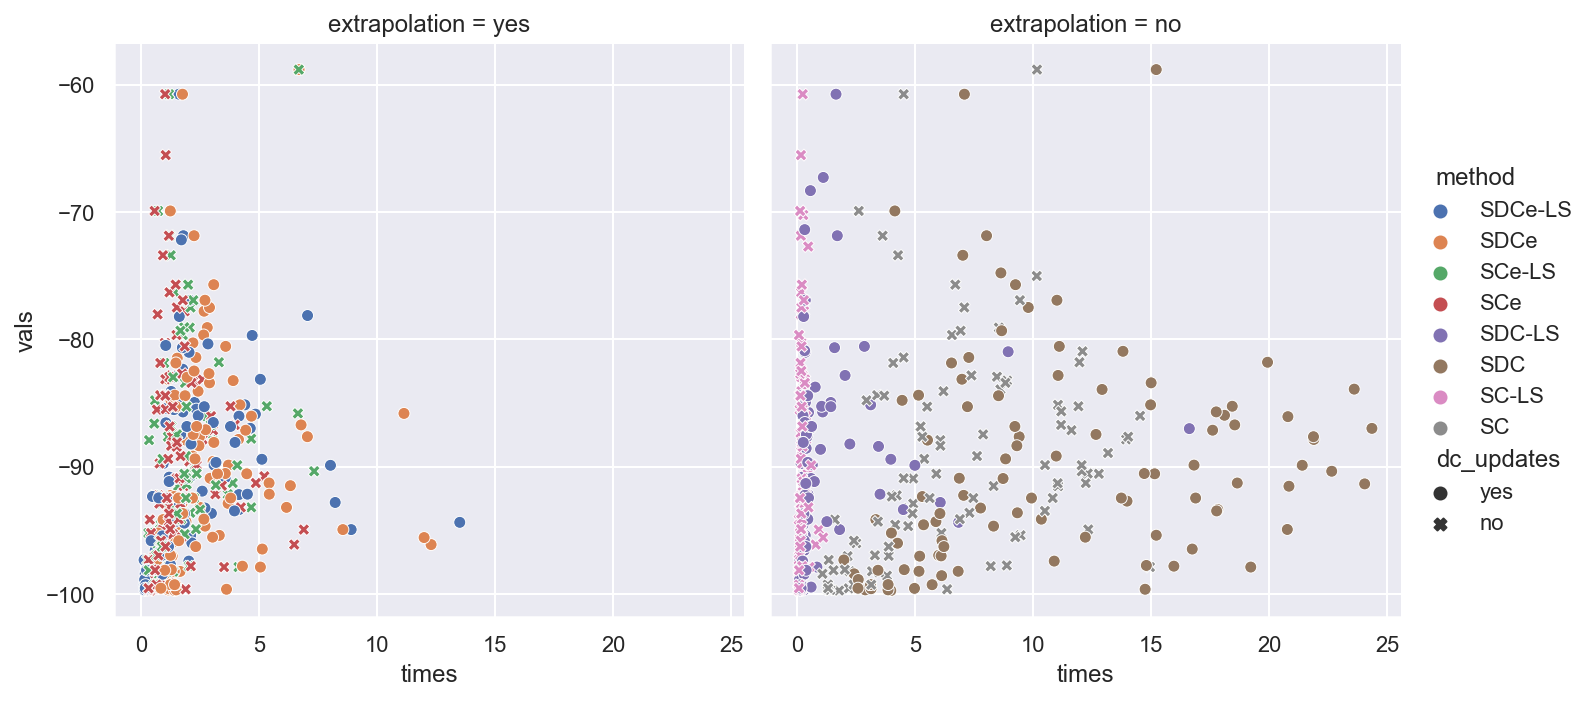

In [9]:
import seaborn as sns
sns.set_theme()
sns.relplot(
    data=subdf, x="times", y="vals",
    hue="method", style="dc_updates",
    kind="scatter",col='extrapolation'
)

In [10]:
for f in list(subdf['extrapolation'].unique()):
    subgroup = subdf[(subdf['extrapolation']==f)]
    sub = ['extrapolation: '+str(f)]
    print('subgroup: ('+str(sub)+')')
    print('avg. time: '+str(subgroup['times'].mean()))
    print('median time: '+str(subgroup['times'].median()))
    print('avg. val: '+str(subgroup['vals'].mean()))
    print('median val: '+str(subgroup['vals'].median()))
    print('avg. #iters: '+str(subgroup['iters'].mean()))
    print('median #iters: '+str(subgroup['iters'].median()))
    print(' ')

subgroup: (['extrapolation: yes'])
avg. time: 2.0976116639375686
median time: 1.6011754274368286
avg. val: -90.02049167642404
median val: -91.72873758685641
avg. #iters: 244.91
median #iters: 184.0
 
subgroup: (['extrapolation: no'])
avg. time: 4.6803761547803875
median time: 2.0832314491271973
avg. val: -89.94383207984887
median val: -91.5278831583137
avg. #iters: 663.46
median #iters: 196.0
 


In [11]:
for f in list(subdf['dc_updates'].unique()):
    subgroup = subdf[(subdf['dc_updates']==f)]
    sub = ['DC models: '+str(f)]
    print('subgroup: ('+str(sub)+')')
    print('avg. time: '+str(subgroup['times'].mean()))
    print('median time: '+str(subgroup['times'].median()))
    print('avg. val: '+str(subgroup['vals'].mean()))
    print('median val: '+str(subgroup['vals'].median()))
    print('avg. #iters: '+str(subgroup['iters'].mean()))
    print('median #iters: '+str(subgroup['iters'].median()))
    print(' ')

subgroup: (['DC models: yes'])
avg. time: 4.242703566551208
median time: 2.1727635860443115
avg. val: -90.18780608726917
median val: -92.04940631413275
avg. #iters: 424.11
median #iters: 146.0
 
subgroup: (['DC models: no'])
avg. time: 2.5352842521667482
median time: 1.2550992965698242
avg. val: -89.77651766900371
median val: -91.52787213749167
avg. #iters: 484.26
median #iters: 223.0
 


In [12]:
for f in list(subdf['method'].unique()):
    subgroup = subdf[(subdf['method']==f)]
    sub = [f]
    print('subgroup: ('+str(sub)+')')
    print('avg. time: '+str(subgroup['times'].mean()))
    print('median time: '+str(subgroup['times'].median()))
    print('avg. val: '+str(subgroup['vals'].mean()))
    print('median val: '+str(subgroup['vals'].median()))
    print('avg. #iters: '+str(subgroup['iters'].mean()))
    print('median #iters: '+str(subgroup['iters'].median()))
    print(' ')

subgroup: (['SDCe-LS'])
avg. time: 2.1802035355567932
median time: 1.6803926229476929
avg. val: -90.50118537055182
median val: -92.18505790355377
avg. #iters: 115.55
median #iters: 104.5
 
subgroup: (['SDCe'])
avg. time: 2.9367549538612367
median time: 2.3285058736801147
avg. val: -89.71433918350665
median val: -91.11518306557105
avg. #iters: 304.28
median #iters: 223.0
 
subgroup: (['SCe-LS'])
avg. time: 1.721254484653473
median time: 1.4111416339874268
avg. val: -89.96370657865431
median val: -91.84854180443509
avg. #iters: 258.39
median #iters: 219.5
 
subgroup: (['SCe'])
avg. time: 1.552233681678772
median time: 1.2001804113388062
avg. val: -89.90273557298316
median val: -91.8485520364467
avg. #iters: 301.42
median #iters: 226.0
 
subgroup: (['SDC-LS'])
avg. time: 1.087887704372406
median time: 0.34802746772766113
avg. val: -90.60163280494615
median val: -92.2234108017849
avg. #iters: 42.18
median #iters: 32.0
 
subgroup: (['SDC'])
avg. time: 10.765968072414399
median time: 9.23539